# Do not run this code!!



# Neural networks using tensorflow

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import matplotlib.pyplot as plt
import netCDF4 as n
%matplotlib inline
from utils import train_test_split

In [ ]:
#from tflow_reg import nn_model

from tflow_reg_new import nn_model

## Import data

In [ ]:
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

my_files = {'cloud':cloud, 'relative':relative, 'specific':specific, 'pressure':pressure, 'temperature':temperature}


tcc = cloud.variables["tcc"]
rh = relative.variables["r"]
q = specific.variables["q"]
sp = pressure.variables["sp"]
t2m = temperature.variables["t2m"]

my_vars = {'tcc':tcc, 'rh':rh, 'q':q, 'sp':sp, 't2m':t2m}

n_days = 1
n_grid_boxes = tcc.shape[1]*tcc.shape[2]
X = np.empty((n_grid_boxes*n_days, 4))
y = np.empty((n_grid_boxes*n_days))



for t in range(int(n_days)):
    i = 0
    for key, value in my_vars.items():
        if key == 'tcc':
            y[n_grid_boxes*t:n_grid_boxes*(t+1)] = np.array(value[t, : , :]).flatten()
        elif key == 'rh' or key == 'q':
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, 0, : , :]).flatten()
            i = i+1
        else:
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, : , :]).flatten()
            i=i+1

In [ ]:

plt.plot(range(y.shape[0]),y,label="Original Data")

### Standarize and split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.2)

Xn_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
yn_train = (y_train - y_train.mean())/y_train.std()

Xn_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
yn_test = (y_test - y_train.mean())/y_train.std()

In [ ]:
y.std()

In [ ]:
type(Xn_train)

In [ ]:
Xn_train.shape

## Neural net model

Feed forward neural net with 2 layers. Activation function: Sigmoid for all layers.

TODO: write as function

### Run neural network model

In [ ]:
npred = Xn_train.shape[1]
noutput = Xn_train.shape[0]
n_nodes = [npred, 100, 150, 1]

In [ ]:
xs = tf.placeholder("float")
ys = tf.placeholder("float")

stddev = np.sqrt(2 / np.prod(Xn_train.shape[1:]))

#output = nn_model(xs, n_nodes)
output = nn_model(xs, Xn_train.shape[1], [100, 150], 1, stddev)

### MSE

In [ ]:
cost = tf.reduce_mean(tf.square(output-ys))

### R2

In [ ]:
total_error = tf.reduce_sum(tf.square(tf.subtract(ys, tf.reduce_mean(ys))))

unexplained_error = tf.reduce_sum(tf.square(tf.subtract(ys, output)))

R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error)) 

### Gradient descent

In [ ]:
eta = 0.1
train = tf.train.GradientDescentOptimizer(eta).minimize(cost)

### Plot the data

In [ ]:
with tf.Session() as sess:
    # Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #saver.restore(sess,'yahoo_dataset.ckpt')
    c_t = []
    c_test = []
    r2_t = []
    r2_test = []
    for i in range(100):
        #for j in range(Xn_train.shape[0]):
        #    sess.run([cost,train],feed_dict=    {xs:Xn_train[j,:].reshape(1,npred), ys:yn_train[j]})
        #    # Run cost and train with each sample
        
        sess.run([cost,train],feed_dict=    {xs:Xn_train, ys:yn_train})
        
        c_t.append(sess.run(cost, feed_dict={xs:Xn_train,ys:yn_train}))
        c_test.append(sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'Cost train:',c_t[-1], 'Cost test:',c_test[-1])
        r2_t.append(sess.run(R_squared, feed_dict={xs:Xn_train,ys:yn_train}))
        r2_test.append(sess.run(R_squared, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'R2 train:',r2_t[-1], 'R2 test:',r2_test[-1])
    
    pred = sess.run(output, feed_dict={xs:Xn_test})
    # predict output of test data after training
    print('Cost :',sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
    #y_test = denormalize(df_test,y_test)
    #pred = denormalize(df_test,pred)
    #Denormalize data

    
    
    plt.plot(range(yn_test.shape[0]),yn_test,label="Original Data")
    plt.plot(range(yn_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    plt.ylabel('Total Cloud Cover')
    plt.xlabel('Points')
    #plt.title('Total Cloud Cover')
    plt.savefig('results/data_t0_2layers_10_10_split03.png')
    plt.show()
    
    
    plt.subplot(1,2,1)
    plt.plot(range(len(c_t)), c_t,label="MSE train")
    plt.plot(range(len(c_test)), c_test,label="MSE test")
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    #plt.title('Cost vs. epochs')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(r2_t)), r2_t,label="R2 train")
    plt.plot(range(len(r2_test)), r2_test,label="R2 test")
    plt.legend(loc='best')
    plt.ylabel('R2')
    plt.xlabel('Epochs')
    #plt.title('R2 vs. epochs')
    plt.tight_layout()
    plt.savefig('results/t0_2layers_10_10_split03.png')
    plt.show()
    

Epoch : 0 Cost train: inf Cost test: inf
Epoch : 0 R2 train: -inf R2 test: -inf
Epoch : 1 Cost train: inf Cost test: 3.5892456e+31
Epoch : 1 R2 train: -inf R2 test: -3.5085813e+34
Epoch : 2 Cost train: nan Cost test: nan
Epoch : 2 R2 train: nan R2 test: nan
Epoch : 3 Cost train: nan Cost test: nan
Epoch : 3 R2 train: nan R2 test: nan
Epoch : 4 Cost train: nan Cost test: nan
Epoch : 4 R2 train: nan R2 test: nan
Epoch : 5 Cost train: nan Cost test: nan
Epoch : 5 R2 train: nan R2 test: nan
Epoch : 6 Cost train: nan Cost test: nan
Epoch : 6 R2 train: nan R2 test: nan
Epoch : 7 Cost train: nan Cost test: nan
Epoch : 7 R2 train: nan R2 test: nan
Epoch : 8 Cost train: nan Cost test: nan
Epoch : 8 R2 train: nan R2 test: nan
Epoch : 9 Cost train: nan Cost test: nan
Epoch : 9 R2 train: nan R2 test: nan
Epoch : 10 Cost train: nan Cost test: nan
Epoch : 10 R2 train: nan R2 test: nan
Epoch : 11 Cost train: nan Cost test: nan
Epoch : 11 R2 train: nan R2 test: nan
Epoch : 12 Cost train: nan Cost test

- Train split size = 0.2
- Activation = sigmoid
- nodes, 100, 150
- lambda = 0.001
- Epochs = 10000
- Only t0

Epoch : 0 Cost train: 16765.955 Cost test: 16951.041
Epoch : 0 R2 train: -63806820.0 R2 test: -16365795.0
Epoch : 1 Cost train: 1651021.0 Cost test: 1665035.8
Epoch : 1 R2 train: -6240754000.0 R2 test: -1607309400.0
Epoch : 2 Cost train: 118655120.0 Cost test: 120643210.0
Epoch : 2 R2 train: -454515900000.0 R2 test: -116443480000.0
Epoch : 3 Cost train: 1271308900.0 Cost test: 1266305700.0
Epoch : 3 R2 train: -4765542500000.0 R2 test: -1222542000000.0
Epoch : 4 Cost train: 6358446000.0 Cost test: 6286144000.0
Epoch : 4 R2 train: -23589693000000.0 R2 test: -6068073700000.0
Epoch : 5 Cost train: 17138224000.0 Cost test: 17062403000.0
Epoch : 5 R2 train: -64098010000000.0 R2 test: -16463280000000.0
Epoch : 6 Cost train: 23920790000.0 Cost test: 23715836000.0
Epoch : 6 R2 train: -88860340000000.0 R2 test: -22897526000000.0
Epoch : 7 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7 R2 train: -88860350000000.0 R2 test: -22897534000000.0
Epoch : 8 Cost train: 23920796000.0 Cost te

Epoch : 65 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 65 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 66 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 66 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 67 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 67 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 68 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 68 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 69 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 69 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 70 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 70 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 71 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 71 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 72 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 72 R2 train: -88860390000000.0 R2 

Epoch : 129 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 129 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 130 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 130 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 131 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 131 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 132 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 132 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 133 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 133 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 134 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 134 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 135 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 135 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 136 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 136 R2 train: -8886

Epoch : 193 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 193 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 194 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 194 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 195 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 195 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 196 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 196 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 197 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 197 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 198 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 198 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 199 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 199 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 200 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 200 R2 train: -8886

Epoch : 257 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 257 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 258 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 258 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 259 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 259 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 260 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 260 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 261 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 261 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 262 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 262 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 263 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 263 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 264 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 264 R2 train: -8886

Epoch : 321 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 321 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 322 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 322 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 323 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 323 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 324 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 324 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 325 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 325 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 326 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 326 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 327 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 327 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 328 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 328 R2 train: -8886

Epoch : 385 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 385 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 386 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 386 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 387 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 387 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 388 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 388 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 389 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 389 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 390 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 390 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 391 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 391 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 392 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 392 R2 train: -8886

Epoch : 449 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 449 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 450 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 450 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 451 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 451 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 452 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 452 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 453 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 453 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 454 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 454 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 455 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 455 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 456 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 456 R2 train: -8886

Epoch : 513 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 513 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 514 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 514 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 515 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 515 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 516 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 516 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 517 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 517 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 518 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 518 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 519 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 519 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 520 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 520 R2 train: -8886

Epoch : 577 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 577 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 578 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 578 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 579 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 579 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 580 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 580 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 581 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 581 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 582 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 582 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 583 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 583 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 584 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 584 R2 train: -8886

Epoch : 641 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 641 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 642 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 642 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 643 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 643 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 644 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 644 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 645 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 645 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 646 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 646 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 647 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 647 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 648 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 648 R2 train: -8886

Epoch : 705 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 705 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 706 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 706 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 707 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 707 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 708 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 708 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 709 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 709 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 710 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 710 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 711 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 711 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 712 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 712 R2 train: -8886

Epoch : 769 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 769 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 770 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 770 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 771 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 771 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 772 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 772 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 773 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 773 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 774 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 774 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 775 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 775 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 776 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 776 R2 train: -8886

Epoch : 833 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 833 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 834 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 834 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 835 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 835 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 836 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 836 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 837 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 837 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 838 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 838 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 839 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 839 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 840 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 840 R2 train: -8886

Epoch : 897 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 897 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 898 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 898 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 899 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 899 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 900 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 900 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 901 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 901 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 902 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 902 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 903 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 903 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 904 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 904 R2 train: -8886

Epoch : 961 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 961 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 962 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 962 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 963 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 963 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 964 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 964 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 965 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 965 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 966 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 966 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 967 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 967 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 968 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 968 R2 train: -8886

Epoch : 1024 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1024 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1025 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1025 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1026 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1026 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1027 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1027 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1028 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1028 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1029 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1029 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1030 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1030 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1031 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1031

Epoch : 1087 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1087 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1088 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1088 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1089 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1089 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1090 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1090 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1091 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1091 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1092 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1092 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1093 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1093 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1094 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1094

Epoch : 1150 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1150 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1151 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1151 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1152 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1152 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1153 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1153 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1154 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1154 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1155 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1155 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1156 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1156 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1157 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1157

Epoch : 1213 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1213 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1214 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1214 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1215 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1215 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1216 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1216 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1217 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1217 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1218 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1218 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1219 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1219 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1220 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1220

Epoch : 1276 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1276 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1277 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1277 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1278 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1278 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1279 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1279 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1280 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1280 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1281 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1281 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1282 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1282 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1283 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1283

Epoch : 1339 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1339 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1340 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1340 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1341 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1341 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1342 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1342 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1343 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1343 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1344 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1344 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1345 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1345 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1346 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1346

Epoch : 1402 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1402 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1403 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1403 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1404 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1404 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1405 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1405 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1406 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1406 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1407 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1407 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1408 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1408 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1409 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1409

Epoch : 1465 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1465 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1466 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1466 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1467 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1467 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1468 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1468 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1469 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1469 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1470 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1470 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1471 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1471 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1472 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1472

Epoch : 1528 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1528 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1529 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1529 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1530 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1530 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1531 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1531 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1532 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1532 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1533 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1533 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1534 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1534 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1535 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1535

Epoch : 1591 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1591 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1592 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1592 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1593 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1593 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1594 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1594 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1595 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1595 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1596 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1596 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1597 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1597 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1598 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1598

Epoch : 1654 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1654 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1655 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1655 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1656 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1656 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1657 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1657 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1658 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1658 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1659 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1659 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1660 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1660 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1661 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1661

Epoch : 1717 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1717 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1718 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1718 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1719 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1719 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1720 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1720 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1721 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1721 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1722 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1722 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1723 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1723 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1724 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1724

Epoch : 1780 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1780 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1781 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1781 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1782 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1782 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1783 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1783 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1784 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1784 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1785 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1785 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1786 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1786 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1787 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1787

Epoch : 1843 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1843 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1844 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1844 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1845 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1845 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1846 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1846 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1847 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1847 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1848 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1848 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1849 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1849 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1850 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1850

Epoch : 1906 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1906 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1907 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1907 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1908 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1908 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1909 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1909 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1910 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1910 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1911 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1911 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1912 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1912 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1913 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1913

Epoch : 1969 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1969 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1970 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1970 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1971 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1971 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1972 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1972 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1973 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1973 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1974 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1974 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 1975 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 1975 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 1976 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 1976

Epoch : 2032 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2032 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2033 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2033 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2034 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2034 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2035 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2035 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2036 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2036 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2037 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2037 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2038 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2038 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2039 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2039

Epoch : 2095 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2095 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2096 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2096 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2097 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2097 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2098 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2098 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2099 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2099 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2100 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2100 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2101 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2101 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2102 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2102

Epoch : 2158 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2158 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2159 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2159 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2160 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2160 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2161 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2161 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2162 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2162 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2163 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2163 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2164 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2164 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2165 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2165

Epoch : 2221 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2221 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2222 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2222 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2223 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2223 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2224 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2224 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2225 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2225 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2226 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2226 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2227 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2227 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2228 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2228

Epoch : 2284 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2284 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2285 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2285 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2286 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2286 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2287 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2287 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2288 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2288 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2289 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2289 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2290 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2290 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2291 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2291

Epoch : 2347 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2347 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2348 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2348 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2349 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2349 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2350 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2350 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2351 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2351 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2352 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2352 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2353 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2353 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2354 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2354

Epoch : 2410 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2410 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2411 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2411 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2412 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2412 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2413 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2413 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2414 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2414 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2415 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2415 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2416 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2416 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2417 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2417

Epoch : 2473 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2473 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2474 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2474 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2475 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2475 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2476 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2476 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2477 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2477 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2478 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2478 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2479 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2479 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2480 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2480

Epoch : 2536 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2536 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2537 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2537 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2538 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2538 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2539 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2539 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2540 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2540 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2541 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2541 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2542 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2542 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2543 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2543

Epoch : 2599 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2599 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2600 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2600 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2601 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2601 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2602 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2602 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2603 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2603 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2604 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2604 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2605 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2605 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2606 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2606

Epoch : 2662 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2662 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2663 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2663 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2664 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2664 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2665 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2665 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2666 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2666 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2667 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2667 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2668 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2668 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2669 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2669

Epoch : 2725 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2725 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2726 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2726 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2727 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2727 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2728 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2728 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2729 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2729 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2730 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2730 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2731 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2731 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2732 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2732

Epoch : 2788 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2788 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2789 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2789 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2790 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2790 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2791 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2791 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2792 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2792 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2793 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2793 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2794 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2794 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2795 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2795

Epoch : 2851 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2851 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2852 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2852 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2853 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2853 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2854 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2854 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2855 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2855 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2856 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2856 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2857 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2857 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2858 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2858

Epoch : 2914 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2914 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2915 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2915 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2916 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2916 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2917 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2917 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2918 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2918 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2919 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2919 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2920 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2920 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2921 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2921

Epoch : 2977 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2977 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2978 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2978 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2979 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2979 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2980 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2980 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2981 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2981 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2982 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2982 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 2983 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 2983 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 2984 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 2984

Epoch : 3040 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3040 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3041 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3041 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3042 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3042 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3043 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3043 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3044 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3044 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3045 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3045 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3046 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3046 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3047 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3047

Epoch : 3103 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3103 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3104 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3104 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3105 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3105 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3106 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3106 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3107 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3107 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3108 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3108 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3109 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3109 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3110 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3110

Epoch : 3166 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3166 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3167 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3167 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3168 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3168 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3169 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3169 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3170 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3170 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3171 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3171 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3172 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3172 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3173 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3173

Epoch : 3229 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3229 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3230 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3230 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3231 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3231 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3232 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3232 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3233 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3233 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3234 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3234 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3235 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3235 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3236 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3236

Epoch : 3292 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3292 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3293 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3293 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3294 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3294 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3295 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3295 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3296 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3296 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3297 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3297 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3298 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3298 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3299 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3299

Epoch : 3355 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3355 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3356 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3356 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3357 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3357 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3358 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3358 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3359 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3359 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3360 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3360 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3361 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3361 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3362 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3362

Epoch : 3418 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3418 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3419 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3419 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3420 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3420 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3421 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3421 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3422 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3422 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3423 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3423 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3424 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3424 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3425 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3425

Epoch : 3481 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3481 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3482 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3482 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3483 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3483 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3484 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3484 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3485 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3485 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3486 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3486 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3487 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3487 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3488 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3488

Epoch : 3544 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3544 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3545 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3545 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3546 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3546 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3547 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3547 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3548 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3548 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3549 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3549 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3550 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3550 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3551 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3551

Epoch : 3607 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3607 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3608 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3608 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3609 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3609 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3610 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3610 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3611 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3611 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3612 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3612 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3613 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3613 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3614 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3614

Epoch : 3670 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3670 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3671 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3671 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3672 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3672 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3673 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3673 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3674 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3674 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3675 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3675 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3676 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3676 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3677 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3677

Epoch : 3733 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3733 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3734 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3734 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3735 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3735 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3736 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3736 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3737 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3737 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3738 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3738 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3739 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3739 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3740 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3740

Epoch : 3796 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3796 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3797 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3797 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3798 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3798 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3799 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3799 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3800 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3800 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3801 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3801 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3802 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3802 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3803 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3803

Epoch : 3859 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3859 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3860 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3860 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3861 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3861 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3862 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3862 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3863 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3863 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3864 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3864 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3865 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3865 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3866 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3866

Epoch : 3922 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3922 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3923 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3923 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3924 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3924 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3925 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3925 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3926 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3926 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3927 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3927 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3928 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3928 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3929 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3929

Epoch : 3985 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3985 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3986 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3986 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3987 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3987 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3988 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3988 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3989 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3989 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3990 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3990 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 3991 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 3991 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 3992 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 3992

Epoch : 4048 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4048 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4049 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4049 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4050 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4050 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4051 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4051 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4052 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4052 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4053 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4053 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4054 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4054 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4055 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4055

Epoch : 4111 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4111 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4112 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4112 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4113 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4113 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4114 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4114 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4115 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4115 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4116 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4116 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4117 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4117 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4118 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4118

Epoch : 4174 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4174 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4175 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4175 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4176 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4176 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4177 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4177 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4178 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4178 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4179 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4179 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4180 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4180 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4181 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4181

Epoch : 4237 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4237 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4238 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4238 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4239 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4239 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4240 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4240 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4241 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4241 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4242 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4242 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4243 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4243 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4244 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4244

Epoch : 4300 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4300 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4301 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4301 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4302 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4302 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4303 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4303 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4304 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4304 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4305 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4305 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4306 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4306 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4307 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4307

Epoch : 4363 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4363 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4364 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4364 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4365 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4365 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4366 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4366 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4367 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4367 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4368 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4368 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4369 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4369 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4370 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4370

Epoch : 4426 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4426 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4427 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4427 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4428 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4428 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4429 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4429 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4430 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4430 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4431 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4431 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4432 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4432 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4433 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4433

Epoch : 4489 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4489 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4490 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4490 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4491 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4491 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4492 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4492 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4493 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4493 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4494 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4494 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4495 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4495 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4496 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4496

Epoch : 4552 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4552 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4553 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4553 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4554 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4554 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4555 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4555 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4556 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4556 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4557 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4557 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4558 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4558 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4559 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4559

Epoch : 4615 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4615 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4616 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4616 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4617 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4617 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4618 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4618 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4619 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4619 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4620 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4620 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4621 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4621 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4622 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4622

Epoch : 4678 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4678 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4679 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4679 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4680 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4680 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4681 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4681 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4682 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4682 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4683 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4683 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4684 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4684 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4685 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4685

Epoch : 4741 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4741 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4742 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4742 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4743 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4743 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4744 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4744 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4745 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4745 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4746 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4746 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4747 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4747 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4748 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4748

Epoch : 4804 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4804 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4805 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4805 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4806 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4806 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4807 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4807 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4808 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4808 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4809 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4809 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4810 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4810 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4811 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4811

Epoch : 4867 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4867 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4868 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4868 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4869 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4869 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4870 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4870 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4871 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4871 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4872 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4872 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4873 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4873 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4874 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4874

Epoch : 4930 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4930 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4931 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4931 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4932 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4932 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4933 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4933 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4934 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4934 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4935 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4935 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4936 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4936 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4937 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4937

Epoch : 4993 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4993 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4994 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4994 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4995 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4995 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4996 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4996 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4997 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4997 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 4998 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 4998 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 4999 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 4999 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5000 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5000

Epoch : 5056 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5056 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5057 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5057 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5058 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5058 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5059 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5059 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5060 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5060 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5061 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5061 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5062 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5062 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5063 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5063

Epoch : 5119 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5119 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5120 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5120 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5121 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5121 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5122 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5122 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5123 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5123 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5124 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5124 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5125 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5125 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5126 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5126

Epoch : 5182 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5182 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5183 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5183 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5184 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5184 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5185 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5185 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5186 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5186 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5187 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5187 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5188 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5188 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5189 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5189

Epoch : 5245 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5245 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5246 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5246 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5247 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5247 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5248 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5248 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5249 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5249 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5250 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5250 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5251 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5251 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5252 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5252

Epoch : 5308 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5308 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5309 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5309 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5310 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5310 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5311 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5311 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5312 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5312 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5313 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5313 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5314 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5314 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5315 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5315

Epoch : 5371 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5371 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5372 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5372 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5373 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5373 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5374 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5374 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5375 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5375 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5376 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5376 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5377 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5377 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5378 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5378

Epoch : 5434 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5434 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5435 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5435 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5436 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5436 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5437 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5437 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5438 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5438 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5439 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5439 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5440 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5440 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5441 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5441

Epoch : 5497 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5497 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5498 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5498 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5499 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5499 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5500 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5500 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5501 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5501 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5502 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5502 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5503 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5503 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5504 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5504

Epoch : 5560 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5560 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5561 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5561 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5562 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5562 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5563 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5563 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5564 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5564 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5565 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5565 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5566 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5566 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5567 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5567

Epoch : 5623 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5623 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5624 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5624 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5625 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5625 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5626 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5626 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5627 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5627 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5628 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5628 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5629 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5629 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5630 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5630

Epoch : 5686 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5686 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5687 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5687 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5688 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5688 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5689 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5689 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5690 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5690 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5691 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5691 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5692 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5692 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5693 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5693

Epoch : 5749 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5749 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5750 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5750 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5751 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5751 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5752 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5752 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5753 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5753 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5754 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5754 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5755 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5755 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5756 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5756

Epoch : 5812 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5812 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5813 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5813 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5814 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5814 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5815 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5815 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5816 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5816 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5817 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5817 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5818 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5818 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5819 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5819

Epoch : 5875 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5875 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5876 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5876 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5877 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5877 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5878 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5878 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5879 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5879 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5880 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5880 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5881 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5881 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5882 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5882

Epoch : 5938 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5938 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5939 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5939 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5940 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5940 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5941 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5941 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5942 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5942 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5943 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5943 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 5944 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 5944 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 5945 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 5945

Epoch : 6001 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6001 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6002 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6002 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6003 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6003 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6004 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6004 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6005 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6005 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6006 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6006 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6007 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6007 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6008 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6008

Epoch : 6064 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6064 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6065 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6065 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6066 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6066 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6067 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6067 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6068 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6068 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6069 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6069 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6070 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6070 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6071 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6071

Epoch : 6127 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6127 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6128 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6128 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6129 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6129 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6130 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6130 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6131 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6131 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6132 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6132 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6133 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6133 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6134 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6134

Epoch : 6190 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6190 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6191 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6191 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6192 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6192 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6193 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6193 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6194 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6194 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6195 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6195 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6196 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6196 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6197 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6197

Epoch : 6253 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6253 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6254 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6254 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6255 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6255 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6256 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6256 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6257 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6257 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6258 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6258 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6259 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6259 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6260 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6260

Epoch : 6316 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6316 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6317 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6317 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6318 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6318 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6319 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6319 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6320 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6320 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6321 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6321 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6322 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6322 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6323 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6323

Epoch : 6379 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6379 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6380 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6380 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6381 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6381 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6382 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6382 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6383 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6383 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6384 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6384 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6385 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6385 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6386 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6386

Epoch : 6442 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6442 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6443 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6443 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6444 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6444 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6445 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6445 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6446 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6446 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6447 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6447 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6448 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6448 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6449 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6449

Epoch : 6505 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6505 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6506 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6506 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6507 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6507 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6508 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6508 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6509 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6509 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6510 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6510 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6511 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6511 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6512 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6512

Epoch : 6568 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6568 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6569 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6569 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6570 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6570 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6571 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6571 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6572 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6572 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6573 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6573 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6574 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6574 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6575 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6575

Epoch : 6631 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6631 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6632 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6632 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6633 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6633 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6634 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6634 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6635 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6635 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6636 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6636 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6637 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6637 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6638 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6638

Epoch : 6694 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6694 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6695 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6695 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6696 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6696 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6697 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6697 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6698 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6698 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6699 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6699 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6700 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6700 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6701 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6701

Epoch : 6757 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6757 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6758 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6758 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6759 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6759 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6760 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6760 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6761 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6761 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6762 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6762 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6763 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6763 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6764 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6764

Epoch : 6820 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6820 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6821 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6821 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6822 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6822 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6823 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6823 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6824 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6824 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6825 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6825 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6826 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6826 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6827 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6827

Epoch : 6883 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6883 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6884 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6884 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6885 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6885 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6886 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6886 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6887 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6887 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6888 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6888 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6889 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6889 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6890 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6890

Epoch : 6946 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6946 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6947 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6947 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6948 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6948 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6949 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6949 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6950 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6950 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6951 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6951 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 6952 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 6952 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 6953 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 6953

Epoch : 7009 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7009 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7010 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7010 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7011 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7011 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7012 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7012 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7013 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7013 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7014 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7014 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7015 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7015 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7016 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7016

Epoch : 7072 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7072 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7073 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7073 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7074 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7074 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7075 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7075 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7076 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7076 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7077 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7077 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7078 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7078 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7079 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7079

Epoch : 7135 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7135 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7136 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7136 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7137 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7137 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7138 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7138 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7139 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7139 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7140 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7140 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7141 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7141 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7142 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7142

Epoch : 7198 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7198 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7199 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7199 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7200 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7200 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7201 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7201 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7202 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7202 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7203 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7203 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7204 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7204 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7205 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7205

Epoch : 7261 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7261 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7262 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7262 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7263 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7263 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7264 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7264 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7265 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7265 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7266 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7266 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7267 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7267 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7268 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7268

Epoch : 7324 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7324 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7325 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7325 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7326 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7326 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7327 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7327 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7328 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7328 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7329 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7329 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7330 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7330 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7331 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7331

Epoch : 7387 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7387 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7388 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7388 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7389 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7389 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7390 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7390 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7391 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7391 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7392 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7392 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7393 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7393 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7394 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7394

Epoch : 7450 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7450 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7451 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7451 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7452 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7452 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7453 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7453 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7454 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7454 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7455 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7455 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7456 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7456 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7457 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7457

Epoch : 7513 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7513 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7514 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7514 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7515 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7515 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7516 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7516 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7517 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7517 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7518 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7518 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7519 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7519 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7520 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7520

Epoch : 7576 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7576 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7577 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7577 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7578 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7578 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7579 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7579 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7580 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7580 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7581 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7581 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7582 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7582 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7583 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7583

Epoch : 7639 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7639 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7640 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7640 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7641 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7641 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7642 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7642 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7643 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7643 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7644 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7644 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7645 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7645 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7646 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7646

Epoch : 7702 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7702 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7703 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7703 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7704 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7704 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7705 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7705 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7706 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7706 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7707 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7707 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7708 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7708 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7709 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7709

Epoch : 7765 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7765 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7766 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7766 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7767 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7767 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7768 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7768 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7769 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7769 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7770 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7770 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7771 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7771 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7772 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7772

Epoch : 7828 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7828 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7829 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7829 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7830 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7830 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7831 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7831 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7832 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7832 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7833 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7833 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7834 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7834 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7835 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7835

Epoch : 7891 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7891 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7892 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7892 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7893 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7893 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7894 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7894 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7895 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7895 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7896 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7896 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7897 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7897 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7898 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7898

Epoch : 7954 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7954 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7955 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7955 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7956 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7956 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7957 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7957 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7958 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7958 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7959 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7959 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 7960 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 7960 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 7961 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 7961

Epoch : 8017 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8017 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8018 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8018 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8019 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8019 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8020 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8020 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8021 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8021 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8022 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8022 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8023 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8023 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8024 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8024

Epoch : 8080 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8080 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8081 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8081 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8082 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8082 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8083 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8083 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8084 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8084 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8085 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8085 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8086 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8086 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8087 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8087

Epoch : 8143 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8143 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8144 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8144 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8145 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8145 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8146 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8146 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8147 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8147 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8148 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8148 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8149 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8149 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8150 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8150

Epoch : 8206 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8206 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8207 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8207 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8208 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8208 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8209 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8209 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8210 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8210 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8211 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8211 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8212 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8212 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8213 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8213

Epoch : 8269 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8269 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8270 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8270 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8271 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8271 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8272 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8272 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8273 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8273 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8274 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8274 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8275 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8275 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8276 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8276

Epoch : 8332 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8332 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8333 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8333 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8334 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8334 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8335 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8335 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8336 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8336 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8337 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8337 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8338 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8338 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8339 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8339

Epoch : 8395 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8395 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8396 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8396 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8397 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8397 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8398 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8398 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8399 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8399 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8400 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8400 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8401 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8401 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8402 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8402

Epoch : 8458 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8458 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8459 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8459 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8460 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8460 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8461 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8461 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8462 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8462 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8463 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8463 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8464 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8464 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8465 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8465

Epoch : 8521 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8521 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8522 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8522 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8523 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8523 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8524 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8524 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8525 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8525 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8526 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8526 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8527 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8527 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8528 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8528

Epoch : 8584 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8584 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8585 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8585 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8586 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8586 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8587 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8587 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8588 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8588 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8589 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8589 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8590 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8590 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8591 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8591

Epoch : 8647 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8647 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8648 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8648 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8649 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8649 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8650 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8650 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8651 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8651 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8652 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8652 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8653 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8653 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8654 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8654

Epoch : 8710 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8710 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8711 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8711 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8712 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8712 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8713 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8713 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8714 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8714 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8715 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8715 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8716 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8716 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8717 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8717

Epoch : 8773 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8773 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8774 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8774 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8775 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8775 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8776 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8776 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8777 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8777 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8778 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8778 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8779 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8779 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8780 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8780

Epoch : 8836 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8836 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8837 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8837 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8838 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8838 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8839 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8839 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8840 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8840 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8841 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8841 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8842 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8842 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8843 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8843

Epoch : 8899 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8899 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8900 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8900 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8901 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8901 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8902 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8902 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8903 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8903 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8904 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8904 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8905 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8905 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8906 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8906

Epoch : 8962 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8962 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8963 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8963 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8964 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8964 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8965 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8965 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8966 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8966 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8967 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8967 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 8968 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 8968 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 8969 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 8969

Epoch : 9025 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9025 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9026 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9026 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9027 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9027 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9028 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9028 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9029 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9029 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9030 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9030 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9031 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9031 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9032 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9032

Epoch : 9088 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9088 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9089 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9089 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9090 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9090 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9091 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9091 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9092 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9092 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9093 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9093 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9094 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9094 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9095 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9095

Epoch : 9151 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9151 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9152 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9152 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9153 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9153 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9154 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9154 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9155 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9155 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9156 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9156 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9157 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9157 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9158 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9158

Epoch : 9214 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9214 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9215 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9215 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9216 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9216 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9217 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9217 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9218 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9218 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9219 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9219 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9220 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9220 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9221 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9221

Epoch : 9277 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9277 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9278 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9278 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9279 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9279 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9280 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9280 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9281 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9281 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9282 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9282 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9283 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9283 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9284 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9284

Epoch : 9340 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9340 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9341 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9341 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9342 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9342 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9343 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9343 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9344 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9344 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9345 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9345 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9346 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9346 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9347 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9347

Epoch : 9403 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9403 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9404 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9404 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9405 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9405 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9406 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9406 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9407 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9407 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9408 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9408 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9409 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9409 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9410 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9410

Epoch : 9466 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9466 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9467 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9467 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9468 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9468 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9469 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9469 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9470 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9470 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9471 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9471 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9472 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9472 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9473 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9473

Epoch : 9529 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9529 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9530 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9530 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9531 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9531 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9532 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9532 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9533 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9533 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9534 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9534 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9535 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9535 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9536 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9536

Epoch : 9592 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9592 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9593 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9593 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9594 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9594 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9595 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9595 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9596 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9596 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9597 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9597 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9598 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9598 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9599 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9599

Epoch : 9655 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9655 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9656 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9656 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9657 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9657 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9658 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9658 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9659 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9659 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9660 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9660 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9661 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9661 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9662 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9662

Epoch : 9718 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9718 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9719 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9719 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9720 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9720 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9721 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9721 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9722 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9722 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9723 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9723 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9724 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9724 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9725 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9725

Epoch : 9781 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9781 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9782 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9782 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9783 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9783 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9784 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9784 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9785 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9785 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9786 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9786 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9787 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9787 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9788 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9788

Epoch : 9844 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9844 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9845 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9845 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9846 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9846 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9847 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9847 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9848 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9848 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9849 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9849 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9850 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9850 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9851 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9851

Epoch : 9907 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9907 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9908 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9908 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9909 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9909 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9910 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9910 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9911 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9911 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9912 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9912 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9913 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9913 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9914 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9914

Epoch : 9970 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9970 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9971 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9971 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9972 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9972 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9973 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9973 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9974 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9974 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9975 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9975 R2 train: -88860350000000.0 R2 test: -22897536000000.0
Epoch : 9976 Cost train: 23920796000.0 Cost test: 23715879000.0
Epoch : 9976 R2 train: -88860390000000.0 R2 test: -22897690000000.0
Epoch : 9977 Cost train: 23920790000.0 Cost test: 23715838000.0
Epoch : 9977

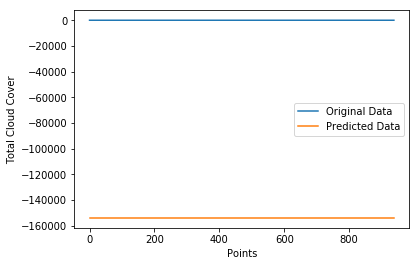

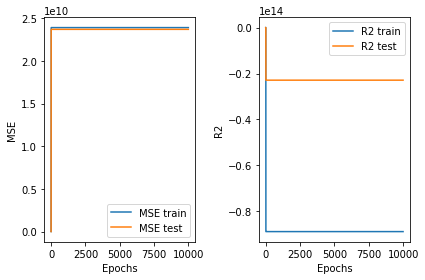

In [28]:
with tf.Session() as sess:
    # Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #saver.restore(sess,'yahoo_dataset.ckpt')
    c_t = []
    c_test = []
    r2_t = []
    r2_test = []
    for i in range(10000):
        #for j in range(Xn_train.shape[0]):
        #    sess.run([cost,train],feed_dict=    {xs:Xn_train[j,:].reshape(1,npred), ys:yn_train[j]})
        #    # Run cost and train with each sample
        
        sess.run([cost,train],feed_dict=    {xs:Xn_train, ys:yn_train})
        
        c_t.append(sess.run(cost, feed_dict={xs:Xn_train,ys:yn_train}))
        c_test.append(sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'Cost train:',c_t[-1], 'Cost test:',c_test[-1])
        r2_t.append(sess.run(R_squared, feed_dict={xs:Xn_train,ys:yn_train}))
        r2_test.append(sess.run(R_squared, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'R2 train:',r2_t[-1], 'R2 test:',r2_test[-1])
    
    pred = sess.run(output, feed_dict={xs:Xn_test})
    # predict output of test data after training
    print('Cost :',sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
    #y_test = denormalize(df_test,y_test)
    #pred = denormalize(df_test,pred)
    #Denormalize data

    
    
    plt.plot(range(yn_test.shape[0]),yn_test,label="Original Data")
    plt.plot(range(yn_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    plt.ylabel('Total Cloud Cover')
    plt.xlabel('Points')
    #plt.title('Total Cloud Cover')
    plt.savefig('results/data_t0_2layers_10_10_split03.png')
    plt.show()
    
    
    plt.subplot(1,2,1)
    plt.plot(range(len(c_t)), c_t,label="MSE train")
    plt.plot(range(len(c_test)), c_test,label="MSE test")
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    #plt.title('Cost vs. epochs')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(r2_t)), r2_t,label="R2 train")
    plt.plot(range(len(r2_test)), r2_test,label="R2 test")
    plt.legend(loc='best')
    plt.ylabel('R2')
    plt.xlabel('Epochs')
    #plt.title('R2 vs. epochs')
    plt.tight_layout()
    plt.savefig('results/t0_2layers_10_10_split03.png')
    plt.show()
    

- Train split size = 0.2
- Activation = sigmoid
- nodes, 100, 150
- lambda = 0.001
- Epochs = 10000
- Only t0

Epoch : 0 Cost train: 462.8238 Cost test: 463.90024
Epoch : 0 R2 train: -1739295.2 R2 test: -447877.75
Epoch : 1 Cost train: 3525.69 Cost test: 3521.328
Epoch : 1 R2 train: -13233571.0 R2 test: -3399712.2
Epoch : 2 Cost train: 512.5081 Cost test: 512.39844
Epoch : 2 R2 train: -1923824.6 R2 test: -494706.0
Epoch : 3 Cost train: 2.457016 Cost test: 2.4154658
Epoch : 3 R2 train: -9238.374 R2 test: -2331.0396
Epoch : 4 Cost train: 1.2217355 Cost test: 1.1908778
Epoch : 4 R2 train: -4594.234 R2 test: -1148.7377
Epoch : 5 Cost train: 1.1485149 Cost test: 1.1200148
Epoch : 5 R2 train: -4317.4136 R2 test: -1080.3341
Epoch : 6 Cost train: 1.1422724 Cost test: 1.1144814
Epoch : 6 R2 train: -4293.826 R2 test: -1074.9746
Epoch : 7 Cost train: 1.1399399 Cost test: 1.1123688
Epoch : 7 R2 train: -4285.2046 R2 test: -1072.9354
Epoch : 8 Cost train: 1.1379532 Cost test: 1.1103827
Epoch : 8 R2 train: -4277.273 R2 test: -1071.0427
Epoch : 9 Cost train: 1.1358644 Cost test: 1.10847
Epoch : 9 R2 train: -42

Epoch : 79 Cost train: 1.0639094 Cost test: 1.0382106
Epoch : 79 R2 train: -3999.3235 R2 test: -1001.34186
Epoch : 80 Cost train: 1.0634345 Cost test: 1.0377381
Epoch : 80 R2 train: -3997.584 R2 test: -1000.8962
Epoch : 81 Cost train: 1.062995 Cost test: 1.0372828
Epoch : 81 R2 train: -3995.7559 R2 test: -1000.4495
Epoch : 82 Cost train: 1.0625119 Cost test: 1.0368357
Epoch : 82 R2 train: -3994.1 R2 test: -1000.0099
Epoch : 83 Cost train: 1.0620517 Cost test: 1.0363922
Epoch : 83 R2 train: -3992.4434 R2 test: -999.5838
Epoch : 84 Cost train: 1.0616604 Cost test: 1.0359442
Epoch : 84 R2 train: -3990.688 R2 test: -999.16284
Epoch : 85 Cost train: 1.0611928 Cost test: 1.035524
Epoch : 85 R2 train: -3989.0852 R2 test: -998.7497
Epoch : 86 Cost train: 1.0607629 Cost test: 1.0350963
Epoch : 86 R2 train: -3987.4414 R2 test: -998.34674
Epoch : 87 Cost train: 1.0603654 Cost test: 1.0347013
Epoch : 87 R2 train: -3985.7996 R2 test: -997.9463
Epoch : 88 Cost train: 1.0598909 Cost test: 1.0342742
E

Epoch : 157 Cost train: 1.0426028 Cost test: 1.0174346
Epoch : 157 R2 train: -3919.4028 R2 test: -981.3006
Epoch : 158 Cost train: 1.0424241 Cost test: 1.0172917
Epoch : 158 R2 train: -3918.9019 R2 test: -981.16095
Epoch : 159 Cost train: 1.0422759 Cost test: 1.0171555
Epoch : 159 R2 train: -3918.377 R2 test: -981.0267
Epoch : 160 Cost train: 1.0421301 Cost test: 1.0170205
Epoch : 160 R2 train: -3917.7957 R2 test: -980.89325
Epoch : 161 Cost train: 1.0420364 Cost test: 1.0169041
Epoch : 161 R2 train: -3917.3674 R2 test: -980.7611
Epoch : 162 Cost train: 1.0418891 Cost test: 1.0167592
Epoch : 162 R2 train: -3916.8037 R2 test: -980.63074
Epoch : 163 Cost train: 1.0417364 Cost test: 1.0166134
Epoch : 163 R2 train: -3916.3245 R2 test: -980.5061
Epoch : 164 Cost train: 1.0415796 Cost test: 1.0164928
Epoch : 164 R2 train: -3915.8499 R2 test: -980.37933
Epoch : 165 Cost train: 1.0414697 Cost test: 1.0163481
Epoch : 165 R2 train: -3915.3225 R2 test: -980.25555
Epoch : 166 Cost train: 1.0413282

Epoch : 234 Cost train: 1.0351781 Cost test: 1.0100876
Epoch : 234 R2 train: -3891.7773 R2 test: -974.19183
Epoch : 235 Cost train: 1.0351317 Cost test: 1.0100263
Epoch : 235 R2 train: -3891.5054 R2 test: -974.1277
Epoch : 236 Cost train: 1.0350761 Cost test: 1.0099475
Epoch : 236 R2 train: -3891.3079 R2 test: -974.0671
Epoch : 237 Cost train: 1.0350003 Cost test: 1.0098922
Epoch : 237 R2 train: -3891.0105 R2 test: -974.00305
Epoch : 238 Cost train: 1.0349499 Cost test: 1.0098288
Epoch : 238 R2 train: -3890.793 R2 test: -973.94476
Epoch : 239 Cost train: 1.0349126 Cost test: 1.0097531
Epoch : 239 R2 train: -3890.5217 R2 test: -973.88495
Epoch : 240 Cost train: 1.0348555 Cost test: 1.0096956
Epoch : 240 R2 train: -3890.276 R2 test: -973.82654
Epoch : 241 Cost train: 1.0348203 Cost test: 1.009634
Epoch : 241 R2 train: -3890.0586 R2 test: -973.76373
Epoch : 242 Cost train: 1.0347694 Cost test: 1.0095538
Epoch : 242 R2 train: -3889.895 R2 test: -973.70276
Epoch : 243 Cost train: 1.0347474 

Epoch : 311 Cost train: 1.031546 Cost test: 1.006125
Epoch : 311 R2 train: -3877.4143 R2 test: -970.3766
Epoch : 312 Cost train: 1.0315039 Cost test: 1.0060893
Epoch : 312 R2 train: -3877.2424 R2 test: -970.3345
Epoch : 313 Cost train: 1.0314531 Cost test: 1.0060489
Epoch : 313 R2 train: -3877.0708 R2 test: -970.2932
Epoch : 314 Cost train: 1.0314062 Cost test: 1.0060126
Epoch : 314 R2 train: -3876.9495 R2 test: -970.253
Epoch : 315 Cost train: 1.0313776 Cost test: 1.0059758
Epoch : 315 R2 train: -3876.797 R2 test: -970.21375
Epoch : 316 Cost train: 1.0313402 Cost test: 1.0059341
Epoch : 316 R2 train: -3876.6836 R2 test: -970.1745
Epoch : 317 Cost train: 1.0312855 Cost test: 1.005889
Epoch : 317 R2 train: -3876.5012 R2 test: -970.1397
Epoch : 318 Cost train: 1.0312467 Cost test: 1.0058498
Epoch : 318 R2 train: -3876.342 R2 test: -970.09863
Epoch : 319 Cost train: 1.031204 Cost test: 1.0058088
Epoch : 319 R2 train: -3876.2173 R2 test: -970.0612
Epoch : 320 Cost train: 1.0311713 Cost tes

Epoch : 388 Cost train: 1.0289346 Cost test: 1.0033709
Epoch : 388 R2 train: -3867.6372 R2 test: -967.7073
Epoch : 389 Cost train: 1.0289096 Cost test: 1.0033392
Epoch : 389 R2 train: -3867.5378 R2 test: -967.6747
Epoch : 390 Cost train: 1.0288873 Cost test: 1.0033138
Epoch : 390 R2 train: -3867.4111 R2 test: -967.6479
Epoch : 391 Cost train: 1.0288365 Cost test: 1.0032797
Epoch : 391 R2 train: -3867.3274 R2 test: -967.6193
Epoch : 392 Cost train: 1.0287935 Cost test: 1.0032421
Epoch : 392 R2 train: -3867.228 R2 test: -967.59186
Epoch : 393 Cost train: 1.0287727 Cost test: 1.003208
Epoch : 393 R2 train: -3867.136 R2 test: -967.5539
Epoch : 394 Cost train: 1.0287349 Cost test: 1.0031766
Epoch : 394 R2 train: -3867.0305 R2 test: -967.5259
Epoch : 395 Cost train: 1.0287021 Cost test: 1.0031447
Epoch : 395 R2 train: -3866.8896 R2 test: -967.49347
Epoch : 396 Cost train: 1.0286654 Cost test: 1.0031152
Epoch : 396 R2 train: -3866.7542 R2 test: -967.4682
Epoch : 397 Cost train: 1.0286416 Cost

Epoch : 465 Cost train: 1.0267898 Cost test: 1.0011606
Epoch : 465 R2 train: -3859.8733 R2 test: -965.5824
Epoch : 466 Cost train: 1.0267826 Cost test: 1.0011275
Epoch : 466 R2 train: -3859.804 R2 test: -965.5549
Epoch : 467 Cost train: 1.0267663 Cost test: 1.0011032
Epoch : 467 R2 train: -3859.699 R2 test: -965.5335
Epoch : 468 Cost train: 1.0267358 Cost test: 1.0010701
Epoch : 468 R2 train: -3859.6057 R2 test: -965.50916
Epoch : 469 Cost train: 1.0267111 Cost test: 1.0010499
Epoch : 469 R2 train: -3859.5059 R2 test: -965.4832
Epoch : 470 Cost train: 1.0266851 Cost test: 1.0010164
Epoch : 470 R2 train: -3859.4177 R2 test: -965.454
Epoch : 471 Cost train: 1.0266637 Cost test: 1.0009903
Epoch : 471 R2 train: -3859.3066 R2 test: -965.4306
Epoch : 472 Cost train: 1.0266482 Cost test: 1.000962
Epoch : 472 R2 train: -3859.217 R2 test: -965.4044
Epoch : 473 Cost train: 1.026653 Cost test: 1.0009385
Epoch : 473 R2 train: -3859.1206 R2 test: -965.3815
Epoch : 474 Cost train: 1.0266292 Cost tes

Epoch : 542 Cost train: 1.0251207 Cost test: 0.9992835
Epoch : 542 R2 train: -3853.3674 R2 test: -963.76953
Epoch : 543 Cost train: 1.0250973 Cost test: 0.9992656
Epoch : 543 R2 train: -3853.2844 R2 test: -963.74634
Epoch : 544 Cost train: 1.0250764 Cost test: 0.99924344
Epoch : 544 R2 train: -3853.218 R2 test: -963.7261
Epoch : 545 Cost train: 1.0250438 Cost test: 0.9992245
Epoch : 545 R2 train: -3853.131 R2 test: -963.70374
Epoch : 546 Cost train: 1.0250127 Cost test: 0.99920523
Epoch : 546 R2 train: -3853.0325 R2 test: -963.68353
Epoch : 547 Cost train: 1.0249875 Cost test: 0.9991842
Epoch : 547 R2 train: -3852.933 R2 test: -963.6603
Epoch : 548 Cost train: 1.0249792 Cost test: 0.99916893
Epoch : 548 R2 train: -3852.855 R2 test: -963.63965
Epoch : 549 Cost train: 1.0249559 Cost test: 0.999143
Epoch : 549 R2 train: -3852.762 R2 test: -963.61523
Epoch : 550 Cost train: 1.0249217 Cost test: 0.99912244
Epoch : 550 R2 train: -3852.6592 R2 test: -963.59534
Epoch : 551 Cost train: 1.024897

Epoch : 619 Cost train: 1.0236427 Cost test: 0.9976442
Epoch : 619 R2 train: -3847.389 R2 test: -962.18146
Epoch : 620 Cost train: 1.0236269 Cost test: 0.9976304
Epoch : 620 R2 train: -3847.2966 R2 test: -962.16425
Epoch : 621 Cost train: 1.0236079 Cost test: 0.997612
Epoch : 621 R2 train: -3847.2073 R2 test: -962.14325
Epoch : 622 Cost train: 1.0235977 Cost test: 0.99759257
Epoch : 622 R2 train: -3847.1318 R2 test: -962.1241
Epoch : 623 Cost train: 1.0235735 Cost test: 0.99757713
Epoch : 623 R2 train: -3847.0889 R2 test: -962.10657
Epoch : 624 Cost train: 1.0235536 Cost test: 0.9975615
Epoch : 624 R2 train: -3847.032 R2 test: -962.08685
Epoch : 625 Cost train: 1.0235397 Cost test: 0.99754226
Epoch : 625 R2 train: -3846.9646 R2 test: -962.06647
Epoch : 626 Cost train: 1.0235184 Cost test: 0.9975242
Epoch : 626 R2 train: -3846.8997 R2 test: -962.04596
Epoch : 627 Cost train: 1.0234985 Cost test: 0.9975038
Epoch : 627 R2 train: -3846.8147 R2 test: -962.02954
Epoch : 628 Cost train: 1.023

Epoch : 696 Cost train: 1.0222685 Cost test: 0.9961767
Epoch : 696 R2 train: -3842.3625 R2 test: -960.76434
Epoch : 697 Cost train: 1.0222634 Cost test: 0.9961576
Epoch : 697 R2 train: -3842.3047 R2 test: -960.74786
Epoch : 698 Cost train: 1.0222453 Cost test: 0.99614334
Epoch : 698 R2 train: -3842.2625 R2 test: -960.7358
Epoch : 699 Cost train: 1.0222541 Cost test: 0.9961224
Epoch : 699 R2 train: -3842.2087 R2 test: -960.7169
Epoch : 700 Cost train: 1.0222403 Cost test: 0.99611306
Epoch : 700 R2 train: -3842.1519 R2 test: -960.7004
Epoch : 701 Cost train: 1.0222152 Cost test: 0.9960979
Epoch : 701 R2 train: -3842.1052 R2 test: -960.6853
Epoch : 702 Cost train: 1.0222012 Cost test: 0.99607366
Epoch : 702 R2 train: -3842.063 R2 test: -960.66724
Epoch : 703 Cost train: 1.0221732 Cost test: 0.99606216
Epoch : 703 R2 train: -3841.9836 R2 test: -960.6515
Epoch : 704 Cost train: 1.022162 Cost test: 0.99603915
Epoch : 704 R2 train: -3841.9268 R2 test: -960.6315
Epoch : 705 Cost train: 1.02213

Epoch : 773 Cost train: 1.0210656 Cost test: 0.9948346
Epoch : 773 R2 train: -3837.6775 R2 test: -959.4943
Epoch : 774 Cost train: 1.0210509 Cost test: 0.99482584
Epoch : 774 R2 train: -3837.6287 R2 test: -959.4773
Epoch : 775 Cost train: 1.0210435 Cost test: 0.9948125
Epoch : 775 R2 train: -3837.5808 R2 test: -959.462
Epoch : 776 Cost train: 1.0210172 Cost test: 0.9947986
Epoch : 776 R2 train: -3837.54 R2 test: -959.44714
Epoch : 777 Cost train: 1.0210053 Cost test: 0.9947833
Epoch : 777 R2 train: -3837.483 R2 test: -959.4305
Epoch : 778 Cost train: 1.0209783 Cost test: 0.9947732
Epoch : 778 R2 train: -3837.4192 R2 test: -959.4127
Epoch : 779 Cost train: 1.020976 Cost test: 0.9947558
Epoch : 779 R2 train: -3837.3896 R2 test: -959.3974
Epoch : 780 Cost train: 1.0209552 Cost test: 0.9947391
Epoch : 780 R2 train: -3837.3337 R2 test: -959.3825
Epoch : 781 Cost train: 1.0209607 Cost test: 0.9947217
Epoch : 781 R2 train: -3837.282 R2 test: -959.36957
Epoch : 782 Cost train: 1.0209484 Cost t

Epoch : 850 Cost train: 1.0199202 Cost test: 0.99365735
Epoch : 850 R2 train: -3833.488 R2 test: -958.3358
Epoch : 851 Cost train: 1.0199199 Cost test: 0.9936493
Epoch : 851 R2 train: -3833.4377 R2 test: -958.3179
Epoch : 852 Cost train: 1.0198988 Cost test: 0.9936327
Epoch : 852 R2 train: -3833.3813 R2 test: -958.3075
Epoch : 853 Cost train: 1.0198822 Cost test: 0.99361676
Epoch : 853 R2 train: -3833.3281 R2 test: -958.29474
Epoch : 854 Cost train: 1.019868 Cost test: 0.9936052
Epoch : 854 R2 train: -3833.278 R2 test: -958.2771
Epoch : 855 Cost train: 1.0198615 Cost test: 0.9935879
Epoch : 855 R2 train: -3833.2449 R2 test: -958.2623
Epoch : 856 Cost train: 1.0198494 Cost test: 0.99357116
Epoch : 856 R2 train: -3833.1733 R2 test: -958.2475
Epoch : 857 Cost train: 1.019823 Cost test: 0.99356294
Epoch : 857 R2 train: -3833.127 R2 test: -958.2339
Epoch : 858 Cost train: 1.01981 Cost test: 0.9935449
Epoch : 858 R2 train: -3833.0823 R2 test: -958.21906
Epoch : 859 Cost train: 1.0197922 Cost

Epoch : 927 Cost train: 1.0189006 Cost test: 0.992554
Epoch : 927 R2 train: -3829.4805 R2 test: -957.2789
Epoch : 928 Cost train: 1.0188888 Cost test: 0.9925436
Epoch : 928 R2 train: -3829.4475 R2 test: -957.2666
Epoch : 929 Cost train: 1.0188698 Cost test: 0.9925289
Epoch : 929 R2 train: -3829.3848 R2 test: -957.257
Epoch : 930 Cost train: 1.0188614 Cost test: 0.9925164
Epoch : 930 R2 train: -3829.3313 R2 test: -957.2419
Epoch : 931 Cost train: 1.0188528 Cost test: 0.9925058
Epoch : 931 R2 train: -3829.2776 R2 test: -957.2268
Epoch : 932 Cost train: 1.0188223 Cost test: 0.9924913
Epoch : 932 R2 train: -3829.2285 R2 test: -957.21277
Epoch : 933 Cost train: 1.0188041 Cost test: 0.9924782
Epoch : 933 R2 train: -3829.2007 R2 test: -957.199
Epoch : 934 Cost train: 1.018789 Cost test: 0.99246365
Epoch : 934 R2 train: -3829.1418 R2 test: -957.1865
Epoch : 935 Cost train: 1.0187839 Cost test: 0.9924522
Epoch : 935 R2 train: -3829.0908 R2 test: -957.1713
Epoch : 936 Cost train: 1.018776 Cost t

Epoch : 1004 Cost train: 1.0179156 Cost test: 0.99157125
Epoch : 1004 R2 train: -3826.0479 R2 test: -956.3153
Epoch : 1005 Cost train: 1.0179075 Cost test: 0.9915572
Epoch : 1005 R2 train: -3825.9856 R2 test: -956.3045
Epoch : 1006 Cost train: 1.0178906 Cost test: 0.9915401
Epoch : 1006 R2 train: -3825.948 R2 test: -956.2926
Epoch : 1007 Cost train: 1.0178726 Cost test: 0.99152756
Epoch : 1007 R2 train: -3825.9246 R2 test: -956.2805
Epoch : 1008 Cost train: 1.0178581 Cost test: 0.99151784
Epoch : 1008 R2 train: -3825.9055 R2 test: -956.26825
Epoch : 1009 Cost train: 1.0178481 Cost test: 0.9915011
Epoch : 1009 R2 train: -3825.8735 R2 test: -956.257
Epoch : 1010 Cost train: 1.0178322 Cost test: 0.9914889
Epoch : 1010 R2 train: -3825.827 R2 test: -956.24445
Epoch : 1011 Cost train: 1.0178187 Cost test: 0.9914781
Epoch : 1011 R2 train: -3825.7815 R2 test: -956.2328
Epoch : 1012 Cost train: 1.017812 Cost test: 0.99146676
Epoch : 1012 R2 train: -3825.7417 R2 test: -956.22076
Epoch : 1013 Cos

Epoch : 1080 Cost train: 1.0170165 Cost test: 0.99067444
Epoch : 1080 R2 train: -3822.8892 R2 test: -955.43884
Epoch : 1081 Cost train: 1.0170127 Cost test: 0.9906656
Epoch : 1081 R2 train: -3822.8586 R2 test: -955.4264
Epoch : 1082 Cost train: 1.0170062 Cost test: 0.990655
Epoch : 1082 R2 train: -3822.8438 R2 test: -955.4158
Epoch : 1083 Cost train: 1.0169922 Cost test: 0.99064255
Epoch : 1083 R2 train: -3822.816 R2 test: -955.40234
Epoch : 1084 Cost train: 1.0169753 Cost test: 0.99063134
Epoch : 1084 R2 train: -3822.7693 R2 test: -955.39465
Epoch : 1085 Cost train: 1.0169711 Cost test: 0.99061954
Epoch : 1085 R2 train: -3822.7446 R2 test: -955.38324
Epoch : 1086 Cost train: 1.0169545 Cost test: 0.9906024
Epoch : 1086 R2 train: -3822.6924 R2 test: -955.37366
Epoch : 1087 Cost train: 1.0169395 Cost test: 0.9905862
Epoch : 1087 R2 train: -3822.666 R2 test: -955.3615
Epoch : 1088 Cost train: 1.0169369 Cost test: 0.9905759
Epoch : 1088 R2 train: -3822.6257 R2 test: -955.3494
Epoch : 1089 

Epoch : 1155 Cost train: 1.0162143 Cost test: 0.9898191
Epoch : 1155 R2 train: -3819.9402 R2 test: -954.64215
Epoch : 1156 Cost train: 1.0161946 Cost test: 0.98980707
Epoch : 1156 R2 train: -3819.8938 R2 test: -954.6309
Epoch : 1157 Cost train: 1.0161821 Cost test: 0.9897963
Epoch : 1157 R2 train: -3819.849 R2 test: -954.62213
Epoch : 1158 Cost train: 1.0161797 Cost test: 0.9897884
Epoch : 1158 R2 train: -3819.8186 R2 test: -954.61
Epoch : 1159 Cost train: 1.0161772 Cost test: 0.9897758
Epoch : 1159 R2 train: -3819.7732 R2 test: -954.602
Epoch : 1160 Cost train: 1.0161669 Cost test: 0.9897621
Epoch : 1160 R2 train: -3819.7402 R2 test: -954.5928
Epoch : 1161 Cost train: 1.0161619 Cost test: 0.989755
Epoch : 1161 R2 train: -3819.7083 R2 test: -954.5831
Epoch : 1162 Cost train: 1.0161537 Cost test: 0.989739
Epoch : 1162 R2 train: -3819.6619 R2 test: -954.5702
Epoch : 1163 Cost train: 1.0161341 Cost test: 0.98973364
Epoch : 1163 R2 train: -3819.6135 R2 test: -954.5594
Epoch : 1164 Cost tra

Epoch : 1231 Cost train: 1.015465 Cost test: 0.98906994
Epoch : 1231 R2 train: -3817.2056 R2 test: -953.89154
Epoch : 1232 Cost train: 1.0154498 Cost test: 0.9890611
Epoch : 1232 R2 train: -3817.1682 R2 test: -953.88306
Epoch : 1233 Cost train: 1.0154423 Cost test: 0.9890549
Epoch : 1233 R2 train: -3817.1204 R2 test: -953.8728
Epoch : 1234 Cost train: 1.0154275 Cost test: 0.98904526
Epoch : 1234 R2 train: -3817.0732 R2 test: -953.8652
Epoch : 1235 Cost train: 1.0154128 Cost test: 0.989034
Epoch : 1235 R2 train: -3817.0664 R2 test: -953.85596
Epoch : 1236 Cost train: 1.0154109 Cost test: 0.9890319
Epoch : 1236 R2 train: -3817.0496 R2 test: -953.84784
Epoch : 1237 Cost train: 1.0154021 Cost test: 0.98902327
Epoch : 1237 R2 train: -3817.026 R2 test: -953.83655
Epoch : 1238 Cost train: 1.015398 Cost test: 0.9890193
Epoch : 1238 R2 train: -3816.9722 R2 test: -953.82623
Epoch : 1239 Cost train: 1.0153816 Cost test: 0.9890082
Epoch : 1239 R2 train: -3816.9397 R2 test: -953.8181
Epoch : 1240 C

Epoch : 1306 Cost train: 1.0147586 Cost test: 0.9883493
Epoch : 1306 R2 train: -3814.536 R2 test: -953.2083
Epoch : 1307 Cost train: 1.014746 Cost test: 0.9883418
Epoch : 1307 R2 train: -3814.5105 R2 test: -953.19946
Epoch : 1308 Cost train: 1.0147316 Cost test: 0.98832494
Epoch : 1308 R2 train: -3814.464 R2 test: -953.1895
Epoch : 1309 Cost train: 1.014734 Cost test: 0.9883117
Epoch : 1309 R2 train: -3814.4346 R2 test: -953.1783
Epoch : 1310 Cost train: 1.0147265 Cost test: 0.9883031
Epoch : 1310 R2 train: -3814.4033 R2 test: -953.1682
Epoch : 1311 Cost train: 1.0147201 Cost test: 0.98829895
Epoch : 1311 R2 train: -3814.3818 R2 test: -953.16046
Epoch : 1312 Cost train: 1.014708 Cost test: 0.98828834
Epoch : 1312 R2 train: -3814.3308 R2 test: -953.1529
Epoch : 1313 Cost train: 1.0147027 Cost test: 0.9882794
Epoch : 1313 R2 train: -3814.32 R2 test: -953.1443
Epoch : 1314 Cost train: 1.0146955 Cost test: 0.98826987
Epoch : 1314 R2 train: -3814.2712 R2 test: -953.1343
Epoch : 1315 Cost tr

Epoch : 1382 Cost train: 1.0140712 Cost test: 0.9876724
Epoch : 1382 R2 train: -3812.2407 R2 test: -952.56055
Epoch : 1383 Cost train: 1.0140582 Cost test: 0.9876651
Epoch : 1383 R2 train: -3812.205 R2 test: -952.55255
Epoch : 1384 Cost train: 1.0140473 Cost test: 0.9876565
Epoch : 1384 R2 train: -3812.1614 R2 test: -952.5443
Epoch : 1385 Cost train: 1.0140442 Cost test: 0.9876508
Epoch : 1385 R2 train: -3812.1318 R2 test: -952.5344
Epoch : 1386 Cost train: 1.01403 Cost test: 0.98764485
Epoch : 1386 R2 train: -3812.1125 R2 test: -952.5267
Epoch : 1387 Cost train: 1.0140234 Cost test: 0.9876379
Epoch : 1387 R2 train: -3812.0886 R2 test: -952.5154
Epoch : 1388 Cost train: 1.014017 Cost test: 0.9876287
Epoch : 1388 R2 train: -3812.0583 R2 test: -952.5066
Epoch : 1389 Cost train: 1.0140016 Cost test: 0.9876196
Epoch : 1389 R2 train: -3812.036 R2 test: -952.50104
Epoch : 1390 Cost train: 1.013994 Cost test: 0.9876105
Epoch : 1390 R2 train: -3812.004 R2 test: -952.4924
Epoch : 1391 Cost trai

Epoch : 1457 Cost train: 1.0134815 Cost test: 0.98705155
Epoch : 1457 R2 train: -3810.0107 R2 test: -951.96246
Epoch : 1458 Cost train: 1.0134714 Cost test: 0.9870418
Epoch : 1458 R2 train: -3809.9941 R2 test: -951.9558
Epoch : 1459 Cost train: 1.0134792 Cost test: 0.9870304
Epoch : 1459 R2 train: -3809.9604 R2 test: -951.94635
Epoch : 1460 Cost train: 1.0134757 Cost test: 0.9870187
Epoch : 1460 R2 train: -3809.9011 R2 test: -951.9372
Epoch : 1461 Cost train: 1.0134679 Cost test: 0.98701185
Epoch : 1461 R2 train: -3809.8782 R2 test: -951.9303
Epoch : 1462 Cost train: 1.0134512 Cost test: 0.98700094
Epoch : 1462 R2 train: -3809.8403 R2 test: -951.92236
Epoch : 1463 Cost train: 1.0134468 Cost test: 0.98699397
Epoch : 1463 R2 train: -3809.8 R2 test: -951.91437
Epoch : 1464 Cost train: 1.0134519 Cost test: 0.9869886
Epoch : 1464 R2 train: -3809.779 R2 test: -951.90686
Epoch : 1465 Cost train: 1.0134465 Cost test: 0.98698163
Epoch : 1465 R2 train: -3809.7544 R2 test: -951.90125
Epoch : 1466

Epoch : 1532 Cost train: 1.0128908 Cost test: 0.98650277
Epoch : 1532 R2 train: -3807.8667 R2 test: -951.4042
Epoch : 1533 Cost train: 1.0128844 Cost test: 0.98649454
Epoch : 1533 R2 train: -3807.8398 R2 test: -951.4
Epoch : 1534 Cost train: 1.0128859 Cost test: 0.9864853
Epoch : 1534 R2 train: -3807.8044 R2 test: -951.3935
Epoch : 1535 Cost train: 1.0128767 Cost test: 0.9864766
Epoch : 1535 R2 train: -3807.7822 R2 test: -951.389
Epoch : 1536 Cost train: 1.0128738 Cost test: 0.9864737
Epoch : 1536 R2 train: -3807.7598 R2 test: -951.3815
Epoch : 1537 Cost train: 1.0128692 Cost test: 0.9864668
Epoch : 1537 R2 train: -3807.7312 R2 test: -951.3746
Epoch : 1538 Cost train: 1.0128634 Cost test: 0.9864606
Epoch : 1538 R2 train: -3807.7036 R2 test: -951.3663
Epoch : 1539 Cost train: 1.0128613 Cost test: 0.98645264
Epoch : 1539 R2 train: -3807.6885 R2 test: -951.35913
Epoch : 1540 Cost train: 1.0128524 Cost test: 0.9864426
Epoch : 1540 R2 train: -3807.6504 R2 test: -951.3522
Epoch : 1541 Cost t

Epoch : 1608 Cost train: 1.0123359 Cost test: 0.98592216
Epoch : 1608 R2 train: -3805.926 R2 test: -950.87854
Epoch : 1609 Cost train: 1.0123267 Cost test: 0.9859115
Epoch : 1609 R2 train: -3805.8774 R2 test: -950.8728
Epoch : 1610 Cost train: 1.0123234 Cost test: 0.9859059
Epoch : 1610 R2 train: -3805.8716 R2 test: -950.8664
Epoch : 1611 Cost train: 1.0123302 Cost test: 0.9859032
Epoch : 1611 R2 train: -3805.8477 R2 test: -950.8601
Epoch : 1612 Cost train: 1.012323 Cost test: 0.985896
Epoch : 1612 R2 train: -3805.8235 R2 test: -950.85297
Epoch : 1613 Cost train: 1.012297 Cost test: 0.98588717
Epoch : 1613 R2 train: -3805.781 R2 test: -950.84424
Epoch : 1614 Cost train: 1.0122994 Cost test: 0.98588383
Epoch : 1614 R2 train: -3805.7678 R2 test: -950.83984
Epoch : 1615 Cost train: 1.0122932 Cost test: 0.9858737
Epoch : 1615 R2 train: -3805.745 R2 test: -950.8344
Epoch : 1616 Cost train: 1.0122877 Cost test: 0.9858646
Epoch : 1616 R2 train: -3805.7175 R2 test: -950.8276
Epoch : 1617 Cost 

Epoch : 1684 Cost train: 1.0118387 Cost test: 0.98541945
Epoch : 1684 R2 train: -3804.0852 R2 test: -950.38446
Epoch : 1685 Cost train: 1.0118302 Cost test: 0.9854092
Epoch : 1685 R2 train: -3804.0723 R2 test: -950.379
Epoch : 1686 Cost train: 1.0118217 Cost test: 0.98540574
Epoch : 1686 R2 train: -3804.0796 R2 test: -950.3732
Epoch : 1687 Cost train: 1.01182 Cost test: 0.98539877
Epoch : 1687 R2 train: -3804.0684 R2 test: -950.3683
Epoch : 1688 Cost train: 1.011819 Cost test: 0.98538715
Epoch : 1688 R2 train: -3804.0544 R2 test: -950.3602
Epoch : 1689 Cost train: 1.0118085 Cost test: 0.9853835
Epoch : 1689 R2 train: -3804.0151 R2 test: -950.35376
Epoch : 1690 Cost train: 1.0117992 Cost test: 0.98537797
Epoch : 1690 R2 train: -3804.0027 R2 test: -950.3491
Epoch : 1691 Cost train: 1.0117904 Cost test: 0.9853753
Epoch : 1691 R2 train: -3803.9856 R2 test: -950.3387
Epoch : 1692 Cost train: 1.0117755 Cost test: 0.98536915
Epoch : 1692 R2 train: -3803.9568 R2 test: -950.3325
Epoch : 1693 Co

Epoch : 1760 Cost train: 1.0114074 Cost test: 0.98494357
Epoch : 1760 R2 train: -3802.3577 R2 test: -949.9131
Epoch : 1761 Cost train: 1.0114012 Cost test: 0.9849395
Epoch : 1761 R2 train: -3802.3416 R2 test: -949.9084
Epoch : 1762 Cost train: 1.0113877 Cost test: 0.9849295
Epoch : 1762 R2 train: -3802.3303 R2 test: -949.9028
Epoch : 1763 Cost train: 1.0113784 Cost test: 0.9849307
Epoch : 1763 R2 train: -3802.2979 R2 test: -949.897
Epoch : 1764 Cost train: 1.0113692 Cost test: 0.9849239
Epoch : 1764 R2 train: -3802.2742 R2 test: -949.89343
Epoch : 1765 Cost train: 1.0113629 Cost test: 0.98492044
Epoch : 1765 R2 train: -3802.245 R2 test: -949.88965
Epoch : 1766 Cost train: 1.0113631 Cost test: 0.98491436
Epoch : 1766 R2 train: -3802.2253 R2 test: -949.8831
Epoch : 1767 Cost train: 1.0113624 Cost test: 0.9849079
Epoch : 1767 R2 train: -3802.2131 R2 test: -949.87933
Epoch : 1768 Cost train: 1.0113469 Cost test: 0.9848979
Epoch : 1768 R2 train: -3802.2053 R2 test: -949.8731
Epoch : 1769 Co

Epoch : 1835 Cost train: 1.0109172 Cost test: 0.98448455
Epoch : 1835 R2 train: -3800.7803 R2 test: -949.4883
Epoch : 1836 Cost train: 1.010921 Cost test: 0.98447895
Epoch : 1836 R2 train: -3800.7524 R2 test: -949.481
Epoch : 1837 Cost train: 1.0109166 Cost test: 0.98447007
Epoch : 1837 R2 train: -3800.7346 R2 test: -949.47473
Epoch : 1838 Cost train: 1.010909 Cost test: 0.98446745
Epoch : 1838 R2 train: -3800.7227 R2 test: -949.4699
Epoch : 1839 Cost train: 1.0109003 Cost test: 0.9844613
Epoch : 1839 R2 train: -3800.7073 R2 test: -949.4642
Epoch : 1840 Cost train: 1.0109028 Cost test: 0.98445916
Epoch : 1840 R2 train: -3800.6677 R2 test: -949.4587
Epoch : 1841 Cost train: 1.010897 Cost test: 0.9844531
Epoch : 1841 R2 train: -3800.6296 R2 test: -949.45233
Epoch : 1842 Cost train: 1.0108908 Cost test: 0.98445106
Epoch : 1842 R2 train: -3800.6125 R2 test: -949.4455
Epoch : 1843 Cost train: 1.0108862 Cost test: 0.98444706
Epoch : 1843 R2 train: -3800.5938 R2 test: -949.4394
Epoch : 1844 C

Epoch : 1911 Cost train: 1.0105445 Cost test: 0.9840594
Epoch : 1911 R2 train: -3799.2297 R2 test: -949.0738
Epoch : 1912 Cost train: 1.0105416 Cost test: 0.98404914
Epoch : 1912 R2 train: -3799.199 R2 test: -949.06683
Epoch : 1913 Cost train: 1.0105311 Cost test: 0.9840452
Epoch : 1913 R2 train: -3799.1707 R2 test: -949.063
Epoch : 1914 Cost train: 1.0105226 Cost test: 0.98404014
Epoch : 1914 R2 train: -3799.1443 R2 test: -949.05804
Epoch : 1915 Cost train: 1.0105201 Cost test: 0.98403776
Epoch : 1915 R2 train: -3799.1326 R2 test: -949.0534
Epoch : 1916 Cost train: 1.010513 Cost test: 0.9840338
Epoch : 1916 R2 train: -3799.1057 R2 test: -949.04865
Epoch : 1917 Cost train: 1.0105114 Cost test: 0.98403203
Epoch : 1917 R2 train: -3799.0825 R2 test: -949.0422
Epoch : 1918 Cost train: 1.010509 Cost test: 0.9840273
Epoch : 1918 R2 train: -3799.066 R2 test: -949.03784
Epoch : 1919 Cost train: 1.0104969 Cost test: 0.9840223
Epoch : 1919 R2 train: -3799.0483 R2 test: -949.03
Epoch : 1920 Cost 

Epoch : 1987 Cost train: 1.0101873 Cost test: 0.9836603
Epoch : 1987 R2 train: -3797.7168 R2 test: -948.68427
Epoch : 1988 Cost train: 1.0101869 Cost test: 0.983659
Epoch : 1988 R2 train: -3797.6975 R2 test: -948.6799
Epoch : 1989 Cost train: 1.0101831 Cost test: 0.98364884
Epoch : 1989 R2 train: -3797.6738 R2 test: -948.676
Epoch : 1990 Cost train: 1.0101849 Cost test: 0.9836429
Epoch : 1990 R2 train: -3797.6736 R2 test: -948.6683
Epoch : 1991 Cost train: 1.0101602 Cost test: 0.983641
Epoch : 1991 R2 train: -3797.6497 R2 test: -948.6635
Epoch : 1992 Cost train: 1.0101489 Cost test: 0.9836341
Epoch : 1992 R2 train: -3797.6348 R2 test: -948.65753
Epoch : 1993 Cost train: 1.0101421 Cost test: 0.9836231
Epoch : 1993 R2 train: -3797.6167 R2 test: -948.6536
Epoch : 1994 Cost train: 1.0101249 Cost test: 0.98361707
Epoch : 1994 R2 train: -3797.5974 R2 test: -948.65125
Epoch : 1995 Cost train: 1.0101188 Cost test: 0.98361236
Epoch : 1995 R2 train: -3797.574 R2 test: -948.6468
Epoch : 1996 Cost

Epoch : 2063 Cost train: 1.009819 Cost test: 0.9832751
Epoch : 2063 R2 train: -3796.2708 R2 test: -948.3135
Epoch : 2064 Cost train: 1.0098184 Cost test: 0.9832706
Epoch : 2064 R2 train: -3796.2515 R2 test: -948.30914
Epoch : 2065 Cost train: 1.0098128 Cost test: 0.9832632
Epoch : 2065 R2 train: -3796.233 R2 test: -948.30444
Epoch : 2066 Cost train: 1.0097996 Cost test: 0.9832546
Epoch : 2066 R2 train: -3796.208 R2 test: -948.2991
Epoch : 2067 Cost train: 1.0097958 Cost test: 0.983247
Epoch : 2067 R2 train: -3796.1897 R2 test: -948.29443
Epoch : 2068 Cost train: 1.0097826 Cost test: 0.98324406
Epoch : 2068 R2 train: -3796.1873 R2 test: -948.28784
Epoch : 2069 Cost train: 1.0097834 Cost test: 0.9832387
Epoch : 2069 R2 train: -3796.1829 R2 test: -948.28546
Epoch : 2070 Cost train: 1.0097797 Cost test: 0.98323256
Epoch : 2070 R2 train: -3796.1565 R2 test: -948.279
Epoch : 2071 Cost train: 1.0097743 Cost test: 0.98323244
Epoch : 2071 R2 train: -3796.1292 R2 test: -948.27673
Epoch : 2072 Co

Epoch : 2138 Cost train: 1.0095317 Cost test: 0.9829261
Epoch : 2138 R2 train: -3795.0208 R2 test: -947.97186
Epoch : 2139 Cost train: 1.0095291 Cost test: 0.9829208
Epoch : 2139 R2 train: -3795.013 R2 test: -947.96875
Epoch : 2140 Cost train: 1.009525 Cost test: 0.9829134
Epoch : 2140 R2 train: -3794.988 R2 test: -947.9615
Epoch : 2141 Cost train: 1.0095189 Cost test: 0.9829096
Epoch : 2141 R2 train: -3794.973 R2 test: -947.9575
Epoch : 2142 Cost train: 1.0095187 Cost test: 0.9829068
Epoch : 2142 R2 train: -3794.953 R2 test: -947.9539
Epoch : 2143 Cost train: 1.0095104 Cost test: 0.9828999
Epoch : 2143 R2 train: -3794.9338 R2 test: -947.95166
Epoch : 2144 Cost train: 1.0095117 Cost test: 0.9828935
Epoch : 2144 R2 train: -3794.9136 R2 test: -947.94775
Epoch : 2145 Cost train: 1.009507 Cost test: 0.9828879
Epoch : 2145 R2 train: -3794.9033 R2 test: -947.9429
Epoch : 2146 Cost train: 1.0095093 Cost test: 0.9828797
Epoch : 2146 R2 train: -3794.9001 R2 test: -947.9379
Epoch : 2147 Cost tra

Epoch : 2213 Cost train: 1.0092436 Cost test: 0.9825813
Epoch : 2213 R2 train: -3793.901 R2 test: -947.6464
Epoch : 2214 Cost train: 1.0092397 Cost test: 0.9825793
Epoch : 2214 R2 train: -3793.877 R2 test: -947.6427
Epoch : 2215 Cost train: 1.0092354 Cost test: 0.9825755
Epoch : 2215 R2 train: -3793.8647 R2 test: -947.63617
Epoch : 2216 Cost train: 1.0092269 Cost test: 0.9825705
Epoch : 2216 R2 train: -3793.837 R2 test: -947.6304
Epoch : 2217 Cost train: 1.0092195 Cost test: 0.98256505
Epoch : 2217 R2 train: -3793.8147 R2 test: -947.62463
Epoch : 2218 Cost train: 1.0092081 Cost test: 0.98256135
Epoch : 2218 R2 train: -3793.7795 R2 test: -947.62396
Epoch : 2219 Cost train: 1.0091964 Cost test: 0.98255676
Epoch : 2219 R2 train: -3793.7783 R2 test: -947.6197
Epoch : 2220 Cost train: 1.0091892 Cost test: 0.98255223
Epoch : 2220 R2 train: -3793.762 R2 test: -947.61487
Epoch : 2221 Cost train: 1.0091792 Cost test: 0.9825521
Epoch : 2221 R2 train: -3793.7214 R2 test: -947.60974
Epoch : 2222 C

Epoch : 2289 Cost train: 1.0089917 Cost test: 0.9822548
Epoch : 2289 R2 train: -3792.7087 R2 test: -947.3306
Epoch : 2290 Cost train: 1.0089873 Cost test: 0.9822487
Epoch : 2290 R2 train: -3792.7078 R2 test: -947.327
Epoch : 2291 Cost train: 1.008981 Cost test: 0.98224545
Epoch : 2291 R2 train: -3792.6865 R2 test: -947.32336
Epoch : 2292 Cost train: 1.0089812 Cost test: 0.9822426
Epoch : 2292 R2 train: -3792.6667 R2 test: -947.32056
Epoch : 2293 Cost train: 1.0089861 Cost test: 0.98223585
Epoch : 2293 R2 train: -3792.646 R2 test: -947.31366
Epoch : 2294 Cost train: 1.0089774 Cost test: 0.98223084
Epoch : 2294 R2 train: -3792.628 R2 test: -947.31006
Epoch : 2295 Cost train: 1.0089717 Cost test: 0.98222446
Epoch : 2295 R2 train: -3792.5957 R2 test: -947.30475
Epoch : 2296 Cost train: 1.0089644 Cost test: 0.98221964
Epoch : 2296 R2 train: -3792.5938 R2 test: -947.3011
Epoch : 2297 Cost train: 1.0089679 Cost test: 0.982214
Epoch : 2297 R2 train: -3792.5994 R2 test: -947.2966
Epoch : 2298 C

Epoch : 2365 Cost train: 1.0086681 Cost test: 0.98196256
Epoch : 2365 R2 train: -3791.467 R2 test: -947.03296
Epoch : 2366 Cost train: 1.0086684 Cost test: 0.98196036
Epoch : 2366 R2 train: -3791.4565 R2 test: -947.02814
Epoch : 2367 Cost train: 1.0086648 Cost test: 0.9819511
Epoch : 2367 R2 train: -3791.4485 R2 test: -947.0236
Epoch : 2368 Cost train: 1.0086699 Cost test: 0.9819477
Epoch : 2368 R2 train: -3791.411 R2 test: -947.0213
Epoch : 2369 Cost train: 1.008662 Cost test: 0.9819431
Epoch : 2369 R2 train: -3791.3975 R2 test: -947.0158
Epoch : 2370 Cost train: 1.0086617 Cost test: 0.9819404
Epoch : 2370 R2 train: -3791.371 R2 test: -947.0122
Epoch : 2371 Cost train: 1.0086585 Cost test: 0.98194045
Epoch : 2371 R2 train: -3791.3643 R2 test: -947.009
Epoch : 2372 Cost train: 1.0086511 Cost test: 0.9819379
Epoch : 2372 R2 train: -3791.3643 R2 test: -947.0062
Epoch : 2373 Cost train: 1.008658 Cost test: 0.98193485
Epoch : 2373 R2 train: -3791.3516 R2 test: -947.002
Epoch : 2374 Cost tr

Epoch : 2440 Cost train: 1.008372 Cost test: 0.9816622
Epoch : 2440 R2 train: -3790.3262 R2 test: -946.75244
Epoch : 2441 Cost train: 1.0083679 Cost test: 0.98166263
Epoch : 2441 R2 train: -3790.3042 R2 test: -946.7464
Epoch : 2442 Cost train: 1.0083601 Cost test: 0.9816567
Epoch : 2442 R2 train: -3790.2817 R2 test: -946.74304
Epoch : 2443 Cost train: 1.0083568 Cost test: 0.98164886
Epoch : 2443 R2 train: -3790.2712 R2 test: -946.73895
Epoch : 2444 Cost train: 1.0083544 Cost test: 0.9816462
Epoch : 2444 R2 train: -3790.2542 R2 test: -946.73505
Epoch : 2445 Cost train: 1.0083547 Cost test: 0.9816441
Epoch : 2445 R2 train: -3790.2542 R2 test: -946.7307
Epoch : 2446 Cost train: 1.0083582 Cost test: 0.9816456
Epoch : 2446 R2 train: -3790.2437 R2 test: -946.7281
Epoch : 2447 Cost train: 1.0083545 Cost test: 0.9816425
Epoch : 2447 R2 train: -3790.231 R2 test: -946.7242
Epoch : 2448 Cost train: 1.0083507 Cost test: 0.9816353
Epoch : 2448 R2 train: -3790.221 R2 test: -946.7205
Epoch : 2449 Cos

Epoch : 2516 Cost train: 1.0080537 Cost test: 0.98138165
Epoch : 2516 R2 train: -3789.3804 R2 test: -946.4793
Epoch : 2517 Cost train: 1.008047 Cost test: 0.9813791
Epoch : 2517 R2 train: -3789.367 R2 test: -946.477
Epoch : 2518 Cost train: 1.0080467 Cost test: 0.9813754
Epoch : 2518 R2 train: -3789.342 R2 test: -946.4725
Epoch : 2519 Cost train: 1.0080447 Cost test: 0.98136765
Epoch : 2519 R2 train: -3789.321 R2 test: -946.46765
Epoch : 2520 Cost train: 1.0080435 Cost test: 0.98135847
Epoch : 2520 R2 train: -3789.321 R2 test: -946.4658
Epoch : 2521 Cost train: 1.0080433 Cost test: 0.98135686
Epoch : 2521 R2 train: -3789.2893 R2 test: -946.4626
Epoch : 2522 Cost train: 1.0080447 Cost test: 0.98135203
Epoch : 2522 R2 train: -3789.2864 R2 test: -946.4588
Epoch : 2523 Cost train: 1.0080409 Cost test: 0.9813438
Epoch : 2523 R2 train: -3789.269 R2 test: -946.45526
Epoch : 2524 Cost train: 1.0080408 Cost test: 0.98134184
Epoch : 2524 R2 train: -3789.2703 R2 test: -946.4533
Epoch : 2525 Cost 

Epoch : 2591 Cost train: 1.0078214 Cost test: 0.9811153
Epoch : 2591 R2 train: -3788.4421 R2 test: -946.2263
Epoch : 2592 Cost train: 1.0078125 Cost test: 0.9811154
Epoch : 2592 R2 train: -3788.4304 R2 test: -946.2237
Epoch : 2593 Cost train: 1.0078099 Cost test: 0.98111385
Epoch : 2593 R2 train: -3788.4246 R2 test: -946.2193
Epoch : 2594 Cost train: 1.0078118 Cost test: 0.9811106
Epoch : 2594 R2 train: -3788.4119 R2 test: -946.2162
Epoch : 2595 Cost train: 1.0078115 Cost test: 0.9811109
Epoch : 2595 R2 train: -3788.3994 R2 test: -946.2127
Epoch : 2596 Cost train: 1.007814 Cost test: 0.98110867
Epoch : 2596 R2 train: -3788.389 R2 test: -946.2096
Epoch : 2597 Cost train: 1.0078114 Cost test: 0.98110706
Epoch : 2597 R2 train: -3788.3855 R2 test: -946.2071
Epoch : 2598 Cost train: 1.0078058 Cost test: 0.9811008
Epoch : 2598 R2 train: -3788.3645 R2 test: -946.20465
Epoch : 2599 Cost train: 1.0078038 Cost test: 0.9810946
Epoch : 2599 R2 train: -3788.3691 R2 test: -946.2015
Epoch : 2600 Cost

Epoch : 2666 Cost train: 1.0075362 Cost test: 0.9808741
Epoch : 2666 R2 train: -3787.6404 R2 test: -945.98206
Epoch : 2667 Cost train: 1.0075346 Cost test: 0.98087126
Epoch : 2667 R2 train: -3787.6328 R2 test: -945.9776
Epoch : 2668 Cost train: 1.0075364 Cost test: 0.9808662
Epoch : 2668 R2 train: -3787.6194 R2 test: -945.9726
Epoch : 2669 Cost train: 1.0075356 Cost test: 0.9808655
Epoch : 2669 R2 train: -3787.606 R2 test: -945.97034
Epoch : 2670 Cost train: 1.0075344 Cost test: 0.980862
Epoch : 2670 R2 train: -3787.5933 R2 test: -945.9677
Epoch : 2671 Cost train: 1.0075275 Cost test: 0.9808588
Epoch : 2671 R2 train: -3787.581 R2 test: -945.9652
Epoch : 2672 Cost train: 1.0075258 Cost test: 0.9808553
Epoch : 2672 R2 train: -3787.572 R2 test: -945.9618
Epoch : 2673 Cost train: 1.0075241 Cost test: 0.98085415
Epoch : 2673 R2 train: -3787.5447 R2 test: -945.9582
Epoch : 2674 Cost train: 1.0075238 Cost test: 0.98085016
Epoch : 2674 R2 train: -3787.5234 R2 test: -945.95483
Epoch : 2675 Cost

Epoch : 2741 Cost train: 1.0073086 Cost test: 0.98060715
Epoch : 2741 R2 train: -3786.5806 R2 test: -945.7487
Epoch : 2742 Cost train: 1.0073087 Cost test: 0.98060524
Epoch : 2742 R2 train: -3786.5664 R2 test: -945.74554
Epoch : 2743 Cost train: 1.007309 Cost test: 0.9806009
Epoch : 2743 R2 train: -3786.5503 R2 test: -945.7452
Epoch : 2744 Cost train: 1.0073024 Cost test: 0.9805998
Epoch : 2744 R2 train: -3786.5342 R2 test: -945.7438
Epoch : 2745 Cost train: 1.0072958 Cost test: 0.98059756
Epoch : 2745 R2 train: -3786.5325 R2 test: -945.7398
Epoch : 2746 Cost train: 1.0072923 Cost test: 0.9805923
Epoch : 2746 R2 train: -3786.516 R2 test: -945.73706
Epoch : 2747 Cost train: 1.0072883 Cost test: 0.980591
Epoch : 2747 R2 train: -3786.5027 R2 test: -945.7358
Epoch : 2748 Cost train: 1.0072852 Cost test: 0.98058516
Epoch : 2748 R2 train: -3786.4973 R2 test: -945.73254
Epoch : 2749 Cost train: 1.007278 Cost test: 0.98058224
Epoch : 2749 R2 train: -3786.4832 R2 test: -945.72876
Epoch : 2750 C

Epoch : 2816 Cost train: 1.0071142 Cost test: 0.9803966
Epoch : 2816 R2 train: -3785.7507 R2 test: -945.52716
Epoch : 2817 Cost train: 1.0071034 Cost test: 0.98039097
Epoch : 2817 R2 train: -3785.7458 R2 test: -945.52545
Epoch : 2818 Cost train: 1.0070987 Cost test: 0.980389
Epoch : 2818 R2 train: -3785.7322 R2 test: -945.5213
Epoch : 2819 Cost train: 1.0070987 Cost test: 0.98038656
Epoch : 2819 R2 train: -3785.7275 R2 test: -945.51776
Epoch : 2820 Cost train: 1.0070939 Cost test: 0.9803839
Epoch : 2820 R2 train: -3785.72 R2 test: -945.51605
Epoch : 2821 Cost train: 1.0070907 Cost test: 0.9803792
Epoch : 2821 R2 train: -3785.7087 R2 test: -945.5123
Epoch : 2822 Cost train: 1.0070887 Cost test: 0.98037654
Epoch : 2822 R2 train: -3785.6934 R2 test: -945.50977
Epoch : 2823 Cost train: 1.0070851 Cost test: 0.98037153
Epoch : 2823 R2 train: -3785.6785 R2 test: -945.5066
Epoch : 2824 Cost train: 1.0070828 Cost test: 0.9803682
Epoch : 2824 R2 train: -3785.662 R2 test: -945.50244
Epoch : 2825 

Epoch : 2891 Cost train: 1.0068681 Cost test: 0.98017716
Epoch : 2891 R2 train: -3785.0068 R2 test: -945.3108
Epoch : 2892 Cost train: 1.0068618 Cost test: 0.9801755
Epoch : 2892 R2 train: -3785.0046 R2 test: -945.3076
Epoch : 2893 Cost train: 1.0068536 Cost test: 0.9801733
Epoch : 2893 R2 train: -3784.9998 R2 test: -945.30493
Epoch : 2894 Cost train: 1.0068483 Cost test: 0.98017216
Epoch : 2894 R2 train: -3784.9866 R2 test: -945.30396
Epoch : 2895 Cost train: 1.0068383 Cost test: 0.98016614
Epoch : 2895 R2 train: -3784.9712 R2 test: -945.3018
Epoch : 2896 Cost train: 1.0068344 Cost test: 0.9801614
Epoch : 2896 R2 train: -3784.9653 R2 test: -945.2991
Epoch : 2897 Cost train: 1.0068297 Cost test: 0.98015904
Epoch : 2897 R2 train: -3784.9512 R2 test: -945.2973
Epoch : 2898 Cost train: 1.0068294 Cost test: 0.9801554
Epoch : 2898 R2 train: -3784.9497 R2 test: -945.2936
Epoch : 2899 Cost train: 1.0068414 Cost test: 0.9801535
Epoch : 2899 R2 train: -3784.9355 R2 test: -945.29126
Epoch : 2900

Epoch : 2966 Cost train: 1.0067137 Cost test: 0.979969
Epoch : 2966 R2 train: -3784.2795 R2 test: -945.1125
Epoch : 2967 Cost train: 1.0067115 Cost test: 0.97997034
Epoch : 2967 R2 train: -3784.2725 R2 test: -945.10944
Epoch : 2968 Cost train: 1.0067099 Cost test: 0.9799658
Epoch : 2968 R2 train: -3784.2646 R2 test: -945.1067
Epoch : 2969 Cost train: 1.0067132 Cost test: 0.97996366
Epoch : 2969 R2 train: -3784.2495 R2 test: -945.1017
Epoch : 2970 Cost train: 1.0067152 Cost test: 0.97995925
Epoch : 2970 R2 train: -3784.2385 R2 test: -945.0992
Epoch : 2971 Cost train: 1.0067148 Cost test: 0.9799553
Epoch : 2971 R2 train: -3784.2368 R2 test: -945.09766
Epoch : 2972 Cost train: 1.0067105 Cost test: 0.97995114
Epoch : 2972 R2 train: -3784.234 R2 test: -945.0947
Epoch : 2973 Cost train: 1.0067114 Cost test: 0.9799512
Epoch : 2973 R2 train: -3784.2249 R2 test: -945.09436
Epoch : 2974 Cost train: 1.0067091 Cost test: 0.9799482
Epoch : 2974 R2 train: -3784.2175 R2 test: -945.09155
Epoch : 2975 

Epoch : 3041 Cost train: 1.0065167 Cost test: 0.9797579
Epoch : 3041 R2 train: -3783.5586 R2 test: -944.91504
Epoch : 3042 Cost train: 1.0065168 Cost test: 0.97975534
Epoch : 3042 R2 train: -3783.546 R2 test: -944.9116
Epoch : 3043 Cost train: 1.0065087 Cost test: 0.97975117
Epoch : 3043 R2 train: -3783.5315 R2 test: -944.9086
Epoch : 3044 Cost train: 1.0065005 Cost test: 0.97975004
Epoch : 3044 R2 train: -3783.5154 R2 test: -944.90857
Epoch : 3045 Cost train: 1.0064945 Cost test: 0.97974837
Epoch : 3045 R2 train: -3783.5042 R2 test: -944.9071
Epoch : 3046 Cost train: 1.0064925 Cost test: 0.97974473
Epoch : 3046 R2 train: -3783.5076 R2 test: -944.9053
Epoch : 3047 Cost train: 1.0064877 Cost test: 0.9797409
Epoch : 3047 R2 train: -3783.497 R2 test: -944.90393
Epoch : 3048 Cost train: 1.0064921 Cost test: 0.9797376
Epoch : 3048 R2 train: -3783.4854 R2 test: -944.9015
Epoch : 3049 Cost train: 1.0064888 Cost test: 0.97973514
Epoch : 3049 R2 train: -3783.4724 R2 test: -944.8983
Epoch : 3050

Epoch : 3117 Cost train: 1.0062898 Cost test: 0.9795718
Epoch : 3117 R2 train: -3782.7617 R2 test: -944.72296
Epoch : 3118 Cost train: 1.0062861 Cost test: 0.97956717
Epoch : 3118 R2 train: -3782.748 R2 test: -944.72125
Epoch : 3119 Cost train: 1.0062805 Cost test: 0.9795628
Epoch : 3119 R2 train: -3782.7417 R2 test: -944.72003
Epoch : 3120 Cost train: 1.0062746 Cost test: 0.97955924
Epoch : 3120 R2 train: -3782.7188 R2 test: -944.7186
Epoch : 3121 Cost train: 1.0062733 Cost test: 0.9795567
Epoch : 3121 R2 train: -3782.6948 R2 test: -944.7163
Epoch : 3122 Cost train: 1.0062659 Cost test: 0.97955555
Epoch : 3122 R2 train: -3782.6604 R2 test: -944.7132
Epoch : 3123 Cost train: 1.0062613 Cost test: 0.97955626
Epoch : 3123 R2 train: -3782.6511 R2 test: -944.71136
Epoch : 3124 Cost train: 1.0062615 Cost test: 0.97955227
Epoch : 3124 R2 train: -3782.635 R2 test: -944.70807
Epoch : 3125 Cost train: 1.0062602 Cost test: 0.9795532
Epoch : 3125 R2 train: -3782.6213 R2 test: -944.7067
Epoch : 312

Epoch : 3192 Cost train: 1.0061053 Cost test: 0.9793761
Epoch : 3192 R2 train: -3782.022 R2 test: -944.5474
Epoch : 3193 Cost train: 1.0061042 Cost test: 0.9793711
Epoch : 3193 R2 train: -3782.0066 R2 test: -944.5446
Epoch : 3194 Cost train: 1.0060992 Cost test: 0.9793663
Epoch : 3194 R2 train: -3781.9895 R2 test: -944.54034
Epoch : 3195 Cost train: 1.0060985 Cost test: 0.9793628
Epoch : 3195 R2 train: -3781.9924 R2 test: -944.53656
Epoch : 3196 Cost train: 1.0061008 Cost test: 0.97935855
Epoch : 3196 R2 train: -3781.986 R2 test: -944.5329
Epoch : 3197 Cost train: 1.0061004 Cost test: 0.9793579
Epoch : 3197 R2 train: -3781.9841 R2 test: -944.5296
Epoch : 3198 Cost train: 1.0060986 Cost test: 0.9793562
Epoch : 3198 R2 train: -3781.968 R2 test: -944.528
Epoch : 3199 Cost train: 1.0060831 Cost test: 0.9793518
Epoch : 3199 R2 train: -3781.984 R2 test: -944.52576
Epoch : 3200 Cost train: 1.0060879 Cost test: 0.9793486
Epoch : 3200 R2 train: -3781.9805 R2 test: -944.5231
Epoch : 3201 Cost tr

Epoch : 3268 Cost train: 1.0058985 Cost test: 0.9791832
Epoch : 3268 R2 train: -3781.3582 R2 test: -944.37146
Epoch : 3269 Cost train: 1.0058979 Cost test: 0.9791841
Epoch : 3269 R2 train: -3781.3474 R2 test: -944.3692
Epoch : 3270 Cost train: 1.0058982 Cost test: 0.9791826
Epoch : 3270 R2 train: -3781.332 R2 test: -944.36646
Epoch : 3271 Cost train: 1.0058967 Cost test: 0.9791803
Epoch : 3271 R2 train: -3781.3337 R2 test: -944.36426
Epoch : 3272 Cost train: 1.0058976 Cost test: 0.9791804
Epoch : 3272 R2 train: -3781.3171 R2 test: -944.36194
Epoch : 3273 Cost train: 1.005894 Cost test: 0.97917575
Epoch : 3273 R2 train: -3781.3027 R2 test: -944.36005
Epoch : 3274 Cost train: 1.0058867 Cost test: 0.9791739
Epoch : 3274 R2 train: -3781.2888 R2 test: -944.3569
Epoch : 3275 Cost train: 1.0058882 Cost test: 0.9791709
Epoch : 3275 R2 train: -3781.2834 R2 test: -944.35486
Epoch : 3276 Cost train: 1.0058876 Cost test: 0.9791675
Epoch : 3276 R2 train: -3781.2788 R2 test: -944.3526
Epoch : 3277 C

Epoch : 3343 Cost train: 1.0057362 Cost test: 0.9790266
Epoch : 3343 R2 train: -3780.7576 R2 test: -944.20276
Epoch : 3344 Cost train: 1.0057347 Cost test: 0.97902477
Epoch : 3344 R2 train: -3780.7454 R2 test: -944.2017
Epoch : 3345 Cost train: 1.0057338 Cost test: 0.9790236
Epoch : 3345 R2 train: -3780.7268 R2 test: -944.2003
Epoch : 3346 Cost train: 1.0057317 Cost test: 0.97901994
Epoch : 3346 R2 train: -3780.721 R2 test: -944.19965
Epoch : 3347 Cost train: 1.0057323 Cost test: 0.9790211
Epoch : 3347 R2 train: -3780.711 R2 test: -944.197
Epoch : 3348 Cost train: 1.0057297 Cost test: 0.97901845
Epoch : 3348 R2 train: -3780.7039 R2 test: -944.1935
Epoch : 3349 Cost train: 1.0057317 Cost test: 0.97901475
Epoch : 3349 R2 train: -3780.6895 R2 test: -944.1911
Epoch : 3350 Cost train: 1.0057307 Cost test: 0.9790132
Epoch : 3350 R2 train: -3780.671 R2 test: -944.18744
Epoch : 3351 Cost train: 1.0057323 Cost test: 0.97901213
Epoch : 3351 R2 train: -3780.67 R2 test: -944.1845
Epoch : 3352 Cost

Epoch : 3419 Cost train: 1.0055865 Cost test: 0.97884583
Epoch : 3419 R2 train: -3780.124 R2 test: -944.0391
Epoch : 3420 Cost train: 1.0055835 Cost test: 0.9788451
Epoch : 3420 R2 train: -3780.1138 R2 test: -944.03656
Epoch : 3421 Cost train: 1.0055795 Cost test: 0.9788412
Epoch : 3421 R2 train: -3780.1023 R2 test: -944.0345
Epoch : 3422 Cost train: 1.00558 Cost test: 0.9788399
Epoch : 3422 R2 train: -3780.0947 R2 test: -944.0329
Epoch : 3423 Cost train: 1.0055776 Cost test: 0.9788357
Epoch : 3423 R2 train: -3780.0854 R2 test: -944.0295
Epoch : 3424 Cost train: 1.0055764 Cost test: 0.9788331
Epoch : 3424 R2 train: -3780.08 R2 test: -944.0292
Epoch : 3425 Cost train: 1.005575 Cost test: 0.97883105
Epoch : 3425 R2 train: -3780.0605 R2 test: -944.02686
Epoch : 3426 Cost train: 1.0055739 Cost test: 0.97883093
Epoch : 3426 R2 train: -3780.057 R2 test: -944.02484
Epoch : 3427 Cost train: 1.0055677 Cost test: 0.9788311
Epoch : 3427 R2 train: -3780.0425 R2 test: -944.0226
Epoch : 3428 Cost tr

Epoch : 3495 Cost train: 1.0053748 Cost test: 0.97869486
Epoch : 3495 R2 train: -3779.505 R2 test: -943.8837
Epoch : 3496 Cost train: 1.0053715 Cost test: 0.97869384
Epoch : 3496 R2 train: -3779.5015 R2 test: -943.88116
Epoch : 3497 Cost train: 1.0053675 Cost test: 0.97869235
Epoch : 3497 R2 train: -3779.4907 R2 test: -943.8794
Epoch : 3498 Cost train: 1.005365 Cost test: 0.97869104
Epoch : 3498 R2 train: -3779.482 R2 test: -943.8766
Epoch : 3499 Cost train: 1.0053627 Cost test: 0.97868764
Epoch : 3499 R2 train: -3779.471 R2 test: -943.8749
Epoch : 3500 Cost train: 1.0053633 Cost test: 0.9786889
Epoch : 3500 R2 train: -3779.4543 R2 test: -943.872
Epoch : 3501 Cost train: 1.0053617 Cost test: 0.97868496
Epoch : 3501 R2 train: -3779.4514 R2 test: -943.87067
Epoch : 3502 Cost train: 1.0053601 Cost test: 0.9786807
Epoch : 3502 R2 train: -3779.4495 R2 test: -943.86835
Epoch : 3503 Cost train: 1.0053563 Cost test: 0.9786796
Epoch : 3503 R2 train: -3779.4355 R2 test: -943.86615
Epoch : 3504 C

Epoch : 3570 Cost train: 1.0052038 Cost test: 0.97853136
Epoch : 3570 R2 train: -3778.908 R2 test: -943.73425
Epoch : 3571 Cost train: 1.0052066 Cost test: 0.97852874
Epoch : 3571 R2 train: -3778.902 R2 test: -943.73285
Epoch : 3572 Cost train: 1.0051973 Cost test: 0.9785274
Epoch : 3572 R2 train: -3778.8857 R2 test: -943.7312
Epoch : 3573 Cost train: 1.0051961 Cost test: 0.97852784
Epoch : 3573 R2 train: -3778.877 R2 test: -943.7305
Epoch : 3574 Cost train: 1.0052006 Cost test: 0.9785277
Epoch : 3574 R2 train: -3778.8762 R2 test: -943.72894
Epoch : 3575 Cost train: 1.0051959 Cost test: 0.9785266
Epoch : 3575 R2 train: -3778.8774 R2 test: -943.7263
Epoch : 3576 Cost train: 1.0051936 Cost test: 0.9785217
Epoch : 3576 R2 train: -3778.8684 R2 test: -943.72437
Epoch : 3577 Cost train: 1.0051887 Cost test: 0.97851676
Epoch : 3577 R2 train: -3778.853 R2 test: -943.7216
Epoch : 3578 Cost train: 1.005188 Cost test: 0.97851604
Epoch : 3578 R2 train: -3778.8381 R2 test: -943.71844
Epoch : 3579 C

Epoch : 3646 Cost train: 1.0051011 Cost test: 0.97837913
Epoch : 3646 R2 train: -3778.351 R2 test: -943.5919
Epoch : 3647 Cost train: 1.0051007 Cost test: 0.97837615
Epoch : 3647 R2 train: -3778.3455 R2 test: -943.59
Epoch : 3648 Cost train: 1.0050929 Cost test: 0.9783736
Epoch : 3648 R2 train: -3778.3413 R2 test: -943.58844
Epoch : 3649 Cost train: 1.0050899 Cost test: 0.9783718
Epoch : 3649 R2 train: -3778.337 R2 test: -943.5871
Epoch : 3650 Cost train: 1.0050746 Cost test: 0.97837126
Epoch : 3650 R2 train: -3778.3184 R2 test: -943.5848
Epoch : 3651 Cost train: 1.0050744 Cost test: 0.9783719
Epoch : 3651 R2 train: -3778.3171 R2 test: -943.58307
Epoch : 3652 Cost train: 1.005072 Cost test: 0.97836864
Epoch : 3652 R2 train: -3778.3118 R2 test: -943.5819
Epoch : 3653 Cost train: 1.0050712 Cost test: 0.9783678
Epoch : 3653 R2 train: -3778.3047 R2 test: -943.5794
Epoch : 3654 Cost train: 1.0050687 Cost test: 0.9783657
Epoch : 3654 R2 train: -3778.2925 R2 test: -943.57715
Epoch : 3655 Cost

Epoch : 3722 Cost train: 1.0050054 Cost test: 0.97824746
Epoch : 3722 R2 train: -3777.8416 R2 test: -943.44885
Epoch : 3723 Cost train: 1.0050106 Cost test: 0.9782449
Epoch : 3723 R2 train: -3777.8232 R2 test: -943.44617
Epoch : 3724 Cost train: 1.0050039 Cost test: 0.9782434
Epoch : 3724 R2 train: -3777.8157 R2 test: -943.44543
Epoch : 3725 Cost train: 1.0049987 Cost test: 0.9782391
Epoch : 3725 R2 train: -3777.8147 R2 test: -943.4435
Epoch : 3726 Cost train: 1.005001 Cost test: 0.97823834
Epoch : 3726 R2 train: -3777.8174 R2 test: -943.4419
Epoch : 3727 Cost train: 1.0049928 Cost test: 0.9782395
Epoch : 3727 R2 train: -3777.8015 R2 test: -943.4408
Epoch : 3728 Cost train: 1.0049915 Cost test: 0.97823524
Epoch : 3728 R2 train: -3777.7888 R2 test: -943.4378
Epoch : 3729 Cost train: 1.0049902 Cost test: 0.97823423
Epoch : 3729 R2 train: -3777.7866 R2 test: -943.43695
Epoch : 3730 Cost train: 1.004988 Cost test: 0.9782337
Epoch : 3730 R2 train: -3777.787 R2 test: -943.4343
Epoch : 3731 C

Epoch : 3797 Cost train: 1.0049447 Cost test: 0.9781198
Epoch : 3797 R2 train: -3777.341 R2 test: -943.31775
Epoch : 3798 Cost train: 1.0049431 Cost test: 0.97812134
Epoch : 3798 R2 train: -3777.3345 R2 test: -943.31604
Epoch : 3799 Cost train: 1.0049576 Cost test: 0.9781207
Epoch : 3799 R2 train: -3777.3438 R2 test: -943.31396
Epoch : 3800 Cost train: 1.0049593 Cost test: 0.9781172
Epoch : 3800 R2 train: -3777.3398 R2 test: -943.3124
Epoch : 3801 Cost train: 1.0049565 Cost test: 0.97811383
Epoch : 3801 R2 train: -3777.339 R2 test: -943.31104
Epoch : 3802 Cost train: 1.004955 Cost test: 0.9781119
Epoch : 3802 R2 train: -3777.3262 R2 test: -943.30896
Epoch : 3803 Cost train: 1.0049529 Cost test: 0.9781102
Epoch : 3803 R2 train: -3777.3167 R2 test: -943.30725
Epoch : 3804 Cost train: 1.0049539 Cost test: 0.9781082
Epoch : 3804 R2 train: -3777.3164 R2 test: -943.30585
Epoch : 3805 Cost train: 1.0049552 Cost test: 0.97810304
Epoch : 3805 R2 train: -3777.3145 R2 test: -943.3042
Epoch : 3806

Epoch : 3872 Cost train: 1.0048554 Cost test: 0.9779633
Epoch : 3872 R2 train: -3776.8716 R2 test: -943.1857
Epoch : 3873 Cost train: 1.0048547 Cost test: 0.97796136
Epoch : 3873 R2 train: -3776.8652 R2 test: -943.18384
Epoch : 3874 Cost train: 1.004852 Cost test: 0.97796184
Epoch : 3874 R2 train: -3776.8545 R2 test: -943.1819
Epoch : 3875 Cost train: 1.0048488 Cost test: 0.9779606
Epoch : 3875 R2 train: -3776.8472 R2 test: -943.1792
Epoch : 3876 Cost train: 1.0048442 Cost test: 0.97795695
Epoch : 3876 R2 train: -3776.8403 R2 test: -943.1779
Epoch : 3877 Cost train: 1.0048434 Cost test: 0.97795963
Epoch : 3877 R2 train: -3776.8271 R2 test: -943.17596
Epoch : 3878 Cost train: 1.0048411 Cost test: 0.97795874
Epoch : 3878 R2 train: -3776.809 R2 test: -943.1743
Epoch : 3879 Cost train: 1.0048419 Cost test: 0.9779578
Epoch : 3879 R2 train: -3776.8032 R2 test: -943.1721
Epoch : 3880 Cost train: 1.0048417 Cost test: 0.97795683
Epoch : 3880 R2 train: -3776.7952 R2 test: -943.1703
Epoch : 3881 

Epoch : 3948 Cost train: 1.0047553 Cost test: 0.97783065
Epoch : 3948 R2 train: -3776.2075 R2 test: -943.06177
Epoch : 3949 Cost train: 1.0047584 Cost test: 0.97783095
Epoch : 3949 R2 train: -3776.2058 R2 test: -943.0582
Epoch : 3950 Cost train: 1.0047555 Cost test: 0.97782886
Epoch : 3950 R2 train: -3776.192 R2 test: -943.0571
Epoch : 3951 Cost train: 1.004759 Cost test: 0.9778284
Epoch : 3951 R2 train: -3776.188 R2 test: -943.05566
Epoch : 3952 Cost train: 1.0047525 Cost test: 0.9778288
Epoch : 3952 R2 train: -3776.1846 R2 test: -943.0532
Epoch : 3953 Cost train: 1.0047497 Cost test: 0.9778262
Epoch : 3953 R2 train: -3776.1802 R2 test: -943.0519
Epoch : 3954 Cost train: 1.0047523 Cost test: 0.9778256
Epoch : 3954 R2 train: -3776.1711 R2 test: -943.0491
Epoch : 3955 Cost train: 1.0047507 Cost test: 0.97782356
Epoch : 3955 R2 train: -3776.1562 R2 test: -943.048
Epoch : 3956 Cost train: 1.0047464 Cost test: 0.97781986
Epoch : 3956 R2 train: -3776.1516 R2 test: -943.0475
Epoch : 3957 Cos

Epoch : 4023 Cost train: 1.0046378 Cost test: 0.97769314
Epoch : 4023 R2 train: -3775.7021 R2 test: -942.9402
Epoch : 4024 Cost train: 1.0046382 Cost test: 0.9776918
Epoch : 4024 R2 train: -3775.691 R2 test: -942.9394
Epoch : 4025 Cost train: 1.004642 Cost test: 0.9776898
Epoch : 4025 R2 train: -3775.6953 R2 test: -942.93713
Epoch : 4026 Cost train: 1.0046374 Cost test: 0.97768444
Epoch : 4026 R2 train: -3775.696 R2 test: -942.93665
Epoch : 4027 Cost train: 1.0046346 Cost test: 0.9776845
Epoch : 4027 R2 train: -3775.6877 R2 test: -942.93445
Epoch : 4028 Cost train: 1.0046321 Cost test: 0.9776821
Epoch : 4028 R2 train: -3775.6826 R2 test: -942.93243
Epoch : 4029 Cost train: 1.0046278 Cost test: 0.9776834
Epoch : 4029 R2 train: -3775.655 R2 test: -942.93115
Epoch : 4030 Cost train: 1.0046304 Cost test: 0.97768205
Epoch : 4030 R2 train: -3775.6465 R2 test: -942.9301
Epoch : 4031 Cost train: 1.004629 Cost test: 0.97767943
Epoch : 4031 R2 train: -3775.6338 R2 test: -942.9301
Epoch : 4032 Co

Epoch : 4099 Cost train: 1.0045277 Cost test: 0.97758585
Epoch : 4099 R2 train: -3775.2188 R2 test: -942.82214
Epoch : 4100 Cost train: 1.0045239 Cost test: 0.9775824
Epoch : 4100 R2 train: -3775.2214 R2 test: -942.8195
Epoch : 4101 Cost train: 1.0045242 Cost test: 0.97758204
Epoch : 4101 R2 train: -3775.2292 R2 test: -942.8181
Epoch : 4102 Cost train: 1.0045195 Cost test: 0.9775811
Epoch : 4102 R2 train: -3775.2256 R2 test: -942.8169
Epoch : 4103 Cost train: 1.0045191 Cost test: 0.9775803
Epoch : 4103 R2 train: -3775.217 R2 test: -942.81476
Epoch : 4104 Cost train: 1.0045183 Cost test: 0.97758156
Epoch : 4104 R2 train: -3775.2212 R2 test: -942.813
Epoch : 4105 Cost train: 1.0045161 Cost test: 0.9775791
Epoch : 4105 R2 train: -3775.2053 R2 test: -942.8106
Epoch : 4106 Cost train: 1.0045102 Cost test: 0.97757506
Epoch : 4106 R2 train: -3775.1963 R2 test: -942.811
Epoch : 4107 Cost train: 1.0045066 Cost test: 0.9775737
Epoch : 4107 R2 train: -3775.1826 R2 test: -942.8083
Epoch : 4108 Cos

Epoch : 4174 Cost train: 1.0044242 Cost test: 0.9774779
Epoch : 4174 R2 train: -3774.779 R2 test: -942.7132
Epoch : 4175 Cost train: 1.0044186 Cost test: 0.977477
Epoch : 4175 R2 train: -3774.7634 R2 test: -942.71204
Epoch : 4176 Cost train: 1.004408 Cost test: 0.9774755
Epoch : 4176 R2 train: -3774.7625 R2 test: -942.7099
Epoch : 4177 Cost train: 1.0044117 Cost test: 0.9774726
Epoch : 4177 R2 train: -3774.7642 R2 test: -942.709
Epoch : 4178 Cost train: 1.0044106 Cost test: 0.9774707
Epoch : 4178 R2 train: -3774.7588 R2 test: -942.7067
Epoch : 4179 Cost train: 1.0044084 Cost test: 0.97746855
Epoch : 4179 R2 train: -3774.7593 R2 test: -942.70514
Epoch : 4180 Cost train: 1.0044091 Cost test: 0.9774669
Epoch : 4180 R2 train: -3774.7522 R2 test: -942.7046
Epoch : 4181 Cost train: 1.0044068 Cost test: 0.9774655
Epoch : 4181 R2 train: -3774.7502 R2 test: -942.7035
Epoch : 4182 Cost train: 1.0043979 Cost test: 0.9774636
Epoch : 4182 R2 train: -3774.7437 R2 test: -942.70166
Epoch : 4183 Cost t

Epoch : 4250 Cost train: 1.004291 Cost test: 0.9773579
Epoch : 4250 R2 train: -3774.4348 R2 test: -942.598
Epoch : 4251 Cost train: 1.0042878 Cost test: 0.9773583
Epoch : 4251 R2 train: -3774.4194 R2 test: -942.59576
Epoch : 4252 Cost train: 1.0042858 Cost test: 0.9773576
Epoch : 4252 R2 train: -3774.4148 R2 test: -942.5951
Epoch : 4253 Cost train: 1.0042918 Cost test: 0.9773553
Epoch : 4253 R2 train: -3774.3984 R2 test: -942.5937
Epoch : 4254 Cost train: 1.0042918 Cost test: 0.9773554
Epoch : 4254 R2 train: -3774.391 R2 test: -942.5915
Epoch : 4255 Cost train: 1.0042903 Cost test: 0.97735506
Epoch : 4255 R2 train: -3774.3784 R2 test: -942.58984
Epoch : 4256 Cost train: 1.004291 Cost test: 0.9773528
Epoch : 4256 R2 train: -3774.3796 R2 test: -942.5878
Epoch : 4257 Cost train: 1.0042921 Cost test: 0.97735006
Epoch : 4257 R2 train: -3774.3694 R2 test: -942.5873
Epoch : 4258 Cost train: 1.0042913 Cost test: 0.9773481
Epoch : 4258 R2 train: -3774.3677 R2 test: -942.5848
Epoch : 4259 Cost t

Epoch : 4325 Cost train: 1.0042478 Cost test: 0.9772554
Epoch : 4325 R2 train: -3774.0254 R2 test: -942.4957
Epoch : 4326 Cost train: 1.0042421 Cost test: 0.9772527
Epoch : 4326 R2 train: -3774.0178 R2 test: -942.4947
Epoch : 4327 Cost train: 1.004245 Cost test: 0.9772498
Epoch : 4327 R2 train: -3774.0203 R2 test: -942.4919
Epoch : 4328 Cost train: 1.00425 Cost test: 0.9772497
Epoch : 4328 R2 train: -3774.0046 R2 test: -942.4895
Epoch : 4329 Cost train: 1.0042443 Cost test: 0.9772437
Epoch : 4329 R2 train: -3773.9866 R2 test: -942.4872
Epoch : 4330 Cost train: 1.0042474 Cost test: 0.97724193
Epoch : 4330 R2 train: -3773.9873 R2 test: -942.4864
Epoch : 4331 Cost train: 1.0042448 Cost test: 0.97724
Epoch : 4331 R2 train: -3773.9783 R2 test: -942.4832
Epoch : 4332 Cost train: 1.0042436 Cost test: 0.9772395
Epoch : 4332 R2 train: -3773.9656 R2 test: -942.4805
Epoch : 4333 Cost train: 1.004243 Cost test: 0.97723794
Epoch : 4333 R2 train: -3773.9524 R2 test: -942.4786
Epoch : 4334 Cost train

Epoch : 4400 Cost train: 1.0041261 Cost test: 0.9771476
Epoch : 4400 R2 train: -3773.619 R2 test: -942.39325
Epoch : 4401 Cost train: 1.0041231 Cost test: 0.9771441
Epoch : 4401 R2 train: -3773.5945 R2 test: -942.39215
Epoch : 4402 Cost train: 1.0041273 Cost test: 0.9771442
Epoch : 4402 R2 train: -3773.5825 R2 test: -942.3902
Epoch : 4403 Cost train: 1.0041265 Cost test: 0.9771422
Epoch : 4403 R2 train: -3773.581 R2 test: -942.38776
Epoch : 4404 Cost train: 1.0041243 Cost test: 0.9771421
Epoch : 4404 R2 train: -3773.5752 R2 test: -942.38666
Epoch : 4405 Cost train: 1.0041234 Cost test: 0.9771425
Epoch : 4405 R2 train: -3773.567 R2 test: -942.385
Epoch : 4406 Cost train: 1.0041264 Cost test: 0.97714067
Epoch : 4406 R2 train: -3773.564 R2 test: -942.3843
Epoch : 4407 Cost train: 1.0041232 Cost test: 0.9771411
Epoch : 4407 R2 train: -3773.5598 R2 test: -942.38367
Epoch : 4408 Cost train: 1.0041199 Cost test: 0.9771385
Epoch : 4408 R2 train: -3773.5474 R2 test: -942.3837
Epoch : 4409 Cost 

Epoch : 4476 Cost train: 1.0040218 Cost test: 0.9770329
Epoch : 4476 R2 train: -3773.1797 R2 test: -942.2921
Epoch : 4477 Cost train: 1.0040208 Cost test: 0.9770292
Epoch : 4477 R2 train: -3773.1814 R2 test: -942.29
Epoch : 4478 Cost train: 1.0040219 Cost test: 0.97702825
Epoch : 4478 R2 train: -3773.1824 R2 test: -942.2888
Epoch : 4479 Cost train: 1.0040181 Cost test: 0.9770276
Epoch : 4479 R2 train: -3773.1746 R2 test: -942.2881
Epoch : 4480 Cost train: 1.0040206 Cost test: 0.97702694
Epoch : 4480 R2 train: -3773.174 R2 test: -942.28436
Epoch : 4481 Cost train: 1.0040185 Cost test: 0.9770251
Epoch : 4481 R2 train: -3773.1638 R2 test: -942.28156
Epoch : 4482 Cost train: 1.0040166 Cost test: 0.9770241
Epoch : 4482 R2 train: -3773.161 R2 test: -942.2797
Epoch : 4483 Cost train: 1.0040148 Cost test: 0.9770232
Epoch : 4483 R2 train: -3773.1636 R2 test: -942.2779
Epoch : 4484 Cost train: 1.004011 Cost test: 0.9770221
Epoch : 4484 R2 train: -3773.156 R2 test: -942.2773
Epoch : 4485 Cost tra

Epoch : 4551 Cost train: 1.0039109 Cost test: 0.97694653
Epoch : 4551 R2 train: -3772.853 R2 test: -942.1985
Epoch : 4552 Cost train: 1.0039111 Cost test: 0.9769467
Epoch : 4552 R2 train: -3772.8452 R2 test: -942.1978
Epoch : 4553 Cost train: 1.0039127 Cost test: 0.9769432
Epoch : 4553 R2 train: -3772.846 R2 test: -942.1974
Epoch : 4554 Cost train: 1.0039126 Cost test: 0.97694117
Epoch : 4554 R2 train: -3772.859 R2 test: -942.1961
Epoch : 4555 Cost train: 1.0039108 Cost test: 0.97693896
Epoch : 4555 R2 train: -3772.849 R2 test: -942.19464
Epoch : 4556 Cost train: 1.0039053 Cost test: 0.9769413
Epoch : 4556 R2 train: -3772.8428 R2 test: -942.1941
Epoch : 4557 Cost train: 1.0038997 Cost test: 0.97694033
Epoch : 4557 R2 train: -3772.8381 R2 test: -942.19214
Epoch : 4558 Cost train: 1.0038949 Cost test: 0.97694033
Epoch : 4558 R2 train: -3772.83 R2 test: -942.1909
Epoch : 4559 Cost train: 1.0038923 Cost test: 0.97693616
Epoch : 4559 R2 train: -3772.8237 R2 test: -942.18933
Epoch : 4560 Cos

Epoch : 4626 Cost train: 1.0038279 Cost test: 0.97684205
Epoch : 4626 R2 train: -3772.555 R2 test: -942.1026
Epoch : 4627 Cost train: 1.0038257 Cost test: 0.97683895
Epoch : 4627 R2 train: -3772.56 R2 test: -942.1008
Epoch : 4628 Cost train: 1.0038229 Cost test: 0.97683775
Epoch : 4628 R2 train: -3772.5469 R2 test: -942.1004
Epoch : 4629 Cost train: 1.0038192 Cost test: 0.9768362
Epoch : 4629 R2 train: -3772.5422 R2 test: -942.0982
Epoch : 4630 Cost train: 1.0038183 Cost test: 0.97683614
Epoch : 4630 R2 train: -3772.54 R2 test: -942.0974
Epoch : 4631 Cost train: 1.0038159 Cost test: 0.9768344
Epoch : 4631 R2 train: -3772.5352 R2 test: -942.0974
Epoch : 4632 Cost train: 1.003815 Cost test: 0.9768355
Epoch : 4632 R2 train: -3772.5293 R2 test: -942.096
Epoch : 4633 Cost train: 1.0038134 Cost test: 0.97683614
Epoch : 4633 R2 train: -3772.5166 R2 test: -942.094
Epoch : 4634 Cost train: 1.003813 Cost test: 0.9768358
Epoch : 4634 R2 train: -3772.516 R2 test: -942.09216
Epoch : 4635 Cost train

Epoch : 4702 Cost train: 1.0037223 Cost test: 0.9767377
Epoch : 4702 R2 train: -3772.145 R2 test: -942.01276
Epoch : 4703 Cost train: 1.0037214 Cost test: 0.97673774
Epoch : 4703 R2 train: -3772.1443 R2 test: -942.01
Epoch : 4704 Cost train: 1.0037198 Cost test: 0.97673804
Epoch : 4704 R2 train: -3772.1433 R2 test: -942.0086
Epoch : 4705 Cost train: 1.0037218 Cost test: 0.976737
Epoch : 4705 R2 train: -3772.1594 R2 test: -942.00806
Epoch : 4706 Cost train: 1.0037208 Cost test: 0.97673607
Epoch : 4706 R2 train: -3772.1467 R2 test: -942.0079
Epoch : 4707 Cost train: 1.0037185 Cost test: 0.97673166
Epoch : 4707 R2 train: -3772.143 R2 test: -942.0075
Epoch : 4708 Cost train: 1.0037192 Cost test: 0.9767293
Epoch : 4708 R2 train: -3772.1404 R2 test: -942.0058
Epoch : 4709 Cost train: 1.0037155 Cost test: 0.9767304
Epoch : 4709 R2 train: -3772.1443 R2 test: -942.0044
Epoch : 4710 Cost train: 1.003712 Cost test: 0.97672933
Epoch : 4710 R2 train: -3772.1345 R2 test: -942.0044
Epoch : 4711 Cost 

Epoch : 4778 Cost train: 1.0035658 Cost test: 0.9766615
Epoch : 4778 R2 train: -3771.857 R2 test: -941.9214
Epoch : 4779 Cost train: 1.0035635 Cost test: 0.9766567
Epoch : 4779 R2 train: -3771.842 R2 test: -941.91986
Epoch : 4780 Cost train: 1.0035646 Cost test: 0.9766564
Epoch : 4780 R2 train: -3771.8335 R2 test: -941.91876
Epoch : 4781 Cost train: 1.0035664 Cost test: 0.9766539
Epoch : 4781 R2 train: -3771.8237 R2 test: -941.9176
Epoch : 4782 Cost train: 1.003557 Cost test: 0.97665346
Epoch : 4782 R2 train: -3771.8167 R2 test: -941.9161
Epoch : 4783 Cost train: 1.0035555 Cost test: 0.9766523
Epoch : 4783 R2 train: -3771.8193 R2 test: -941.9146
Epoch : 4784 Cost train: 1.00355 Cost test: 0.97665113
Epoch : 4784 R2 train: -3771.8167 R2 test: -941.91406
Epoch : 4785 Cost train: 1.0035517 Cost test: 0.97665083
Epoch : 4785 R2 train: -3771.818 R2 test: -941.9133
Epoch : 4786 Cost train: 1.0035517 Cost test: 0.9766505
Epoch : 4786 R2 train: -3771.8142 R2 test: -941.9132
Epoch : 4787 Cost t

Epoch : 4853 Cost train: 1.0034378 Cost test: 0.97657275
Epoch : 4853 R2 train: -3771.559 R2 test: -941.84015
Epoch : 4854 Cost train: 1.0034394 Cost test: 0.9765729
Epoch : 4854 R2 train: -3771.556 R2 test: -941.83887
Epoch : 4855 Cost train: 1.0034401 Cost test: 0.9765702
Epoch : 4855 R2 train: -3771.553 R2 test: -941.8372
Epoch : 4856 Cost train: 1.0034366 Cost test: 0.97656745
Epoch : 4856 R2 train: -3771.5496 R2 test: -941.8357
Epoch : 4857 Cost train: 1.003439 Cost test: 0.9765661
Epoch : 4857 R2 train: -3771.5347 R2 test: -941.83325
Epoch : 4858 Cost train: 1.0034376 Cost test: 0.9765662
Epoch : 4858 R2 train: -3771.5183 R2 test: -941.83295
Epoch : 4859 Cost train: 1.0034357 Cost test: 0.9765665
Epoch : 4859 R2 train: -3771.5144 R2 test: -941.8319
Epoch : 4860 Cost train: 1.0034353 Cost test: 0.97656506
Epoch : 4860 R2 train: -3771.515 R2 test: -941.8326
Epoch : 4861 Cost train: 1.003433 Cost test: 0.9765635
Epoch : 4861 R2 train: -3771.5144 R2 test: -941.83124
Epoch : 4862 Cost

Epoch : 4928 Cost train: 1.0033295 Cost test: 0.9764901
Epoch : 4928 R2 train: -3771.2722 R2 test: -941.758
Epoch : 4929 Cost train: 1.0033269 Cost test: 0.97649336
Epoch : 4929 R2 train: -3771.2683 R2 test: -941.75775
Epoch : 4930 Cost train: 1.0033243 Cost test: 0.9764918
Epoch : 4930 R2 train: -3771.26 R2 test: -941.7573
Epoch : 4931 Cost train: 1.0033239 Cost test: 0.9764908
Epoch : 4931 R2 train: -3771.259 R2 test: -941.75543
Epoch : 4932 Cost train: 1.0033224 Cost test: 0.9764901
Epoch : 4932 R2 train: -3771.2534 R2 test: -941.7552
Epoch : 4933 Cost train: 1.0033214 Cost test: 0.97648704
Epoch : 4933 R2 train: -3771.2473 R2 test: -941.7546
Epoch : 4934 Cost train: 1.0033228 Cost test: 0.97648823
Epoch : 4934 R2 train: -3771.2427 R2 test: -941.7536
Epoch : 4935 Cost train: 1.0033209 Cost test: 0.9764885
Epoch : 4935 R2 train: -3771.2302 R2 test: -941.7511
Epoch : 4936 Cost train: 1.0033265 Cost test: 0.9764879
Epoch : 4936 R2 train: -3771.2202 R2 test: -941.74994
Epoch : 4937 Cost

Epoch : 5003 Cost train: 1.0032446 Cost test: 0.97641563
Epoch : 5003 R2 train: -3770.8716 R2 test: -941.6746
Epoch : 5004 Cost train: 1.0032425 Cost test: 0.97641724
Epoch : 5004 R2 train: -3770.8662 R2 test: -941.67487
Epoch : 5005 Cost train: 1.0032318 Cost test: 0.97641516
Epoch : 5005 R2 train: -3770.862 R2 test: -941.6748
Epoch : 5006 Cost train: 1.0032254 Cost test: 0.9764134
Epoch : 5006 R2 train: -3770.86 R2 test: -941.67377
Epoch : 5007 Cost train: 1.0032243 Cost test: 0.9764124
Epoch : 5007 R2 train: -3770.8545 R2 test: -941.6731
Epoch : 5008 Cost train: 1.0032215 Cost test: 0.9764118
Epoch : 5008 R2 train: -3770.8484 R2 test: -941.6728
Epoch : 5009 Cost train: 1.0032141 Cost test: 0.9764107
Epoch : 5009 R2 train: -3770.838 R2 test: -941.67053
Epoch : 5010 Cost train: 1.0032157 Cost test: 0.97640955
Epoch : 5010 R2 train: -3770.8242 R2 test: -941.6694
Epoch : 5011 Cost train: 1.003213 Cost test: 0.97640806
Epoch : 5011 R2 train: -3770.8184 R2 test: -941.66724
Epoch : 5012 Co

Epoch : 5078 Cost train: 1.0031223 Cost test: 0.97632265
Epoch : 5078 R2 train: -3770.5151 R2 test: -941.60016
Epoch : 5079 Cost train: 1.0031165 Cost test: 0.97632194
Epoch : 5079 R2 train: -3770.5024 R2 test: -941.59845
Epoch : 5080 Cost train: 1.0031152 Cost test: 0.97632116
Epoch : 5080 R2 train: -3770.503 R2 test: -941.5978
Epoch : 5081 Cost train: 1.003117 Cost test: 0.9763212
Epoch : 5081 R2 train: -3770.5007 R2 test: -941.5962
Epoch : 5082 Cost train: 1.0031128 Cost test: 0.9763205
Epoch : 5082 R2 train: -3770.491 R2 test: -941.595
Epoch : 5083 Cost train: 1.0031102 Cost test: 0.9763194
Epoch : 5083 R2 train: -3770.494 R2 test: -941.59357
Epoch : 5084 Cost train: 1.0031035 Cost test: 0.97631735
Epoch : 5084 R2 train: -3770.4895 R2 test: -941.591
Epoch : 5085 Cost train: 1.0030973 Cost test: 0.97631526
Epoch : 5085 R2 train: -3770.4856 R2 test: -941.5894
Epoch : 5086 Cost train: 1.0030992 Cost test: 0.97631335
Epoch : 5086 R2 train: -3770.4922 R2 test: -941.58813
Epoch : 5087 Co

Epoch : 5154 Cost train: 1.0030594 Cost test: 0.97625047
Epoch : 5154 R2 train: -3770.1907 R2 test: -941.526
Epoch : 5155 Cost train: 1.0030595 Cost test: 0.9762488
Epoch : 5155 R2 train: -3770.1863 R2 test: -941.52515
Epoch : 5156 Cost train: 1.0030605 Cost test: 0.97624445
Epoch : 5156 R2 train: -3770.1833 R2 test: -941.525
Epoch : 5157 Cost train: 1.00306 Cost test: 0.97624487
Epoch : 5157 R2 train: -3770.1682 R2 test: -941.5243
Epoch : 5158 Cost train: 1.0030591 Cost test: 0.9762474
Epoch : 5158 R2 train: -3770.152 R2 test: -941.5229
Epoch : 5159 Cost train: 1.0030593 Cost test: 0.97624487
Epoch : 5159 R2 train: -3770.147 R2 test: -941.51996
Epoch : 5160 Cost train: 1.003062 Cost test: 0.9762429
Epoch : 5160 R2 train: -3770.1467 R2 test: -941.51825
Epoch : 5161 Cost train: 1.0030609 Cost test: 0.97624326
Epoch : 5161 R2 train: -3770.1428 R2 test: -941.5184
Epoch : 5162 Cost train: 1.0030636 Cost test: 0.97624147
Epoch : 5162 R2 train: -3770.1318 R2 test: -941.51794
Epoch : 5163 Cos

Epoch : 5230 Cost train: 1.0029773 Cost test: 0.97618115
Epoch : 5230 R2 train: -3769.843 R2 test: -941.45044
Epoch : 5231 Cost train: 1.0029813 Cost test: 0.9761792
Epoch : 5231 R2 train: -3769.8413 R2 test: -941.4485
Epoch : 5232 Cost train: 1.002979 Cost test: 0.9761774
Epoch : 5232 R2 train: -3769.8394 R2 test: -941.44855
Epoch : 5233 Cost train: 1.0029784 Cost test: 0.97617567
Epoch : 5233 R2 train: -3769.8335 R2 test: -941.4459
Epoch : 5234 Cost train: 1.0029776 Cost test: 0.97617364
Epoch : 5234 R2 train: -3769.8264 R2 test: -941.4444
Epoch : 5235 Cost train: 1.0029765 Cost test: 0.9761714
Epoch : 5235 R2 train: -3769.8184 R2 test: -941.4434
Epoch : 5236 Cost train: 1.0029771 Cost test: 0.9761704
Epoch : 5236 R2 train: -3769.8152 R2 test: -941.4429
Epoch : 5237 Cost train: 1.0029739 Cost test: 0.97616553
Epoch : 5237 R2 train: -3769.8037 R2 test: -941.4421
Epoch : 5238 Cost train: 1.0029751 Cost test: 0.97616374
Epoch : 5238 R2 train: -3769.7947 R2 test: -941.44226
Epoch : 5239 

Epoch : 5305 Cost train: 1.0029613 Cost test: 0.97610205
Epoch : 5305 R2 train: -3769.5024 R2 test: -941.3781
Epoch : 5306 Cost train: 1.0029631 Cost test: 0.9761012
Epoch : 5306 R2 train: -3769.5059 R2 test: -941.37787
Epoch : 5307 Cost train: 1.0029612 Cost test: 0.97609895
Epoch : 5307 R2 train: -3769.5056 R2 test: -941.376
Epoch : 5308 Cost train: 1.0029598 Cost test: 0.976095
Epoch : 5308 R2 train: -3769.5015 R2 test: -941.3754
Epoch : 5309 Cost train: 1.002958 Cost test: 0.97609353
Epoch : 5309 R2 train: -3769.5083 R2 test: -941.375
Epoch : 5310 Cost train: 1.0029534 Cost test: 0.9760933
Epoch : 5310 R2 train: -3769.514 R2 test: -941.374
Epoch : 5311 Cost train: 1.0029528 Cost test: 0.9760899
Epoch : 5311 R2 train: -3769.5105 R2 test: -941.37244
Epoch : 5312 Cost train: 1.0029505 Cost test: 0.9760899
Epoch : 5312 R2 train: -3769.5085 R2 test: -941.37317
Epoch : 5313 Cost train: 1.0029504 Cost test: 0.97608775
Epoch : 5313 R2 train: -3769.5024 R2 test: -941.37164
Epoch : 5314 Cost

Epoch : 5380 Cost train: 1.0028933 Cost test: 0.9760382
Epoch : 5380 R2 train: -3769.2527 R2 test: -941.31476
Epoch : 5381 Cost train: 1.00289 Cost test: 0.9760395
Epoch : 5381 R2 train: -3769.2515 R2 test: -941.3135
Epoch : 5382 Cost train: 1.0028895 Cost test: 0.9760406
Epoch : 5382 R2 train: -3769.2441 R2 test: -941.31287
Epoch : 5383 Cost train: 1.0028884 Cost test: 0.9760388
Epoch : 5383 R2 train: -3769.2424 R2 test: -941.3111
Epoch : 5384 Cost train: 1.0028862 Cost test: 0.976039
Epoch : 5384 R2 train: -3769.2324 R2 test: -941.3094
Epoch : 5385 Cost train: 1.0028884 Cost test: 0.97603786
Epoch : 5385 R2 train: -3769.2234 R2 test: -941.3085
Epoch : 5386 Cost train: 1.0028847 Cost test: 0.9760387
Epoch : 5386 R2 train: -3769.2224 R2 test: -941.30786
Epoch : 5387 Cost train: 1.0028914 Cost test: 0.976038
Epoch : 5387 R2 train: -3769.2212 R2 test: -941.30676
Epoch : 5388 Cost train: 1.0028956 Cost test: 0.9760343
Epoch : 5388 R2 train: -3769.2195 R2 test: -941.306
Epoch : 5389 Cost t

Epoch : 5456 Cost train: 1.0028489 Cost test: 0.97594684
Epoch : 5456 R2 train: -3768.9922 R2 test: -941.24194
Epoch : 5457 Cost train: 1.0028464 Cost test: 0.975945
Epoch : 5457 R2 train: -3768.9822 R2 test: -941.24133
Epoch : 5458 Cost train: 1.0028458 Cost test: 0.9759453
Epoch : 5458 R2 train: -3768.9832 R2 test: -941.2397
Epoch : 5459 Cost train: 1.0028431 Cost test: 0.97594684
Epoch : 5459 R2 train: -3768.9863 R2 test: -941.2384
Epoch : 5460 Cost train: 1.0028434 Cost test: 0.9759461
Epoch : 5460 R2 train: -3768.983 R2 test: -941.2382
Epoch : 5461 Cost train: 1.0028412 Cost test: 0.97594565
Epoch : 5461 R2 train: -3768.9758 R2 test: -941.2384
Epoch : 5462 Cost train: 1.0028404 Cost test: 0.9759453
Epoch : 5462 R2 train: -3768.976 R2 test: -941.2373
Epoch : 5463 Cost train: 1.0028399 Cost test: 0.9759447
Epoch : 5463 R2 train: -3768.968 R2 test: -941.2365
Epoch : 5464 Cost train: 1.002845 Cost test: 0.9759454
Epoch : 5464 R2 train: -3768.9705 R2 test: -941.2345
Epoch : 5465 Cost t

Epoch : 5532 Cost train: 1.0027779 Cost test: 0.975882
Epoch : 5532 R2 train: -3768.7778 R2 test: -941.1735
Epoch : 5533 Cost train: 1.0027664 Cost test: 0.9758813
Epoch : 5533 R2 train: -3768.7612 R2 test: -941.1723
Epoch : 5534 Cost train: 1.0027624 Cost test: 0.9758815
Epoch : 5534 R2 train: -3768.759 R2 test: -941.1702
Epoch : 5535 Cost train: 1.0027628 Cost test: 0.97587764
Epoch : 5535 R2 train: -3768.7437 R2 test: -941.1698
Epoch : 5536 Cost train: 1.0027618 Cost test: 0.97587657
Epoch : 5536 R2 train: -3768.7583 R2 test: -941.1707
Epoch : 5537 Cost train: 1.0027659 Cost test: 0.9758761
Epoch : 5537 R2 train: -3768.765 R2 test: -941.1687
Epoch : 5538 Cost train: 1.0027636 Cost test: 0.97587496
Epoch : 5538 R2 train: -3768.756 R2 test: -941.168
Epoch : 5539 Cost train: 1.0027605 Cost test: 0.97587466
Epoch : 5539 R2 train: -3768.7322 R2 test: -941.1665
Epoch : 5540 Cost train: 1.0027592 Cost test: 0.9758755
Epoch : 5540 R2 train: -3768.7327 R2 test: -941.1656
Epoch : 5541 Cost tr

Epoch : 5608 Cost train: 1.0026857 Cost test: 0.97581536
Epoch : 5608 R2 train: -3768.564 R2 test: -941.10944
Epoch : 5609 Cost train: 1.0026869 Cost test: 0.9758151
Epoch : 5609 R2 train: -3768.5554 R2 test: -941.1085
Epoch : 5610 Cost train: 1.0026879 Cost test: 0.9758144
Epoch : 5610 R2 train: -3768.5645 R2 test: -941.108
Epoch : 5611 Cost train: 1.0026889 Cost test: 0.97581285
Epoch : 5611 R2 train: -3768.568 R2 test: -941.108
Epoch : 5612 Cost train: 1.0026879 Cost test: 0.9758117
Epoch : 5612 R2 train: -3768.564 R2 test: -941.107
Epoch : 5613 Cost train: 1.0026873 Cost test: 0.975812
Epoch : 5613 R2 train: -3768.565 R2 test: -941.1069
Epoch : 5614 Cost train: 1.0026865 Cost test: 0.9758099
Epoch : 5614 R2 train: -3768.559 R2 test: -941.10583
Epoch : 5615 Cost train: 1.0026858 Cost test: 0.97581124
Epoch : 5615 R2 train: -3768.5544 R2 test: -941.106
Epoch : 5616 Cost train: 1.0026822 Cost test: 0.9758107
Epoch : 5616 R2 train: -3768.5444 R2 test: -941.10443
Epoch : 5617 Cost train

Epoch : 5684 Cost train: 1.0025865 Cost test: 0.97575223
Epoch : 5684 R2 train: -3768.2979 R2 test: -941.0461
Epoch : 5685 Cost train: 1.0025876 Cost test: 0.97574997
Epoch : 5685 R2 train: -3768.2976 R2 test: -941.0454
Epoch : 5686 Cost train: 1.0025861 Cost test: 0.97574854
Epoch : 5686 R2 train: -3768.289 R2 test: -941.04474
Epoch : 5687 Cost train: 1.0025859 Cost test: 0.9757491
Epoch : 5687 R2 train: -3768.2852 R2 test: -941.04376
Epoch : 5688 Cost train: 1.0025872 Cost test: 0.9757469
Epoch : 5688 R2 train: -3768.2883 R2 test: -941.04376
Epoch : 5689 Cost train: 1.0025907 Cost test: 0.97574574
Epoch : 5689 R2 train: -3768.282 R2 test: -941.0426
Epoch : 5690 Cost train: 1.0025905 Cost test: 0.97574556
Epoch : 5690 R2 train: -3768.2852 R2 test: -941.04144
Epoch : 5691 Cost train: 1.0025964 Cost test: 0.9757465
Epoch : 5691 R2 train: -3768.2798 R2 test: -941.04034
Epoch : 5692 Cost train: 1.0025963 Cost test: 0.9757468
Epoch : 5692 R2 train: -3768.2751 R2 test: -941.0404
Epoch : 569

Epoch : 5759 Cost train: 1.0025318 Cost test: 0.9757034
Epoch : 5759 R2 train: -3768.0369 R2 test: -940.9892
Epoch : 5760 Cost train: 1.0025299 Cost test: 0.9757018
Epoch : 5760 R2 train: -3768.0315 R2 test: -940.98846
Epoch : 5761 Cost train: 1.0025293 Cost test: 0.9757041
Epoch : 5761 R2 train: -3768.0244 R2 test: -940.98755
Epoch : 5762 Cost train: 1.0025312 Cost test: 0.97570074
Epoch : 5762 R2 train: -3768.034 R2 test: -940.9864
Epoch : 5763 Cost train: 1.0025359 Cost test: 0.9757009
Epoch : 5763 R2 train: -3768.0251 R2 test: -940.98505
Epoch : 5764 Cost train: 1.0025332 Cost test: 0.97569925
Epoch : 5764 R2 train: -3768.0186 R2 test: -940.9853
Epoch : 5765 Cost train: 1.002537 Cost test: 0.9756987
Epoch : 5765 R2 train: -3768.018 R2 test: -940.98425
Epoch : 5766 Cost train: 1.0025393 Cost test: 0.9756995
Epoch : 5766 R2 train: -3768.0154 R2 test: -940.9848
Epoch : 5767 Cost train: 1.0025394 Cost test: 0.97570086
Epoch : 5767 R2 train: -3768.0146 R2 test: -940.98395
Epoch : 5768 C

Epoch : 5834 Cost train: 1.0024527 Cost test: 0.9756245
Epoch : 5834 R2 train: -3767.7285 R2 test: -940.9285
Epoch : 5835 Cost train: 1.0024487 Cost test: 0.97562015
Epoch : 5835 R2 train: -3767.7158 R2 test: -940.9279
Epoch : 5836 Cost train: 1.002448 Cost test: 0.9756166
Epoch : 5836 R2 train: -3767.7202 R2 test: -940.9263
Epoch : 5837 Cost train: 1.0024518 Cost test: 0.97561455
Epoch : 5837 R2 train: -3767.7095 R2 test: -940.9249
Epoch : 5838 Cost train: 1.0024477 Cost test: 0.9756142
Epoch : 5838 R2 train: -3767.7046 R2 test: -940.92487
Epoch : 5839 Cost train: 1.0024493 Cost test: 0.97561467
Epoch : 5839 R2 train: -3767.7078 R2 test: -940.924
Epoch : 5840 Cost train: 1.0024488 Cost test: 0.9756137
Epoch : 5840 R2 train: -3767.7048 R2 test: -940.9227
Epoch : 5841 Cost train: 1.0024431 Cost test: 0.9756128
Epoch : 5841 R2 train: -3767.7085 R2 test: -940.9221
Epoch : 5842 Cost train: 1.0024424 Cost test: 0.9756121
Epoch : 5842 R2 train: -3767.707 R2 test: -940.92114
Epoch : 5843 Cost

Epoch : 5910 Cost train: 1.0023904 Cost test: 0.9755753
Epoch : 5910 R2 train: -3767.4539 R2 test: -940.8729
Epoch : 5911 Cost train: 1.0023905 Cost test: 0.97557753
Epoch : 5911 R2 train: -3767.4468 R2 test: -940.87164
Epoch : 5912 Cost train: 1.0023891 Cost test: 0.9755752
Epoch : 5912 R2 train: -3767.4436 R2 test: -940.87067
Epoch : 5913 Cost train: 1.002388 Cost test: 0.9755719
Epoch : 5913 R2 train: -3767.4355 R2 test: -940.8698
Epoch : 5914 Cost train: 1.0023963 Cost test: 0.97557074
Epoch : 5914 R2 train: -3767.4312 R2 test: -940.8695
Epoch : 5915 Cost train: 1.0023972 Cost test: 0.97556967
Epoch : 5915 R2 train: -3767.4268 R2 test: -940.869
Epoch : 5916 Cost train: 1.0023966 Cost test: 0.975569
Epoch : 5916 R2 train: -3767.429 R2 test: -940.86847
Epoch : 5917 Cost train: 1.002395 Cost test: 0.97556835
Epoch : 5917 R2 train: -3767.425 R2 test: -940.8681
Epoch : 5918 Cost train: 1.0023919 Cost test: 0.9755682
Epoch : 5918 R2 train: -3767.4182 R2 test: -940.86743
Epoch : 5919 Cost

Epoch : 5985 Cost train: 1.0022993 Cost test: 0.97552407
Epoch : 5985 R2 train: -3767.2087 R2 test: -940.8149
Epoch : 5986 Cost train: 1.0022994 Cost test: 0.97552514
Epoch : 5986 R2 train: -3767.2075 R2 test: -940.816
Epoch : 5987 Cost train: 1.002301 Cost test: 0.9755264
Epoch : 5987 R2 train: -3767.2058 R2 test: -940.8156
Epoch : 5988 Cost train: 1.0023 Cost test: 0.97552633
Epoch : 5988 R2 train: -3767.2004 R2 test: -940.81525
Epoch : 5989 Cost train: 1.0022933 Cost test: 0.97552735
Epoch : 5989 R2 train: -3767.1995 R2 test: -940.8148
Epoch : 5990 Cost train: 1.0022926 Cost test: 0.97552377
Epoch : 5990 R2 train: -3767.195 R2 test: -940.81354
Epoch : 5991 Cost train: 1.0022981 Cost test: 0.9755254
Epoch : 5991 R2 train: -3767.193 R2 test: -940.81384
Epoch : 5992 Cost train: 1.0022982 Cost test: 0.9755258
Epoch : 5992 R2 train: -3767.1912 R2 test: -940.8126
Epoch : 5993 Cost train: 1.0022994 Cost test: 0.9755234
Epoch : 5993 R2 train: -3767.1963 R2 test: -940.8112
Epoch : 5994 Cost 

Epoch : 6061 Cost train: 1.0022401 Cost test: 0.97547865
Epoch : 6061 R2 train: -3767.0574 R2 test: -940.75867
Epoch : 6062 Cost train: 1.0022397 Cost test: 0.9754768
Epoch : 6062 R2 train: -3767.0527 R2 test: -940.7591
Epoch : 6063 Cost train: 1.0022427 Cost test: 0.97547585
Epoch : 6063 R2 train: -3767.061 R2 test: -940.7589
Epoch : 6064 Cost train: 1.0022413 Cost test: 0.975475
Epoch : 6064 R2 train: -3767.0557 R2 test: -940.75867
Epoch : 6065 Cost train: 1.0022337 Cost test: 0.9754743
Epoch : 6065 R2 train: -3767.0574 R2 test: -940.758
Epoch : 6066 Cost train: 1.0022341 Cost test: 0.9754738
Epoch : 6066 R2 train: -3767.0486 R2 test: -940.7564
Epoch : 6067 Cost train: 1.0022334 Cost test: 0.9754754
Epoch : 6067 R2 train: -3767.0522 R2 test: -940.7559
Epoch : 6068 Cost train: 1.002232 Cost test: 0.97547334
Epoch : 6068 R2 train: -3767.054 R2 test: -940.75574
Epoch : 6069 Cost train: 1.0022317 Cost test: 0.97547317
Epoch : 6069 R2 train: -3767.0498 R2 test: -940.7558
Epoch : 6070 Cost

Epoch : 6136 Cost train: 1.0021684 Cost test: 0.9754172
Epoch : 6136 R2 train: -3766.9297 R2 test: -940.7127
Epoch : 6137 Cost train: 1.0021677 Cost test: 0.97541535
Epoch : 6137 R2 train: -3766.936 R2 test: -940.7117
Epoch : 6138 Cost train: 1.0021632 Cost test: 0.9754153
Epoch : 6138 R2 train: -3766.936 R2 test: -940.71106
Epoch : 6139 Cost train: 1.0021625 Cost test: 0.97541404
Epoch : 6139 R2 train: -3766.9312 R2 test: -940.7115
Epoch : 6140 Cost train: 1.0021629 Cost test: 0.9754134
Epoch : 6140 R2 train: -3766.9275 R2 test: -940.7107
Epoch : 6141 Cost train: 1.0021619 Cost test: 0.97541344
Epoch : 6141 R2 train: -3766.9224 R2 test: -940.7081
Epoch : 6142 Cost train: 1.0021652 Cost test: 0.9754143
Epoch : 6142 R2 train: -3766.918 R2 test: -940.7072
Epoch : 6143 Cost train: 1.002161 Cost test: 0.9754112
Epoch : 6143 R2 train: -3766.9175 R2 test: -940.70593
Epoch : 6144 Cost train: 1.0021621 Cost test: 0.97541404
Epoch : 6144 R2 train: -3766.9153 R2 test: -940.70447
Epoch : 6145 Cos

Epoch : 6212 Cost train: 1.00209 Cost test: 0.975365
Epoch : 6212 R2 train: -3766.6826 R2 test: -940.65735
Epoch : 6213 Cost train: 1.0020897 Cost test: 0.97536147
Epoch : 6213 R2 train: -3766.6794 R2 test: -940.6562
Epoch : 6214 Cost train: 1.002088 Cost test: 0.97536063
Epoch : 6214 R2 train: -3766.6804 R2 test: -940.65533
Epoch : 6215 Cost train: 1.0020878 Cost test: 0.97535825
Epoch : 6215 R2 train: -3766.6863 R2 test: -940.65466
Epoch : 6216 Cost train: 1.0020878 Cost test: 0.9753588
Epoch : 6216 R2 train: -3766.6848 R2 test: -940.6558
Epoch : 6217 Cost train: 1.0020838 Cost test: 0.975358
Epoch : 6217 R2 train: -3766.683 R2 test: -940.6551
Epoch : 6218 Cost train: 1.002083 Cost test: 0.97535735
Epoch : 6218 R2 train: -3766.6763 R2 test: -940.6548
Epoch : 6219 Cost train: 1.0020838 Cost test: 0.9753545
Epoch : 6219 R2 train: -3766.6838 R2 test: -940.6531
Epoch : 6220 Cost train: 1.0020827 Cost test: 0.97535497
Epoch : 6220 R2 train: -3766.679 R2 test: -940.65283
Epoch : 6221 Cost 

Epoch : 6287 Cost train: 1.0020074 Cost test: 0.9753117
Epoch : 6287 R2 train: -3766.476 R2 test: -940.61
Epoch : 6288 Cost train: 1.0020077 Cost test: 0.97531164
Epoch : 6288 R2 train: -3766.4749 R2 test: -940.60834
Epoch : 6289 Cost train: 1.0020081 Cost test: 0.9753123
Epoch : 6289 R2 train: -3766.4756 R2 test: -940.6076
Epoch : 6290 Cost train: 1.0020094 Cost test: 0.9753125
Epoch : 6290 R2 train: -3766.471 R2 test: -940.6078
Epoch : 6291 Cost train: 1.0020086 Cost test: 0.9753117
Epoch : 6291 R2 train: -3766.471 R2 test: -940.6075
Epoch : 6292 Cost train: 1.0020083 Cost test: 0.9753131
Epoch : 6292 R2 train: -3766.4692 R2 test: -940.6071
Epoch : 6293 Cost train: 1.0020094 Cost test: 0.9753119
Epoch : 6293 R2 train: -3766.4712 R2 test: -940.6079
Epoch : 6294 Cost train: 1.002009 Cost test: 0.9753086
Epoch : 6294 R2 train: -3766.465 R2 test: -940.60675
Epoch : 6295 Cost train: 1.00201 Cost test: 0.97530663
Epoch : 6295 R2 train: -3766.4604 R2 test: -940.6065
Epoch : 6296 Cost train:

Epoch : 6362 Cost train: 1.001994 Cost test: 0.9752446
Epoch : 6362 R2 train: -3766.2766 R2 test: -940.5646
Epoch : 6363 Cost train: 1.0019896 Cost test: 0.9752419
Epoch : 6363 R2 train: -3766.271 R2 test: -940.5638
Epoch : 6364 Cost train: 1.0019898 Cost test: 0.9752436
Epoch : 6364 R2 train: -3766.2668 R2 test: -940.5631
Epoch : 6365 Cost train: 1.0019906 Cost test: 0.97524196
Epoch : 6365 R2 train: -3766.2773 R2 test: -940.5622
Epoch : 6366 Cost train: 1.0019909 Cost test: 0.9752405
Epoch : 6366 R2 train: -3766.2805 R2 test: -940.56104
Epoch : 6367 Cost train: 1.0019934 Cost test: 0.9752393
Epoch : 6367 R2 train: -3766.278 R2 test: -940.56055
Epoch : 6368 Cost train: 1.0019937 Cost test: 0.9752374
Epoch : 6368 R2 train: -3766.2751 R2 test: -940.5608
Epoch : 6369 Cost train: 1.0019944 Cost test: 0.97523737
Epoch : 6369 R2 train: -3766.2727 R2 test: -940.56104
Epoch : 6370 Cost train: 1.0019945 Cost test: 0.9752343
Epoch : 6370 R2 train: -3766.27 R2 test: -940.56055
Epoch : 6371 Cost 

Epoch : 6438 Cost train: 1.0019455 Cost test: 0.9752029
Epoch : 6438 R2 train: -3766.0654 R2 test: -940.51526
Epoch : 6439 Cost train: 1.0019462 Cost test: 0.9752024
Epoch : 6439 R2 train: -3766.067 R2 test: -940.5149
Epoch : 6440 Cost train: 1.0019349 Cost test: 0.97520125
Epoch : 6440 R2 train: -3766.0647 R2 test: -940.51495
Epoch : 6441 Cost train: 1.001934 Cost test: 0.97520113
Epoch : 6441 R2 train: -3766.061 R2 test: -940.5143
Epoch : 6442 Cost train: 1.0019236 Cost test: 0.97520083
Epoch : 6442 R2 train: -3766.0635 R2 test: -940.5134
Epoch : 6443 Cost train: 1.0019249 Cost test: 0.97519875
Epoch : 6443 R2 train: -3766.061 R2 test: -940.51306
Epoch : 6444 Cost train: 1.0019256 Cost test: 0.9751967
Epoch : 6444 R2 train: -3766.0696 R2 test: -940.51135
Epoch : 6445 Cost train: 1.0019262 Cost test: 0.9751949
Epoch : 6445 R2 train: -3766.0723 R2 test: -940.51056
Epoch : 6446 Cost train: 1.001925 Cost test: 0.97519565
Epoch : 6446 R2 train: -3766.069 R2 test: -940.51086
Epoch : 6447 C

Epoch : 6514 Cost train: 1.0018456 Cost test: 0.97515535
Epoch : 6514 R2 train: -3765.8677 R2 test: -940.4711
Epoch : 6515 Cost train: 1.0018466 Cost test: 0.9751576
Epoch : 6515 R2 train: -3765.8645 R2 test: -940.4693
Epoch : 6516 Cost train: 1.001845 Cost test: 0.97515815
Epoch : 6516 R2 train: -3765.8628 R2 test: -940.4686
Epoch : 6517 Cost train: 1.0018414 Cost test: 0.9751579
Epoch : 6517 R2 train: -3765.868 R2 test: -940.4682
Epoch : 6518 Cost train: 1.0018398 Cost test: 0.9751576
Epoch : 6518 R2 train: -3765.8713 R2 test: -940.46765
Epoch : 6519 Cost train: 1.0018388 Cost test: 0.975158
Epoch : 6519 R2 train: -3765.8635 R2 test: -940.46674
Epoch : 6520 Cost train: 1.001839 Cost test: 0.9751564
Epoch : 6520 R2 train: -3765.8545 R2 test: -940.46576
Epoch : 6521 Cost train: 1.0018426 Cost test: 0.9751558
Epoch : 6521 R2 train: -3765.8445 R2 test: -940.46497
Epoch : 6522 Cost train: 1.0018405 Cost test: 0.9751558
Epoch : 6522 R2 train: -3765.8472 R2 test: -940.4655
Epoch : 6523 Cost

Epoch : 6589 Cost train: 1.0017983 Cost test: 0.9751108
Epoch : 6589 R2 train: -3765.6694 R2 test: -940.42267
Epoch : 6590 Cost train: 1.0017982 Cost test: 0.97511
Epoch : 6590 R2 train: -3765.68 R2 test: -940.42224
Epoch : 6591 Cost train: 1.0017967 Cost test: 0.97511077
Epoch : 6591 R2 train: -3765.6812 R2 test: -940.421
Epoch : 6592 Cost train: 1.0017945 Cost test: 0.9751115
Epoch : 6592 R2 train: -3765.6768 R2 test: -940.421
Epoch : 6593 Cost train: 1.0017936 Cost test: 0.97511196
Epoch : 6593 R2 train: -3765.6704 R2 test: -940.4195
Epoch : 6594 Cost train: 1.0017903 Cost test: 0.9751131
Epoch : 6594 R2 train: -3765.6685 R2 test: -940.41956
Epoch : 6595 Cost train: 1.0017936 Cost test: 0.97511417
Epoch : 6595 R2 train: -3765.6763 R2 test: -940.4192
Epoch : 6596 Cost train: 1.0017954 Cost test: 0.9751134
Epoch : 6596 R2 train: -3765.6716 R2 test: -940.4189
Epoch : 6597 Cost train: 1.0017939 Cost test: 0.97511184
Epoch : 6597 R2 train: -3765.671 R2 test: -940.4188
Epoch : 6598 Cost t

Epoch : 6664 Cost train: 1.0017567 Cost test: 0.97507876
Epoch : 6664 R2 train: -3765.491 R2 test: -940.3789
Epoch : 6665 Cost train: 1.0017574 Cost test: 0.975079
Epoch : 6665 R2 train: -3765.488 R2 test: -940.37744
Epoch : 6666 Cost train: 1.0017531 Cost test: 0.9750774
Epoch : 6666 R2 train: -3765.4873 R2 test: -940.37756
Epoch : 6667 Cost train: 1.001752 Cost test: 0.9750759
Epoch : 6667 R2 train: -3765.485 R2 test: -940.3774
Epoch : 6668 Cost train: 1.0017511 Cost test: 0.9750738
Epoch : 6668 R2 train: -3765.4844 R2 test: -940.377
Epoch : 6669 Cost train: 1.0017474 Cost test: 0.9750744
Epoch : 6669 R2 train: -3765.477 R2 test: -940.3758
Epoch : 6670 Cost train: 1.0017477 Cost test: 0.97507167
Epoch : 6670 R2 train: -3765.4678 R2 test: -940.37573
Epoch : 6671 Cost train: 1.0017502 Cost test: 0.97507197
Epoch : 6671 R2 train: -3765.4624 R2 test: -940.37537
Epoch : 6672 Cost train: 1.0017514 Cost test: 0.97507143
Epoch : 6672 R2 train: -3765.46 R2 test: -940.3751
Epoch : 6673 Cost tr

Epoch : 6739 Cost train: 1.0017297 Cost test: 0.97501737
Epoch : 6739 R2 train: -3765.2932 R2 test: -940.3382
Epoch : 6740 Cost train: 1.0017273 Cost test: 0.9750194
Epoch : 6740 R2 train: -3765.2878 R2 test: -940.3385
Epoch : 6741 Cost train: 1.0017278 Cost test: 0.9750194
Epoch : 6741 R2 train: -3765.2947 R2 test: -940.3386
Epoch : 6742 Cost train: 1.0017277 Cost test: 0.9750199
Epoch : 6742 R2 train: -3765.2925 R2 test: -940.33875
Epoch : 6743 Cost train: 1.0017256 Cost test: 0.9750188
Epoch : 6743 R2 train: -3765.2942 R2 test: -940.3387
Epoch : 6744 Cost train: 1.0017256 Cost test: 0.97501755
Epoch : 6744 R2 train: -3765.2893 R2 test: -940.33905
Epoch : 6745 Cost train: 1.0017229 Cost test: 0.9750169
Epoch : 6745 R2 train: -3765.2825 R2 test: -940.339
Epoch : 6746 Cost train: 1.0017247 Cost test: 0.9750167
Epoch : 6746 R2 train: -3765.283 R2 test: -940.3373
Epoch : 6747 Cost train: 1.0017251 Cost test: 0.9750154
Epoch : 6747 R2 train: -3765.285 R2 test: -940.3379
Epoch : 6748 Cost 

Epoch : 6815 Cost train: 1.0016551 Cost test: 0.9749809
Epoch : 6815 R2 train: -3765.1484 R2 test: -940.2973
Epoch : 6816 Cost train: 1.0016562 Cost test: 0.97498065
Epoch : 6816 R2 train: -3765.146 R2 test: -940.2966
Epoch : 6817 Cost train: 1.0016558 Cost test: 0.97497857
Epoch : 6817 R2 train: -3765.1301 R2 test: -940.2951
Epoch : 6818 Cost train: 1.0016583 Cost test: 0.9749768
Epoch : 6818 R2 train: -3765.1262 R2 test: -940.2947
Epoch : 6819 Cost train: 1.0016588 Cost test: 0.9749764
Epoch : 6819 R2 train: -3765.127 R2 test: -940.2941
Epoch : 6820 Cost train: 1.0016572 Cost test: 0.97497755
Epoch : 6820 R2 train: -3765.1335 R2 test: -940.29364
Epoch : 6821 Cost train: 1.0016547 Cost test: 0.9749767
Epoch : 6821 R2 train: -3765.1316 R2 test: -940.2936
Epoch : 6822 Cost train: 1.0016565 Cost test: 0.9749753
Epoch : 6822 R2 train: -3765.1313 R2 test: -940.2934
Epoch : 6823 Cost train: 1.0016558 Cost test: 0.97497314
Epoch : 6823 R2 train: -3765.1238 R2 test: -940.2936
Epoch : 6824 Cos

Epoch : 6891 Cost train: 1.0016415 Cost test: 0.9749345
Epoch : 6891 R2 train: -3765.0095 R2 test: -940.25714
Epoch : 6892 Cost train: 1.0016406 Cost test: 0.97493374
Epoch : 6892 R2 train: -3765.0095 R2 test: -940.25635
Epoch : 6893 Cost train: 1.0016414 Cost test: 0.9749319
Epoch : 6893 R2 train: -3765.0122 R2 test: -940.2558
Epoch : 6894 Cost train: 1.0016403 Cost test: 0.97493106
Epoch : 6894 R2 train: -3765.01 R2 test: -940.25543
Epoch : 6895 Cost train: 1.001639 Cost test: 0.9749318
Epoch : 6895 R2 train: -3765.0063 R2 test: -940.2544
Epoch : 6896 Cost train: 1.0016385 Cost test: 0.9749314
Epoch : 6896 R2 train: -3765.003 R2 test: -940.25336
Epoch : 6897 Cost train: 1.0016392 Cost test: 0.97493035
Epoch : 6897 R2 train: -3764.999 R2 test: -940.25323
Epoch : 6898 Cost train: 1.0016328 Cost test: 0.9749289
Epoch : 6898 R2 train: -3764.9949 R2 test: -940.2534
Epoch : 6899 Cost train: 1.0016242 Cost test: 0.9749284
Epoch : 6899 R2 train: -3764.9907 R2 test: -940.2528
Epoch : 6900 Cos

Epoch : 6967 Cost train: 1.0015681 Cost test: 0.9748906
Epoch : 6967 R2 train: -3764.7705 R2 test: -940.2134
Epoch : 6968 Cost train: 1.0015687 Cost test: 0.9748886
Epoch : 6968 R2 train: -3764.776 R2 test: -940.21063
Epoch : 6969 Cost train: 1.0015687 Cost test: 0.97488946
Epoch : 6969 R2 train: -3764.7805 R2 test: -940.2094
Epoch : 6970 Cost train: 1.001568 Cost test: 0.9748874
Epoch : 6970 R2 train: -3764.7732 R2 test: -940.2086
Epoch : 6971 Cost train: 1.0015672 Cost test: 0.9748874
Epoch : 6971 R2 train: -3764.7686 R2 test: -940.2077
Epoch : 6972 Cost train: 1.0015672 Cost test: 0.97488904
Epoch : 6972 R2 train: -3764.7673 R2 test: -940.20703
Epoch : 6973 Cost train: 1.0015671 Cost test: 0.974888
Epoch : 6973 R2 train: -3764.77 R2 test: -940.2066
Epoch : 6974 Cost train: 1.0015666 Cost test: 0.9748888
Epoch : 6974 R2 train: -3764.7673 R2 test: -940.2061
Epoch : 6975 Cost train: 1.0015627 Cost test: 0.9748899
Epoch : 6975 R2 train: -3764.7563 R2 test: -940.20593
Epoch : 6976 Cost t

Epoch : 7042 Cost train: 1.0015028 Cost test: 0.9748602
Epoch : 7042 R2 train: -3764.675 R2 test: -940.17664
Epoch : 7043 Cost train: 1.0015025 Cost test: 0.97485924
Epoch : 7043 R2 train: -3764.6743 R2 test: -940.177
Epoch : 7044 Cost train: 1.0015022 Cost test: 0.97485864
Epoch : 7044 R2 train: -3764.6714 R2 test: -940.1768
Epoch : 7045 Cost train: 1.001501 Cost test: 0.9748584
Epoch : 7045 R2 train: -3764.6675 R2 test: -940.175
Epoch : 7046 Cost train: 1.0015006 Cost test: 0.97485536
Epoch : 7046 R2 train: -3764.6646 R2 test: -940.17554
Epoch : 7047 Cost train: 1.0015043 Cost test: 0.97485304
Epoch : 7047 R2 train: -3764.6558 R2 test: -940.1751
Epoch : 7048 Cost train: 1.0015067 Cost test: 0.9748525
Epoch : 7048 R2 train: -3764.6555 R2 test: -940.17505
Epoch : 7049 Cost train: 1.0015048 Cost test: 0.9748519
Epoch : 7049 R2 train: -3764.6611 R2 test: -940.1748
Epoch : 7050 Cost train: 1.0015055 Cost test: 0.9748504
Epoch : 7050 R2 train: -3764.6501 R2 test: -940.1737
Epoch : 7051 Cos

Epoch : 7118 Cost train: 1.0014886 Cost test: 0.9748087
Epoch : 7118 R2 train: -3764.4807 R2 test: -940.14435
Epoch : 7119 Cost train: 1.0014827 Cost test: 0.97480667
Epoch : 7119 R2 train: -3764.4753 R2 test: -940.1437
Epoch : 7120 Cost train: 1.0014844 Cost test: 0.97480524
Epoch : 7120 R2 train: -3764.4727 R2 test: -940.1427
Epoch : 7121 Cost train: 1.0014855 Cost test: 0.9748036
Epoch : 7121 R2 train: -3764.4788 R2 test: -940.14233
Epoch : 7122 Cost train: 1.0014768 Cost test: 0.97480303
Epoch : 7122 R2 train: -3764.487 R2 test: -940.1417
Epoch : 7123 Cost train: 1.0014812 Cost test: 0.97480345
Epoch : 7123 R2 train: -3764.479 R2 test: -940.1405
Epoch : 7124 Cost train: 1.0014807 Cost test: 0.9748029
Epoch : 7124 R2 train: -3764.4756 R2 test: -940.14026
Epoch : 7125 Cost train: 1.0014797 Cost test: 0.97480196
Epoch : 7125 R2 train: -3764.47 R2 test: -940.1396
Epoch : 7126 Cost train: 1.0014822 Cost test: 0.9748023
Epoch : 7126 R2 train: -3764.4722 R2 test: -940.1376
Epoch : 7127 Co

Epoch : 7194 Cost train: 1.0014671 Cost test: 0.97475755
Epoch : 7194 R2 train: -3764.36 R2 test: -940.10205
Epoch : 7195 Cost train: 1.0014641 Cost test: 0.9747557
Epoch : 7195 R2 train: -3764.3584 R2 test: -940.1014
Epoch : 7196 Cost train: 1.0014629 Cost test: 0.97475684
Epoch : 7196 R2 train: -3764.3616 R2 test: -940.1009
Epoch : 7197 Cost train: 1.0014609 Cost test: 0.97475505
Epoch : 7197 R2 train: -3764.3628 R2 test: -940.10004
Epoch : 7198 Cost train: 1.0014662 Cost test: 0.974755
Epoch : 7198 R2 train: -3764.358 R2 test: -940.1002
Epoch : 7199 Cost train: 1.0014663 Cost test: 0.9747527
Epoch : 7199 R2 train: -3764.3586 R2 test: -940.1003
Epoch : 7200 Cost train: 1.0014651 Cost test: 0.97475463
Epoch : 7200 R2 train: -3764.351 R2 test: -940.1008
Epoch : 7201 Cost train: 1.0014637 Cost test: 0.9747543
Epoch : 7201 R2 train: -3764.3452 R2 test: -940.0998
Epoch : 7202 Cost train: 1.001463 Cost test: 0.97475344
Epoch : 7202 R2 train: -3764.3508 R2 test: -940.0989
Epoch : 7203 Cost 

Epoch : 7269 Cost train: 1.001412 Cost test: 0.97471917
Epoch : 7269 R2 train: -3764.2744 R2 test: -940.0654
Epoch : 7270 Cost train: 1.0014074 Cost test: 0.9747184
Epoch : 7270 R2 train: -3764.273 R2 test: -940.0641
Epoch : 7271 Cost train: 1.0013977 Cost test: 0.97472155
Epoch : 7271 R2 train: -3764.267 R2 test: -940.0633
Epoch : 7272 Cost train: 1.0014007 Cost test: 0.9747214
Epoch : 7272 R2 train: -3764.268 R2 test: -940.0635
Epoch : 7273 Cost train: 1.0014008 Cost test: 0.97472125
Epoch : 7273 R2 train: -3764.2659 R2 test: -940.06305
Epoch : 7274 Cost train: 1.0014001 Cost test: 0.97472274
Epoch : 7274 R2 train: -3764.2637 R2 test: -940.06274
Epoch : 7275 Cost train: 1.0014052 Cost test: 0.9747228
Epoch : 7275 R2 train: -3764.2646 R2 test: -940.0631
Epoch : 7276 Cost train: 1.001407 Cost test: 0.9747235
Epoch : 7276 R2 train: -3764.2646 R2 test: -940.06335
Epoch : 7277 Cost train: 1.0014013 Cost test: 0.9747228
Epoch : 7277 R2 train: -3764.2607 R2 test: -940.06274
Epoch : 7278 Cos

Epoch : 7345 Cost train: 1.0013715 Cost test: 0.97468466
Epoch : 7345 R2 train: -3764.137 R2 test: -940.0379
Epoch : 7346 Cost train: 1.001371 Cost test: 0.9746847
Epoch : 7346 R2 train: -3764.1394 R2 test: -940.0369
Epoch : 7347 Cost train: 1.0013705 Cost test: 0.974683
Epoch : 7347 R2 train: -3764.1357 R2 test: -940.03644
Epoch : 7348 Cost train: 1.0013696 Cost test: 0.9746823
Epoch : 7348 R2 train: -3764.134 R2 test: -940.0364
Epoch : 7349 Cost train: 1.0013684 Cost test: 0.9746845
Epoch : 7349 R2 train: -3764.1309 R2 test: -940.03546
Epoch : 7350 Cost train: 1.0013683 Cost test: 0.9746847
Epoch : 7350 R2 train: -3764.1309 R2 test: -940.03503
Epoch : 7351 Cost train: 1.00137 Cost test: 0.97468483
Epoch : 7351 R2 train: -3764.134 R2 test: -940.0343
Epoch : 7352 Cost train: 1.0013682 Cost test: 0.97468346
Epoch : 7352 R2 train: -3764.1328 R2 test: -940.03314
Epoch : 7353 Cost train: 1.0013679 Cost test: 0.9746815
Epoch : 7353 R2 train: -3764.1284 R2 test: -940.0322
Epoch : 7354 Cost t

Epoch : 7420 Cost train: 1.0013553 Cost test: 0.9746688
Epoch : 7420 R2 train: -3764.0173 R2 test: -939.99976
Epoch : 7421 Cost train: 1.0013553 Cost test: 0.9746675
Epoch : 7421 R2 train: -3764.0154 R2 test: -939.9993
Epoch : 7422 Cost train: 1.0013493 Cost test: 0.97466624
Epoch : 7422 R2 train: -3764.013 R2 test: -939.9983
Epoch : 7423 Cost train: 1.0013491 Cost test: 0.9746661
Epoch : 7423 R2 train: -3764.0127 R2 test: -939.9982
Epoch : 7424 Cost train: 1.0013486 Cost test: 0.97466624
Epoch : 7424 R2 train: -3764.0134 R2 test: -939.9981
Epoch : 7425 Cost train: 1.0013454 Cost test: 0.97466636
Epoch : 7425 R2 train: -3764.0059 R2 test: -939.99756
Epoch : 7426 Cost train: 1.001345 Cost test: 0.97466654
Epoch : 7426 R2 train: -3764.0024 R2 test: -939.99646
Epoch : 7427 Cost train: 1.0013435 Cost test: 0.9746645
Epoch : 7427 R2 train: -3763.9973 R2 test: -939.99744
Epoch : 7428 Cost train: 1.0013446 Cost test: 0.9746655
Epoch : 7428 R2 train: -3763.9995 R2 test: -939.9966
Epoch : 7429 

Epoch : 7496 Cost train: 1.0012828 Cost test: 0.97464526
Epoch : 7496 R2 train: -3763.905 R2 test: -939.96375
Epoch : 7497 Cost train: 1.0012825 Cost test: 0.97464615
Epoch : 7497 R2 train: -3763.9038 R2 test: -939.9631
Epoch : 7498 Cost train: 1.0012829 Cost test: 0.9746466
Epoch : 7498 R2 train: -3763.9045 R2 test: -939.9619
Epoch : 7499 Cost train: 1.0012809 Cost test: 0.9746484
Epoch : 7499 R2 train: -3763.9106 R2 test: -939.96173
Epoch : 7500 Cost train: 1.0012788 Cost test: 0.9746481
Epoch : 7500 R2 train: -3763.9116 R2 test: -939.962
Epoch : 7501 Cost train: 1.0012786 Cost test: 0.9746472
Epoch : 7501 R2 train: -3763.9153 R2 test: -939.9611
Epoch : 7502 Cost train: 1.0012809 Cost test: 0.9746465
Epoch : 7502 R2 train: -3763.9116 R2 test: -939.9615
Epoch : 7503 Cost train: 1.0012791 Cost test: 0.9746454
Epoch : 7503 R2 train: -3763.9004 R2 test: -939.96155
Epoch : 7504 Cost train: 1.0012801 Cost test: 0.97464514
Epoch : 7504 R2 train: -3763.8945 R2 test: -939.96045
Epoch : 7505 C

Epoch : 7571 Cost train: 1.0012386 Cost test: 0.9746097
Epoch : 7571 R2 train: -3763.699 R2 test: -939.93494
Epoch : 7572 Cost train: 1.0012398 Cost test: 0.97460884
Epoch : 7572 R2 train: -3763.6992 R2 test: -939.93463
Epoch : 7573 Cost train: 1.0012386 Cost test: 0.9746078
Epoch : 7573 R2 train: -3763.698 R2 test: -939.934
Epoch : 7574 Cost train: 1.001241 Cost test: 0.9746083
Epoch : 7574 R2 train: -3763.6968 R2 test: -939.9335
Epoch : 7575 Cost train: 1.0012406 Cost test: 0.9746074
Epoch : 7575 R2 train: -3763.688 R2 test: -939.9332
Epoch : 7576 Cost train: 1.0012363 Cost test: 0.97460675
Epoch : 7576 R2 train: -3763.687 R2 test: -939.932
Epoch : 7577 Cost train: 1.0012372 Cost test: 0.9746083
Epoch : 7577 R2 train: -3763.689 R2 test: -939.9316
Epoch : 7578 Cost train: 1.0012368 Cost test: 0.9746094
Epoch : 7578 R2 train: -3763.689 R2 test: -939.93024
Epoch : 7579 Cost train: 1.0012319 Cost test: 0.97460943
Epoch : 7579 R2 train: -3763.6902 R2 test: -939.93024
Epoch : 7580 Cost tra

Epoch : 7647 Cost train: 1.001222 Cost test: 0.9745687
Epoch : 7647 R2 train: -3763.5828 R2 test: -939.90735
Epoch : 7648 Cost train: 1.0012221 Cost test: 0.97456783
Epoch : 7648 R2 train: -3763.5774 R2 test: -939.9067
Epoch : 7649 Cost train: 1.0012218 Cost test: 0.9745673
Epoch : 7649 R2 train: -3763.5813 R2 test: -939.90576
Epoch : 7650 Cost train: 1.0012212 Cost test: 0.974566
Epoch : 7650 R2 train: -3763.5852 R2 test: -939.90576
Epoch : 7651 Cost train: 1.0012195 Cost test: 0.97456646
Epoch : 7651 R2 train: -3763.582 R2 test: -939.9056
Epoch : 7652 Cost train: 1.0012206 Cost test: 0.9745671
Epoch : 7652 R2 train: -3763.5884 R2 test: -939.9039
Epoch : 7653 Cost train: 1.0012188 Cost test: 0.9745632
Epoch : 7653 R2 train: -3763.5815 R2 test: -939.9043
Epoch : 7654 Cost train: 1.0012227 Cost test: 0.9745637
Epoch : 7654 R2 train: -3763.5796 R2 test: -939.9039
Epoch : 7655 Cost train: 1.0012223 Cost test: 0.97456217
Epoch : 7655 R2 train: -3763.5798 R2 test: -939.90356
Epoch : 7656 Co

Epoch : 7722 Cost train: 1.001224 Cost test: 0.97453856
Epoch : 7722 R2 train: -3763.4905 R2 test: -939.874
Epoch : 7723 Cost train: 1.0012207 Cost test: 0.9745388
Epoch : 7723 R2 train: -3763.491 R2 test: -939.87354
Epoch : 7724 Cost train: 1.00122 Cost test: 0.97453725
Epoch : 7724 R2 train: -3763.4915 R2 test: -939.8725
Epoch : 7725 Cost train: 1.0012193 Cost test: 0.974534
Epoch : 7725 R2 train: -3763.4963 R2 test: -939.87244
Epoch : 7726 Cost train: 1.0012193 Cost test: 0.9745355
Epoch : 7726 R2 train: -3763.491 R2 test: -939.8714
Epoch : 7727 Cost train: 1.0012193 Cost test: 0.9745345
Epoch : 7727 R2 train: -3763.4944 R2 test: -939.8708
Epoch : 7728 Cost train: 1.0012176 Cost test: 0.97453254
Epoch : 7728 R2 train: -3763.4922 R2 test: -939.8712
Epoch : 7729 Cost train: 1.0012176 Cost test: 0.974532
Epoch : 7729 R2 train: -3763.489 R2 test: -939.87
Epoch : 7730 Cost train: 1.0012125 Cost test: 0.9745337
Epoch : 7730 R2 train: -3763.4812 R2 test: -939.87
Epoch : 7731 Cost train: 1.

Epoch : 7798 Cost train: 1.0011808 Cost test: 0.974498
Epoch : 7798 R2 train: -3763.4004 R2 test: -939.84204
Epoch : 7799 Cost train: 1.0011816 Cost test: 0.9744978
Epoch : 7799 R2 train: -3763.3984 R2 test: -939.84076
Epoch : 7800 Cost train: 1.0011833 Cost test: 0.974492
Epoch : 7800 R2 train: -3763.393 R2 test: -939.84
Epoch : 7801 Cost train: 1.0011842 Cost test: 0.974492
Epoch : 7801 R2 train: -3763.3938 R2 test: -939.8386
Epoch : 7802 Cost train: 1.0011867 Cost test: 0.97449005
Epoch : 7802 R2 train: -3763.392 R2 test: -939.83795
Epoch : 7803 Cost train: 1.0011805 Cost test: 0.97448844
Epoch : 7803 R2 train: -3763.392 R2 test: -939.8378
Epoch : 7804 Cost train: 1.0011774 Cost test: 0.97448915
Epoch : 7804 R2 train: -3763.3826 R2 test: -939.8386
Epoch : 7805 Cost train: 1.0011775 Cost test: 0.97448885
Epoch : 7805 R2 train: -3763.3794 R2 test: -939.83777
Epoch : 7806 Cost train: 1.001178 Cost test: 0.9744882
Epoch : 7806 R2 train: -3763.3755 R2 test: -939.8375
Epoch : 7807 Cost tr

Epoch : 7874 Cost train: 1.0011321 Cost test: 0.97446114
Epoch : 7874 R2 train: -3763.2703 R2 test: -939.8122
Epoch : 7875 Cost train: 1.0011318 Cost test: 0.97446066
Epoch : 7875 R2 train: -3763.2712 R2 test: -939.8117
Epoch : 7876 Cost train: 1.0011303 Cost test: 0.97446054
Epoch : 7876 R2 train: -3763.2744 R2 test: -939.8118
Epoch : 7877 Cost train: 1.0011306 Cost test: 0.97446126
Epoch : 7877 R2 train: -3763.2698 R2 test: -939.8104
Epoch : 7878 Cost train: 1.0011303 Cost test: 0.97446173
Epoch : 7878 R2 train: -3763.2683 R2 test: -939.8103
Epoch : 7879 Cost train: 1.0011302 Cost test: 0.9744611
Epoch : 7879 R2 train: -3763.2708 R2 test: -939.81006
Epoch : 7880 Cost train: 1.0011299 Cost test: 0.97446257
Epoch : 7880 R2 train: -3763.2703 R2 test: -939.81116
Epoch : 7881 Cost train: 1.0011271 Cost test: 0.97445875
Epoch : 7881 R2 train: -3763.274 R2 test: -939.8106
Epoch : 7882 Cost train: 1.0011269 Cost test: 0.9744587
Epoch : 7882 R2 train: -3763.2776 R2 test: -939.8108
Epoch : 788

Epoch : 7950 Cost train: 1.0011111 Cost test: 0.9744358
Epoch : 7950 R2 train: -3763.195 R2 test: -939.7824
Epoch : 7951 Cost train: 1.0011104 Cost test: 0.974434
Epoch : 7951 R2 train: -3763.193 R2 test: -939.78204
Epoch : 7952 Cost train: 1.0011098 Cost test: 0.97443414
Epoch : 7952 R2 train: -3763.1897 R2 test: -939.7819
Epoch : 7953 Cost train: 1.0011053 Cost test: 0.9744321
Epoch : 7953 R2 train: -3763.1907 R2 test: -939.78186
Epoch : 7954 Cost train: 1.0011045 Cost test: 0.9744324
Epoch : 7954 R2 train: -3763.1885 R2 test: -939.78156
Epoch : 7955 Cost train: 1.0011035 Cost test: 0.9744326
Epoch : 7955 R2 train: -3763.1858 R2 test: -939.782
Epoch : 7956 Cost train: 1.0011044 Cost test: 0.9744309
Epoch : 7956 R2 train: -3763.195 R2 test: -939.7809
Epoch : 7957 Cost train: 1.0011047 Cost test: 0.9744322
Epoch : 7957 R2 train: -3763.199 R2 test: -939.7806
Epoch : 7958 Cost train: 1.0011044 Cost test: 0.97443074
Epoch : 7958 R2 train: -3763.193 R2 test: -939.7788
Epoch : 7959 Cost tra

Epoch : 8026 Cost train: 1.0010729 Cost test: 0.97439927
Epoch : 8026 R2 train: -3763.1035 R2 test: -939.7545
Epoch : 8027 Cost train: 1.0010718 Cost test: 0.9743969
Epoch : 8027 R2 train: -3763.103 R2 test: -939.7548
Epoch : 8028 Cost train: 1.001071 Cost test: 0.9743957
Epoch : 8028 R2 train: -3763.105 R2 test: -939.75446
Epoch : 8029 Cost train: 1.001071 Cost test: 0.9743935
Epoch : 8029 R2 train: -3763.1062 R2 test: -939.75385
Epoch : 8030 Cost train: 1.0010705 Cost test: 0.9743918
Epoch : 8030 R2 train: -3763.1062 R2 test: -939.75446
Epoch : 8031 Cost train: 1.0010685 Cost test: 0.97439176
Epoch : 8031 R2 train: -3763.1062 R2 test: -939.7543
Epoch : 8032 Cost train: 1.0010699 Cost test: 0.974391
Epoch : 8032 R2 train: -3763.1013 R2 test: -939.7536
Epoch : 8033 Cost train: 1.0010681 Cost test: 0.9743903
Epoch : 8033 R2 train: -3763.1062 R2 test: -939.75244
Epoch : 8034 Cost train: 1.0010678 Cost test: 0.97439176
Epoch : 8034 R2 train: -3763.1052 R2 test: -939.75226
Epoch : 8035 Cos

Epoch : 8101 Cost train: 1.0010186 Cost test: 0.9743811
Epoch : 8101 R2 train: -3762.9863 R2 test: -939.72845
Epoch : 8102 Cost train: 1.0010189 Cost test: 0.9743816
Epoch : 8102 R2 train: -3762.979 R2 test: -939.7285
Epoch : 8103 Cost train: 1.0010244 Cost test: 0.9743826
Epoch : 8103 R2 train: -3762.9812 R2 test: -939.72797
Epoch : 8104 Cost train: 1.001023 Cost test: 0.9743834
Epoch : 8104 R2 train: -3762.9749 R2 test: -939.7277
Epoch : 8105 Cost train: 1.0010229 Cost test: 0.9743828
Epoch : 8105 R2 train: -3762.979 R2 test: -939.72797
Epoch : 8106 Cost train: 1.0010207 Cost test: 0.9743845
Epoch : 8106 R2 train: -3762.9749 R2 test: -939.72876
Epoch : 8107 Cost train: 1.0010206 Cost test: 0.9743841
Epoch : 8107 R2 train: -3762.9753 R2 test: -939.72784
Epoch : 8108 Cost train: 1.0010229 Cost test: 0.97438544
Epoch : 8108 R2 train: -3762.9775 R2 test: -939.7279
Epoch : 8109 Cost train: 1.0010225 Cost test: 0.97438484
Epoch : 8109 R2 train: -3762.9758 R2 test: -939.7284
Epoch : 8110 Co

Epoch : 8176 Cost train: 1.0010154 Cost test: 0.97434855
Epoch : 8176 R2 train: -3762.8823 R2 test: -939.70013
Epoch : 8177 Cost train: 1.001017 Cost test: 0.97434753
Epoch : 8177 R2 train: -3762.878 R2 test: -939.69995
Epoch : 8178 Cost train: 1.0010166 Cost test: 0.97434735
Epoch : 8178 R2 train: -3762.8704 R2 test: -939.6994
Epoch : 8179 Cost train: 1.0010239 Cost test: 0.97434664
Epoch : 8179 R2 train: -3762.8667 R2 test: -939.69916
Epoch : 8180 Cost train: 1.0010238 Cost test: 0.9743467
Epoch : 8180 R2 train: -3762.8594 R2 test: -939.699
Epoch : 8181 Cost train: 1.0010237 Cost test: 0.9743463
Epoch : 8181 R2 train: -3762.8577 R2 test: -939.6983
Epoch : 8182 Cost train: 1.0010207 Cost test: 0.97434384
Epoch : 8182 R2 train: -3762.8545 R2 test: -939.6975
Epoch : 8183 Cost train: 1.0010202 Cost test: 0.9743431
Epoch : 8183 R2 train: -3762.8489 R2 test: -939.6977
Epoch : 8184 Cost train: 1.0010198 Cost test: 0.9743425
Epoch : 8184 R2 train: -3762.8481 R2 test: -939.6976
Epoch : 8185 C

Epoch : 8252 Cost train: 1.0009937 Cost test: 0.97431403
Epoch : 8252 R2 train: -3762.7688 R2 test: -939.6771
Epoch : 8253 Cost train: 1.0009921 Cost test: 0.97431237
Epoch : 8253 R2 train: -3762.7585 R2 test: -939.6774
Epoch : 8254 Cost train: 1.0009907 Cost test: 0.9743127
Epoch : 8254 R2 train: -3762.7573 R2 test: -939.6778
Epoch : 8255 Cost train: 1.0009905 Cost test: 0.97431266
Epoch : 8255 R2 train: -3762.7612 R2 test: -939.6771
Epoch : 8256 Cost train: 1.0009844 Cost test: 0.97431326
Epoch : 8256 R2 train: -3762.7673 R2 test: -939.6767
Epoch : 8257 Cost train: 1.0009811 Cost test: 0.97431296
Epoch : 8257 R2 train: -3762.7644 R2 test: -939.6755
Epoch : 8258 Cost train: 1.000981 Cost test: 0.9743115
Epoch : 8258 R2 train: -3762.7603 R2 test: -939.67633
Epoch : 8259 Cost train: 1.0009806 Cost test: 0.9743103
Epoch : 8259 R2 train: -3762.752 R2 test: -939.6753
Epoch : 8260 Cost train: 1.0009786 Cost test: 0.97431076
Epoch : 8260 R2 train: -3762.761 R2 test: -939.67426
Epoch : 8261 C

Epoch : 8327 Cost train: 1.0009807 Cost test: 0.9743017
Epoch : 8327 R2 train: -3762.7065 R2 test: -939.6514
Epoch : 8328 Cost train: 1.0009803 Cost test: 0.97430176
Epoch : 8328 R2 train: -3762.7039 R2 test: -939.6509
Epoch : 8329 Cost train: 1.0009804 Cost test: 0.9743018
Epoch : 8329 R2 train: -3762.7065 R2 test: -939.6514
Epoch : 8330 Cost train: 1.0009815 Cost test: 0.97430146
Epoch : 8330 R2 train: -3762.708 R2 test: -939.65094
Epoch : 8331 Cost train: 1.000975 Cost test: 0.97430164
Epoch : 8331 R2 train: -3762.713 R2 test: -939.6518
Epoch : 8332 Cost train: 1.0009766 Cost test: 0.97430176
Epoch : 8332 R2 train: -3762.7124 R2 test: -939.6507
Epoch : 8333 Cost train: 1.0009838 Cost test: 0.97430104
Epoch : 8333 R2 train: -3762.7112 R2 test: -939.64996
Epoch : 8334 Cost train: 1.0009841 Cost test: 0.97430027
Epoch : 8334 R2 train: -3762.7078 R2 test: -939.64954
Epoch : 8335 Cost train: 1.0009841 Cost test: 0.9743018
Epoch : 8335 R2 train: -3762.7078 R2 test: -939.6489
Epoch : 8336 

Epoch : 8402 Cost train: 1.0009563 Cost test: 0.97428185
Epoch : 8402 R2 train: -3762.589 R2 test: -939.6249
Epoch : 8403 Cost train: 1.0009563 Cost test: 0.97428113
Epoch : 8403 R2 train: -3762.589 R2 test: -939.624
Epoch : 8404 Cost train: 1.0009559 Cost test: 0.97428054
Epoch : 8404 R2 train: -3762.5864 R2 test: -939.6235
Epoch : 8405 Cost train: 1.0009558 Cost test: 0.97428036
Epoch : 8405 R2 train: -3762.5818 R2 test: -939.6236
Epoch : 8406 Cost train: 1.000962 Cost test: 0.9742824
Epoch : 8406 R2 train: -3762.581 R2 test: -939.6232
Epoch : 8407 Cost train: 1.0009625 Cost test: 0.9742816
Epoch : 8407 R2 train: -3762.578 R2 test: -939.6228
Epoch : 8408 Cost train: 1.000963 Cost test: 0.97427773
Epoch : 8408 R2 train: -3762.5784 R2 test: -939.62274
Epoch : 8409 Cost train: 1.0009619 Cost test: 0.9742772
Epoch : 8409 R2 train: -3762.5789 R2 test: -939.6228
Epoch : 8410 Cost train: 1.000962 Cost test: 0.97427654
Epoch : 8410 R2 train: -3762.5698 R2 test: -939.6214
Epoch : 8411 Cost tr

Epoch : 8478 Cost train: 1.0009531 Cost test: 0.9742587
Epoch : 8478 R2 train: -3762.4873 R2 test: -939.605
Epoch : 8479 Cost train: 1.0009528 Cost test: 0.9742585
Epoch : 8479 R2 train: -3762.485 R2 test: -939.60443
Epoch : 8480 Cost train: 1.0009528 Cost test: 0.974258
Epoch : 8480 R2 train: -3762.4812 R2 test: -939.6035
Epoch : 8481 Cost train: 1.000952 Cost test: 0.974258
Epoch : 8481 R2 train: -3762.4827 R2 test: -939.6037
Epoch : 8482 Cost train: 1.000953 Cost test: 0.97425735
Epoch : 8482 R2 train: -3762.4814 R2 test: -939.6031
Epoch : 8483 Cost train: 1.0009544 Cost test: 0.9742591
Epoch : 8483 R2 train: -3762.4758 R2 test: -939.604
Epoch : 8484 Cost train: 1.0009559 Cost test: 0.9742611
Epoch : 8484 R2 train: -3762.4624 R2 test: -939.6032
Epoch : 8485 Cost train: 1.0009538 Cost test: 0.97426087
Epoch : 8485 R2 train: -3762.4607 R2 test: -939.6022
Epoch : 8486 Cost train: 1.0009577 Cost test: 0.974261
Epoch : 8486 R2 train: -3762.4548 R2 test: -939.602
Epoch : 8487 Cost train: 

Epoch : 8554 Cost train: 1.0009341 Cost test: 0.97424376
Epoch : 8554 R2 train: -3762.3499 R2 test: -939.57715
Epoch : 8555 Cost train: 1.0009346 Cost test: 0.97424453
Epoch : 8555 R2 train: -3762.3474 R2 test: -939.5767
Epoch : 8556 Cost train: 1.0009395 Cost test: 0.9742431
Epoch : 8556 R2 train: -3762.352 R2 test: -939.5757
Epoch : 8557 Cost train: 1.0009385 Cost test: 0.9742431
Epoch : 8557 R2 train: -3762.3542 R2 test: -939.57654
Epoch : 8558 Cost train: 1.0009369 Cost test: 0.97424424
Epoch : 8558 R2 train: -3762.3645 R2 test: -939.5759
Epoch : 8559 Cost train: 1.0009364 Cost test: 0.97424275
Epoch : 8559 R2 train: -3762.3618 R2 test: -939.5756
Epoch : 8560 Cost train: 1.000937 Cost test: 0.9742426
Epoch : 8560 R2 train: -3762.3613 R2 test: -939.575
Epoch : 8561 Cost train: 1.0009422 Cost test: 0.9742404
Epoch : 8561 R2 train: -3762.368 R2 test: -939.5753
Epoch : 8562 Cost train: 1.0009419 Cost test: 0.97423846
Epoch : 8562 R2 train: -3762.3694 R2 test: -939.5759
Epoch : 8563 Cos

Epoch : 8630 Cost train: 1.0009162 Cost test: 0.9742204
Epoch : 8630 R2 train: -3762.3035 R2 test: -939.55273
Epoch : 8631 Cost train: 1.0009155 Cost test: 0.97421914
Epoch : 8631 R2 train: -3762.3037 R2 test: -939.5528
Epoch : 8632 Cost train: 1.0009154 Cost test: 0.97421867
Epoch : 8632 R2 train: -3762.3042 R2 test: -939.5522
Epoch : 8633 Cost train: 1.0009152 Cost test: 0.97421926
Epoch : 8633 R2 train: -3762.301 R2 test: -939.55115
Epoch : 8634 Cost train: 1.0009147 Cost test: 0.9742194
Epoch : 8634 R2 train: -3762.3027 R2 test: -939.55054
Epoch : 8635 Cost train: 1.0009153 Cost test: 0.97421926
Epoch : 8635 R2 train: -3762.3037 R2 test: -939.5498
Epoch : 8636 Cost train: 1.0009155 Cost test: 0.9742209
Epoch : 8636 R2 train: -3762.3083 R2 test: -939.5494
Epoch : 8637 Cost train: 1.0009153 Cost test: 0.9742183
Epoch : 8637 R2 train: -3762.3064 R2 test: -939.549
Epoch : 8638 Cost train: 1.000913 Cost test: 0.9742175
Epoch : 8638 R2 train: -3762.2998 R2 test: -939.5493
Epoch : 8639 Co

Epoch : 8706 Cost train: 1.0009089 Cost test: 0.9741899
Epoch : 8706 R2 train: -3762.2244 R2 test: -939.5275
Epoch : 8707 Cost train: 1.0009062 Cost test: 0.97418964
Epoch : 8707 R2 train: -3762.2244 R2 test: -939.5273
Epoch : 8708 Cost train: 1.0009063 Cost test: 0.97418934
Epoch : 8708 R2 train: -3762.2322 R2 test: -939.52686
Epoch : 8709 Cost train: 1.0009079 Cost test: 0.97418904
Epoch : 8709 R2 train: -3762.239 R2 test: -939.5271
Epoch : 8710 Cost train: 1.0009099 Cost test: 0.9741891
Epoch : 8710 R2 train: -3762.242 R2 test: -939.5268
Epoch : 8711 Cost train: 1.0009096 Cost test: 0.97418827
Epoch : 8711 R2 train: -3762.2366 R2 test: -939.52655
Epoch : 8712 Cost train: 1.0009108 Cost test: 0.97418797
Epoch : 8712 R2 train: -3762.2302 R2 test: -939.52673
Epoch : 8713 Cost train: 1.0009136 Cost test: 0.9741876
Epoch : 8713 R2 train: -3762.2256 R2 test: -939.5254
Epoch : 8714 Cost train: 1.0009134 Cost test: 0.9741877
Epoch : 8714 R2 train: -3762.2332 R2 test: -939.524
Epoch : 8715 C

Epoch : 8781 Cost train: 1.0008775 Cost test: 0.9741745
Epoch : 8781 R2 train: -3762.1614 R2 test: -939.5112
Epoch : 8782 Cost train: 1.000878 Cost test: 0.9741724
Epoch : 8782 R2 train: -3762.1602 R2 test: -939.5105
Epoch : 8783 Cost train: 1.0008843 Cost test: 0.9741725
Epoch : 8783 R2 train: -3762.1643 R2 test: -939.5102
Epoch : 8784 Cost train: 1.0008842 Cost test: 0.9741732
Epoch : 8784 R2 train: -3762.1614 R2 test: -939.5107
Epoch : 8785 Cost train: 1.0008851 Cost test: 0.97417307
Epoch : 8785 R2 train: -3762.1584 R2 test: -939.51
Epoch : 8786 Cost train: 1.0008793 Cost test: 0.97417
Epoch : 8786 R2 train: -3762.1567 R2 test: -939.50934
Epoch : 8787 Cost train: 1.000879 Cost test: 0.9741689
Epoch : 8787 R2 train: -3762.1545 R2 test: -939.50934
Epoch : 8788 Cost train: 1.0008789 Cost test: 0.9741697
Epoch : 8788 R2 train: -3762.1545 R2 test: -939.5089
Epoch : 8789 Cost train: 1.000878 Cost test: 0.9741658
Epoch : 8789 R2 train: -3762.1562 R2 test: -939.5077
Epoch : 8790 Cost train

Epoch : 8857 Cost train: 1.0008864 Cost test: 0.9741473
Epoch : 8857 R2 train: -3762.0696 R2 test: -939.4904
Epoch : 8858 Cost train: 1.000887 Cost test: 0.9741483
Epoch : 8858 R2 train: -3762.0667 R2 test: -939.4902
Epoch : 8859 Cost train: 1.0008885 Cost test: 0.9741462
Epoch : 8859 R2 train: -3762.067 R2 test: -939.4895
Epoch : 8860 Cost train: 1.000891 Cost test: 0.9741455
Epoch : 8860 R2 train: -3762.0542 R2 test: -939.4881
Epoch : 8861 Cost train: 1.00089 Cost test: 0.9741446
Epoch : 8861 R2 train: -3762.0496 R2 test: -939.4875
Epoch : 8862 Cost train: 1.0008899 Cost test: 0.97414476
Epoch : 8862 R2 train: -3762.047 R2 test: -939.48755
Epoch : 8863 Cost train: 1.0008898 Cost test: 0.9741446
Epoch : 8863 R2 train: -3762.0398 R2 test: -939.4878
Epoch : 8864 Cost train: 1.0008905 Cost test: 0.97414434
Epoch : 8864 R2 train: -3762.033 R2 test: -939.4884
Epoch : 8865 Cost train: 1.0008891 Cost test: 0.9741425
Epoch : 8865 R2 train: -3762.023 R2 test: -939.48773
Epoch : 8866 Cost train

Epoch : 8933 Cost train: 1.0008552 Cost test: 0.97412634
Epoch : 8933 R2 train: -3761.971 R2 test: -939.4672
Epoch : 8934 Cost train: 1.0008546 Cost test: 0.9741256
Epoch : 8934 R2 train: -3761.9653 R2 test: -939.4661
Epoch : 8935 Cost train: 1.0008541 Cost test: 0.9741264
Epoch : 8935 R2 train: -3761.9583 R2 test: -939.4656
Epoch : 8936 Cost train: 1.0008512 Cost test: 0.97412825
Epoch : 8936 R2 train: -3761.9465 R2 test: -939.4659
Epoch : 8937 Cost train: 1.0008512 Cost test: 0.9741275
Epoch : 8937 R2 train: -3761.9355 R2 test: -939.46497
Epoch : 8938 Cost train: 1.0008531 Cost test: 0.9741243
Epoch : 8938 R2 train: -3761.9312 R2 test: -939.4657
Epoch : 8939 Cost train: 1.0008523 Cost test: 0.97412163
Epoch : 8939 R2 train: -3761.9297 R2 test: -939.4648
Epoch : 8940 Cost train: 1.000853 Cost test: 0.97412
Epoch : 8940 R2 train: -3761.9312 R2 test: -939.46405
Epoch : 8941 Cost train: 1.0008527 Cost test: 0.97411865
Epoch : 8941 R2 train: -3761.9363 R2 test: -939.4633
Epoch : 8942 Cost

Epoch : 9009 Cost train: 1.0008302 Cost test: 0.974087
Epoch : 9009 R2 train: -3761.8706 R2 test: -939.44226
Epoch : 9010 Cost train: 1.000828 Cost test: 0.97408557
Epoch : 9010 R2 train: -3761.8718 R2 test: -939.442
Epoch : 9011 Cost train: 1.0008318 Cost test: 0.97408503
Epoch : 9011 R2 train: -3761.8726 R2 test: -939.442
Epoch : 9012 Cost train: 1.0008318 Cost test: 0.97408575
Epoch : 9012 R2 train: -3761.868 R2 test: -939.4409
Epoch : 9013 Cost train: 1.0008295 Cost test: 0.97408646
Epoch : 9013 R2 train: -3761.8652 R2 test: -939.4405
Epoch : 9014 Cost train: 1.0008293 Cost test: 0.9740856
Epoch : 9014 R2 train: -3761.8638 R2 test: -939.43933
Epoch : 9015 Cost train: 1.000829 Cost test: 0.9740849
Epoch : 9015 R2 train: -3761.8606 R2 test: -939.4393
Epoch : 9016 Cost train: 1.0008285 Cost test: 0.97408426
Epoch : 9016 R2 train: -3761.8643 R2 test: -939.43884
Epoch : 9017 Cost train: 1.0008264 Cost test: 0.9740827
Epoch : 9017 R2 train: -3761.8616 R2 test: -939.4388
Epoch : 9018 Cost

Epoch : 9084 Cost train: 1.0008202 Cost test: 0.9740703
Epoch : 9084 R2 train: -3761.7854 R2 test: -939.4228
Epoch : 9085 Cost train: 1.0008205 Cost test: 0.9740698
Epoch : 9085 R2 train: -3761.7832 R2 test: -939.4228
Epoch : 9086 Cost train: 1.0008203 Cost test: 0.9740701
Epoch : 9086 R2 train: -3761.7834 R2 test: -939.423
Epoch : 9087 Cost train: 1.0008185 Cost test: 0.9740699
Epoch : 9087 R2 train: -3761.7795 R2 test: -939.42285
Epoch : 9088 Cost train: 1.000819 Cost test: 0.9740704
Epoch : 9088 R2 train: -3761.7805 R2 test: -939.4233
Epoch : 9089 Cost train: 1.0008174 Cost test: 0.97407156
Epoch : 9089 R2 train: -3761.7815 R2 test: -939.4228
Epoch : 9090 Cost train: 1.000817 Cost test: 0.974071
Epoch : 9090 R2 train: -3761.777 R2 test: -939.4232
Epoch : 9091 Cost train: 1.0008122 Cost test: 0.9740698
Epoch : 9091 R2 train: -3761.7747 R2 test: -939.42285
Epoch : 9092 Cost train: 1.0008115 Cost test: 0.9740696
Epoch : 9092 R2 train: -3761.7678 R2 test: -939.4221
Epoch : 9093 Cost tra

Epoch : 9160 Cost train: 1.0007885 Cost test: 0.9740517
Epoch : 9160 R2 train: -3761.6626 R2 test: -939.4036
Epoch : 9161 Cost train: 1.000788 Cost test: 0.9740509
Epoch : 9161 R2 train: -3761.6614 R2 test: -939.40314
Epoch : 9162 Cost train: 1.0007879 Cost test: 0.9740492
Epoch : 9162 R2 train: -3761.6584 R2 test: -939.4026
Epoch : 9163 Cost train: 1.000786 Cost test: 0.9740488
Epoch : 9163 R2 train: -3761.6587 R2 test: -939.4022
Epoch : 9164 Cost train: 1.0007851 Cost test: 0.97404677
Epoch : 9164 R2 train: -3761.6587 R2 test: -939.40204
Epoch : 9165 Cost train: 1.0007849 Cost test: 0.9740474
Epoch : 9165 R2 train: -3761.6694 R2 test: -939.40265
Epoch : 9166 Cost train: 1.0007843 Cost test: 0.974047
Epoch : 9166 R2 train: -3761.667 R2 test: -939.4025
Epoch : 9167 Cost train: 1.000784 Cost test: 0.9740468
Epoch : 9167 R2 train: -3761.6743 R2 test: -939.4019
Epoch : 9168 Cost train: 1.000787 Cost test: 0.97404647
Epoch : 9168 R2 train: -3761.6672 R2 test: -939.4015
Epoch : 9169 Cost tr

Epoch : 9236 Cost train: 1.0007753 Cost test: 0.9740284
Epoch : 9236 R2 train: -3761.546 R2 test: -939.38635
Epoch : 9237 Cost train: 1.0007747 Cost test: 0.97402465
Epoch : 9237 R2 train: -3761.5461 R2 test: -939.38654
Epoch : 9238 Cost train: 1.0007739 Cost test: 0.97402316
Epoch : 9238 R2 train: -3761.5383 R2 test: -939.3862
Epoch : 9239 Cost train: 1.0007725 Cost test: 0.9740219
Epoch : 9239 R2 train: -3761.533 R2 test: -939.38586
Epoch : 9240 Cost train: 1.0007724 Cost test: 0.9740221
Epoch : 9240 R2 train: -3761.5293 R2 test: -939.3859
Epoch : 9241 Cost train: 1.0007714 Cost test: 0.97402185
Epoch : 9241 R2 train: -3761.5278 R2 test: -939.38513
Epoch : 9242 Cost train: 1.0007712 Cost test: 0.97402096
Epoch : 9242 R2 train: -3761.5286 R2 test: -939.38544
Epoch : 9243 Cost train: 1.0007695 Cost test: 0.97402024
Epoch : 9243 R2 train: -3761.5273 R2 test: -939.3847
Epoch : 9244 Cost train: 1.0007709 Cost test: 0.97401977
Epoch : 9244 R2 train: -3761.5317 R2 test: -939.385
Epoch : 924

Epoch : 9311 Cost train: 1.0007467 Cost test: 0.9740122
Epoch : 9311 R2 train: -3761.5034 R2 test: -939.36676
Epoch : 9312 Cost train: 1.0007465 Cost test: 0.9740123
Epoch : 9312 R2 train: -3761.5027 R2 test: -939.3659
Epoch : 9313 Cost train: 1.0007461 Cost test: 0.9740146
Epoch : 9313 R2 train: -3761.4998 R2 test: -939.36615
Epoch : 9314 Cost train: 1.000746 Cost test: 0.9740159
Epoch : 9314 R2 train: -3761.4907 R2 test: -939.3655
Epoch : 9315 Cost train: 1.0007457 Cost test: 0.974016
Epoch : 9315 R2 train: -3761.4873 R2 test: -939.36536
Epoch : 9316 Cost train: 1.0007455 Cost test: 0.9740153
Epoch : 9316 R2 train: -3761.4873 R2 test: -939.3649
Epoch : 9317 Cost train: 1.0007452 Cost test: 0.97401476
Epoch : 9317 R2 train: -3761.4846 R2 test: -939.36426
Epoch : 9318 Cost train: 1.000748 Cost test: 0.9740149
Epoch : 9318 R2 train: -3761.4788 R2 test: -939.36395
Epoch : 9319 Cost train: 1.0007486 Cost test: 0.9740141
Epoch : 9319 R2 train: -3761.4832 R2 test: -939.3633
Epoch : 9320 Cos

Epoch : 9386 Cost train: 1.0007169 Cost test: 0.9740115
Epoch : 9386 R2 train: -3761.4287 R2 test: -939.34845
Epoch : 9387 Cost train: 1.0007141 Cost test: 0.9740114
Epoch : 9387 R2 train: -3761.4263 R2 test: -939.3482
Epoch : 9388 Cost train: 1.0007179 Cost test: 0.9740126
Epoch : 9388 R2 train: -3761.4297 R2 test: -939.34784
Epoch : 9389 Cost train: 1.0007192 Cost test: 0.9740135
Epoch : 9389 R2 train: -3761.434 R2 test: -939.34753
Epoch : 9390 Cost train: 1.000719 Cost test: 0.97401124
Epoch : 9390 R2 train: -3761.427 R2 test: -939.3475
Epoch : 9391 Cost train: 1.0007185 Cost test: 0.9740116
Epoch : 9391 R2 train: -3761.4236 R2 test: -939.3476
Epoch : 9392 Cost train: 1.0007168 Cost test: 0.97401047
Epoch : 9392 R2 train: -3761.4102 R2 test: -939.34784
Epoch : 9393 Cost train: 1.0007168 Cost test: 0.97401077
Epoch : 9393 R2 train: -3761.4211 R2 test: -939.34753
Epoch : 9394 Cost train: 1.0007163 Cost test: 0.97401035
Epoch : 9394 R2 train: -3761.4197 R2 test: -939.3478
Epoch : 9395 

Epoch : 9461 Cost train: 1.0006965 Cost test: 0.9739943
Epoch : 9461 R2 train: -3761.4087 R2 test: -939.33124
Epoch : 9462 Cost train: 1.0006958 Cost test: 0.97399426
Epoch : 9462 R2 train: -3761.4038 R2 test: -939.33105
Epoch : 9463 Cost train: 1.0006953 Cost test: 0.9739942
Epoch : 9463 R2 train: -3761.4036 R2 test: -939.33014
Epoch : 9464 Cost train: 1.0006949 Cost test: 0.97399306
Epoch : 9464 R2 train: -3761.4038 R2 test: -939.32947
Epoch : 9465 Cost train: 1.0006949 Cost test: 0.97399276
Epoch : 9465 R2 train: -3761.4058 R2 test: -939.3298
Epoch : 9466 Cost train: 1.0006949 Cost test: 0.9739914
Epoch : 9466 R2 train: -3761.4124 R2 test: -939.32935
Epoch : 9467 Cost train: 1.0006952 Cost test: 0.9739909
Epoch : 9467 R2 train: -3761.4102 R2 test: -939.3292
Epoch : 9468 Cost train: 1.0006971 Cost test: 0.9739909
Epoch : 9468 R2 train: -3761.4097 R2 test: -939.3291
Epoch : 9469 Cost train: 1.000697 Cost test: 0.97399104
Epoch : 9469 R2 train: -3761.4111 R2 test: -939.32935
Epoch : 94

Epoch : 9536 Cost train: 1.0006648 Cost test: 0.97397417
Epoch : 9536 R2 train: -3761.3506 R2 test: -939.31055
Epoch : 9537 Cost train: 1.0006652 Cost test: 0.9739735
Epoch : 9537 R2 train: -3761.3516 R2 test: -939.31024
Epoch : 9538 Cost train: 1.000664 Cost test: 0.9739726
Epoch : 9538 R2 train: -3761.3457 R2 test: -939.31024
Epoch : 9539 Cost train: 1.0006642 Cost test: 0.9739728
Epoch : 9539 R2 train: -3761.3425 R2 test: -939.3103
Epoch : 9540 Cost train: 1.000665 Cost test: 0.9739727
Epoch : 9540 R2 train: -3761.342 R2 test: -939.31006
Epoch : 9541 Cost train: 1.0006642 Cost test: 0.9739712
Epoch : 9541 R2 train: -3761.3352 R2 test: -939.30927
Epoch : 9542 Cost train: 1.0006629 Cost test: 0.9739734
Epoch : 9542 R2 train: -3761.331 R2 test: -939.30963
Epoch : 9543 Cost train: 1.0006685 Cost test: 0.97397393
Epoch : 9543 R2 train: -3761.325 R2 test: -939.3084
Epoch : 9544 Cost train: 1.0006683 Cost test: 0.97397363
Epoch : 9544 R2 train: -3761.3132 R2 test: -939.3084
Epoch : 9545 Co

Epoch : 9611 Cost train: 1.0006584 Cost test: 0.9739502
Epoch : 9611 R2 train: -3761.2334 R2 test: -939.299
Epoch : 9612 Cost train: 1.0006564 Cost test: 0.9739507
Epoch : 9612 R2 train: -3761.2327 R2 test: -939.29956
Epoch : 9613 Cost train: 1.0006576 Cost test: 0.97395164
Epoch : 9613 R2 train: -3761.2334 R2 test: -939.2983
Epoch : 9614 Cost train: 1.0006647 Cost test: 0.9739515
Epoch : 9614 R2 train: -3761.2346 R2 test: -939.29767
Epoch : 9615 Cost train: 1.000664 Cost test: 0.973952
Epoch : 9615 R2 train: -3761.2334 R2 test: -939.2977
Epoch : 9616 Cost train: 1.0006672 Cost test: 0.97395337
Epoch : 9616 R2 train: -3761.2363 R2 test: -939.29846
Epoch : 9617 Cost train: 1.0006672 Cost test: 0.97395426
Epoch : 9617 R2 train: -3761.235 R2 test: -939.29755
Epoch : 9618 Cost train: 1.000667 Cost test: 0.9739539
Epoch : 9618 R2 train: -3761.2334 R2 test: -939.29755
Epoch : 9619 Cost train: 1.0006669 Cost test: 0.9739543
Epoch : 9619 R2 train: -3761.2378 R2 test: -939.2966
Epoch : 9620 Cos

Epoch : 9686 Cost train: 1.0006484 Cost test: 0.97392994
Epoch : 9686 R2 train: -3761.1921 R2 test: -939.2799
Epoch : 9687 Cost train: 1.0006454 Cost test: 0.9739305
Epoch : 9687 R2 train: -3761.191 R2 test: -939.2804
Epoch : 9688 Cost train: 1.0006449 Cost test: 0.97393167
Epoch : 9688 R2 train: -3761.186 R2 test: -939.2803
Epoch : 9689 Cost train: 1.0006411 Cost test: 0.9739318
Epoch : 9689 R2 train: -3761.1848 R2 test: -939.2795
Epoch : 9690 Cost train: 1.0006396 Cost test: 0.97393155
Epoch : 9690 R2 train: -3761.182 R2 test: -939.2798
Epoch : 9691 Cost train: 1.000638 Cost test: 0.97393024
Epoch : 9691 R2 train: -3761.182 R2 test: -939.2798
Epoch : 9692 Cost train: 1.0006378 Cost test: 0.9739294
Epoch : 9692 R2 train: -3761.1797 R2 test: -939.2803
Epoch : 9693 Cost train: 1.0006372 Cost test: 0.9739292
Epoch : 9693 R2 train: -3761.1755 R2 test: -939.2807
Epoch : 9694 Cost train: 1.0006372 Cost test: 0.97393054
Epoch : 9694 R2 train: -3761.175 R2 test: -939.2808
Epoch : 9695 Cost tr

Epoch : 9761 Cost train: 1.00065 Cost test: 0.9739101
Epoch : 9761 R2 train: -3761.127 R2 test: -939.2626
Epoch : 9762 Cost train: 1.0006428 Cost test: 0.97391045
Epoch : 9762 R2 train: -3761.1267 R2 test: -939.26196
Epoch : 9763 Cost train: 1.000642 Cost test: 0.97390914
Epoch : 9763 R2 train: -3761.1309 R2 test: -939.2618
Epoch : 9764 Cost train: 1.0006417 Cost test: 0.97390914
Epoch : 9764 R2 train: -3761.1228 R2 test: -939.26196
Epoch : 9765 Cost train: 1.000642 Cost test: 0.9739094
Epoch : 9765 R2 train: -3761.1245 R2 test: -939.26196
Epoch : 9766 Cost train: 1.0006417 Cost test: 0.9739087
Epoch : 9766 R2 train: -3761.1245 R2 test: -939.26166
Epoch : 9767 Cost train: 1.0006417 Cost test: 0.9739091
Epoch : 9767 R2 train: -3761.1282 R2 test: -939.2616
Epoch : 9768 Cost train: 1.0006412 Cost test: 0.97390884
Epoch : 9768 R2 train: -3761.124 R2 test: -939.262
Epoch : 9769 Cost train: 1.0006415 Cost test: 0.9739081
Epoch : 9769 R2 train: -3761.1277 R2 test: -939.2617
Epoch : 9770 Cost 

Epoch : 9836 Cost train: 1.0006318 Cost test: 0.9738921
Epoch : 9836 R2 train: -3761.0537 R2 test: -939.2467
Epoch : 9837 Cost train: 1.0006307 Cost test: 0.97389185
Epoch : 9837 R2 train: -3761.0547 R2 test: -939.24615
Epoch : 9838 Cost train: 1.0006322 Cost test: 0.9738921
Epoch : 9838 R2 train: -3761.052 R2 test: -939.24603
Epoch : 9839 Cost train: 1.0006285 Cost test: 0.97389084
Epoch : 9839 R2 train: -3761.0437 R2 test: -939.2464
Epoch : 9840 Cost train: 1.0006284 Cost test: 0.9738907
Epoch : 9840 R2 train: -3761.0388 R2 test: -939.2464
Epoch : 9841 Cost train: 1.0006282 Cost test: 0.9738907
Epoch : 9841 R2 train: -3761.0388 R2 test: -939.24615
Epoch : 9842 Cost train: 1.0006293 Cost test: 0.97389
Epoch : 9842 R2 train: -3761.0464 R2 test: -939.246
Epoch : 9843 Cost train: 1.0006282 Cost test: 0.9738902
Epoch : 9843 R2 train: -3761.0366 R2 test: -939.2452
Epoch : 9844 Cost train: 1.0006287 Cost test: 0.97388947
Epoch : 9844 R2 train: -3761.0378 R2 test: -939.2451
Epoch : 9845 Cost

Epoch : 9912 Cost train: 1.0006196 Cost test: 0.9738657
Epoch : 9912 R2 train: -3760.9753 R2 test: -939.2351
Epoch : 9913 Cost train: 1.0006194 Cost test: 0.9738673
Epoch : 9913 R2 train: -3760.9707 R2 test: -939.23474
Epoch : 9914 Cost train: 1.000622 Cost test: 0.9738672
Epoch : 9914 R2 train: -3760.9727 R2 test: -939.2346
Epoch : 9915 Cost train: 1.0006211 Cost test: 0.97386503
Epoch : 9915 R2 train: -3760.9653 R2 test: -939.2341
Epoch : 9916 Cost train: 1.0006204 Cost test: 0.9738615
Epoch : 9916 R2 train: -3760.956 R2 test: -939.2334
Epoch : 9917 Cost train: 1.0006179 Cost test: 0.9738612
Epoch : 9917 R2 train: -3760.9536 R2 test: -939.23315
Epoch : 9918 Cost train: 1.0006158 Cost test: 0.97386163
Epoch : 9918 R2 train: -3760.951 R2 test: -939.2333
Epoch : 9919 Cost train: 1.0006157 Cost test: 0.973863
Epoch : 9919 R2 train: -3760.949 R2 test: -939.2335
Epoch : 9920 Cost train: 1.0006157 Cost test: 0.97386307
Epoch : 9920 R2 train: -3760.945 R2 test: -939.233
Epoch : 9921 Cost tra

Epoch : 9988 Cost train: 1.0006108 Cost test: 0.973856
Epoch : 9988 R2 train: -3760.8835 R2 test: -939.2131
Epoch : 9989 Cost train: 1.0006044 Cost test: 0.97385544
Epoch : 9989 R2 train: -3760.8914 R2 test: -939.2129
Epoch : 9990 Cost train: 1.0006033 Cost test: 0.97385544
Epoch : 9990 R2 train: -3760.8901 R2 test: -939.21234
Epoch : 9991 Cost train: 1.0006019 Cost test: 0.9738557
Epoch : 9991 R2 train: -3760.8938 R2 test: -939.2126
Epoch : 9992 Cost train: 1.0006021 Cost test: 0.97385556
Epoch : 9992 R2 train: -3760.8926 R2 test: -939.21204
Epoch : 9993 Cost train: 1.0006018 Cost test: 0.9738568
Epoch : 9993 R2 train: -3760.8904 R2 test: -939.21185
Epoch : 9994 Cost train: 1.000602 Cost test: 0.9738564
Epoch : 9994 R2 train: -3760.8933 R2 test: -939.2118
Epoch : 9995 Cost train: 1.0006016 Cost test: 0.97385633
Epoch : 9995 R2 train: -3760.894 R2 test: -939.2123
Epoch : 9996 Cost train: 1.0006068 Cost test: 0.9738568
Epoch : 9996 R2 train: -3760.8923 R2 test: -939.21246
Epoch : 9997 C

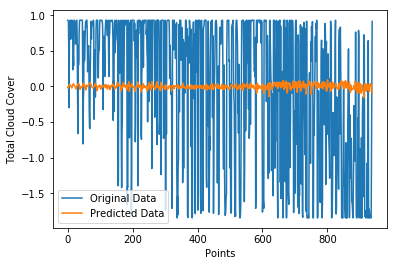

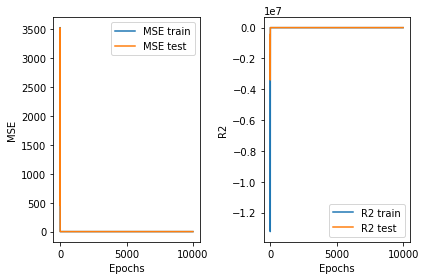

In [26]:
with tf.Session() as sess:
    # Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #saver.restore(sess,'yahoo_dataset.ckpt')
    c_t = []
    c_test = []
    r2_t = []
    r2_test = []
    for i in range(10000):
        #for j in range(Xn_train.shape[0]):
        #    sess.run([cost,train],feed_dict=    {xs:Xn_train[j,:].reshape(1,npred), ys:yn_train[j]})
        #    # Run cost and train with each sample
        
        sess.run([cost,train],feed_dict=    {xs:Xn_train, ys:yn_train})
        
        c_t.append(sess.run(cost, feed_dict={xs:Xn_train,ys:yn_train}))
        c_test.append(sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'Cost train:',c_t[-1], 'Cost test:',c_test[-1])
        r2_t.append(sess.run(R_squared, feed_dict={xs:Xn_train,ys:yn_train}))
        r2_test.append(sess.run(R_squared, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'R2 train:',r2_t[-1], 'R2 test:',r2_test[-1])
    
    pred = sess.run(output, feed_dict={xs:Xn_test})
    # predict output of test data after training
    print('Cost :',sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
    #y_test = denormalize(df_test,y_test)
    #pred = denormalize(df_test,pred)
    #Denormalize data

    
    
    plt.plot(range(yn_test.shape[0]),yn_test,label="Original Data")
    plt.plot(range(yn_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    plt.ylabel('Total Cloud Cover')
    plt.xlabel('Points')
    #plt.title('Total Cloud Cover')
    plt.savefig('results/data_t0_2layers_10_10_split03.png')
    plt.show()
    
    
    plt.subplot(1,2,1)
    plt.plot(range(len(c_t)), c_t,label="MSE train")
    plt.plot(range(len(c_test)), c_test,label="MSE test")
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    #plt.title('Cost vs. epochs')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(r2_t)), r2_t,label="R2 train")
    plt.plot(range(len(r2_test)), r2_test,label="R2 test")
    plt.legend(loc='best')
    plt.ylabel('R2')
    plt.xlabel('Epochs')
    #plt.title('R2 vs. epochs')
    plt.tight_layout()
    plt.savefig('results/t0_2layers_10_10_split03.png')
    plt.show()
    

Train split size = 0.2
Activation = sigmoid
nodes, 100, 150
lambda = 0.001
Epochs = 10000
Only t0
old function

Epoch : 0 Cost train: 30.6755 Cost test: 31.028246
Epoch : 0 R2 train: -115283.69 R2 test: -29955.234
Epoch : 1 Cost train: 21.203856 Cost test: 21.480696
Epoch : 1 R2 train: -79711.05 R2 test: -20737.953
Epoch : 2 Cost train: 15.062578 Cost test: 15.276224
Epoch : 2 R2 train: -56642.688 R2 test: -14747.597
Epoch : 3 Cost train: 11.081819 Cost test: 11.2390995
Epoch : 3 R2 train: -41673.805 R2 test: -10850.141
Epoch : 4 Cost train: 8.49138 Cost test: 8.605864
Epoch : 4 R2 train: -31936.166 R2 test: -8307.862
Epoch : 5 Cost train: 6.800246 Cost test: 6.8808274
Epoch : 5 R2 train: -25580.238 R2 test: -6642.1577
Epoch : 6 Cost train: 5.6902285 Cost test: 5.742657
Epoch : 6 R2 train: -21405.025 R2 test: -5543.47
Epoch : 7 Cost train: 4.9550714 Cost test: 4.984696
Epoch : 7 R2 train: -18638.326 R2 test: -4811.4067
Epoch : 8 Cost train: 4.4602656 Cost test: 4.472202
Epoch : 8 R2 train: -16779.969 R2 test: -4316.8086
Epoch : 9 Cost train: 4.122467 Cost test: 4.1194844
Epoch : 9 R2 train: -155

Epoch : 79 Cost train: 2.067785 Cost test: 1.9538183
Epoch : 79 R2 train: -7777.405 R2 test: -1885.3413
Epoch : 80 Cost train: 2.0614722 Cost test: 1.9472848
Epoch : 80 R2 train: -7752.511 R2 test: -1879.0231
Epoch : 81 Cost train: 2.0548432 Cost test: 1.9408723
Epoch : 81 R2 train: -7728.1367 R2 test: -1872.8511
Epoch : 82 Cost train: 2.0485444 Cost test: 1.9346431
Epoch : 82 R2 train: -7703.8804 R2 test: -1866.8137
Epoch : 83 Cost train: 2.0421817 Cost test: 1.9284893
Epoch : 83 R2 train: -7680.7305 R2 test: -1860.9075
Epoch : 84 Cost train: 2.0359795 Cost test: 1.922549
Epoch : 84 R2 train: -7657.451 R2 test: -1855.1346
Epoch : 85 Cost train: 2.0298305 Cost test: 1.9166789
Epoch : 85 R2 train: -7635.036 R2 test: -1849.486
Epoch : 86 Cost train: 2.0238943 Cost test: 1.910966
Epoch : 86 R2 train: -7613.1123 R2 test: -1843.9608
Epoch : 87 Cost train: 2.0179818 Cost test: 1.9053296
Epoch : 87 R2 train: -7591.354 R2 test: -1838.5444
Epoch : 88 Cost train: 2.0122824 Cost test: 1.8998916
E

Epoch : 156 Cost train: 1.7675827 Cost test: 1.6722101
Epoch : 156 R2 train: -6650.0747 R2 test: -1613.4406
Epoch : 157 Cost train: 1.7651285 Cost test: 1.6699761
Epoch : 157 R2 train: -6640.848 R2 test: -1611.295
Epoch : 158 Cost train: 1.7626225 Cost test: 1.6677971
Epoch : 158 R2 train: -6631.2686 R2 test: -1609.165
Epoch : 159 Cost train: 1.7603459 Cost test: 1.6655791
Epoch : 159 R2 train: -6621.998 R2 test: -1607.0585
Epoch : 160 Cost train: 1.7579669 Cost test: 1.6633962
Epoch : 160 R2 train: -6612.66 R2 test: -1604.9509
Epoch : 161 Cost train: 1.7555128 Cost test: 1.6612216
Epoch : 161 R2 train: -6603.533 R2 test: -1602.8741
Epoch : 162 Cost train: 1.7531216 Cost test: 1.6591325
Epoch : 162 R2 train: -6594.5283 R2 test: -1600.8062
Epoch : 163 Cost train: 1.7507235 Cost test: 1.6570094
Epoch : 163 R2 train: -6585.6797 R2 test: -1598.7456
Epoch : 164 Cost train: 1.7483796 Cost test: 1.6548792
Epoch : 164 R2 train: -6576.7754 R2 test: -1596.7157
Epoch : 165 Cost train: 1.7459961 C

Epoch : 233 Cost train: 1.6123215 Cost test: 1.5356005
Epoch : 233 R2 train: -6065.888 R2 test: -1481.571
Epoch : 234 Cost train: 1.6106443 Cost test: 1.5341531
Epoch : 234 R2 train: -6059.752 R2 test: -1480.1694
Epoch : 235 Cost train: 1.6090529 Cost test: 1.5327463
Epoch : 235 R2 train: -6053.6626 R2 test: -1478.7911
Epoch : 236 Cost train: 1.6073413 Cost test: 1.5312954
Epoch : 236 R2 train: -6047.485 R2 test: -1477.404
Epoch : 237 Cost train: 1.6056789 Cost test: 1.5298697
Epoch : 237 R2 train: -6041.2925 R2 test: -1476.0275
Epoch : 238 Cost train: 1.6040982 Cost test: 1.5284392
Epoch : 238 R2 train: -6035.0996 R2 test: -1474.6522
Epoch : 239 Cost train: 1.6024811 Cost test: 1.5270375
Epoch : 239 R2 train: -6028.9814 R2 test: -1473.2867
Epoch : 240 Cost train: 1.600899 Cost test: 1.5256331
Epoch : 240 R2 train: -6022.7993 R2 test: -1471.9246
Epoch : 241 Cost train: 1.5993589 Cost test: 1.5242393
Epoch : 241 R2 train: -6016.8203 R2 test: -1470.5847
Epoch : 242 Cost train: 1.5977108 

Epoch : 310 Cost train: 1.5027677 Cost test: 1.4398849
Epoch : 310 R2 train: -5652.0015 R2 test: -1389.1383
Epoch : 311 Cost train: 1.501597 Cost test: 1.4388032
Epoch : 311 R2 train: -5647.4746 R2 test: -1388.1033
Epoch : 312 Cost train: 1.5003095 Cost test: 1.437771
Epoch : 312 R2 train: -5642.934 R2 test: -1387.0768
Epoch : 313 Cost train: 1.4990935 Cost test: 1.436698
Epoch : 313 R2 train: -5638.3994 R2 test: -1386.0607
Epoch : 314 Cost train: 1.4978701 Cost test: 1.4356188
Epoch : 314 R2 train: -5633.8545 R2 test: -1385.036
Epoch : 315 Cost train: 1.4965324 Cost test: 1.4345733
Epoch : 315 R2 train: -5629.2114 R2 test: -1384.0205
Epoch : 316 Cost train: 1.4952815 Cost test: 1.4335084
Epoch : 316 R2 train: -5624.726 R2 test: -1383.0148
Epoch : 317 Cost train: 1.4940726 Cost test: 1.4324758
Epoch : 317 R2 train: -5620.2686 R2 test: -1382.01
Epoch : 318 Cost train: 1.4929361 Cost test: 1.4314545
Epoch : 318 R2 train: -5615.8643 R2 test: -1381.003
Epoch : 319 Cost train: 1.4917883 Cos

Epoch : 387 Cost train: 1.4204047 Cost test: 1.3679866
Epoch : 387 R2 train: -5342.029 R2 test: -1319.7366
Epoch : 388 Cost train: 1.4194596 Cost test: 1.3671529
Epoch : 388 R2 train: -5338.44 R2 test: -1318.951
Epoch : 389 Cost train: 1.4184844 Cost test: 1.3663653
Epoch : 389 R2 train: -5335.0264 R2 test: -1318.1772
Epoch : 390 Cost train: 1.4175043 Cost test: 1.3655572
Epoch : 390 R2 train: -5331.594 R2 test: -1317.3988
Epoch : 391 Cost train: 1.4166344 Cost test: 1.364745
Epoch : 391 R2 train: -5328.081 R2 test: -1316.6177
Epoch : 392 Cost train: 1.4157896 Cost test: 1.3639382
Epoch : 392 R2 train: -5324.7217 R2 test: -1315.8514
Epoch : 393 Cost train: 1.4148091 Cost test: 1.3631384
Epoch : 393 R2 train: -5321.3174 R2 test: -1315.0778
Epoch : 394 Cost train: 1.4139355 Cost test: 1.3623545
Epoch : 394 R2 train: -5317.981 R2 test: -1314.3125
Epoch : 395 Cost train: 1.4130434 Cost test: 1.3615705
Epoch : 395 R2 train: -5314.5176 R2 test: -1313.544
Epoch : 396 Cost train: 1.4121487 Cos

Epoch : 464 Cost train: 1.3577644 Cost test: 1.3129152
Epoch : 464 R2 train: -5105.7124 R2 test: -1266.5681
Epoch : 465 Cost train: 1.357054 Cost test: 1.3122826
Epoch : 465 R2 train: -5103.1196 R2 test: -1265.965
Epoch : 466 Cost train: 1.3563578 Cost test: 1.3116547
Epoch : 466 R2 train: -5100.463 R2 test: -1265.3646
Epoch : 467 Cost train: 1.3556488 Cost test: 1.3110402
Epoch : 467 R2 train: -5097.798 R2 test: -1264.7606
Epoch : 468 Cost train: 1.3549819 Cost test: 1.3104194
Epoch : 468 R2 train: -5095.1904 R2 test: -1264.1543
Epoch : 469 Cost train: 1.3542689 Cost test: 1.3098108
Epoch : 469 R2 train: -5092.5835 R2 test: -1263.5602
Epoch : 470 Cost train: 1.3535559 Cost test: 1.3092086
Epoch : 470 R2 train: -5089.89 R2 test: -1262.971
Epoch : 471 Cost train: 1.3528525 Cost test: 1.3085845
Epoch : 471 R2 train: -5087.25 R2 test: -1262.3817
Epoch : 472 Cost train: 1.352147 Cost test: 1.3079433
Epoch : 472 R2 train: -5084.55 R2 test: -1261.7876
Epoch : 473 Cost train: 1.3514864 Cost t

Epoch : 541 Cost train: 1.309257 Cost test: 1.2701831
Epoch : 541 R2 train: -4923.2104 R2 test: -1225.2915
Epoch : 542 Cost train: 1.3086938 Cost test: 1.2696984
Epoch : 542 R2 train: -4921.1924 R2 test: -1224.8203
Epoch : 543 Cost train: 1.3081403 Cost test: 1.2692081
Epoch : 543 R2 train: -4919.1167 R2 test: -1224.3511
Epoch : 544 Cost train: 1.3075933 Cost test: 1.2687341
Epoch : 544 R2 train: -4917.0723 R2 test: -1223.8813
Epoch : 545 Cost train: 1.3070374 Cost test: 1.2682307
Epoch : 545 R2 train: -4915.063 R2 test: -1223.4142
Epoch : 546 Cost train: 1.3064725 Cost test: 1.2677515
Epoch : 546 R2 train: -4912.9253 R2 test: -1222.9457
Epoch : 547 Cost train: 1.3059454 Cost test: 1.2672709
Epoch : 547 R2 train: -4910.882 R2 test: -1222.4828
Epoch : 548 Cost train: 1.3054324 Cost test: 1.2667824
Epoch : 548 R2 train: -4908.816 R2 test: -1222.0203
Epoch : 549 Cost train: 1.3048794 Cost test: 1.2663063
Epoch : 549 R2 train: -4906.802 R2 test: -1221.5581
Epoch : 550 Cost train: 1.3043586

Epoch : 618 Cost train: 1.2716479 Cost test: 1.2365429
Epoch : 618 R2 train: -4781.217 R2 test: -1192.8424
Epoch : 619 Cost train: 1.2711962 Cost test: 1.236151
Epoch : 619 R2 train: -4779.606 R2 test: -1192.4641
Epoch : 620 Cost train: 1.2707487 Cost test: 1.2357693
Epoch : 620 R2 train: -4777.944 R2 test: -1192.097
Epoch : 621 Cost train: 1.2702947 Cost test: 1.2353828
Epoch : 621 R2 train: -4776.38 R2 test: -1191.7216
Epoch : 622 Cost train: 1.2698532 Cost test: 1.235
Epoch : 622 R2 train: -4774.773 R2 test: -1191.351
Epoch : 623 Cost train: 1.2694546 Cost test: 1.2346326
Epoch : 623 R2 train: -4773.1143 R2 test: -1190.9802
Epoch : 624 Cost train: 1.2689887 Cost test: 1.2342323
Epoch : 624 R2 train: -4771.52 R2 test: -1190.6171
Epoch : 625 Cost train: 1.2685902 Cost test: 1.2338502
Epoch : 625 R2 train: -4769.826 R2 test: -1190.2476
Epoch : 626 Cost train: 1.2681549 Cost test: 1.2334764
Epoch : 626 R2 train: -4768.2793 R2 test: -1189.877
Epoch : 627 Cost train: 1.2677158 Cost test: 

Epoch : 695 Cost train: 1.2417668 Cost test: 1.2097399
Epoch : 695 R2 train: -4668.7114 R2 test: -1166.9662
Epoch : 696 Cost train: 1.2413998 Cost test: 1.2094237
Epoch : 696 R2 train: -4667.3564 R2 test: -1166.6626
Epoch : 697 Cost train: 1.2410173 Cost test: 1.2091129
Epoch : 697 R2 train: -4665.9834 R2 test: -1166.3666
Epoch : 698 Cost train: 1.2407075 Cost test: 1.208807
Epoch : 698 R2 train: -4664.7515 R2 test: -1166.0618
Epoch : 699 Cost train: 1.2403969 Cost test: 1.2085015
Epoch : 699 R2 train: -4663.4697 R2 test: -1165.7675
Epoch : 700 Cost train: 1.2400367 Cost test: 1.2082042
Epoch : 700 R2 train: -4662.153 R2 test: -1165.4739
Epoch : 701 Cost train: 1.2396704 Cost test: 1.2078829
Epoch : 701 R2 train: -4660.8335 R2 test: -1165.1713
Epoch : 702 Cost train: 1.2393082 Cost test: 1.2075841
Epoch : 702 R2 train: -4659.527 R2 test: -1164.8741
Epoch : 703 Cost train: 1.2389671 Cost test: 1.207288
Epoch : 703 R2 train: -4658.3145 R2 test: -1164.5775
Epoch : 704 Cost train: 1.238632

Epoch : 772 Cost train: 1.2179209 Cost test: 1.1880702
Epoch : 772 R2 train: -4578.567 R2 test: -1146.0271
Epoch : 773 Cost train: 1.2176238 Cost test: 1.1878117
Epoch : 773 R2 train: -4577.559 R2 test: -1145.782
Epoch : 774 Cost train: 1.2173423 Cost test: 1.1875521
Epoch : 774 R2 train: -4576.4795 R2 test: -1145.5386
Epoch : 775 Cost train: 1.2170645 Cost test: 1.1872932
Epoch : 775 R2 train: -4575.3975 R2 test: -1145.2921
Epoch : 776 Cost train: 1.2168072 Cost test: 1.1870469
Epoch : 776 R2 train: -4574.3696 R2 test: -1145.0522
Epoch : 777 Cost train: 1.2165203 Cost test: 1.1867954
Epoch : 777 R2 train: -4573.3955 R2 test: -1144.8052
Epoch : 778 Cost train: 1.2162627 Cost test: 1.1865456
Epoch : 778 R2 train: -4572.363 R2 test: -1144.5658
Epoch : 779 Cost train: 1.2159739 Cost test: 1.1863025
Epoch : 779 R2 train: -4571.323 R2 test: -1144.3312
Epoch : 780 Cost train: 1.2157282 Cost test: 1.1860493
Epoch : 780 R2 train: -4570.3325 R2 test: -1144.091
Epoch : 781 Cost train: 1.2154131 

Epoch : 849 Cost train: 1.1983922 Cost test: 1.1702926
Epoch : 849 R2 train: -4505.2725 R2 test: -1128.8552
Epoch : 850 Cost train: 1.1981618 Cost test: 1.1700764
Epoch : 850 R2 train: -4504.4263 R2 test: -1128.6497
Epoch : 851 Cost train: 1.1979306 Cost test: 1.1698755
Epoch : 851 R2 train: -4503.561 R2 test: -1128.4503
Epoch : 852 Cost train: 1.1977158 Cost test: 1.1696634
Epoch : 852 R2 train: -4502.832 R2 test: -1128.2532
Epoch : 853 Cost train: 1.1974761 Cost test: 1.169459
Epoch : 853 R2 train: -4502.0225 R2 test: -1128.0475
Epoch : 854 Cost train: 1.1972693 Cost test: 1.1692497
Epoch : 854 R2 train: -4501.163 R2 test: -1127.8434
Epoch : 855 Cost train: 1.1969978 Cost test: 1.1690323
Epoch : 855 R2 train: -4500.3325 R2 test: -1127.6434
Epoch : 856 Cost train: 1.1967578 Cost test: 1.1688195
Epoch : 856 R2 train: -4499.449 R2 test: -1127.4432
Epoch : 857 Cost train: 1.1965656 Cost test: 1.1685996
Epoch : 857 R2 train: -4498.5522 R2 test: -1127.2412
Epoch : 858 Cost train: 1.1963378

Epoch : 926 Cost train: 1.1823891 Cost test: 1.1554549
Epoch : 926 R2 train: -4445.125 R2 test: -1114.5593
Epoch : 927 Cost train: 1.1821702 Cost test: 1.1552908
Epoch : 927 R2 train: -4444.437 R2 test: -1114.389
Epoch : 928 Cost train: 1.1819774 Cost test: 1.1551174
Epoch : 928 R2 train: -4443.7407 R2 test: -1114.2212
Epoch : 929 Cost train: 1.1817739 Cost test: 1.1549348
Epoch : 929 R2 train: -4442.9385 R2 test: -1114.0543
Epoch : 930 Cost train: 1.181608 Cost test: 1.1547644
Epoch : 930 R2 train: -4442.2417 R2 test: -1113.8844
Epoch : 931 Cost train: 1.181427 Cost test: 1.1545905
Epoch : 931 R2 train: -4441.533 R2 test: -1113.7164
Epoch : 932 Cost train: 1.1812352 Cost test: 1.1544174
Epoch : 932 R2 train: -4440.7686 R2 test: -1113.5509
Epoch : 933 Cost train: 1.1810472 Cost test: 1.1542429
Epoch : 933 R2 train: -4440.063 R2 test: -1113.3843
Epoch : 934 Cost train: 1.1808538 Cost test: 1.1540842
Epoch : 934 R2 train: -4439.368 R2 test: -1113.2147
Epoch : 935 Cost train: 1.1806725 Co

Epoch : 1003 Cost train: 1.1689583 Cost test: 1.1430118
Epoch : 1003 R2 train: -4394.8447 R2 test: -1102.5166
Epoch : 1004 Cost train: 1.1687839 Cost test: 1.1428614
Epoch : 1004 R2 train: -4394.242 R2 test: -1102.375
Epoch : 1005 Cost train: 1.1686304 Cost test: 1.1427176
Epoch : 1005 R2 train: -4393.5767 R2 test: -1102.23
Epoch : 1006 Cost train: 1.1684372 Cost test: 1.1425699
Epoch : 1006 R2 train: -4393.0015 R2 test: -1102.0875
Epoch : 1007 Cost train: 1.1682866 Cost test: 1.1424109
Epoch : 1007 R2 train: -4392.4487 R2 test: -1101.9464
Epoch : 1008 Cost train: 1.1681318 Cost test: 1.1422578
Epoch : 1008 R2 train: -4391.8076 R2 test: -1101.8047
Epoch : 1009 Cost train: 1.1679438 Cost test: 1.1421082
Epoch : 1009 R2 train: -4391.2344 R2 test: -1101.6621
Epoch : 1010 Cost train: 1.1678135 Cost test: 1.1419637
Epoch : 1010 R2 train: -4390.6226 R2 test: -1101.5162
Epoch : 1011 Cost train: 1.1676608 Cost test: 1.141814
Epoch : 1011 R2 train: -4390.0615 R2 test: -1101.3684
Epoch : 1012 Co

Epoch : 1078 Cost train: 1.1579399 Cost test: 1.1326027
Epoch : 1078 R2 train: -4353.3325 R2 test: -1092.4886
Epoch : 1079 Cost train: 1.1578201 Cost test: 1.1324689
Epoch : 1079 R2 train: -4352.8477 R2 test: -1092.365
Epoch : 1080 Cost train: 1.1576806 Cost test: 1.1323508
Epoch : 1080 R2 train: -4352.2856 R2 test: -1092.2416
Epoch : 1081 Cost train: 1.157539 Cost test: 1.1322112
Epoch : 1081 R2 train: -4351.778 R2 test: -1092.1196
Epoch : 1082 Cost train: 1.157418 Cost test: 1.132094
Epoch : 1082 R2 train: -4351.3003 R2 test: -1091.9963
Epoch : 1083 Cost train: 1.1572733 Cost test: 1.1319708
Epoch : 1083 R2 train: -4350.7505 R2 test: -1091.8704
Epoch : 1084 Cost train: 1.1571274 Cost test: 1.1318368
Epoch : 1084 R2 train: -4350.307 R2 test: -1091.7533
Epoch : 1085 Cost train: 1.1570178 Cost test: 1.1317197
Epoch : 1085 R2 train: -4349.861 R2 test: -1091.6265
Epoch : 1086 Cost train: 1.1569055 Cost test: 1.1315835
Epoch : 1086 R2 train: -4349.332 R2 test: -1091.5029
Epoch : 1087 Cost 

Epoch : 1154 Cost train: 1.1483791 Cost test: 1.1235101
Epoch : 1154 R2 train: -4317.3447 R2 test: -1083.6975
Epoch : 1155 Cost train: 1.1482764 Cost test: 1.1234076
Epoch : 1155 R2 train: -4316.867 R2 test: -1083.5901
Epoch : 1156 Cost train: 1.1481811 Cost test: 1.1232896
Epoch : 1156 R2 train: -4316.4287 R2 test: -1083.4834
Epoch : 1157 Cost train: 1.1480589 Cost test: 1.123179
Epoch : 1157 R2 train: -4315.996 R2 test: -1083.3793
Epoch : 1158 Cost train: 1.1479315 Cost test: 1.1230605
Epoch : 1158 R2 train: -4315.544 R2 test: -1083.2708
Epoch : 1159 Cost train: 1.1478372 Cost test: 1.1229491
Epoch : 1159 R2 train: -4315.1475 R2 test: -1083.1613
Epoch : 1160 Cost train: 1.14775 Cost test: 1.1228426
Epoch : 1160 R2 train: -4314.6685 R2 test: -1083.0568
Epoch : 1161 Cost train: 1.147647 Cost test: 1.1227225
Epoch : 1161 R2 train: -4314.225 R2 test: -1082.9517
Epoch : 1162 Cost train: 1.1475351 Cost test: 1.1226208
Epoch : 1162 R2 train: -4313.776 R2 test: -1082.8436
Epoch : 1163 Cost t

Epoch : 1230 Cost train: 1.1401932 Cost test: 1.1155657
Epoch : 1230 R2 train: -4286.275 R2 test: -1076.0261
Epoch : 1231 Cost train: 1.1400849 Cost test: 1.1154654
Epoch : 1231 R2 train: -4285.8545 R2 test: -1075.9347
Epoch : 1232 Cost train: 1.1399856 Cost test: 1.1153646
Epoch : 1232 R2 train: -4285.4688 R2 test: -1075.8397
Epoch : 1233 Cost train: 1.1398684 Cost test: 1.115261
Epoch : 1233 R2 train: -4285.0854 R2 test: -1075.7471
Epoch : 1234 Cost train: 1.1397365 Cost test: 1.1151727
Epoch : 1234 R2 train: -4284.69 R2 test: -1075.6526
Epoch : 1235 Cost train: 1.1396351 Cost test: 1.1150701
Epoch : 1235 R2 train: -4284.304 R2 test: -1075.554
Epoch : 1236 Cost train: 1.1395303 Cost test: 1.1149819
Epoch : 1236 R2 train: -4283.896 R2 test: -1075.4587
Epoch : 1237 Cost train: 1.1394295 Cost test: 1.1148751
Epoch : 1237 R2 train: -4283.5356 R2 test: -1075.3629
Epoch : 1238 Cost train: 1.1393294 Cost test: 1.1147808
Epoch : 1238 R2 train: -4283.164 R2 test: -1075.2704
Epoch : 1239 Cost 

Epoch : 1306 Cost train: 1.1329861 Cost test: 1.1085618
Epoch : 1306 R2 train: -4259.2734 R2 test: -1069.2682
Epoch : 1307 Cost train: 1.1329031 Cost test: 1.108479
Epoch : 1307 R2 train: -4258.9087 R2 test: -1069.184
Epoch : 1308 Cost train: 1.1328136 Cost test: 1.1083906
Epoch : 1308 R2 train: -4258.5933 R2 test: -1069.1013
Epoch : 1309 Cost train: 1.1327468 Cost test: 1.108297
Epoch : 1309 R2 train: -4258.2373 R2 test: -1069.0164
Epoch : 1310 Cost train: 1.1326448 Cost test: 1.1082141
Epoch : 1310 R2 train: -4257.899 R2 test: -1068.9316
Epoch : 1311 Cost train: 1.1325622 Cost test: 1.1081277
Epoch : 1311 R2 train: -4257.5566 R2 test: -1068.8502
Epoch : 1312 Cost train: 1.1324697 Cost test: 1.1080496
Epoch : 1312 R2 train: -4257.2427 R2 test: -1068.7673
Epoch : 1313 Cost train: 1.1323817 Cost test: 1.107952
Epoch : 1313 R2 train: -4256.926 R2 test: -1068.6826
Epoch : 1314 Cost train: 1.1323094 Cost test: 1.1078606
Epoch : 1314 R2 train: -4256.6035 R2 test: -1068.5988
Epoch : 1315 Cos

Epoch : 1382 Cost train: 1.1266514 Cost test: 1.1023438
Epoch : 1382 R2 train: -4235.2065 R2 test: -1063.2612
Epoch : 1383 Cost train: 1.1265905 Cost test: 1.102263
Epoch : 1383 R2 train: -4234.912 R2 test: -1063.1884
Epoch : 1384 Cost train: 1.1265389 Cost test: 1.1021754
Epoch : 1384 R2 train: -4234.627 R2 test: -1063.115
Epoch : 1385 Cost train: 1.1264812 Cost test: 1.1020981
Epoch : 1385 R2 train: -4234.3384 R2 test: -1063.0403
Epoch : 1386 Cost train: 1.1264112 Cost test: 1.1020184
Epoch : 1386 R2 train: -4234.0654 R2 test: -1062.9636
Epoch : 1387 Cost train: 1.1263291 Cost test: 1.1019362
Epoch : 1387 R2 train: -4233.8125 R2 test: -1062.8928
Epoch : 1388 Cost train: 1.1262478 Cost test: 1.1018636
Epoch : 1388 R2 train: -4233.5083 R2 test: -1062.8162
Epoch : 1389 Cost train: 1.1261839 Cost test: 1.1017876
Epoch : 1389 R2 train: -4233.198 R2 test: -1062.7472
Epoch : 1390 Cost train: 1.1261057 Cost test: 1.1017144
Epoch : 1390 R2 train: -4232.885 R2 test: -1062.6742
Epoch : 1391 Cos

Epoch : 1458 Cost train: 1.1210542 Cost test: 1.0967679
Epoch : 1458 R2 train: -4214.149 R2 test: -1057.8893
Epoch : 1459 Cost train: 1.1209896 Cost test: 1.0966958
Epoch : 1459 R2 train: -4213.9004 R2 test: -1057.8247
Epoch : 1460 Cost train: 1.1209193 Cost test: 1.0966226
Epoch : 1460 R2 train: -4213.6177 R2 test: -1057.756
Epoch : 1461 Cost train: 1.1208565 Cost test: 1.0965618
Epoch : 1461 R2 train: -4213.3203 R2 test: -1057.6885
Epoch : 1462 Cost train: 1.1207968 Cost test: 1.0964909
Epoch : 1462 R2 train: -4213.0806 R2 test: -1057.6232
Epoch : 1463 Cost train: 1.1207291 Cost test: 1.0964305
Epoch : 1463 R2 train: -4212.825 R2 test: -1057.5568
Epoch : 1464 Cost train: 1.1206611 Cost test: 1.0963705
Epoch : 1464 R2 train: -4212.528 R2 test: -1057.4905
Epoch : 1465 Cost train: 1.1205919 Cost test: 1.0963035
Epoch : 1465 R2 train: -4212.27 R2 test: -1057.4205
Epoch : 1466 Cost train: 1.1205212 Cost test: 1.0962346
Epoch : 1466 R2 train: -4212.0195 R2 test: -1057.3553
Epoch : 1467 Cos

Epoch : 1534 Cost train: 1.1160283 Cost test: 1.0917699
Epoch : 1534 R2 train: -4195.2285 R2 test: -1053.0488
Epoch : 1535 Cost train: 1.1159638 Cost test: 1.0917064
Epoch : 1535 R2 train: -4194.9614 R2 test: -1052.9907
Epoch : 1536 Cost train: 1.115898 Cost test: 1.0916382
Epoch : 1536 R2 train: -4194.7715 R2 test: -1052.9292
Epoch : 1537 Cost train: 1.1158395 Cost test: 1.0915768
Epoch : 1537 R2 train: -4194.5615 R2 test: -1052.8712
Epoch : 1538 Cost train: 1.1157775 Cost test: 1.0915122
Epoch : 1538 R2 train: -4194.291 R2 test: -1052.8096
Epoch : 1539 Cost train: 1.1157265 Cost test: 1.0914587
Epoch : 1539 R2 train: -4194.069 R2 test: -1052.7468
Epoch : 1540 Cost train: 1.1156707 Cost test: 1.091392
Epoch : 1540 R2 train: -4193.852 R2 test: -1052.6873
Epoch : 1541 Cost train: 1.1155835 Cost test: 1.0913247
Epoch : 1541 R2 train: -4193.6167 R2 test: -1052.6283
Epoch : 1542 Cost train: 1.1155189 Cost test: 1.091268
Epoch : 1542 R2 train: -4193.4136 R2 test: -1052.5704
Epoch : 1543 Cos

Epoch : 1609 Cost train: 1.1116657 Cost test: 1.087271
Epoch : 1609 R2 train: -4178.2407 R2 test: -1048.7185
Epoch : 1610 Cost train: 1.1116117 Cost test: 1.0872073
Epoch : 1610 R2 train: -4178.0347 R2 test: -1048.6605
Epoch : 1611 Cost train: 1.1115592 Cost test: 1.087152
Epoch : 1611 R2 train: -4177.816 R2 test: -1048.6069
Epoch : 1612 Cost train: 1.1115085 Cost test: 1.087097
Epoch : 1612 R2 train: -4177.6167 R2 test: -1048.5553
Epoch : 1613 Cost train: 1.1114464 Cost test: 1.0870465
Epoch : 1613 R2 train: -4177.391 R2 test: -1048.4979
Epoch : 1614 Cost train: 1.1113873 Cost test: 1.0869924
Epoch : 1614 R2 train: -4177.209 R2 test: -1048.4478
Epoch : 1615 Cost train: 1.1113273 Cost test: 1.0869433
Epoch : 1615 R2 train: -4177.017 R2 test: -1048.3912
Epoch : 1616 Cost train: 1.1112868 Cost test: 1.0868868
Epoch : 1616 R2 train: -4176.7817 R2 test: -1048.3372
Epoch : 1617 Cost train: 1.1112418 Cost test: 1.0868254
Epoch : 1617 R2 train: -4176.5684 R2 test: -1048.2795
Epoch : 1618 Cost

Epoch : 1685 Cost train: 1.1075599 Cost test: 1.0831213
Epoch : 1685 R2 train: -4162.903 R2 test: -1044.7162
Epoch : 1686 Cost train: 1.1075208 Cost test: 1.0830746
Epoch : 1686 R2 train: -4162.6924 R2 test: -1044.6664
Epoch : 1687 Cost train: 1.1074629 Cost test: 1.0830213
Epoch : 1687 R2 train: -4162.474 R2 test: -1044.6184
Epoch : 1688 Cost train: 1.1074301 Cost test: 1.0829701
Epoch : 1688 R2 train: -4162.2593 R2 test: -1044.5674
Epoch : 1689 Cost train: 1.1073903 Cost test: 1.0829177
Epoch : 1689 R2 train: -4162.0864 R2 test: -1044.5131
Epoch : 1690 Cost train: 1.1073364 Cost test: 1.0828642
Epoch : 1690 R2 train: -4161.9043 R2 test: -1044.4652
Epoch : 1691 Cost train: 1.1073065 Cost test: 1.0828093
Epoch : 1691 R2 train: -4161.7397 R2 test: -1044.419
Epoch : 1692 Cost train: 1.1072547 Cost test: 1.0827533
Epoch : 1692 R2 train: -4161.5557 R2 test: -1044.3661
Epoch : 1693 Cost train: 1.1072168 Cost test: 1.0827003
Epoch : 1693 R2 train: -4161.384 R2 test: -1044.3135
Epoch : 1694 C

Epoch : 1761 Cost train: 1.1038592 Cost test: 1.0793333
Epoch : 1761 R2 train: -4148.9053 R2 test: -1041.0479
Epoch : 1762 Cost train: 1.1038047 Cost test: 1.0792876
Epoch : 1762 R2 train: -4148.7295 R2 test: -1041.004
Epoch : 1763 Cost train: 1.1037698 Cost test: 1.079241
Epoch : 1763 R2 train: -4148.526 R2 test: -1040.958
Epoch : 1764 Cost train: 1.1037298 Cost test: 1.079191
Epoch : 1764 R2 train: -4148.3604 R2 test: -1040.9122
Epoch : 1765 Cost train: 1.1036826 Cost test: 1.0791442
Epoch : 1765 R2 train: -4148.1836 R2 test: -1040.868
Epoch : 1766 Cost train: 1.1036249 Cost test: 1.0790894
Epoch : 1766 R2 train: -4147.9697 R2 test: -1040.8167
Epoch : 1767 Cost train: 1.1035804 Cost test: 1.0790391
Epoch : 1767 R2 train: -4147.8237 R2 test: -1040.7684
Epoch : 1768 Cost train: 1.1035376 Cost test: 1.078985
Epoch : 1768 R2 train: -4147.64 R2 test: -1040.7245
Epoch : 1769 Cost train: 1.1035023 Cost test: 1.0789362
Epoch : 1769 R2 train: -4147.4746 R2 test: -1040.6759
Epoch : 1770 Cost t

Epoch : 1837 Cost train: 1.1004514 Cost test: 1.0758517
Epoch : 1837 R2 train: -4136.0264 R2 test: -1037.6748
Epoch : 1838 Cost train: 1.1004094 Cost test: 1.0758109
Epoch : 1838 R2 train: -4135.8647 R2 test: -1037.6321
Epoch : 1839 Cost train: 1.100373 Cost test: 1.0757647
Epoch : 1839 R2 train: -4135.7095 R2 test: -1037.5887
Epoch : 1840 Cost train: 1.100339 Cost test: 1.0757183
Epoch : 1840 R2 train: -4135.5415 R2 test: -1037.5461
Epoch : 1841 Cost train: 1.1002897 Cost test: 1.0756689
Epoch : 1841 R2 train: -4135.4023 R2 test: -1037.5035
Epoch : 1842 Cost train: 1.1002594 Cost test: 1.075624
Epoch : 1842 R2 train: -4135.2407 R2 test: -1037.4613
Epoch : 1843 Cost train: 1.1002201 Cost test: 1.0755877
Epoch : 1843 R2 train: -4135.0903 R2 test: -1037.4183
Epoch : 1844 Cost train: 1.1001723 Cost test: 1.0755407
Epoch : 1844 R2 train: -4134.89 R2 test: -1037.3778
Epoch : 1845 Cost train: 1.1001112 Cost test: 1.0754883
Epoch : 1845 R2 train: -4134.747 R2 test: -1037.335
Epoch : 1846 Cost

Epoch : 1912 Cost train: 1.0973632 Cost test: 1.0726433
Epoch : 1912 R2 train: -4124.331 R2 test: -1034.595
Epoch : 1913 Cost train: 1.0973189 Cost test: 1.0725992
Epoch : 1913 R2 train: -4124.147 R2 test: -1034.5558
Epoch : 1914 Cost train: 1.0972787 Cost test: 1.0725527
Epoch : 1914 R2 train: -4123.9907 R2 test: -1034.511
Epoch : 1915 Cost train: 1.0972373 Cost test: 1.0725175
Epoch : 1915 R2 train: -4123.847 R2 test: -1034.4734
Epoch : 1916 Cost train: 1.097182 Cost test: 1.0724787
Epoch : 1916 R2 train: -4123.679 R2 test: -1034.4346
Epoch : 1917 Cost train: 1.097146 Cost test: 1.0724313
Epoch : 1917 R2 train: -4123.5444 R2 test: -1034.3966
Epoch : 1918 Cost train: 1.0971147 Cost test: 1.0723994
Epoch : 1918 R2 train: -4123.3833 R2 test: -1034.3574
Epoch : 1919 Cost train: 1.0970638 Cost test: 1.072358
Epoch : 1919 R2 train: -4123.223 R2 test: -1034.3186
Epoch : 1920 Cost train: 1.0970359 Cost test: 1.0723141
Epoch : 1920 R2 train: -4123.095 R2 test: -1034.2784
Epoch : 1921 Cost tra

Epoch : 1988 Cost train: 1.094379 Cost test: 1.0696479
Epoch : 1988 R2 train: -4113.4663 R2 test: -1031.6993
Epoch : 1989 Cost train: 1.0943342 Cost test: 1.0696048
Epoch : 1989 R2 train: -4113.309 R2 test: -1031.6641
Epoch : 1990 Cost train: 1.0943068 Cost test: 1.0695703
Epoch : 1990 R2 train: -4113.171 R2 test: -1031.6263
Epoch : 1991 Cost train: 1.0942938 Cost test: 1.0695456
Epoch : 1991 R2 train: -4113.0186 R2 test: -1031.5859
Epoch : 1992 Cost train: 1.0942729 Cost test: 1.0695158
Epoch : 1992 R2 train: -4112.8926 R2 test: -1031.5493
Epoch : 1993 Cost train: 1.0942305 Cost test: 1.0694774
Epoch : 1993 R2 train: -4112.768 R2 test: -1031.512
Epoch : 1994 Cost train: 1.0941776 Cost test: 1.0694315
Epoch : 1994 R2 train: -4112.646 R2 test: -1031.4769
Epoch : 1995 Cost train: 1.0941565 Cost test: 1.0693939
Epoch : 1995 R2 train: -4112.5293 R2 test: -1031.4412
Epoch : 1996 Cost train: 1.094118 Cost test: 1.0693558
Epoch : 1996 R2 train: -4112.399 R2 test: -1031.4055
Epoch : 1997 Cost 

Epoch : 2064 Cost train: 1.0916352 Cost test: 1.0668563
Epoch : 2064 R2 train: -4103.336 R2 test: -1029.0051
Epoch : 2065 Cost train: 1.0916009 Cost test: 1.0668279
Epoch : 2065 R2 train: -4103.195 R2 test: -1028.9714
Epoch : 2066 Cost train: 1.0915624 Cost test: 1.0667883
Epoch : 2066 R2 train: -4103.067 R2 test: -1028.9371
Epoch : 2067 Cost train: 1.0915285 Cost test: 1.0667562
Epoch : 2067 R2 train: -4102.9414 R2 test: -1028.9012
Epoch : 2068 Cost train: 1.0914874 Cost test: 1.0667292
Epoch : 2068 R2 train: -4102.8027 R2 test: -1028.8705
Epoch : 2069 Cost train: 1.0914503 Cost test: 1.0666907
Epoch : 2069 R2 train: -4102.671 R2 test: -1028.8325
Epoch : 2070 Cost train: 1.0914204 Cost test: 1.0666555
Epoch : 2070 R2 train: -4102.559 R2 test: -1028.7961
Epoch : 2071 Cost train: 1.0913885 Cost test: 1.0666261
Epoch : 2071 R2 train: -4102.4277 R2 test: -1028.7615
Epoch : 2072 Cost train: 1.0913662 Cost test: 1.0665933
Epoch : 2072 R2 train: -4102.2925 R2 test: -1028.7301
Epoch : 2073 Co

Epoch : 2139 Cost train: 1.0891378 Cost test: 1.0642749
Epoch : 2139 R2 train: -4094.0645 R2 test: -1026.5225
Epoch : 2140 Cost train: 1.0891069 Cost test: 1.0642426
Epoch : 2140 R2 train: -4093.9426 R2 test: -1026.4904
Epoch : 2141 Cost train: 1.0890831 Cost test: 1.0642166
Epoch : 2141 R2 train: -4093.8096 R2 test: -1026.4578
Epoch : 2142 Cost train: 1.0890484 Cost test: 1.0641811
Epoch : 2142 R2 train: -4093.6765 R2 test: -1026.4255
Epoch : 2143 Cost train: 1.0890099 Cost test: 1.0641485
Epoch : 2143 R2 train: -4093.5562 R2 test: -1026.3937
Epoch : 2144 Cost train: 1.0889722 Cost test: 1.0641172
Epoch : 2144 R2 train: -4093.4285 R2 test: -1026.3612
Epoch : 2145 Cost train: 1.0889244 Cost test: 1.0640885
Epoch : 2145 R2 train: -4093.3289 R2 test: -1026.3302
Epoch : 2146 Cost train: 1.0888884 Cost test: 1.0640557
Epoch : 2146 R2 train: -4093.1958 R2 test: -1026.3011
Epoch : 2147 Cost train: 1.0888702 Cost test: 1.0640173
Epoch : 2147 R2 train: -4093.1091 R2 test: -1026.2655
Epoch : 21

Epoch : 2214 Cost train: 1.0868907 Cost test: 1.0618798
Epoch : 2214 R2 train: -4085.511 R2 test: -1024.1959
Epoch : 2215 Cost train: 1.0868591 Cost test: 1.0618485
Epoch : 2215 R2 train: -4085.3877 R2 test: -1024.1675
Epoch : 2216 Cost train: 1.0868386 Cost test: 1.0618143
Epoch : 2216 R2 train: -4085.2864 R2 test: -1024.1387
Epoch : 2217 Cost train: 1.0868162 Cost test: 1.0617846
Epoch : 2217 R2 train: -4085.1863 R2 test: -1024.1067
Epoch : 2218 Cost train: 1.0867859 Cost test: 1.0617573
Epoch : 2218 R2 train: -4085.0571 R2 test: -1024.075
Epoch : 2219 Cost train: 1.0867659 Cost test: 1.0617296
Epoch : 2219 R2 train: -4084.9724 R2 test: -1024.0458
Epoch : 2220 Cost train: 1.086729 Cost test: 1.0616912
Epoch : 2220 R2 train: -4084.8792 R2 test: -1024.0164
Epoch : 2221 Cost train: 1.0866897 Cost test: 1.061659
Epoch : 2221 R2 train: -4084.7397 R2 test: -1023.98535
Epoch : 2222 Cost train: 1.0866616 Cost test: 1.0616287
Epoch : 2222 R2 train: -4084.6128 R2 test: -1023.9584
Epoch : 2223 

Epoch : 2289 Cost train: 1.0847542 Cost test: 1.0596116
Epoch : 2289 R2 train: -4077.2605 R2 test: -1022.0083
Epoch : 2290 Cost train: 1.084736 Cost test: 1.0595813
Epoch : 2290 R2 train: -4077.1484 R2 test: -1021.9822
Epoch : 2291 Cost train: 1.0847137 Cost test: 1.0595559
Epoch : 2291 R2 train: -4077.0518 R2 test: -1021.9531
Epoch : 2292 Cost train: 1.0846949 Cost test: 1.0595326
Epoch : 2292 R2 train: -4076.9668 R2 test: -1021.92664
Epoch : 2293 Cost train: 1.0846721 Cost test: 1.0595001
Epoch : 2293 R2 train: -4076.8945 R2 test: -1021.89703
Epoch : 2294 Cost train: 1.0846467 Cost test: 1.0594733
Epoch : 2294 R2 train: -4076.7659 R2 test: -1021.8689
Epoch : 2295 Cost train: 1.0846188 Cost test: 1.0594419
Epoch : 2295 R2 train: -4076.637 R2 test: -1021.84045
Epoch : 2296 Cost train: 1.0845855 Cost test: 1.0594137
Epoch : 2296 R2 train: -4076.5225 R2 test: -1021.817
Epoch : 2297 Cost train: 1.0845624 Cost test: 1.0593808
Epoch : 2297 R2 train: -4076.4128 R2 test: -1021.78815
Epoch : 2

Epoch : 2364 Cost train: 1.0826173 Cost test: 1.0574799
Epoch : 2364 R2 train: -4069.653 R2 test: -1019.9512
Epoch : 2365 Cost train: 1.0825928 Cost test: 1.0574423
Epoch : 2365 R2 train: -4069.5535 R2 test: -1019.925
Epoch : 2366 Cost train: 1.0825655 Cost test: 1.0574096
Epoch : 2366 R2 train: -4069.4944 R2 test: -1019.8964
Epoch : 2367 Cost train: 1.0825334 Cost test: 1.0573883
Epoch : 2367 R2 train: -4069.4126 R2 test: -1019.87054
Epoch : 2368 Cost train: 1.0825156 Cost test: 1.0573637
Epoch : 2368 R2 train: -4069.3115 R2 test: -1019.84625
Epoch : 2369 Cost train: 1.0824928 Cost test: 1.0573378
Epoch : 2369 R2 train: -4069.1982 R2 test: -1019.81934
Epoch : 2370 Cost train: 1.0824666 Cost test: 1.0573138
Epoch : 2370 R2 train: -4069.1123 R2 test: -1019.79126
Epoch : 2371 Cost train: 1.0824304 Cost test: 1.0572903
Epoch : 2371 R2 train: -4069.0193 R2 test: -1019.76337
Epoch : 2372 Cost train: 1.0824053 Cost test: 1.0572636
Epoch : 2372 R2 train: -4068.9404 R2 test: -1019.7395
Epoch :

Epoch : 2439 Cost train: 1.0806879 Cost test: 1.05549
Epoch : 2439 R2 train: -4062.6125 R2 test: -1018.01306
Epoch : 2440 Cost train: 1.080646 Cost test: 1.0554578
Epoch : 2440 R2 train: -4062.5322 R2 test: -1017.9849
Epoch : 2441 Cost train: 1.080618 Cost test: 1.0554318
Epoch : 2441 R2 train: -4062.449 R2 test: -1017.95935
Epoch : 2442 Cost train: 1.0805855 Cost test: 1.0554034
Epoch : 2442 R2 train: -4062.3445 R2 test: -1017.9367
Epoch : 2443 Cost train: 1.0805657 Cost test: 1.055382
Epoch : 2443 R2 train: -4062.2715 R2 test: -1017.9126
Epoch : 2444 Cost train: 1.0805298 Cost test: 1.0553553
Epoch : 2444 R2 train: -4062.1584 R2 test: -1017.89
Epoch : 2445 Cost train: 1.0805049 Cost test: 1.0553299
Epoch : 2445 R2 train: -4062.0613 R2 test: -1017.8647
Epoch : 2446 Cost train: 1.0804895 Cost test: 1.0553001
Epoch : 2446 R2 train: -4061.9553 R2 test: -1017.8397
Epoch : 2447 Cost train: 1.0804584 Cost test: 1.0552689
Epoch : 2447 R2 train: -4061.86 R2 test: -1017.8149
Epoch : 2448 Cost 

Epoch : 2514 Cost train: 1.0788748 Cost test: 1.0535568
Epoch : 2514 R2 train: -4055.8232 R2 test: -1016.17694
Epoch : 2515 Cost train: 1.0788603 Cost test: 1.0535351
Epoch : 2515 R2 train: -4055.7537 R2 test: -1016.1538
Epoch : 2516 Cost train: 1.0788337 Cost test: 1.0535185
Epoch : 2516 R2 train: -4055.659 R2 test: -1016.1267
Epoch : 2517 Cost train: 1.0787938 Cost test: 1.053494
Epoch : 2517 R2 train: -4055.5593 R2 test: -1016.09937
Epoch : 2518 Cost train: 1.0787684 Cost test: 1.053466
Epoch : 2518 R2 train: -4055.4373 R2 test: -1016.07733
Epoch : 2519 Cost train: 1.0787336 Cost test: 1.0534475
Epoch : 2519 R2 train: -4055.355 R2 test: -1016.05365
Epoch : 2520 Cost train: 1.0786921 Cost test: 1.0534222
Epoch : 2520 R2 train: -4055.2646 R2 test: -1016.0331
Epoch : 2521 Cost train: 1.0786536 Cost test: 1.053402
Epoch : 2521 R2 train: -4055.1787 R2 test: -1016.0082
Epoch : 2522 Cost train: 1.0786377 Cost test: 1.053377
Epoch : 2522 R2 train: -4055.1028 R2 test: -1015.98785
Epoch : 252

Epoch : 2589 Cost train: 1.0771646 Cost test: 1.051788
Epoch : 2589 R2 train: -4049.4148 R2 test: -1014.43866
Epoch : 2590 Cost train: 1.0771592 Cost test: 1.0517635
Epoch : 2590 R2 train: -4049.3557 R2 test: -1014.4142
Epoch : 2591 Cost train: 1.0771346 Cost test: 1.0517395
Epoch : 2591 R2 train: -4049.2668 R2 test: -1014.391
Epoch : 2592 Cost train: 1.0771103 Cost test: 1.0517089
Epoch : 2592 R2 train: -4049.1943 R2 test: -1014.3698
Epoch : 2593 Cost train: 1.0770887 Cost test: 1.0516826
Epoch : 2593 R2 train: -4049.1267 R2 test: -1014.3463
Epoch : 2594 Cost train: 1.0770679 Cost test: 1.05166
Epoch : 2594 R2 train: -4049.042 R2 test: -1014.3257
Epoch : 2595 Cost train: 1.0770451 Cost test: 1.0516285
Epoch : 2595 R2 train: -4048.9678 R2 test: -1014.3045
Epoch : 2596 Cost train: 1.0770268 Cost test: 1.0516053
Epoch : 2596 R2 train: -4048.89 R2 test: -1014.2831
Epoch : 2597 Cost train: 1.0770019 Cost test: 1.0515783
Epoch : 2597 R2 train: -4048.825 R2 test: -1014.2605
Epoch : 2598 Cost

Epoch : 2664 Cost train: 1.0755926 Cost test: 1.0500622
Epoch : 2664 R2 train: -4043.396 R2 test: -1012.7849
Epoch : 2665 Cost train: 1.0755713 Cost test: 1.0500313
Epoch : 2665 R2 train: -4043.3245 R2 test: -1012.76526
Epoch : 2666 Cost train: 1.0755414 Cost test: 1.0500084
Epoch : 2666 R2 train: -4043.2173 R2 test: -1012.7433
Epoch : 2667 Cost train: 1.0755209 Cost test: 1.0499818
Epoch : 2667 R2 train: -4043.1562 R2 test: -1012.7221
Epoch : 2668 Cost train: 1.0755059 Cost test: 1.0499568
Epoch : 2668 R2 train: -4043.0857 R2 test: -1012.70087
Epoch : 2669 Cost train: 1.0754832 Cost test: 1.0499316
Epoch : 2669 R2 train: -4043.026 R2 test: -1012.6809
Epoch : 2670 Cost train: 1.0754654 Cost test: 1.049907
Epoch : 2670 R2 train: -4042.9426 R2 test: -1012.6615
Epoch : 2671 Cost train: 1.0754288 Cost test: 1.0498881
Epoch : 2671 R2 train: -4042.8838 R2 test: -1012.6382
Epoch : 2672 Cost train: 1.0754153 Cost test: 1.0498741
Epoch : 2672 R2 train: -4042.794 R2 test: -1012.6141
Epoch : 2673

Epoch : 2739 Cost train: 1.0740936 Cost test: 1.0484359
Epoch : 2739 R2 train: -4037.6514 R2 test: -1011.2216
Epoch : 2740 Cost train: 1.0740737 Cost test: 1.0484203
Epoch : 2740 R2 train: -4037.555 R2 test: -1011.2016
Epoch : 2741 Cost train: 1.0740561 Cost test: 1.0483986
Epoch : 2741 R2 train: -4037.498 R2 test: -1011.1779
Epoch : 2742 Cost train: 1.0740247 Cost test: 1.0483752
Epoch : 2742 R2 train: -4037.3994 R2 test: -1011.1548
Epoch : 2743 Cost train: 1.073997 Cost test: 1.0483606
Epoch : 2743 R2 train: -4037.3289 R2 test: -1011.1341
Epoch : 2744 Cost train: 1.073982 Cost test: 1.0483379
Epoch : 2744 R2 train: -4037.2524 R2 test: -1011.1162
Epoch : 2745 Cost train: 1.0739626 Cost test: 1.0483123
Epoch : 2745 R2 train: -4037.1848 R2 test: -1011.0967
Epoch : 2746 Cost train: 1.0739366 Cost test: 1.0482887
Epoch : 2746 R2 train: -4037.0872 R2 test: -1011.07806
Epoch : 2747 Cost train: 1.0739297 Cost test: 1.0482701
Epoch : 2747 R2 train: -4037.0063 R2 test: -1011.0609
Epoch : 2748 

Epoch : 2814 Cost train: 1.0727185 Cost test: 1.0468886
Epoch : 2814 R2 train: -4032.3625 R2 test: -1009.7231
Epoch : 2815 Cost train: 1.0726981 Cost test: 1.0468606
Epoch : 2815 R2 train: -4032.2915 R2 test: -1009.70593
Epoch : 2816 Cost train: 1.0726786 Cost test: 1.0468405
Epoch : 2816 R2 train: -4032.2207 R2 test: -1009.68976
Epoch : 2817 Cost train: 1.0726432 Cost test: 1.0468279
Epoch : 2817 R2 train: -4032.1353 R2 test: -1009.6704
Epoch : 2818 Cost train: 1.0726259 Cost test: 1.0468111
Epoch : 2818 R2 train: -4032.0427 R2 test: -1009.6508
Epoch : 2819 Cost train: 1.0725806 Cost test: 1.0467961
Epoch : 2819 R2 train: -4031.9697 R2 test: -1009.62775
Epoch : 2820 Cost train: 1.0725665 Cost test: 1.0467687
Epoch : 2820 R2 train: -4031.908 R2 test: -1009.6103
Epoch : 2821 Cost train: 1.0725472 Cost test: 1.04675
Epoch : 2821 R2 train: -4031.8286 R2 test: -1009.59106
Epoch : 2822 Cost train: 1.0725245 Cost test: 1.0467267
Epoch : 2822 R2 train: -4031.7793 R2 test: -1009.5705
Epoch : 2

Epoch : 2889 Cost train: 1.0712415 Cost test: 1.0454314
Epoch : 2889 R2 train: -4027.1848 R2 test: -1008.29913
Epoch : 2890 Cost train: 1.0712134 Cost test: 1.0454048
Epoch : 2890 R2 train: -4027.0862 R2 test: -1008.28235
Epoch : 2891 Cost train: 1.0712024 Cost test: 1.0453873
Epoch : 2891 R2 train: -4027.0315 R2 test: -1008.26373
Epoch : 2892 Cost train: 1.0711823 Cost test: 1.0453584
Epoch : 2892 R2 train: -4026.9429 R2 test: -1008.2467
Epoch : 2893 Cost train: 1.0711615 Cost test: 1.0453378
Epoch : 2893 R2 train: -4026.8728 R2 test: -1008.23
Epoch : 2894 Cost train: 1.0711436 Cost test: 1.0453132
Epoch : 2894 R2 train: -4026.799 R2 test: -1008.2147
Epoch : 2895 Cost train: 1.0711274 Cost test: 1.0452937
Epoch : 2895 R2 train: -4026.7153 R2 test: -1008.1962
Epoch : 2896 Cost train: 1.0711168 Cost test: 1.0452818
Epoch : 2896 R2 train: -4026.6584 R2 test: -1008.1766
Epoch : 2897 Cost train: 1.0710934 Cost test: 1.0452675
Epoch : 2897 R2 train: -4026.5825 R2 test: -1008.1602
Epoch : 28

Epoch : 2964 Cost train: 1.0698315 Cost test: 1.0440203
Epoch : 2964 R2 train: -4022.1614 R2 test: -1006.9403
Epoch : 2965 Cost train: 1.0698262 Cost test: 1.0440015
Epoch : 2965 R2 train: -4022.0984 R2 test: -1006.9225
Epoch : 2966 Cost train: 1.0698284 Cost test: 1.0439805
Epoch : 2966 R2 train: -4022.0396 R2 test: -1006.90375
Epoch : 2967 Cost train: 1.0698127 Cost test: 1.0439621
Epoch : 2967 R2 train: -4021.9792 R2 test: -1006.8854
Epoch : 2968 Cost train: 1.0698127 Cost test: 1.0439436
Epoch : 2968 R2 train: -4021.906 R2 test: -1006.86804
Epoch : 2969 Cost train: 1.0697939 Cost test: 1.0439277
Epoch : 2969 R2 train: -4021.8357 R2 test: -1006.85175
Epoch : 2970 Cost train: 1.0697803 Cost test: 1.04391
Epoch : 2970 R2 train: -4021.7783 R2 test: -1006.8362
Epoch : 2971 Cost train: 1.0697546 Cost test: 1.0438874
Epoch : 2971 R2 train: -4021.6926 R2 test: -1006.81824
Epoch : 2972 Cost train: 1.0697416 Cost test: 1.0438695
Epoch : 2972 R2 train: -4021.611 R2 test: -1006.8002
Epoch : 29

Epoch : 3039 Cost train: 1.0686702 Cost test: 1.0426629
Epoch : 3039 R2 train: -4017.39 R2 test: -1005.6435
Epoch : 3040 Cost train: 1.0686569 Cost test: 1.0426463
Epoch : 3040 R2 train: -4017.353 R2 test: -1005.62885
Epoch : 3041 Cost train: 1.0686405 Cost test: 1.0426335
Epoch : 3041 R2 train: -4017.2998 R2 test: -1005.61084
Epoch : 3042 Cost train: 1.0686284 Cost test: 1.0426161
Epoch : 3042 R2 train: -4017.2285 R2 test: -1005.59106
Epoch : 3043 Cost train: 1.0686069 Cost test: 1.0425992
Epoch : 3043 R2 train: -4017.1511 R2 test: -1005.5744
Epoch : 3044 Cost train: 1.0685952 Cost test: 1.0425847
Epoch : 3044 R2 train: -4017.0935 R2 test: -1005.5589
Epoch : 3045 Cost train: 1.0685792 Cost test: 1.0425645
Epoch : 3045 R2 train: -4017.0251 R2 test: -1005.54
Epoch : 3046 Cost train: 1.0685697 Cost test: 1.0425394
Epoch : 3046 R2 train: -4016.9714 R2 test: -1005.5236
Epoch : 3047 Cost train: 1.0685631 Cost test: 1.0425192
Epoch : 3047 R2 train: -4016.9006 R2 test: -1005.5064
Epoch : 3048

Epoch : 3114 Cost train: 1.0675489 Cost test: 1.0413747
Epoch : 3114 R2 train: -4012.832 R2 test: -1004.4014
Epoch : 3115 Cost train: 1.0675285 Cost test: 1.0413572
Epoch : 3115 R2 train: -4012.7937 R2 test: -1004.38794
Epoch : 3116 Cost train: 1.0675175 Cost test: 1.0413423
Epoch : 3116 R2 train: -4012.7407 R2 test: -1004.36957
Epoch : 3117 Cost train: 1.0674994 Cost test: 1.0413216
Epoch : 3117 R2 train: -4012.6724 R2 test: -1004.35266
Epoch : 3118 Cost train: 1.0674833 Cost test: 1.0413058
Epoch : 3118 R2 train: -4012.603 R2 test: -1004.3349
Epoch : 3119 Cost train: 1.0674653 Cost test: 1.0412877
Epoch : 3119 R2 train: -4012.5464 R2 test: -1004.321
Epoch : 3120 Cost train: 1.0674511 Cost test: 1.0412734
Epoch : 3120 R2 train: -4012.488 R2 test: -1004.3039
Epoch : 3121 Cost train: 1.0674369 Cost test: 1.0412565
Epoch : 3121 R2 train: -4012.4526 R2 test: -1004.2865
Epoch : 3122 Cost train: 1.0674145 Cost test: 1.0412465
Epoch : 3122 R2 train: -4012.3833 R2 test: -1004.26917
Epoch : 31

Epoch : 3189 Cost train: 1.066426 Cost test: 1.0401459
Epoch : 3189 R2 train: -4008.5164 R2 test: -1003.20825
Epoch : 3190 Cost train: 1.0664124 Cost test: 1.0401301
Epoch : 3190 R2 train: -4008.4539 R2 test: -1003.19354
Epoch : 3191 Cost train: 1.0663971 Cost test: 1.0401137
Epoch : 3191 R2 train: -4008.3933 R2 test: -1003.17786
Epoch : 3192 Cost train: 1.0663893 Cost test: 1.0401006
Epoch : 3192 R2 train: -4008.3203 R2 test: -1003.16046
Epoch : 3193 Cost train: 1.0663668 Cost test: 1.0400877
Epoch : 3193 R2 train: -4008.269 R2 test: -1003.14655
Epoch : 3194 Cost train: 1.0663522 Cost test: 1.0400716
Epoch : 3194 R2 train: -4008.1885 R2 test: -1003.1319
Epoch : 3195 Cost train: 1.0663362 Cost test: 1.040052
Epoch : 3195 R2 train: -4008.135 R2 test: -1003.11646
Epoch : 3196 Cost train: 1.0663283 Cost test: 1.0400375
Epoch : 3196 R2 train: -4008.0781 R2 test: -1003.10004
Epoch : 3197 Cost train: 1.0663184 Cost test: 1.0400244
Epoch : 3197 R2 train: -4008.0215 R2 test: -1003.08344
Epoch 

Epoch : 3264 Cost train: 1.0653207 Cost test: 1.0389445
Epoch : 3264 R2 train: -4004.4343 R2 test: -1002.0643
Epoch : 3265 Cost train: 1.0653034 Cost test: 1.0389351
Epoch : 3265 R2 train: -4004.3782 R2 test: -1002.05194
Epoch : 3266 Cost train: 1.0652952 Cost test: 1.0389173
Epoch : 3266 R2 train: -4004.324 R2 test: -1002.0385
Epoch : 3267 Cost train: 1.0652623 Cost test: 1.0389084
Epoch : 3267 R2 train: -4004.2449 R2 test: -1002.02344
Epoch : 3268 Cost train: 1.0652424 Cost test: 1.0388923
Epoch : 3268 R2 train: -4004.1912 R2 test: -1002.0073
Epoch : 3269 Cost train: 1.0652403 Cost test: 1.0388796
Epoch : 3269 R2 train: -4004.142 R2 test: -1001.9904
Epoch : 3270 Cost train: 1.0652314 Cost test: 1.0388663
Epoch : 3270 R2 train: -4004.1184 R2 test: -1001.9759
Epoch : 3271 Cost train: 1.0652183 Cost test: 1.0388434
Epoch : 3271 R2 train: -4004.0632 R2 test: -1001.9598
Epoch : 3272 Cost train: 1.065206 Cost test: 1.0388318
Epoch : 3272 R2 train: -4004.0261 R2 test: -1001.94354
Epoch : 32

Epoch : 3339 Cost train: 1.0642122 Cost test: 1.0378269
Epoch : 3339 R2 train: -4000.4724 R2 test: -1000.9748
Epoch : 3340 Cost train: 1.0641983 Cost test: 1.0378131
Epoch : 3340 R2 train: -4000.4365 R2 test: -1000.9581
Epoch : 3341 Cost train: 1.0641737 Cost test: 1.0377972
Epoch : 3341 R2 train: -4000.394 R2 test: -1000.9425
Epoch : 3342 Cost train: 1.0641572 Cost test: 1.0377849
Epoch : 3342 R2 train: -4000.344 R2 test: -1000.9284
Epoch : 3343 Cost train: 1.064145 Cost test: 1.0377779
Epoch : 3343 R2 train: -4000.3044 R2 test: -1000.91376
Epoch : 3344 Cost train: 1.0641228 Cost test: 1.0377617
Epoch : 3344 R2 train: -4000.25 R2 test: -1000.9001
Epoch : 3345 Cost train: 1.0641 Cost test: 1.0377407
Epoch : 3345 R2 train: -4000.1846 R2 test: -1000.88574
Epoch : 3346 Cost train: 1.0640824 Cost test: 1.03772
Epoch : 3346 R2 train: -4000.1428 R2 test: -1000.8693
Epoch : 3347 Cost train: 1.064064 Cost test: 1.0377036
Epoch : 3347 R2 train: -4000.1055 R2 test: -1000.8564
Epoch : 3348 Cost t

Epoch : 3414 Cost train: 1.0631903 Cost test: 1.0367384
Epoch : 3414 R2 train: -3996.6338 R2 test: -999.9181
Epoch : 3415 Cost train: 1.0631891 Cost test: 1.0367169
Epoch : 3415 R2 train: -3996.603 R2 test: -999.9056
Epoch : 3416 Cost train: 1.0631757 Cost test: 1.0367062
Epoch : 3416 R2 train: -3996.5188 R2 test: -999.8902
Epoch : 3417 Cost train: 1.0631589 Cost test: 1.0366925
Epoch : 3417 R2 train: -3996.495 R2 test: -999.87573
Epoch : 3418 Cost train: 1.0631478 Cost test: 1.0366768
Epoch : 3418 R2 train: -3996.4353 R2 test: -999.863
Epoch : 3419 Cost train: 1.0631406 Cost test: 1.0366619
Epoch : 3419 R2 train: -3996.3772 R2 test: -999.85
Epoch : 3420 Cost train: 1.063126 Cost test: 1.036643
Epoch : 3420 R2 train: -3996.329 R2 test: -999.8344
Epoch : 3421 Cost train: 1.0631076 Cost test: 1.0366297
Epoch : 3421 R2 train: -3996.279 R2 test: -999.8216
Epoch : 3422 Cost train: 1.0631052 Cost test: 1.0366083
Epoch : 3422 R2 train: -3996.2417 R2 test: -999.80963
Epoch : 3423 Cost train: 1

Epoch : 3490 Cost train: 1.0622904 Cost test: 1.035657
Epoch : 3490 R2 train: -3992.9282 R2 test: -998.8892
Epoch : 3491 Cost train: 1.0622886 Cost test: 1.0356435
Epoch : 3491 R2 train: -3992.9053 R2 test: -998.8781
Epoch : 3492 Cost train: 1.0622776 Cost test: 1.0356332
Epoch : 3492 R2 train: -3992.8342 R2 test: -998.86426
Epoch : 3493 Cost train: 1.0622573 Cost test: 1.0356183
Epoch : 3493 R2 train: -3992.7983 R2 test: -998.855
Epoch : 3494 Cost train: 1.0622474 Cost test: 1.0356008
Epoch : 3494 R2 train: -3992.7295 R2 test: -998.8388
Epoch : 3495 Cost train: 1.0622343 Cost test: 1.0355929
Epoch : 3495 R2 train: -3992.6804 R2 test: -998.8265
Epoch : 3496 Cost train: 1.0622208 Cost test: 1.0355765
Epoch : 3496 R2 train: -3992.617 R2 test: -998.8105
Epoch : 3497 Cost train: 1.062208 Cost test: 1.0355667
Epoch : 3497 R2 train: -3992.576 R2 test: -998.79926
Epoch : 3498 Cost train: 1.0621982 Cost test: 1.0355508
Epoch : 3498 R2 train: -3992.5151 R2 test: -998.78577
Epoch : 3499 Cost tra

Epoch : 3566 Cost train: 1.0613669 Cost test: 1.0346419
Epoch : 3566 R2 train: -3989.331 R2 test: -997.9074
Epoch : 3567 Cost train: 1.0613475 Cost test: 1.0346284
Epoch : 3567 R2 train: -3989.3003 R2 test: -997.8962
Epoch : 3568 Cost train: 1.0613383 Cost test: 1.0346183
Epoch : 3568 R2 train: -3989.2737 R2 test: -997.88196
Epoch : 3569 Cost train: 1.0613422 Cost test: 1.0346062
Epoch : 3569 R2 train: -3989.2256 R2 test: -997.8683
Epoch : 3570 Cost train: 1.0613211 Cost test: 1.0345963
Epoch : 3570 R2 train: -3989.1858 R2 test: -997.8546
Epoch : 3571 Cost train: 1.0613078 Cost test: 1.0345838
Epoch : 3571 R2 train: -3989.15 R2 test: -997.8399
Epoch : 3572 Cost train: 1.0612766 Cost test: 1.0345646
Epoch : 3572 R2 train: -3989.0894 R2 test: -997.82623
Epoch : 3573 Cost train: 1.0612636 Cost test: 1.0345575
Epoch : 3573 R2 train: -3989.052 R2 test: -997.81396
Epoch : 3574 Cost train: 1.0612428 Cost test: 1.0345451
Epoch : 3574 R2 train: -3989.0027 R2 test: -997.8028
Epoch : 3575 Cost tr

Epoch : 3642 Cost train: 1.0603426 Cost test: 1.0336539
Epoch : 3642 R2 train: -3985.9585 R2 test: -996.95245
Epoch : 3643 Cost train: 1.0603324 Cost test: 1.0336435
Epoch : 3643 R2 train: -3985.9106 R2 test: -996.9411
Epoch : 3644 Cost train: 1.0603203 Cost test: 1.0336343
Epoch : 3644 R2 train: -3985.8647 R2 test: -996.9299
Epoch : 3645 Cost train: 1.0602933 Cost test: 1.0336236
Epoch : 3645 R2 train: -3985.817 R2 test: -996.91614
Epoch : 3646 Cost train: 1.0602784 Cost test: 1.0336165
Epoch : 3646 R2 train: -3985.7856 R2 test: -996.90656
Epoch : 3647 Cost train: 1.060261 Cost test: 1.0335976
Epoch : 3647 R2 train: -3985.7236 R2 test: -996.8932
Epoch : 3648 Cost train: 1.0602558 Cost test: 1.0335892
Epoch : 3648 R2 train: -3985.6711 R2 test: -996.88214
Epoch : 3649 Cost train: 1.0602367 Cost test: 1.0335739
Epoch : 3649 R2 train: -3985.6228 R2 test: -996.86945
Epoch : 3650 Cost train: 1.0602287 Cost test: 1.0335656
Epoch : 3650 R2 train: -3985.564 R2 test: -996.85736
Epoch : 3651 Cos

Epoch : 3718 Cost train: 1.0595022 Cost test: 1.0327023
Epoch : 3718 R2 train: -3982.5825 R2 test: -996.0387
Epoch : 3719 Cost train: 1.0594918 Cost test: 1.0326904
Epoch : 3719 R2 train: -3982.5425 R2 test: -996.02454
Epoch : 3720 Cost train: 1.0594813 Cost test: 1.0326787
Epoch : 3720 R2 train: -3982.4868 R2 test: -996.0121
Epoch : 3721 Cost train: 1.0594761 Cost test: 1.0326726
Epoch : 3721 R2 train: -3982.427 R2 test: -996.0023
Epoch : 3722 Cost train: 1.0594655 Cost test: 1.0326582
Epoch : 3722 R2 train: -3982.371 R2 test: -995.9887
Epoch : 3723 Cost train: 1.0594596 Cost test: 1.032643
Epoch : 3723 R2 train: -3982.3208 R2 test: -995.9775
Epoch : 3724 Cost train: 1.0594405 Cost test: 1.0326297
Epoch : 3724 R2 train: -3982.2522 R2 test: -995.9658
Epoch : 3725 Cost train: 1.0594364 Cost test: 1.0326197
Epoch : 3725 R2 train: -3982.1816 R2 test: -995.95306
Epoch : 3726 Cost train: 1.0594329 Cost test: 1.0326067
Epoch : 3726 R2 train: -3982.1343 R2 test: -995.9425
Epoch : 3727 Cost tr

Epoch : 3794 Cost train: 1.0586331 Cost test: 1.031812
Epoch : 3794 R2 train: -3979.2417 R2 test: -995.1499
Epoch : 3795 Cost train: 1.0586097 Cost test: 1.0317962
Epoch : 3795 R2 train: -3979.1943 R2 test: -995.13947
Epoch : 3796 Cost train: 1.0585902 Cost test: 1.0317822
Epoch : 3796 R2 train: -3979.1592 R2 test: -995.1286
Epoch : 3797 Cost train: 1.0585723 Cost test: 1.03177
Epoch : 3797 R2 train: -3979.1084 R2 test: -995.1182
Epoch : 3798 Cost train: 1.0585595 Cost test: 1.0317585
Epoch : 3798 R2 train: -3979.0571 R2 test: -995.1076
Epoch : 3799 Cost train: 1.0585513 Cost test: 1.0317463
Epoch : 3799 R2 train: -3979.0107 R2 test: -995.09564
Epoch : 3800 Cost train: 1.0585307 Cost test: 1.0317302
Epoch : 3800 R2 train: -3978.9817 R2 test: -995.08215
Epoch : 3801 Cost train: 1.0585145 Cost test: 1.0317175
Epoch : 3801 R2 train: -3978.944 R2 test: -995.07166
Epoch : 3802 Cost train: 1.0585028 Cost test: 1.0317032
Epoch : 3802 R2 train: -3978.9119 R2 test: -995.0604
Epoch : 3803 Cost t

Epoch : 3870 Cost train: 1.0577617 Cost test: 1.0309157
Epoch : 3870 R2 train: -3976.1997 R2 test: -994.303
Epoch : 3871 Cost train: 1.057752 Cost test: 1.0309081
Epoch : 3871 R2 train: -3976.1763 R2 test: -994.29254
Epoch : 3872 Cost train: 1.0577393 Cost test: 1.0308996
Epoch : 3872 R2 train: -3976.14 R2 test: -994.2825
Epoch : 3873 Cost train: 1.0577298 Cost test: 1.030883
Epoch : 3873 R2 train: -3976.0955 R2 test: -994.2695
Epoch : 3874 Cost train: 1.0577177 Cost test: 1.0308713
Epoch : 3874 R2 train: -3976.0498 R2 test: -994.2571
Epoch : 3875 Cost train: 1.0576988 Cost test: 1.0308654
Epoch : 3875 R2 train: -3976.009 R2 test: -994.2462
Epoch : 3876 Cost train: 1.0576932 Cost test: 1.0308533
Epoch : 3876 R2 train: -3975.9724 R2 test: -994.2341
Epoch : 3877 Cost train: 1.0576849 Cost test: 1.0308423
Epoch : 3877 R2 train: -3975.9277 R2 test: -994.22394
Epoch : 3878 Cost train: 1.057668 Cost test: 1.0308304
Epoch : 3878 R2 train: -3975.9026 R2 test: -994.2108
Epoch : 3879 Cost train:

Epoch : 3946 Cost train: 1.0570087 Cost test: 1.030046
Epoch : 3946 R2 train: -3973.2183 R2 test: -993.47516
Epoch : 3947 Cost train: 1.0570031 Cost test: 1.0300356
Epoch : 3947 R2 train: -3973.1736 R2 test: -993.46155
Epoch : 3948 Cost train: 1.0569999 Cost test: 1.0300274
Epoch : 3948 R2 train: -3973.1316 R2 test: -993.45154
Epoch : 3949 Cost train: 1.0569891 Cost test: 1.0300137
Epoch : 3949 R2 train: -3973.0835 R2 test: -993.4411
Epoch : 3950 Cost train: 1.056973 Cost test: 1.030005
Epoch : 3950 R2 train: -3973.034 R2 test: -993.43085
Epoch : 3951 Cost train: 1.0569612 Cost test: 1.0299928
Epoch : 3951 R2 train: -3972.9868 R2 test: -993.4209
Epoch : 3952 Cost train: 1.0569514 Cost test: 1.0299847
Epoch : 3952 R2 train: -3972.948 R2 test: -993.4103
Epoch : 3953 Cost train: 1.0569409 Cost test: 1.0299761
Epoch : 3953 R2 train: -3972.9038 R2 test: -993.4012
Epoch : 3954 Cost train: 1.0569327 Cost test: 1.0299664
Epoch : 3954 R2 train: -3972.8462 R2 test: -993.39166
Epoch : 3955 Cost t

Epoch : 4022 Cost train: 1.0562072 Cost test: 1.0292379
Epoch : 4022 R2 train: -3970.3152 R2 test: -992.67694
Epoch : 4023 Cost train: 1.0561913 Cost test: 1.0292264
Epoch : 4023 R2 train: -3970.2642 R2 test: -992.66675
Epoch : 4024 Cost train: 1.0561857 Cost test: 1.0292128
Epoch : 4024 R2 train: -3970.225 R2 test: -992.6577
Epoch : 4025 Cost train: 1.0561743 Cost test: 1.0292011
Epoch : 4025 R2 train: -3970.2139 R2 test: -992.64954
Epoch : 4026 Cost train: 1.0561604 Cost test: 1.0291917
Epoch : 4026 R2 train: -3970.1702 R2 test: -992.6393
Epoch : 4027 Cost train: 1.0561551 Cost test: 1.0291806
Epoch : 4027 R2 train: -3970.1213 R2 test: -992.62756
Epoch : 4028 Cost train: 1.0561326 Cost test: 1.029167
Epoch : 4028 R2 train: -3970.086 R2 test: -992.6168
Epoch : 4029 Cost train: 1.0561187 Cost test: 1.0291566
Epoch : 4029 R2 train: -3970.0583 R2 test: -992.60645
Epoch : 4030 Cost train: 1.0561062 Cost test: 1.0291468
Epoch : 4030 R2 train: -3970.0361 R2 test: -992.59674
Epoch : 4031 Cos

Epoch : 4098 Cost train: 1.0554198 Cost test: 1.0284444
Epoch : 4098 R2 train: -3967.4543 R2 test: -991.9091
Epoch : 4099 Cost train: 1.0554105 Cost test: 1.0284337
Epoch : 4099 R2 train: -3967.41 R2 test: -991.89935
Epoch : 4100 Cost train: 1.0554018 Cost test: 1.0284246
Epoch : 4100 R2 train: -3967.3706 R2 test: -991.88824
Epoch : 4101 Cost train: 1.0553958 Cost test: 1.028409
Epoch : 4101 R2 train: -3967.3364 R2 test: -991.8785
Epoch : 4102 Cost train: 1.0553874 Cost test: 1.0284026
Epoch : 4102 R2 train: -3967.3008 R2 test: -991.8696
Epoch : 4103 Cost train: 1.0553712 Cost test: 1.0283942
Epoch : 4103 R2 train: -3967.252 R2 test: -991.85815
Epoch : 4104 Cost train: 1.0553697 Cost test: 1.0283898
Epoch : 4104 R2 train: -3967.2173 R2 test: -991.84644
Epoch : 4105 Cost train: 1.055359 Cost test: 1.0283766
Epoch : 4105 R2 train: -3967.1887 R2 test: -991.8361
Epoch : 4106 Cost train: 1.0553507 Cost test: 1.0283686
Epoch : 4106 R2 train: -3967.1577 R2 test: -991.82513
Epoch : 4107 Cost t

Epoch : 4174 Cost train: 1.0547686 Cost test: 1.0276636
Epoch : 4174 R2 train: -3964.8247 R2 test: -991.16235
Epoch : 4175 Cost train: 1.0547535 Cost test: 1.0276557
Epoch : 4175 R2 train: -3964.7947 R2 test: -991.1507
Epoch : 4176 Cost train: 1.0547454 Cost test: 1.0276457
Epoch : 4176 R2 train: -3964.7673 R2 test: -991.1431
Epoch : 4177 Cost train: 1.0547408 Cost test: 1.0276386
Epoch : 4177 R2 train: -3964.7437 R2 test: -991.1311
Epoch : 4178 Cost train: 1.0547341 Cost test: 1.0276295
Epoch : 4178 R2 train: -3964.687 R2 test: -991.1238
Epoch : 4179 Cost train: 1.0547234 Cost test: 1.0276202
Epoch : 4179 R2 train: -3964.6482 R2 test: -991.1134
Epoch : 4180 Cost train: 1.054711 Cost test: 1.0276116
Epoch : 4180 R2 train: -3964.6099 R2 test: -991.1061
Epoch : 4181 Cost train: 1.0547056 Cost test: 1.0276023
Epoch : 4181 R2 train: -3964.5881 R2 test: -991.0966
Epoch : 4182 Cost train: 1.0546967 Cost test: 1.0275927
Epoch : 4182 R2 train: -3964.5654 R2 test: -991.0864
Epoch : 4183 Cost tr

Epoch : 4250 Cost train: 1.0540993 Cost test: 1.0269184
Epoch : 4250 R2 train: -3962.073 R2 test: -990.4429
Epoch : 4251 Cost train: 1.0540872 Cost test: 1.0269057
Epoch : 4251 R2 train: -3962.031 R2 test: -990.43335
Epoch : 4252 Cost train: 1.0540783 Cost test: 1.0268983
Epoch : 4252 R2 train: -3961.9956 R2 test: -990.425
Epoch : 4253 Cost train: 1.054071 Cost test: 1.0268902
Epoch : 4253 R2 train: -3961.966 R2 test: -990.4147
Epoch : 4254 Cost train: 1.0540568 Cost test: 1.0268773
Epoch : 4254 R2 train: -3961.9255 R2 test: -990.40564
Epoch : 4255 Cost train: 1.0540417 Cost test: 1.0268719
Epoch : 4255 R2 train: -3961.884 R2 test: -990.3945
Epoch : 4256 Cost train: 1.0540324 Cost test: 1.0268652
Epoch : 4256 R2 train: -3961.8584 R2 test: -990.38464
Epoch : 4257 Cost train: 1.0540191 Cost test: 1.0268607
Epoch : 4257 R2 train: -3961.8376 R2 test: -990.3752
Epoch : 4258 Cost train: 1.0539956 Cost test: 1.0268481
Epoch : 4258 R2 train: -3961.7842 R2 test: -990.3661
Epoch : 4259 Cost trai

Epoch : 4326 Cost train: 1.0533929 Cost test: 1.0261732
Epoch : 4326 R2 train: -3959.4414 R2 test: -989.7459
Epoch : 4327 Cost train: 1.0533837 Cost test: 1.026166
Epoch : 4327 R2 train: -3959.41 R2 test: -989.7367
Epoch : 4328 Cost train: 1.053376 Cost test: 1.0261558
Epoch : 4328 R2 train: -3959.3733 R2 test: -989.7264
Epoch : 4329 Cost train: 1.0533649 Cost test: 1.0261483
Epoch : 4329 R2 train: -3959.327 R2 test: -989.7166
Epoch : 4330 Cost train: 1.0533631 Cost test: 1.0261453
Epoch : 4330 R2 train: -3959.2917 R2 test: -989.7073
Epoch : 4331 Cost train: 1.0533537 Cost test: 1.0261389
Epoch : 4331 R2 train: -3959.224 R2 test: -989.6984
Epoch : 4332 Cost train: 1.0533379 Cost test: 1.0261332
Epoch : 4332 R2 train: -3959.1914 R2 test: -989.6868
Epoch : 4333 Cost train: 1.0533228 Cost test: 1.0261238
Epoch : 4333 R2 train: -3959.1638 R2 test: -989.678
Epoch : 4334 Cost train: 1.0533177 Cost test: 1.02611
Epoch : 4334 R2 train: -3959.1287 R2 test: -989.6682
Epoch : 4335 Cost train: 1.0

Epoch : 4402 Cost train: 1.0527208 Cost test: 1.025466
Epoch : 4402 R2 train: -3957.004 R2 test: -989.0684
Epoch : 4403 Cost train: 1.0527186 Cost test: 1.0254568
Epoch : 4403 R2 train: -3956.9575 R2 test: -989.05804
Epoch : 4404 Cost train: 1.0527129 Cost test: 1.0254477
Epoch : 4404 R2 train: -3956.9443 R2 test: -989.04767
Epoch : 4405 Cost train: 1.0527056 Cost test: 1.0254441
Epoch : 4405 R2 train: -3956.9214 R2 test: -989.0392
Epoch : 4406 Cost train: 1.0526994 Cost test: 1.0254338
Epoch : 4406 R2 train: -3956.8835 R2 test: -989.02826
Epoch : 4407 Cost train: 1.052687 Cost test: 1.0254278
Epoch : 4407 R2 train: -3956.8523 R2 test: -989.0205
Epoch : 4408 Cost train: 1.0526721 Cost test: 1.0254207
Epoch : 4408 R2 train: -3956.8298 R2 test: -989.0125
Epoch : 4409 Cost train: 1.0526599 Cost test: 1.0254115
Epoch : 4409 R2 train: -3956.7888 R2 test: -989.0035
Epoch : 4410 Cost train: 1.0526547 Cost test: 1.0254035
Epoch : 4410 R2 train: -3956.7822 R2 test: -988.99506
Epoch : 4411 Cost 

Epoch : 4478 Cost train: 1.0521096 Cost test: 1.0248109
Epoch : 4478 R2 train: -3954.5989 R2 test: -988.41016
Epoch : 4479 Cost train: 1.0520993 Cost test: 1.0248073
Epoch : 4479 R2 train: -3954.5652 R2 test: -988.4007
Epoch : 4480 Cost train: 1.0520973 Cost test: 1.0247984
Epoch : 4480 R2 train: -3954.5334 R2 test: -988.3917
Epoch : 4481 Cost train: 1.052087 Cost test: 1.024785
Epoch : 4481 R2 train: -3954.5098 R2 test: -988.38214
Epoch : 4482 Cost train: 1.0520744 Cost test: 1.0247748
Epoch : 4482 R2 train: -3954.4802 R2 test: -988.37524
Epoch : 4483 Cost train: 1.0520635 Cost test: 1.0247635
Epoch : 4483 R2 train: -3954.4397 R2 test: -988.36743
Epoch : 4484 Cost train: 1.0520527 Cost test: 1.0247561
Epoch : 4484 R2 train: -3954.4124 R2 test: -988.3606
Epoch : 4485 Cost train: 1.0520474 Cost test: 1.0247526
Epoch : 4485 R2 train: -3954.3735 R2 test: -988.35284
Epoch : 4486 Cost train: 1.0520394 Cost test: 1.0247463
Epoch : 4486 R2 train: -3954.3328 R2 test: -988.34436
Epoch : 4487 Co

Epoch : 4554 Cost train: 1.0515012 Cost test: 1.0241439
Epoch : 4554 R2 train: -3952.2734 R2 test: -987.7669
Epoch : 4555 Cost train: 1.0514939 Cost test: 1.0241363
Epoch : 4555 R2 train: -3952.229 R2 test: -987.75995
Epoch : 4556 Cost train: 1.0514914 Cost test: 1.0241287
Epoch : 4556 R2 train: -3952.191 R2 test: -987.7537
Epoch : 4557 Cost train: 1.051484 Cost test: 1.0241207
Epoch : 4557 R2 train: -3952.1548 R2 test: -987.74524
Epoch : 4558 Cost train: 1.0514761 Cost test: 1.0241117
Epoch : 4558 R2 train: -3952.137 R2 test: -987.73773
Epoch : 4559 Cost train: 1.0514687 Cost test: 1.0240992
Epoch : 4559 R2 train: -3952.1104 R2 test: -987.73065
Epoch : 4560 Cost train: 1.0514656 Cost test: 1.0240945
Epoch : 4560 R2 train: -3952.0906 R2 test: -987.7222
Epoch : 4561 Cost train: 1.0514586 Cost test: 1.0240848
Epoch : 4561 R2 train: -3952.0571 R2 test: -987.71246
Epoch : 4562 Cost train: 1.0514517 Cost test: 1.0240738
Epoch : 4562 R2 train: -3952.004 R2 test: -987.70264
Epoch : 4563 Cost 

Epoch : 4630 Cost train: 1.0509237 Cost test: 1.0234995
Epoch : 4630 R2 train: -3949.9067 R2 test: -987.15173
Epoch : 4631 Cost train: 1.0509133 Cost test: 1.0234866
Epoch : 4631 R2 train: -3949.8772 R2 test: -987.1424
Epoch : 4632 Cost train: 1.0509095 Cost test: 1.0234768
Epoch : 4632 R2 train: -3949.8496 R2 test: -987.1349
Epoch : 4633 Cost train: 1.0509092 Cost test: 1.0234696
Epoch : 4633 R2 train: -3949.8113 R2 test: -987.12683
Epoch : 4634 Cost train: 1.0509036 Cost test: 1.0234578
Epoch : 4634 R2 train: -3949.7878 R2 test: -987.119
Epoch : 4635 Cost train: 1.0508927 Cost test: 1.0234486
Epoch : 4635 R2 train: -3949.7595 R2 test: -987.1084
Epoch : 4636 Cost train: 1.0508852 Cost test: 1.0234386
Epoch : 4636 R2 train: -3949.7476 R2 test: -987.09985
Epoch : 4637 Cost train: 1.0508721 Cost test: 1.0234338
Epoch : 4637 R2 train: -3949.7158 R2 test: -987.0934
Epoch : 4638 Cost train: 1.0508624 Cost test: 1.0234221
Epoch : 4638 R2 train: -3949.685 R2 test: -987.0844
Epoch : 4639 Cost 

Epoch : 4706 Cost train: 1.0502881 Cost test: 1.0228837
Epoch : 4706 R2 train: -3947.7122 R2 test: -986.5446
Epoch : 4707 Cost train: 1.0502799 Cost test: 1.0228804
Epoch : 4707 R2 train: -3947.6812 R2 test: -986.5402
Epoch : 4708 Cost train: 1.0502795 Cost test: 1.0228733
Epoch : 4708 R2 train: -3947.656 R2 test: -986.53394
Epoch : 4709 Cost train: 1.0502733 Cost test: 1.0228633
Epoch : 4709 R2 train: -3947.6406 R2 test: -986.52625
Epoch : 4710 Cost train: 1.050275 Cost test: 1.0228531
Epoch : 4710 R2 train: -3947.6199 R2 test: -986.5193
Epoch : 4711 Cost train: 1.0502741 Cost test: 1.0228422
Epoch : 4711 R2 train: -3947.583 R2 test: -986.5094
Epoch : 4712 Cost train: 1.0502596 Cost test: 1.0228378
Epoch : 4712 R2 train: -3947.5496 R2 test: -986.50104
Epoch : 4713 Cost train: 1.0502602 Cost test: 1.0228285
Epoch : 4713 R2 train: -3947.5088 R2 test: -986.49445
Epoch : 4714 Cost train: 1.0502582 Cost test: 1.0228183
Epoch : 4714 R2 train: -3947.4832 R2 test: -986.4874
Epoch : 4715 Cost 

Epoch : 4782 Cost train: 1.0496495 Cost test: 1.0222557
Epoch : 4782 R2 train: -3945.4941 R2 test: -985.9695
Epoch : 4783 Cost train: 1.0496331 Cost test: 1.0222508
Epoch : 4783 R2 train: -3945.436 R2 test: -985.96014
Epoch : 4784 Cost train: 1.0496275 Cost test: 1.022245
Epoch : 4784 R2 train: -3945.4119 R2 test: -985.9517
Epoch : 4785 Cost train: 1.0496063 Cost test: 1.022234
Epoch : 4785 R2 train: -3945.3738 R2 test: -985.93915
Epoch : 4786 Cost train: 1.0495828 Cost test: 1.0222231
Epoch : 4786 R2 train: -3945.338 R2 test: -985.92975
Epoch : 4787 Cost train: 1.0495714 Cost test: 1.0222147
Epoch : 4787 R2 train: -3945.307 R2 test: -985.92285
Epoch : 4788 Cost train: 1.0495598 Cost test: 1.0222065
Epoch : 4788 R2 train: -3945.2764 R2 test: -985.91656
Epoch : 4789 Cost train: 1.0495497 Cost test: 1.0222036
Epoch : 4789 R2 train: -3945.2275 R2 test: -985.9089
Epoch : 4790 Cost train: 1.0495428 Cost test: 1.0221951
Epoch : 4790 R2 train: -3945.2031 R2 test: -985.9007
Epoch : 4791 Cost t

Epoch : 4858 Cost train: 1.0491011 Cost test: 1.0216701
Epoch : 4858 R2 train: -3943.447 R2 test: -985.40015
Epoch : 4859 Cost train: 1.0490948 Cost test: 1.0216662
Epoch : 4859 R2 train: -3943.4185 R2 test: -985.3932
Epoch : 4860 Cost train: 1.0490884 Cost test: 1.0216576
Epoch : 4860 R2 train: -3943.4026 R2 test: -985.3828
Epoch : 4861 Cost train: 1.0490772 Cost test: 1.0216513
Epoch : 4861 R2 train: -3943.3816 R2 test: -985.37494
Epoch : 4862 Cost train: 1.0490699 Cost test: 1.0216415
Epoch : 4862 R2 train: -3943.3599 R2 test: -985.36865
Epoch : 4863 Cost train: 1.0490636 Cost test: 1.0216358
Epoch : 4863 R2 train: -3943.3389 R2 test: -985.36096
Epoch : 4864 Cost train: 1.0490589 Cost test: 1.0216292
Epoch : 4864 R2 train: -3943.3076 R2 test: -985.3543
Epoch : 4865 Cost train: 1.049057 Cost test: 1.0216227
Epoch : 4865 R2 train: -3943.2825 R2 test: -985.34766
Epoch : 4866 Cost train: 1.0490508 Cost test: 1.0216154
Epoch : 4866 R2 train: -3943.2573 R2 test: -985.33966
Epoch : 4867 Co

Epoch : 4934 Cost train: 1.0485802 Cost test: 1.0211263
Epoch : 4934 R2 train: -3941.3916 R2 test: -984.84595
Epoch : 4935 Cost train: 1.0485637 Cost test: 1.0211214
Epoch : 4935 R2 train: -3941.3757 R2 test: -984.8388
Epoch : 4936 Cost train: 1.0485531 Cost test: 1.021112
Epoch : 4936 R2 train: -3941.3474 R2 test: -984.83044
Epoch : 4937 Cost train: 1.0485537 Cost test: 1.0211028
Epoch : 4937 R2 train: -3941.3271 R2 test: -984.8215
Epoch : 4938 Cost train: 1.0485446 Cost test: 1.0210975
Epoch : 4938 R2 train: -3941.297 R2 test: -984.8144
Epoch : 4939 Cost train: 1.048535 Cost test: 1.021093
Epoch : 4939 R2 train: -3941.2666 R2 test: -984.80707
Epoch : 4940 Cost train: 1.0485324 Cost test: 1.0210807
Epoch : 4940 R2 train: -3941.2346 R2 test: -984.80054
Epoch : 4941 Cost train: 1.0485275 Cost test: 1.0210739
Epoch : 4941 R2 train: -3941.212 R2 test: -984.794
Epoch : 4942 Cost train: 1.048529 Cost test: 1.0210674
Epoch : 4942 R2 train: -3941.2024 R2 test: -984.78644
Epoch : 4943 Cost tra

Epoch : 5010 Cost train: 1.0479711 Cost test: 1.0205681
Epoch : 5010 R2 train: -3939.3904 R2 test: -984.3084
Epoch : 5011 Cost train: 1.0479668 Cost test: 1.020557
Epoch : 5011 R2 train: -3939.3472 R2 test: -984.299
Epoch : 5012 Cost train: 1.0479652 Cost test: 1.0205485
Epoch : 5012 R2 train: -3939.3284 R2 test: -984.29266
Epoch : 5013 Cost train: 1.0479579 Cost test: 1.0205436
Epoch : 5013 R2 train: -3939.2935 R2 test: -984.2869
Epoch : 5014 Cost train: 1.0479553 Cost test: 1.0205382
Epoch : 5014 R2 train: -3939.2827 R2 test: -984.28
Epoch : 5015 Cost train: 1.0479459 Cost test: 1.0205312
Epoch : 5015 R2 train: -3939.2415 R2 test: -984.27185
Epoch : 5016 Cost train: 1.0479354 Cost test: 1.020522
Epoch : 5016 R2 train: -3939.2087 R2 test: -984.26337
Epoch : 5017 Cost train: 1.0479305 Cost test: 1.0205138
Epoch : 5017 R2 train: -3939.1821 R2 test: -984.2567
Epoch : 5018 Cost train: 1.0479277 Cost test: 1.0205013
Epoch : 5018 R2 train: -3939.1626 R2 test: -984.2519
Epoch : 5019 Cost tra

Epoch : 5086 Cost train: 1.0474672 Cost test: 1.0200081
Epoch : 5086 R2 train: -3937.3503 R2 test: -983.78326
Epoch : 5087 Cost train: 1.0474545 Cost test: 1.0200009
Epoch : 5087 R2 train: -3937.3162 R2 test: -983.77655
Epoch : 5088 Cost train: 1.0474489 Cost test: 1.0199913
Epoch : 5088 R2 train: -3937.2874 R2 test: -983.7704
Epoch : 5089 Cost train: 1.0474455 Cost test: 1.019988
Epoch : 5089 R2 train: -3937.2651 R2 test: -983.76434
Epoch : 5090 Cost train: 1.0474329 Cost test: 1.0199777
Epoch : 5090 R2 train: -3937.2405 R2 test: -983.7571
Epoch : 5091 Cost train: 1.0474267 Cost test: 1.0199707
Epoch : 5091 R2 train: -3937.2004 R2 test: -983.7502
Epoch : 5092 Cost train: 1.0474151 Cost test: 1.0199693
Epoch : 5092 R2 train: -3937.1838 R2 test: -983.74164
Epoch : 5093 Cost train: 1.0474086 Cost test: 1.0199625
Epoch : 5093 R2 train: -3937.1685 R2 test: -983.73566
Epoch : 5094 Cost train: 1.0473937 Cost test: 1.0199579
Epoch : 5094 R2 train: -3937.1526 R2 test: -983.7311
Epoch : 5095 Co

Epoch : 5162 Cost train: 1.0468824 Cost test: 1.019489
Epoch : 5162 R2 train: -3935.4438 R2 test: -983.27264
Epoch : 5163 Cost train: 1.0468814 Cost test: 1.0194812
Epoch : 5163 R2 train: -3935.4053 R2 test: -983.2648
Epoch : 5164 Cost train: 1.0468701 Cost test: 1.0194757
Epoch : 5164 R2 train: -3935.3823 R2 test: -983.25793
Epoch : 5165 Cost train: 1.0468627 Cost test: 1.0194702
Epoch : 5165 R2 train: -3935.3506 R2 test: -983.2528
Epoch : 5166 Cost train: 1.046858 Cost test: 1.0194668
Epoch : 5166 R2 train: -3935.3423 R2 test: -983.2445
Epoch : 5167 Cost train: 1.0468421 Cost test: 1.0194603
Epoch : 5167 R2 train: -3935.3318 R2 test: -983.2382
Epoch : 5168 Cost train: 1.0468342 Cost test: 1.0194542
Epoch : 5168 R2 train: -3935.295 R2 test: -983.23303
Epoch : 5169 Cost train: 1.0468351 Cost test: 1.0194467
Epoch : 5169 R2 train: -3935.2678 R2 test: -983.2288
Epoch : 5170 Cost train: 1.0468338 Cost test: 1.0194407
Epoch : 5170 R2 train: -3935.25 R2 test: -983.22296
Epoch : 5171 Cost tr

Epoch : 5238 Cost train: 1.0464376 Cost test: 1.0189546
Epoch : 5238 R2 train: -3933.64 R2 test: -982.7794
Epoch : 5239 Cost train: 1.0464427 Cost test: 1.0189496
Epoch : 5239 R2 train: -3933.6445 R2 test: -982.7716
Epoch : 5240 Cost train: 1.0464337 Cost test: 1.0189463
Epoch : 5240 R2 train: -3933.6245 R2 test: -982.7667
Epoch : 5241 Cost train: 1.046422 Cost test: 1.0189419
Epoch : 5241 R2 train: -3933.602 R2 test: -982.7602
Epoch : 5242 Cost train: 1.0464127 Cost test: 1.0189356
Epoch : 5242 R2 train: -3933.5925 R2 test: -982.75336
Epoch : 5243 Cost train: 1.0464059 Cost test: 1.0189286
Epoch : 5243 R2 train: -3933.5728 R2 test: -982.74554
Epoch : 5244 Cost train: 1.0463938 Cost test: 1.0189211
Epoch : 5244 R2 train: -3933.5405 R2 test: -982.74
Epoch : 5245 Cost train: 1.0463872 Cost test: 1.0189146
Epoch : 5245 R2 train: -3933.524 R2 test: -982.73315
Epoch : 5246 Cost train: 1.0463784 Cost test: 1.018907
Epoch : 5246 R2 train: -3933.4956 R2 test: -982.7262
Epoch : 5247 Cost train:

Epoch : 5314 Cost train: 1.0459707 Cost test: 1.0184876
Epoch : 5314 R2 train: -3931.9216 R2 test: -982.29083
Epoch : 5315 Cost train: 1.0459644 Cost test: 1.0184821
Epoch : 5315 R2 train: -3931.8918 R2 test: -982.2846
Epoch : 5316 Cost train: 1.0459687 Cost test: 1.0184755
Epoch : 5316 R2 train: -3931.859 R2 test: -982.2793
Epoch : 5317 Cost train: 1.0459638 Cost test: 1.0184671
Epoch : 5317 R2 train: -3931.8406 R2 test: -982.2732
Epoch : 5318 Cost train: 1.0459605 Cost test: 1.0184588
Epoch : 5318 R2 train: -3931.8171 R2 test: -982.26685
Epoch : 5319 Cost train: 1.0459585 Cost test: 1.0184538
Epoch : 5319 R2 train: -3931.807 R2 test: -982.26166
Epoch : 5320 Cost train: 1.0459572 Cost test: 1.0184454
Epoch : 5320 R2 train: -3931.8027 R2 test: -982.2556
Epoch : 5321 Cost train: 1.0459505 Cost test: 1.0184361
Epoch : 5321 R2 train: -3931.759 R2 test: -982.2506
Epoch : 5322 Cost train: 1.0459447 Cost test: 1.0184296
Epoch : 5322 R2 train: -3931.7249 R2 test: -982.2425
Epoch : 5323 Cost t

Epoch : 5390 Cost train: 1.0455025 Cost test: 1.0179902
Epoch : 5390 R2 train: -3930.0046 R2 test: -981.8238
Epoch : 5391 Cost train: 1.0454946 Cost test: 1.0179822
Epoch : 5391 R2 train: -3929.9758 R2 test: -981.8171
Epoch : 5392 Cost train: 1.0454929 Cost test: 1.0179739
Epoch : 5392 R2 train: -3929.928 R2 test: -981.80945
Epoch : 5393 Cost train: 1.0454878 Cost test: 1.0179669
Epoch : 5393 R2 train: -3929.9158 R2 test: -981.80316
Epoch : 5394 Cost train: 1.0454842 Cost test: 1.0179543
Epoch : 5394 R2 train: -3929.9062 R2 test: -981.7952
Epoch : 5395 Cost train: 1.0454797 Cost test: 1.0179507
Epoch : 5395 R2 train: -3929.867 R2 test: -981.78906
Epoch : 5396 Cost train: 1.0454683 Cost test: 1.0179431
Epoch : 5396 R2 train: -3929.8347 R2 test: -981.7847
Epoch : 5397 Cost train: 1.0454606 Cost test: 1.0179362
Epoch : 5397 R2 train: -3929.812 R2 test: -981.7784
Epoch : 5398 Cost train: 1.0454619 Cost test: 1.0179318
Epoch : 5398 R2 train: -3929.8076 R2 test: -981.77423
Epoch : 5399 Cost 

Epoch : 5466 Cost train: 1.0451223 Cost test: 1.0175062
Epoch : 5466 R2 train: -3928.3435 R2 test: -981.35956
Epoch : 5467 Cost train: 1.0451102 Cost test: 1.0174993
Epoch : 5467 R2 train: -3928.3232 R2 test: -981.3539
Epoch : 5468 Cost train: 1.0451016 Cost test: 1.0174952
Epoch : 5468 R2 train: -3928.3127 R2 test: -981.34845
Epoch : 5469 Cost train: 1.0450988 Cost test: 1.0174918
Epoch : 5469 R2 train: -3928.2769 R2 test: -981.3418
Epoch : 5470 Cost train: 1.0450821 Cost test: 1.01749
Epoch : 5470 R2 train: -3928.251 R2 test: -981.3345
Epoch : 5471 Cost train: 1.0450754 Cost test: 1.0174824
Epoch : 5471 R2 train: -3928.2327 R2 test: -981.32574
Epoch : 5472 Cost train: 1.0450655 Cost test: 1.0174756
Epoch : 5472 R2 train: -3928.207 R2 test: -981.32056
Epoch : 5473 Cost train: 1.0450577 Cost test: 1.0174713
Epoch : 5473 R2 train: -3928.1921 R2 test: -981.314
Epoch : 5474 Cost train: 1.04505 Cost test: 1.0174682
Epoch : 5474 R2 train: -3928.179 R2 test: -981.30786
Epoch : 5475 Cost trai

Epoch : 5542 Cost train: 1.0446535 Cost test: 1.0170516
Epoch : 5542 R2 train: -3926.6436 R2 test: -980.91187
Epoch : 5543 Cost train: 1.0446464 Cost test: 1.017043
Epoch : 5543 R2 train: -3926.62 R2 test: -980.9054
Epoch : 5544 Cost train: 1.044639 Cost test: 1.0170369
Epoch : 5544 R2 train: -3926.598 R2 test: -980.8997
Epoch : 5545 Cost train: 1.0446227 Cost test: 1.0170326
Epoch : 5545 R2 train: -3926.5776 R2 test: -980.8937
Epoch : 5546 Cost train: 1.0446229 Cost test: 1.0170293
Epoch : 5546 R2 train: -3926.555 R2 test: -980.887
Epoch : 5547 Cost train: 1.0446129 Cost test: 1.0170246
Epoch : 5547 R2 train: -3926.5447 R2 test: -980.8818
Epoch : 5548 Cost train: 1.0446053 Cost test: 1.0170156
Epoch : 5548 R2 train: -3926.5115 R2 test: -980.8755
Epoch : 5549 Cost train: 1.0445889 Cost test: 1.0170126
Epoch : 5549 R2 train: -3926.484 R2 test: -980.86926
Epoch : 5550 Cost train: 1.0445871 Cost test: 1.017005
Epoch : 5550 R2 train: -3926.4607 R2 test: -980.86346
Epoch : 5551 Cost train: 

Epoch : 5618 Cost train: 1.0441933 Cost test: 1.0166003
Epoch : 5618 R2 train: -3924.9185 R2 test: -980.47754
Epoch : 5619 Cost train: 1.0441931 Cost test: 1.0165938
Epoch : 5619 R2 train: -3924.894 R2 test: -980.4717
Epoch : 5620 Cost train: 1.0441835 Cost test: 1.0165907
Epoch : 5620 R2 train: -3924.8713 R2 test: -980.46497
Epoch : 5621 Cost train: 1.0441767 Cost test: 1.0165855
Epoch : 5621 R2 train: -3924.8628 R2 test: -980.4599
Epoch : 5622 Cost train: 1.0441694 Cost test: 1.0165793
Epoch : 5622 R2 train: -3924.845 R2 test: -980.45355
Epoch : 5623 Cost train: 1.0441642 Cost test: 1.0165713
Epoch : 5623 R2 train: -3924.8118 R2 test: -980.4472
Epoch : 5624 Cost train: 1.0441614 Cost test: 1.0165668
Epoch : 5624 R2 train: -3924.79 R2 test: -980.4415
Epoch : 5625 Cost train: 1.0441581 Cost test: 1.0165614
Epoch : 5625 R2 train: -3924.772 R2 test: -980.43475
Epoch : 5626 Cost train: 1.0441495 Cost test: 1.0165583
Epoch : 5626 R2 train: -3924.7415 R2 test: -980.4298
Epoch : 5627 Cost tr

Epoch : 5694 Cost train: 1.0437311 Cost test: 1.0161481
Epoch : 5694 R2 train: -3923.3242 R2 test: -980.04565
Epoch : 5695 Cost train: 1.0437204 Cost test: 1.0161401
Epoch : 5695 R2 train: -3923.3071 R2 test: -980.04315
Epoch : 5696 Cost train: 1.0437198 Cost test: 1.0161351
Epoch : 5696 R2 train: -3923.2932 R2 test: -980.0376
Epoch : 5697 Cost train: 1.0437129 Cost test: 1.016132
Epoch : 5697 R2 train: -3923.2698 R2 test: -980.0342
Epoch : 5698 Cost train: 1.0437087 Cost test: 1.0161239
Epoch : 5698 R2 train: -3923.2468 R2 test: -980.026
Epoch : 5699 Cost train: 1.0437065 Cost test: 1.0161196
Epoch : 5699 R2 train: -3923.2354 R2 test: -980.0191
Epoch : 5700 Cost train: 1.0436883 Cost test: 1.0161104
Epoch : 5700 R2 train: -3923.208 R2 test: -980.0146
Epoch : 5701 Cost train: 1.0436807 Cost test: 1.0161057
Epoch : 5701 R2 train: -3923.1895 R2 test: -980.00726
Epoch : 5702 Cost train: 1.0436778 Cost test: 1.0161006
Epoch : 5702 R2 train: -3923.1604 R2 test: -980.001
Epoch : 5703 Cost tr

Epoch : 5770 Cost train: 1.0433052 Cost test: 1.0157158
Epoch : 5770 R2 train: -3921.8015 R2 test: -979.62775
Epoch : 5771 Cost train: 1.0432956 Cost test: 1.0157113
Epoch : 5771 R2 train: -3921.7876 R2 test: -979.6227
Epoch : 5772 Cost train: 1.0432888 Cost test: 1.0157067
Epoch : 5772 R2 train: -3921.7805 R2 test: -979.61743
Epoch : 5773 Cost train: 1.0432863 Cost test: 1.0156993
Epoch : 5773 R2 train: -3921.7788 R2 test: -979.6117
Epoch : 5774 Cost train: 1.0432839 Cost test: 1.0156935
Epoch : 5774 R2 train: -3921.7485 R2 test: -979.60596
Epoch : 5775 Cost train: 1.0432843 Cost test: 1.0156863
Epoch : 5775 R2 train: -3921.7305 R2 test: -979.59814
Epoch : 5776 Cost train: 1.0432725 Cost test: 1.015685
Epoch : 5776 R2 train: -3921.693 R2 test: -979.59296
Epoch : 5777 Cost train: 1.0432683 Cost test: 1.015678
Epoch : 5777 R2 train: -3921.664 R2 test: -979.58765
Epoch : 5778 Cost train: 1.0432508 Cost test: 1.0156709
Epoch : 5778 R2 train: -3921.6401 R2 test: -979.5831
Epoch : 5779 Cost

Epoch : 5846 Cost train: 1.0428407 Cost test: 1.0152851
Epoch : 5846 R2 train: -3920.3499 R2 test: -979.2248
Epoch : 5847 Cost train: 1.0428311 Cost test: 1.0152781
Epoch : 5847 R2 train: -3920.3083 R2 test: -979.21924
Epoch : 5848 Cost train: 1.0428228 Cost test: 1.0152758
Epoch : 5848 R2 train: -3920.2961 R2 test: -979.2153
Epoch : 5849 Cost train: 1.0428208 Cost test: 1.0152733
Epoch : 5849 R2 train: -3920.2659 R2 test: -979.208
Epoch : 5850 Cost train: 1.0428162 Cost test: 1.0152704
Epoch : 5850 R2 train: -3920.25 R2 test: -979.20197
Epoch : 5851 Cost train: 1.0428147 Cost test: 1.0152669
Epoch : 5851 R2 train: -3920.2317 R2 test: -979.1948
Epoch : 5852 Cost train: 1.0428098 Cost test: 1.0152607
Epoch : 5852 R2 train: -3920.1958 R2 test: -979.188
Epoch : 5853 Cost train: 1.0428044 Cost test: 1.0152556
Epoch : 5853 R2 train: -3920.174 R2 test: -979.18353
Epoch : 5854 Cost train: 1.0428095 Cost test: 1.0152493
Epoch : 5854 R2 train: -3920.1665 R2 test: -979.1773
Epoch : 5855 Cost tra

Epoch : 5922 Cost train: 1.0424141 Cost test: 1.0148743
Epoch : 5922 R2 train: -3918.7532 R2 test: -978.8192
Epoch : 5923 Cost train: 1.042405 Cost test: 1.0148698
Epoch : 5923 R2 train: -3918.7395 R2 test: -978.81665
Epoch : 5924 Cost train: 1.0424011 Cost test: 1.0148654
Epoch : 5924 R2 train: -3918.7192 R2 test: -978.8118
Epoch : 5925 Cost train: 1.0423951 Cost test: 1.0148611
Epoch : 5925 R2 train: -3918.6968 R2 test: -978.8067
Epoch : 5926 Cost train: 1.0423989 Cost test: 1.0148563
Epoch : 5926 R2 train: -3918.6707 R2 test: -978.8016
Epoch : 5927 Cost train: 1.0423958 Cost test: 1.014851
Epoch : 5927 R2 train: -3918.6592 R2 test: -978.798
Epoch : 5928 Cost train: 1.0423914 Cost test: 1.014844
Epoch : 5928 R2 train: -3918.6394 R2 test: -978.7913
Epoch : 5929 Cost train: 1.0423768 Cost test: 1.0148368
Epoch : 5929 R2 train: -3918.6184 R2 test: -978.78723
Epoch : 5930 Cost train: 1.0423714 Cost test: 1.014831
Epoch : 5930 R2 train: -3918.5881 R2 test: -978.78174
Epoch : 5931 Cost tra

Epoch : 5998 Cost train: 1.0419527 Cost test: 1.0144701
Epoch : 5998 R2 train: -3917.0544 R2 test: -978.43427
Epoch : 5999 Cost train: 1.0419466 Cost test: 1.0144597
Epoch : 5999 R2 train: -3917.03 R2 test: -978.4281
Epoch : 6000 Cost train: 1.0419362 Cost test: 1.0144522
Epoch : 6000 R2 train: -3917.0178 R2 test: -978.4222
Epoch : 6001 Cost train: 1.0419371 Cost test: 1.0144479
Epoch : 6001 R2 train: -3916.9958 R2 test: -978.4178
Epoch : 6002 Cost train: 1.041932 Cost test: 1.014442
Epoch : 6002 R2 train: -3916.9797 R2 test: -978.4126
Epoch : 6003 Cost train: 1.0419291 Cost test: 1.0144362
Epoch : 6003 R2 train: -3916.9673 R2 test: -978.408
Epoch : 6004 Cost train: 1.0419266 Cost test: 1.014437
Epoch : 6004 R2 train: -3916.9585 R2 test: -978.4031
Epoch : 6005 Cost train: 1.0419186 Cost test: 1.0144297
Epoch : 6005 R2 train: -3916.942 R2 test: -978.39874
Epoch : 6006 Cost train: 1.0419198 Cost test: 1.0144241
Epoch : 6006 R2 train: -3916.9058 R2 test: -978.3952
Epoch : 6007 Cost train:

Epoch : 6074 Cost train: 1.0415256 Cost test: 1.0140834
Epoch : 6074 R2 train: -3915.5159 R2 test: -978.0565
Epoch : 6075 Cost train: 1.0415169 Cost test: 1.014079
Epoch : 6075 R2 train: -3915.498 R2 test: -978.05005
Epoch : 6076 Cost train: 1.0415134 Cost test: 1.0140734
Epoch : 6076 R2 train: -3915.4788 R2 test: -978.04333
Epoch : 6077 Cost train: 1.0415126 Cost test: 1.0140688
Epoch : 6077 R2 train: -3915.467 R2 test: -978.0388
Epoch : 6078 Cost train: 1.0415 Cost test: 1.0140679
Epoch : 6078 R2 train: -3915.4514 R2 test: -978.03345
Epoch : 6079 Cost train: 1.041496 Cost test: 1.0140613
Epoch : 6079 R2 train: -3915.4294 R2 test: -978.0254
Epoch : 6080 Cost train: 1.0414907 Cost test: 1.01406
Epoch : 6080 R2 train: -3915.429 R2 test: -978.0211
Epoch : 6081 Cost train: 1.0414771 Cost test: 1.0140543
Epoch : 6081 R2 train: -3915.4014 R2 test: -978.01605
Epoch : 6082 Cost train: 1.0414722 Cost test: 1.0140464
Epoch : 6082 R2 train: -3915.3726 R2 test: -978.01373
Epoch : 6083 Cost train:

Epoch : 6150 Cost train: 1.0411376 Cost test: 1.0137111
Epoch : 6150 R2 train: -3914.0903 R2 test: -977.6791
Epoch : 6151 Cost train: 1.0411338 Cost test: 1.013707
Epoch : 6151 R2 train: -3914.063 R2 test: -977.6745
Epoch : 6152 Cost train: 1.0411228 Cost test: 1.0137004
Epoch : 6152 R2 train: -3914.0432 R2 test: -977.6694
Epoch : 6153 Cost train: 1.041121 Cost test: 1.0136927
Epoch : 6153 R2 train: -3914.03 R2 test: -977.6646
Epoch : 6154 Cost train: 1.0411159 Cost test: 1.0136886
Epoch : 6154 R2 train: -3914.0103 R2 test: -977.66034
Epoch : 6155 Cost train: 1.0411128 Cost test: 1.0136875
Epoch : 6155 R2 train: -3913.9966 R2 test: -977.65515
Epoch : 6156 Cost train: 1.0411061 Cost test: 1.0136833
Epoch : 6156 R2 train: -3913.9866 R2 test: -977.64984
Epoch : 6157 Cost train: 1.0410948 Cost test: 1.0136778
Epoch : 6157 R2 train: -3913.9763 R2 test: -977.64685
Epoch : 6158 Cost train: 1.0410854 Cost test: 1.0136722
Epoch : 6158 R2 train: -3913.947 R2 test: -977.6404
Epoch : 6159 Cost tra

Epoch : 6226 Cost train: 1.040771 Cost test: 1.0132942
Epoch : 6226 R2 train: -3912.706 R2 test: -977.3175
Epoch : 6227 Cost train: 1.040768 Cost test: 1.0132921
Epoch : 6227 R2 train: -3912.6895 R2 test: -977.3118
Epoch : 6228 Cost train: 1.0407618 Cost test: 1.0132867
Epoch : 6228 R2 train: -3912.6624 R2 test: -977.3075
Epoch : 6229 Cost train: 1.0407559 Cost test: 1.0132788
Epoch : 6229 R2 train: -3912.6409 R2 test: -977.30164
Epoch : 6230 Cost train: 1.0407591 Cost test: 1.0132722
Epoch : 6230 R2 train: -3912.62 R2 test: -977.29706
Epoch : 6231 Cost train: 1.0407536 Cost test: 1.0132695
Epoch : 6231 R2 train: -3912.5942 R2 test: -977.2916
Epoch : 6232 Cost train: 1.0407442 Cost test: 1.0132636
Epoch : 6232 R2 train: -3912.5757 R2 test: -977.28656
Epoch : 6233 Cost train: 1.0407386 Cost test: 1.0132571
Epoch : 6233 R2 train: -3912.559 R2 test: -977.2817
Epoch : 6234 Cost train: 1.040736 Cost test: 1.0132545
Epoch : 6234 R2 train: -3912.548 R2 test: -977.27625
Epoch : 6235 Cost train

Epoch : 6302 Cost train: 1.0403771 Cost test: 1.0129374
Epoch : 6302 R2 train: -3911.3638 R2 test: -976.9579
Epoch : 6303 Cost train: 1.0403677 Cost test: 1.0129303
Epoch : 6303 R2 train: -3911.335 R2 test: -976.95337
Epoch : 6304 Cost train: 1.0403683 Cost test: 1.0129272
Epoch : 6304 R2 train: -3911.3096 R2 test: -976.94824
Epoch : 6305 Cost train: 1.0403652 Cost test: 1.0129206
Epoch : 6305 R2 train: -3911.2954 R2 test: -976.94415
Epoch : 6306 Cost train: 1.0403618 Cost test: 1.0129148
Epoch : 6306 R2 train: -3911.28 R2 test: -976.9402
Epoch : 6307 Cost train: 1.0403572 Cost test: 1.0129099
Epoch : 6307 R2 train: -3911.2583 R2 test: -976.93494
Epoch : 6308 Cost train: 1.0403523 Cost test: 1.0129073
Epoch : 6308 R2 train: -3911.24 R2 test: -976.93085
Epoch : 6309 Cost train: 1.040344 Cost test: 1.012903
Epoch : 6309 R2 train: -3911.232 R2 test: -976.926
Epoch : 6310 Cost train: 1.0403426 Cost test: 1.0128994
Epoch : 6310 R2 train: -3911.2056 R2 test: -976.92316
Epoch : 6311 Cost trai

Epoch : 6378 Cost train: 1.0400262 Cost test: 1.0125866
Epoch : 6378 R2 train: -3910.096 R2 test: -976.61273
Epoch : 6379 Cost train: 1.040027 Cost test: 1.0125787
Epoch : 6379 R2 train: -3910.0637 R2 test: -976.6079
Epoch : 6380 Cost train: 1.0400202 Cost test: 1.0125718
Epoch : 6380 R2 train: -3910.0437 R2 test: -976.6028
Epoch : 6381 Cost train: 1.0400143 Cost test: 1.012568
Epoch : 6381 R2 train: -3910.0212 R2 test: -976.5985
Epoch : 6382 Cost train: 1.0400035 Cost test: 1.0125624
Epoch : 6382 R2 train: -3910.0015 R2 test: -976.593
Epoch : 6383 Cost train: 1.0399994 Cost test: 1.012557
Epoch : 6383 R2 train: -3909.9824 R2 test: -976.58813
Epoch : 6384 Cost train: 1.0399972 Cost test: 1.0125548
Epoch : 6384 R2 train: -3909.9692 R2 test: -976.5827
Epoch : 6385 Cost train: 1.039999 Cost test: 1.0125471
Epoch : 6385 R2 train: -3909.9434 R2 test: -976.57654
Epoch : 6386 Cost train: 1.039996 Cost test: 1.0125442
Epoch : 6386 R2 train: -3909.9167 R2 test: -976.57153
Epoch : 6387 Cost trai

Epoch : 6454 Cost train: 1.0397487 Cost test: 1.0122334
Epoch : 6454 R2 train: -3908.7805 R2 test: -976.2709
Epoch : 6455 Cost train: 1.0397347 Cost test: 1.0122255
Epoch : 6455 R2 train: -3908.7666 R2 test: -976.2678
Epoch : 6456 Cost train: 1.0397345 Cost test: 1.0122197
Epoch : 6456 R2 train: -3908.757 R2 test: -976.2641
Epoch : 6457 Cost train: 1.0397336 Cost test: 1.0122118
Epoch : 6457 R2 train: -3908.7395 R2 test: -976.25775
Epoch : 6458 Cost train: 1.03973 Cost test: 1.0122054
Epoch : 6458 R2 train: -3908.7373 R2 test: -976.2521
Epoch : 6459 Cost train: 1.0397301 Cost test: 1.0122019
Epoch : 6459 R2 train: -3908.7056 R2 test: -976.24786
Epoch : 6460 Cost train: 1.0397278 Cost test: 1.0121964
Epoch : 6460 R2 train: -3908.6963 R2 test: -976.24225
Epoch : 6461 Cost train: 1.039729 Cost test: 1.0121938
Epoch : 6461 R2 train: -3908.677 R2 test: -976.2381
Epoch : 6462 Cost train: 1.0397222 Cost test: 1.0121856
Epoch : 6462 R2 train: -3908.6697 R2 test: -976.23486
Epoch : 6463 Cost tr

Epoch : 6530 Cost train: 1.0394 Cost test: 1.0118915
Epoch : 6530 R2 train: -3907.5479 R2 test: -975.9348
Epoch : 6531 Cost train: 1.0393959 Cost test: 1.0118871
Epoch : 6531 R2 train: -3907.5295 R2 test: -975.93
Epoch : 6532 Cost train: 1.0393889 Cost test: 1.0118814
Epoch : 6532 R2 train: -3907.503 R2 test: -975.9264
Epoch : 6533 Cost train: 1.0393802 Cost test: 1.0118796
Epoch : 6533 R2 train: -3907.4856 R2 test: -975.92224
Epoch : 6534 Cost train: 1.0393845 Cost test: 1.0118753
Epoch : 6534 R2 train: -3907.477 R2 test: -975.9176
Epoch : 6535 Cost train: 1.0393775 Cost test: 1.0118715
Epoch : 6535 R2 train: -3907.4585 R2 test: -975.9115
Epoch : 6536 Cost train: 1.0393658 Cost test: 1.0118654
Epoch : 6536 R2 train: -3907.4368 R2 test: -975.9055
Epoch : 6537 Cost train: 1.0393609 Cost test: 1.0118585
Epoch : 6537 R2 train: -3907.4126 R2 test: -975.90186
Epoch : 6538 Cost train: 1.0393528 Cost test: 1.0118495
Epoch : 6538 R2 train: -3907.3994 R2 test: -975.8986
Epoch : 6539 Cost train:

Epoch : 6606 Cost train: 1.0390228 Cost test: 1.0115482
Epoch : 6606 R2 train: -3906.2769 R2 test: -975.6057
Epoch : 6607 Cost train: 1.0390227 Cost test: 1.0115423
Epoch : 6607 R2 train: -3906.2678 R2 test: -975.60065
Epoch : 6608 Cost train: 1.0390178 Cost test: 1.0115381
Epoch : 6608 R2 train: -3906.2607 R2 test: -975.5949
Epoch : 6609 Cost train: 1.0390137 Cost test: 1.0115354
Epoch : 6609 R2 train: -3906.2458 R2 test: -975.5921
Epoch : 6610 Cost train: 1.0390091 Cost test: 1.0115293
Epoch : 6610 R2 train: -3906.2317 R2 test: -975.5877
Epoch : 6611 Cost train: 1.0390112 Cost test: 1.0115222
Epoch : 6611 R2 train: -3906.219 R2 test: -975.5824
Epoch : 6612 Cost train: 1.0389988 Cost test: 1.0115181
Epoch : 6612 R2 train: -3906.1995 R2 test: -975.57666
Epoch : 6613 Cost train: 1.0389943 Cost test: 1.0115119
Epoch : 6613 R2 train: -3906.191 R2 test: -975.5733
Epoch : 6614 Cost train: 1.0389879 Cost test: 1.0115025
Epoch : 6614 R2 train: -3906.1826 R2 test: -975.57074
Epoch : 6615 Cost 

Epoch : 6682 Cost train: 1.0386722 Cost test: 1.0112106
Epoch : 6682 R2 train: -3905.074 R2 test: -975.28436
Epoch : 6683 Cost train: 1.0386685 Cost test: 1.0112079
Epoch : 6683 R2 train: -3905.0425 R2 test: -975.27954
Epoch : 6684 Cost train: 1.0386641 Cost test: 1.0112059
Epoch : 6684 R2 train: -3905.0244 R2 test: -975.27606
Epoch : 6685 Cost train: 1.0386597 Cost test: 1.0112011
Epoch : 6685 R2 train: -3905.0125 R2 test: -975.27124
Epoch : 6686 Cost train: 1.0386577 Cost test: 1.0111982
Epoch : 6686 R2 train: -3905.0046 R2 test: -975.2673
Epoch : 6687 Cost train: 1.0386555 Cost test: 1.0111916
Epoch : 6687 R2 train: -3904.9963 R2 test: -975.26215
Epoch : 6688 Cost train: 1.0386537 Cost test: 1.0111914
Epoch : 6688 R2 train: -3904.9717 R2 test: -975.2571
Epoch : 6689 Cost train: 1.0386567 Cost test: 1.0111891
Epoch : 6689 R2 train: -3904.9497 R2 test: -975.2522
Epoch : 6690 Cost train: 1.0386385 Cost test: 1.0111817
Epoch : 6690 R2 train: -3904.9336 R2 test: -975.2473
Epoch : 6691 Co

Epoch : 6758 Cost train: 1.0383893 Cost test: 1.0108935
Epoch : 6758 R2 train: -3903.831 R2 test: -974.96606
Epoch : 6759 Cost train: 1.0383908 Cost test: 1.0108947
Epoch : 6759 R2 train: -3903.8032 R2 test: -974.96075
Epoch : 6760 Cost train: 1.038388 Cost test: 1.0108911
Epoch : 6760 R2 train: -3903.7854 R2 test: -974.95764
Epoch : 6761 Cost train: 1.0383897 Cost test: 1.0108902
Epoch : 6761 R2 train: -3903.7656 R2 test: -974.9544
Epoch : 6762 Cost train: 1.0383883 Cost test: 1.0108871
Epoch : 6762 R2 train: -3903.7407 R2 test: -974.95
Epoch : 6763 Cost train: 1.0383874 Cost test: 1.0108861
Epoch : 6763 R2 train: -3903.726 R2 test: -974.9453
Epoch : 6764 Cost train: 1.0383857 Cost test: 1.0108825
Epoch : 6764 R2 train: -3903.7104 R2 test: -974.94135
Epoch : 6765 Cost train: 1.038383 Cost test: 1.0108765
Epoch : 6765 R2 train: -3903.704 R2 test: -974.9376
Epoch : 6766 Cost train: 1.0383766 Cost test: 1.0108657
Epoch : 6766 R2 train: -3903.6843 R2 test: -974.93256
Epoch : 6767 Cost tra

Epoch : 6834 Cost train: 1.0381306 Cost test: 1.010557
Epoch : 6834 R2 train: -3902.6848 R2 test: -974.6588
Epoch : 6835 Cost train: 1.0381255 Cost test: 1.0105542
Epoch : 6835 R2 train: -3902.6682 R2 test: -974.6544
Epoch : 6836 Cost train: 1.0381296 Cost test: 1.0105501
Epoch : 6836 R2 train: -3902.654 R2 test: -974.64984
Epoch : 6837 Cost train: 1.0381299 Cost test: 1.0105482
Epoch : 6837 R2 train: -3902.6516 R2 test: -974.6428
Epoch : 6838 Cost train: 1.0381393 Cost test: 1.0105426
Epoch : 6838 R2 train: -3902.645 R2 test: -974.6399
Epoch : 6839 Cost train: 1.0381322 Cost test: 1.0105358
Epoch : 6839 R2 train: -3902.6287 R2 test: -974.63635
Epoch : 6840 Cost train: 1.0381275 Cost test: 1.0105326
Epoch : 6840 R2 train: -3902.6238 R2 test: -974.6337
Epoch : 6841 Cost train: 1.0381271 Cost test: 1.0105239
Epoch : 6841 R2 train: -3902.6133 R2 test: -974.63055
Epoch : 6842 Cost train: 1.0381247 Cost test: 1.0105236
Epoch : 6842 R2 train: -3902.596 R2 test: -974.62616
Epoch : 6843 Cost t

Epoch : 6910 Cost train: 1.0378537 Cost test: 1.0102711
Epoch : 6910 R2 train: -3901.5857 R2 test: -974.35986
Epoch : 6911 Cost train: 1.0378492 Cost test: 1.010266
Epoch : 6911 R2 train: -3901.5645 R2 test: -974.3558
Epoch : 6912 Cost train: 1.0378476 Cost test: 1.0102595
Epoch : 6912 R2 train: -3901.5596 R2 test: -974.35223
Epoch : 6913 Cost train: 1.0378467 Cost test: 1.0102556
Epoch : 6913 R2 train: -3901.545 R2 test: -974.34717
Epoch : 6914 Cost train: 1.0378474 Cost test: 1.0102508
Epoch : 6914 R2 train: -3901.5212 R2 test: -974.3431
Epoch : 6915 Cost train: 1.0378458 Cost test: 1.0102459
Epoch : 6915 R2 train: -3901.51 R2 test: -974.34015
Epoch : 6916 Cost train: 1.0378429 Cost test: 1.0102426
Epoch : 6916 R2 train: -3901.4893 R2 test: -974.3362
Epoch : 6917 Cost train: 1.037843 Cost test: 1.0102384
Epoch : 6917 R2 train: -3901.484 R2 test: -974.332
Epoch : 6918 Cost train: 1.0378493 Cost test: 1.0102339
Epoch : 6918 R2 train: -3901.454 R2 test: -974.32825
Epoch : 6919 Cost trai

Epoch : 6986 Cost train: 1.0375832 Cost test: 1.009937
Epoch : 6986 R2 train: -3900.2844 R2 test: -974.06335
Epoch : 6987 Cost train: 1.0375851 Cost test: 1.0099325
Epoch : 6987 R2 train: -3900.2659 R2 test: -974.059
Epoch : 6988 Cost train: 1.0375807 Cost test: 1.0099287
Epoch : 6988 R2 train: -3900.253 R2 test: -974.0552
Epoch : 6989 Cost train: 1.0375795 Cost test: 1.0099245
Epoch : 6989 R2 train: -3900.242 R2 test: -974.05286
Epoch : 6990 Cost train: 1.0375679 Cost test: 1.0099225
Epoch : 6990 R2 train: -3900.22 R2 test: -974.04987
Epoch : 6991 Cost train: 1.0375649 Cost test: 1.0099151
Epoch : 6991 R2 train: -3900.201 R2 test: -974.0453
Epoch : 6992 Cost train: 1.0375614 Cost test: 1.0099119
Epoch : 6992 R2 train: -3900.1855 R2 test: -974.04144
Epoch : 6993 Cost train: 1.0375628 Cost test: 1.0099092
Epoch : 6993 R2 train: -3900.1602 R2 test: -974.036
Epoch : 6994 Cost train: 1.0375546 Cost test: 1.0099051
Epoch : 6994 R2 train: -3900.1458 R2 test: -974.0306
Epoch : 6995 Cost train

Epoch : 7062 Cost train: 1.037269 Cost test: 1.0096563
Epoch : 7062 R2 train: -3899.0212 R2 test: -973.77277
Epoch : 7063 Cost train: 1.0372722 Cost test: 1.0096529
Epoch : 7063 R2 train: -3899.0125 R2 test: -973.7686
Epoch : 7064 Cost train: 1.0372733 Cost test: 1.0096474
Epoch : 7064 R2 train: -3899.0068 R2 test: -973.76447
Epoch : 7065 Cost train: 1.0372686 Cost test: 1.009644
Epoch : 7065 R2 train: -3898.9854 R2 test: -973.7597
Epoch : 7066 Cost train: 1.0372686 Cost test: 1.0096393
Epoch : 7066 R2 train: -3898.9739 R2 test: -973.7565
Epoch : 7067 Cost train: 1.0372663 Cost test: 1.0096334
Epoch : 7067 R2 train: -3898.9595 R2 test: -973.7518
Epoch : 7068 Cost train: 1.0372608 Cost test: 1.0096285
Epoch : 7068 R2 train: -3898.9382 R2 test: -973.74725
Epoch : 7069 Cost train: 1.0372536 Cost test: 1.0096251
Epoch : 7069 R2 train: -3898.9285 R2 test: -973.744
Epoch : 7070 Cost train: 1.0372484 Cost test: 1.009621
Epoch : 7070 R2 train: -3898.908 R2 test: -973.741
Epoch : 7071 Cost trai

Epoch : 7138 Cost train: 1.0370107 Cost test: 1.0093553
Epoch : 7138 R2 train: -3897.7937 R2 test: -973.48553
Epoch : 7139 Cost train: 1.0370175 Cost test: 1.009351
Epoch : 7139 R2 train: -3897.7827 R2 test: -973.48206
Epoch : 7140 Cost train: 1.0370191 Cost test: 1.009349
Epoch : 7140 R2 train: -3897.7864 R2 test: -973.4791
Epoch : 7141 Cost train: 1.0370167 Cost test: 1.0093464
Epoch : 7141 R2 train: -3897.776 R2 test: -973.4743
Epoch : 7142 Cost train: 1.0370115 Cost test: 1.0093433
Epoch : 7142 R2 train: -3897.7683 R2 test: -973.4698
Epoch : 7143 Cost train: 1.0370038 Cost test: 1.0093384
Epoch : 7143 R2 train: -3897.7615 R2 test: -973.4657
Epoch : 7144 Cost train: 1.0369986 Cost test: 1.0093353
Epoch : 7144 R2 train: -3897.746 R2 test: -973.4627
Epoch : 7145 Cost train: 1.0369941 Cost test: 1.009328
Epoch : 7145 R2 train: -3897.7354 R2 test: -973.4585
Epoch : 7146 Cost train: 1.0369841 Cost test: 1.0093238
Epoch : 7146 R2 train: -3897.7183 R2 test: -973.4542
Epoch : 7147 Cost trai

Epoch : 7214 Cost train: 1.0367095 Cost test: 1.009063
Epoch : 7214 R2 train: -3896.6956 R2 test: -973.2089
Epoch : 7215 Cost train: 1.0367135 Cost test: 1.0090582
Epoch : 7215 R2 train: -3896.673 R2 test: -973.20374
Epoch : 7216 Cost train: 1.0367115 Cost test: 1.0090526
Epoch : 7216 R2 train: -3896.6602 R2 test: -973.20056
Epoch : 7217 Cost train: 1.036703 Cost test: 1.0090493
Epoch : 7217 R2 train: -3896.636 R2 test: -973.1983
Epoch : 7218 Cost train: 1.0366948 Cost test: 1.009044
Epoch : 7218 R2 train: -3896.6309 R2 test: -973.19324
Epoch : 7219 Cost train: 1.0366874 Cost test: 1.0090414
Epoch : 7219 R2 train: -3896.6123 R2 test: -973.1885
Epoch : 7220 Cost train: 1.0366807 Cost test: 1.0090371
Epoch : 7220 R2 train: -3896.5933 R2 test: -973.1848
Epoch : 7221 Cost train: 1.0366727 Cost test: 1.0090315
Epoch : 7221 R2 train: -3896.5781 R2 test: -973.18066
Epoch : 7222 Cost train: 1.0366701 Cost test: 1.0090275
Epoch : 7222 R2 train: -3896.5781 R2 test: -973.1772
Epoch : 7223 Cost tr

Epoch : 7290 Cost train: 1.0364348 Cost test: 1.0087599
Epoch : 7290 R2 train: -3895.7751 R2 test: -972.9297
Epoch : 7291 Cost train: 1.0364248 Cost test: 1.0087562
Epoch : 7291 R2 train: -3895.7666 R2 test: -972.926
Epoch : 7292 Cost train: 1.036418 Cost test: 1.008753
Epoch : 7292 R2 train: -3895.7551 R2 test: -972.9217
Epoch : 7293 Cost train: 1.0364083 Cost test: 1.0087501
Epoch : 7293 R2 train: -3895.7378 R2 test: -972.91644
Epoch : 7294 Cost train: 1.036405 Cost test: 1.008748
Epoch : 7294 R2 train: -3895.7212 R2 test: -972.9123
Epoch : 7295 Cost train: 1.0364075 Cost test: 1.0087429
Epoch : 7295 R2 train: -3895.7053 R2 test: -972.90936
Epoch : 7296 Cost train: 1.0364093 Cost test: 1.0087416
Epoch : 7296 R2 train: -3895.6958 R2 test: -972.907
Epoch : 7297 Cost train: 1.0364093 Cost test: 1.0087371
Epoch : 7297 R2 train: -3895.688 R2 test: -972.9028
Epoch : 7298 Cost train: 1.0364034 Cost test: 1.0087396
Epoch : 7298 R2 train: -3895.676 R2 test: -972.8997
Epoch : 7299 Cost train: 

Epoch : 7366 Cost train: 1.0361649 Cost test: 1.0085022
Epoch : 7366 R2 train: -3894.744 R2 test: -972.66113
Epoch : 7367 Cost train: 1.0361584 Cost test: 1.0084996
Epoch : 7367 R2 train: -3894.7292 R2 test: -972.6572
Epoch : 7368 Cost train: 1.0361593 Cost test: 1.0084964
Epoch : 7368 R2 train: -3894.7166 R2 test: -972.6545
Epoch : 7369 Cost train: 1.0361539 Cost test: 1.0084924
Epoch : 7369 R2 train: -3894.6895 R2 test: -972.6513
Epoch : 7370 Cost train: 1.0361423 Cost test: 1.0084864
Epoch : 7370 R2 train: -3894.6707 R2 test: -972.6477
Epoch : 7371 Cost train: 1.0361388 Cost test: 1.0084834
Epoch : 7371 R2 train: -3894.656 R2 test: -972.64417
Epoch : 7372 Cost train: 1.0361363 Cost test: 1.0084786
Epoch : 7372 R2 train: -3894.6362 R2 test: -972.641
Epoch : 7373 Cost train: 1.0361391 Cost test: 1.0084773
Epoch : 7373 R2 train: -3894.6194 R2 test: -972.63806
Epoch : 7374 Cost train: 1.0361285 Cost test: 1.0084699
Epoch : 7374 R2 train: -3894.614 R2 test: -972.6342
Epoch : 7375 Cost tr

Epoch : 7442 Cost train: 1.0358799 Cost test: 1.0082145
Epoch : 7442 R2 train: -3893.7012 R2 test: -972.4034
Epoch : 7443 Cost train: 1.0358799 Cost test: 1.0082116
Epoch : 7443 R2 train: -3893.6873 R2 test: -972.4004
Epoch : 7444 Cost train: 1.0358739 Cost test: 1.0082061
Epoch : 7444 R2 train: -3893.6868 R2 test: -972.3973
Epoch : 7445 Cost train: 1.0358765 Cost test: 1.0082057
Epoch : 7445 R2 train: -3893.674 R2 test: -972.39374
Epoch : 7446 Cost train: 1.035876 Cost test: 1.0081996
Epoch : 7446 R2 train: -3893.6516 R2 test: -972.3886
Epoch : 7447 Cost train: 1.0358723 Cost test: 1.008196
Epoch : 7447 R2 train: -3893.639 R2 test: -972.3846
Epoch : 7448 Cost train: 1.035869 Cost test: 1.0081944
Epoch : 7448 R2 train: -3893.625 R2 test: -972.3799
Epoch : 7449 Cost train: 1.0358696 Cost test: 1.0081947
Epoch : 7449 R2 train: -3893.601 R2 test: -972.37683
Epoch : 7450 Cost train: 1.0358658 Cost test: 1.0081909
Epoch : 7450 R2 train: -3893.5845 R2 test: -972.37384
Epoch : 7451 Cost train

Epoch : 7518 Cost train: 1.0355599 Cost test: 1.0079522
Epoch : 7518 R2 train: -3892.5627 R2 test: -972.13696
Epoch : 7519 Cost train: 1.035556 Cost test: 1.0079502
Epoch : 7519 R2 train: -3892.5437 R2 test: -972.134
Epoch : 7520 Cost train: 1.0355506 Cost test: 1.0079488
Epoch : 7520 R2 train: -3892.5386 R2 test: -972.12836
Epoch : 7521 Cost train: 1.0355476 Cost test: 1.0079453
Epoch : 7521 R2 train: -3892.512 R2 test: -972.1245
Epoch : 7522 Cost train: 1.0355444 Cost test: 1.0079471
Epoch : 7522 R2 train: -3892.4956 R2 test: -972.1228
Epoch : 7523 Cost train: 1.0355492 Cost test: 1.0079435
Epoch : 7523 R2 train: -3892.496 R2 test: -972.11786
Epoch : 7524 Cost train: 1.0355468 Cost test: 1.0079393
Epoch : 7524 R2 train: -3892.5 R2 test: -972.1139
Epoch : 7525 Cost train: 1.0355384 Cost test: 1.0079311
Epoch : 7525 R2 train: -3892.4775 R2 test: -972.1116
Epoch : 7526 Cost train: 1.0355362 Cost test: 1.0079306
Epoch : 7526 R2 train: -3892.453 R2 test: -972.1081
Epoch : 7527 Cost train:

Epoch : 7594 Cost train: 1.0353229 Cost test: 1.0076914
Epoch : 7594 R2 train: -3891.5588 R2 test: -971.88525
Epoch : 7595 Cost train: 1.0353159 Cost test: 1.007688
Epoch : 7595 R2 train: -3891.5413 R2 test: -971.8805
Epoch : 7596 Cost train: 1.035312 Cost test: 1.0076884
Epoch : 7596 R2 train: -3891.544 R2 test: -971.8768
Epoch : 7597 Cost train: 1.035308 Cost test: 1.0076848
Epoch : 7597 R2 train: -3891.5366 R2 test: -971.8735
Epoch : 7598 Cost train: 1.0352981 Cost test: 1.0076827
Epoch : 7598 R2 train: -3891.5237 R2 test: -971.8712
Epoch : 7599 Cost train: 1.0352923 Cost test: 1.0076793
Epoch : 7599 R2 train: -3891.514 R2 test: -971.8679
Epoch : 7600 Cost train: 1.0352902 Cost test: 1.007677
Epoch : 7600 R2 train: -3891.5034 R2 test: -971.86365
Epoch : 7601 Cost train: 1.0352834 Cost test: 1.0076782
Epoch : 7601 R2 train: -3891.489 R2 test: -971.8621
Epoch : 7602 Cost train: 1.0352768 Cost test: 1.0076761
Epoch : 7602 R2 train: -3891.4712 R2 test: -971.85864
Epoch : 7603 Cost train

Epoch : 7670 Cost train: 1.0350658 Cost test: 1.007441
Epoch : 7670 R2 train: -3890.5696 R2 test: -971.6374
Epoch : 7671 Cost train: 1.0350624 Cost test: 1.0074389
Epoch : 7671 R2 train: -3890.5537 R2 test: -971.63403
Epoch : 7672 Cost train: 1.0350626 Cost test: 1.0074347
Epoch : 7672 R2 train: -3890.5527 R2 test: -971.63043
Epoch : 7673 Cost train: 1.0350621 Cost test: 1.0074348
Epoch : 7673 R2 train: -3890.5417 R2 test: -971.62836
Epoch : 7674 Cost train: 1.0350525 Cost test: 1.00743
Epoch : 7674 R2 train: -3890.5115 R2 test: -971.62476
Epoch : 7675 Cost train: 1.0350552 Cost test: 1.0074259
Epoch : 7675 R2 train: -3890.4966 R2 test: -971.6211
Epoch : 7676 Cost train: 1.0350502 Cost test: 1.0074241
Epoch : 7676 R2 train: -3890.4888 R2 test: -971.61755
Epoch : 7677 Cost train: 1.0350462 Cost test: 1.0074191
Epoch : 7677 R2 train: -3890.4717 R2 test: -971.61346
Epoch : 7678 Cost train: 1.0350387 Cost test: 1.0074155
Epoch : 7678 R2 train: -3890.4595 R2 test: -971.6102
Epoch : 7679 Cos

Epoch : 7746 Cost train: 1.0348178 Cost test: 1.0071898
Epoch : 7746 R2 train: -3889.5776 R2 test: -971.38776
Epoch : 7747 Cost train: 1.0348173 Cost test: 1.0071883
Epoch : 7747 R2 train: -3889.57 R2 test: -971.38495
Epoch : 7748 Cost train: 1.0348134 Cost test: 1.007186
Epoch : 7748 R2 train: -3889.5515 R2 test: -971.38226
Epoch : 7749 Cost train: 1.0348088 Cost test: 1.007188
Epoch : 7749 R2 train: -3889.534 R2 test: -971.3791
Epoch : 7750 Cost train: 1.034807 Cost test: 1.0071849
Epoch : 7750 R2 train: -3889.5198 R2 test: -971.3751
Epoch : 7751 Cost train: 1.0348063 Cost test: 1.0071769
Epoch : 7751 R2 train: -3889.5186 R2 test: -971.37146
Epoch : 7752 Cost train: 1.0348018 Cost test: 1.0071676
Epoch : 7752 R2 train: -3889.5 R2 test: -971.36926
Epoch : 7753 Cost train: 1.0347991 Cost test: 1.0071633
Epoch : 7753 R2 train: -3889.479 R2 test: -971.36584
Epoch : 7754 Cost train: 1.0347937 Cost test: 1.0071603
Epoch : 7754 R2 train: -3889.4675 R2 test: -971.3602
Epoch : 7755 Cost train

Epoch : 7822 Cost train: 1.034518 Cost test: 1.0069416
Epoch : 7822 R2 train: -3888.6006 R2 test: -971.14496
Epoch : 7823 Cost train: 1.0345113 Cost test: 1.0069399
Epoch : 7823 R2 train: -3888.5889 R2 test: -971.14215
Epoch : 7824 Cost train: 1.0345054 Cost test: 1.0069357
Epoch : 7824 R2 train: -3888.5754 R2 test: -971.13824
Epoch : 7825 Cost train: 1.0345012 Cost test: 1.0069327
Epoch : 7825 R2 train: -3888.554 R2 test: -971.1334
Epoch : 7826 Cost train: 1.034497 Cost test: 1.0069267
Epoch : 7826 R2 train: -3888.5415 R2 test: -971.12823
Epoch : 7827 Cost train: 1.0344933 Cost test: 1.0069239
Epoch : 7827 R2 train: -3888.539 R2 test: -971.12537
Epoch : 7828 Cost train: 1.0344901 Cost test: 1.0069213
Epoch : 7828 R2 train: -3888.5183 R2 test: -971.1225
Epoch : 7829 Cost train: 1.0344799 Cost test: 1.0069168
Epoch : 7829 R2 train: -3888.4976 R2 test: -971.1202
Epoch : 7830 Cost train: 1.0344763 Cost test: 1.0069162
Epoch : 7830 R2 train: -3888.4836 R2 test: -971.118
Epoch : 7831 Cost t

Epoch : 7898 Cost train: 1.0342516 Cost test: 1.0066944
Epoch : 7898 R2 train: -3887.6958 R2 test: -970.91003
Epoch : 7899 Cost train: 1.0342467 Cost test: 1.0066912
Epoch : 7899 R2 train: -3887.684 R2 test: -970.9054
Epoch : 7900 Cost train: 1.0342461 Cost test: 1.0066884
Epoch : 7900 R2 train: -3887.6729 R2 test: -970.90076
Epoch : 7901 Cost train: 1.0342454 Cost test: 1.0066844
Epoch : 7901 R2 train: -3887.6628 R2 test: -970.8972
Epoch : 7902 Cost train: 1.0342423 Cost test: 1.0066833
Epoch : 7902 R2 train: -3887.649 R2 test: -970.8946
Epoch : 7903 Cost train: 1.0342381 Cost test: 1.0066794
Epoch : 7903 R2 train: -3887.6384 R2 test: -970.8912
Epoch : 7904 Cost train: 1.0342325 Cost test: 1.0066775
Epoch : 7904 R2 train: -3887.6204 R2 test: -970.8881
Epoch : 7905 Cost train: 1.0342311 Cost test: 1.006676
Epoch : 7905 R2 train: -3887.5908 R2 test: -970.8856
Epoch : 7906 Cost train: 1.0342294 Cost test: 1.0066719
Epoch : 7906 R2 train: -3887.582 R2 test: -970.8824
Epoch : 7907 Cost tra

Epoch : 7974 Cost train: 1.0340031 Cost test: 1.0064507
Epoch : 7974 R2 train: -3886.7075 R2 test: -970.6762
Epoch : 7975 Cost train: 1.0340014 Cost test: 1.0064507
Epoch : 7975 R2 train: -3886.6956 R2 test: -970.67334
Epoch : 7976 Cost train: 1.0339968 Cost test: 1.0064461
Epoch : 7976 R2 train: -3886.6848 R2 test: -970.6712
Epoch : 7977 Cost train: 1.0339922 Cost test: 1.0064427
Epoch : 7977 R2 train: -3886.666 R2 test: -970.66815
Epoch : 7978 Cost train: 1.03399 Cost test: 1.0064408
Epoch : 7978 R2 train: -3886.652 R2 test: -970.6637
Epoch : 7979 Cost train: 1.0339806 Cost test: 1.0064385
Epoch : 7979 R2 train: -3886.6423 R2 test: -970.66125
Epoch : 7980 Cost train: 1.0339768 Cost test: 1.0064343
Epoch : 7980 R2 train: -3886.624 R2 test: -970.6582
Epoch : 7981 Cost train: 1.0339713 Cost test: 1.0064323
Epoch : 7981 R2 train: -3886.5955 R2 test: -970.65576
Epoch : 7982 Cost train: 1.0339637 Cost test: 1.0064301
Epoch : 7982 R2 train: -3886.5776 R2 test: -970.65283
Epoch : 7983 Cost t

Epoch : 8050 Cost train: 1.0337237 Cost test: 1.0061915
Epoch : 8050 R2 train: -3885.6934 R2 test: -970.44635
Epoch : 8051 Cost train: 1.0337166 Cost test: 1.006189
Epoch : 8051 R2 train: -3885.6868 R2 test: -970.44476
Epoch : 8052 Cost train: 1.0337126 Cost test: 1.006188
Epoch : 8052 R2 train: -3885.6736 R2 test: -970.44183
Epoch : 8053 Cost train: 1.0337131 Cost test: 1.0061821
Epoch : 8053 R2 train: -3885.664 R2 test: -970.438
Epoch : 8054 Cost train: 1.0337104 Cost test: 1.0061787
Epoch : 8054 R2 train: -3885.6506 R2 test: -970.4345
Epoch : 8055 Cost train: 1.0337093 Cost test: 1.0061737
Epoch : 8055 R2 train: -3885.6309 R2 test: -970.43286
Epoch : 8056 Cost train: 1.0337062 Cost test: 1.0061706
Epoch : 8056 R2 train: -3885.6277 R2 test: -970.4288
Epoch : 8057 Cost train: 1.033703 Cost test: 1.0061646
Epoch : 8057 R2 train: -3885.6106 R2 test: -970.42596
Epoch : 8058 Cost train: 1.0337015 Cost test: 1.0061619
Epoch : 8058 R2 train: -3885.601 R2 test: -970.42346
Epoch : 8059 Cost t

Epoch : 8126 Cost train: 1.0334737 Cost test: 1.0059626
Epoch : 8126 R2 train: -3884.844 R2 test: -970.2199
Epoch : 8127 Cost train: 1.033471 Cost test: 1.0059584
Epoch : 8127 R2 train: -3884.8303 R2 test: -970.2168
Epoch : 8128 Cost train: 1.0334743 Cost test: 1.0059551
Epoch : 8128 R2 train: -3884.8281 R2 test: -970.2134
Epoch : 8129 Cost train: 1.0334736 Cost test: 1.0059527
Epoch : 8129 R2 train: -3884.818 R2 test: -970.2117
Epoch : 8130 Cost train: 1.03347 Cost test: 1.0059477
Epoch : 8130 R2 train: -3884.8083 R2 test: -970.2093
Epoch : 8131 Cost train: 1.0334686 Cost test: 1.0059447
Epoch : 8131 R2 train: -3884.7927 R2 test: -970.2061
Epoch : 8132 Cost train: 1.0334599 Cost test: 1.0059443
Epoch : 8132 R2 train: -3884.781 R2 test: -970.20325
Epoch : 8133 Cost train: 1.0334626 Cost test: 1.0059406
Epoch : 8133 R2 train: -3884.777 R2 test: -970.1993
Epoch : 8134 Cost train: 1.033461 Cost test: 1.0059377
Epoch : 8134 R2 train: -3884.7734 R2 test: -970.1962
Epoch : 8135 Cost train: 1

Epoch : 8202 Cost train: 1.0332203 Cost test: 1.0057392
Epoch : 8202 R2 train: -3884.063 R2 test: -969.995
Epoch : 8203 Cost train: 1.0332187 Cost test: 1.0057385
Epoch : 8203 R2 train: -3884.0474 R2 test: -969.9912
Epoch : 8204 Cost train: 1.0332235 Cost test: 1.0057356
Epoch : 8204 R2 train: -3884.0378 R2 test: -969.9877
Epoch : 8205 Cost train: 1.0332226 Cost test: 1.0057349
Epoch : 8205 R2 train: -3884.0137 R2 test: -969.984
Epoch : 8206 Cost train: 1.033219 Cost test: 1.005733
Epoch : 8206 R2 train: -3883.9993 R2 test: -969.98193
Epoch : 8207 Cost train: 1.0332133 Cost test: 1.0057297
Epoch : 8207 R2 train: -3883.9937 R2 test: -969.9799
Epoch : 8208 Cost train: 1.0332075 Cost test: 1.0057267
Epoch : 8208 R2 train: -3883.9797 R2 test: -969.97656
Epoch : 8209 Cost train: 1.0332068 Cost test: 1.0057238
Epoch : 8209 R2 train: -3883.9688 R2 test: -969.97504
Epoch : 8210 Cost train: 1.0332057 Cost test: 1.005723
Epoch : 8210 R2 train: -3883.9595 R2 test: -969.9713
Epoch : 8211 Cost trai

Epoch : 8278 Cost train: 1.0330187 Cost test: 1.0055139
Epoch : 8278 R2 train: -3883.1006 R2 test: -969.77936
Epoch : 8279 Cost train: 1.0330172 Cost test: 1.0055108
Epoch : 8279 R2 train: -3883.0813 R2 test: -969.77466
Epoch : 8280 Cost train: 1.0330153 Cost test: 1.0055056
Epoch : 8280 R2 train: -3883.0715 R2 test: -969.77246
Epoch : 8281 Cost train: 1.0330117 Cost test: 1.0055033
Epoch : 8281 R2 train: -3883.0518 R2 test: -969.7694
Epoch : 8282 Cost train: 1.0330082 Cost test: 1.0055003
Epoch : 8282 R2 train: -3883.0413 R2 test: -969.7669
Epoch : 8283 Cost train: 1.033006 Cost test: 1.0054932
Epoch : 8283 R2 train: -3883.025 R2 test: -969.7638
Epoch : 8284 Cost train: 1.033003 Cost test: 1.0054914
Epoch : 8284 R2 train: -3883.0183 R2 test: -969.7615
Epoch : 8285 Cost train: 1.0329942 Cost test: 1.0054854
Epoch : 8285 R2 train: -3883.0002 R2 test: -969.75775
Epoch : 8286 Cost train: 1.0329876 Cost test: 1.0054823
Epoch : 8286 R2 train: -3882.968 R2 test: -969.7535
Epoch : 8287 Cost t

Epoch : 8354 Cost train: 1.0328128 Cost test: 1.0052978
Epoch : 8354 R2 train: -3882.2651 R2 test: -969.56415
Epoch : 8355 Cost train: 1.0328089 Cost test: 1.0052929
Epoch : 8355 R2 train: -3882.2566 R2 test: -969.5624
Epoch : 8356 Cost train: 1.0328034 Cost test: 1.0052907
Epoch : 8356 R2 train: -3882.2393 R2 test: -969.5595
Epoch : 8357 Cost train: 1.0327996 Cost test: 1.0052906
Epoch : 8357 R2 train: -3882.2263 R2 test: -969.55786
Epoch : 8358 Cost train: 1.032797 Cost test: 1.0052915
Epoch : 8358 R2 train: -3882.2158 R2 test: -969.5542
Epoch : 8359 Cost train: 1.0327904 Cost test: 1.005289
Epoch : 8359 R2 train: -3882.2092 R2 test: -969.54956
Epoch : 8360 Cost train: 1.0327865 Cost test: 1.0052803
Epoch : 8360 R2 train: -3882.1958 R2 test: -969.5466
Epoch : 8361 Cost train: 1.0327865 Cost test: 1.0052811
Epoch : 8361 R2 train: -3882.1877 R2 test: -969.5446
Epoch : 8362 Cost train: 1.0327849 Cost test: 1.0052781
Epoch : 8362 R2 train: -3882.1824 R2 test: -969.5426
Epoch : 8363 Cost 

Epoch : 8430 Cost train: 1.0325265 Cost test: 1.005067
Epoch : 8430 R2 train: -3881.3958 R2 test: -969.3538
Epoch : 8431 Cost train: 1.0325241 Cost test: 1.005061
Epoch : 8431 R2 train: -3881.386 R2 test: -969.35156
Epoch : 8432 Cost train: 1.0325207 Cost test: 1.0050569
Epoch : 8432 R2 train: -3881.3752 R2 test: -969.34784
Epoch : 8433 Cost train: 1.0325161 Cost test: 1.0050552
Epoch : 8433 R2 train: -3881.368 R2 test: -969.3432
Epoch : 8434 Cost train: 1.0325127 Cost test: 1.0050515
Epoch : 8434 R2 train: -3881.36 R2 test: -969.34015
Epoch : 8435 Cost train: 1.032525 Cost test: 1.0050501
Epoch : 8435 R2 train: -3881.3525 R2 test: -969.33875
Epoch : 8436 Cost train: 1.0325246 Cost test: 1.005048
Epoch : 8436 R2 train: -3881.3472 R2 test: -969.33673
Epoch : 8437 Cost train: 1.0325227 Cost test: 1.0050458
Epoch : 8437 R2 train: -3881.3362 R2 test: -969.33496
Epoch : 8438 Cost train: 1.0325192 Cost test: 1.0050442
Epoch : 8438 R2 train: -3881.334 R2 test: -969.33203
Epoch : 8439 Cost tra

Epoch : 8506 Cost train: 1.0323156 Cost test: 1.0048615
Epoch : 8506 R2 train: -3880.5632 R2 test: -969.1491
Epoch : 8507 Cost train: 1.0323069 Cost test: 1.0048599
Epoch : 8507 R2 train: -3880.5425 R2 test: -969.1454
Epoch : 8508 Cost train: 1.0322971 Cost test: 1.0048568
Epoch : 8508 R2 train: -3880.539 R2 test: -969.1435
Epoch : 8509 Cost train: 1.0322955 Cost test: 1.0048558
Epoch : 8509 R2 train: -3880.5212 R2 test: -969.1402
Epoch : 8510 Cost train: 1.0322992 Cost test: 1.0048542
Epoch : 8510 R2 train: -3880.5107 R2 test: -969.1381
Epoch : 8511 Cost train: 1.0322938 Cost test: 1.0048503
Epoch : 8511 R2 train: -3880.5059 R2 test: -969.13477
Epoch : 8512 Cost train: 1.0322922 Cost test: 1.0048468
Epoch : 8512 R2 train: -3880.486 R2 test: -969.1321
Epoch : 8513 Cost train: 1.0322907 Cost test: 1.0048441
Epoch : 8513 R2 train: -3880.477 R2 test: -969.1287
Epoch : 8514 Cost train: 1.0322876 Cost test: 1.0048422
Epoch : 8514 R2 train: -3880.4622 R2 test: -969.1271
Epoch : 8515 Cost tra

Epoch : 8582 Cost train: 1.0321203 Cost test: 1.0046374
Epoch : 8582 R2 train: -3879.7756 R2 test: -968.9444
Epoch : 8583 Cost train: 1.0321144 Cost test: 1.0046352
Epoch : 8583 R2 train: -3879.7595 R2 test: -968.942
Epoch : 8584 Cost train: 1.0321038 Cost test: 1.0046344
Epoch : 8584 R2 train: -3879.7449 R2 test: -968.9387
Epoch : 8585 Cost train: 1.0320964 Cost test: 1.0046313
Epoch : 8585 R2 train: -3879.7432 R2 test: -968.93463
Epoch : 8586 Cost train: 1.0321019 Cost test: 1.0046304
Epoch : 8586 R2 train: -3879.7373 R2 test: -968.9316
Epoch : 8587 Cost train: 1.0320994 Cost test: 1.0046259
Epoch : 8587 R2 train: -3879.739 R2 test: -968.92816
Epoch : 8588 Cost train: 1.0321002 Cost test: 1.0046253
Epoch : 8588 R2 train: -3879.7341 R2 test: -968.9244
Epoch : 8589 Cost train: 1.0320975 Cost test: 1.0046214
Epoch : 8589 R2 train: -3879.7239 R2 test: -968.92267
Epoch : 8590 Cost train: 1.0320951 Cost test: 1.004618
Epoch : 8590 R2 train: -3879.7083 R2 test: -968.9201
Epoch : 8591 Cost t

Epoch : 8658 Cost train: 1.0319163 Cost test: 1.0044425
Epoch : 8658 R2 train: -3878.9844 R2 test: -968.745
Epoch : 8659 Cost train: 1.0319138 Cost test: 1.0044366
Epoch : 8659 R2 train: -3878.9822 R2 test: -968.74164
Epoch : 8660 Cost train: 1.0319113 Cost test: 1.0044374
Epoch : 8660 R2 train: -3878.9617 R2 test: -968.74
Epoch : 8661 Cost train: 1.0319057 Cost test: 1.0044348
Epoch : 8661 R2 train: -3878.9592 R2 test: -968.7378
Epoch : 8662 Cost train: 1.0319023 Cost test: 1.0044322
Epoch : 8662 R2 train: -3878.9429 R2 test: -968.7359
Epoch : 8663 Cost train: 1.0319017 Cost test: 1.00443
Epoch : 8663 R2 train: -3878.938 R2 test: -968.73395
Epoch : 8664 Cost train: 1.0318999 Cost test: 1.004428
Epoch : 8664 R2 train: -3878.924 R2 test: -968.7311
Epoch : 8665 Cost train: 1.0318935 Cost test: 1.0044254
Epoch : 8665 R2 train: -3878.9097 R2 test: -968.7281
Epoch : 8666 Cost train: 1.0318947 Cost test: 1.0044196
Epoch : 8666 R2 train: -3878.8928 R2 test: -968.7249
Epoch : 8667 Cost train: 

Epoch : 8734 Cost train: 1.0317496 Cost test: 1.0042351
Epoch : 8734 R2 train: -3878.219 R2 test: -968.547
Epoch : 8735 Cost train: 1.031749 Cost test: 1.0042338
Epoch : 8735 R2 train: -3878.2056 R2 test: -968.5447
Epoch : 8736 Cost train: 1.0317448 Cost test: 1.0042318
Epoch : 8736 R2 train: -3878.1924 R2 test: -968.54236
Epoch : 8737 Cost train: 1.0317419 Cost test: 1.0042264
Epoch : 8737 R2 train: -3878.1838 R2 test: -968.5383
Epoch : 8738 Cost train: 1.0317382 Cost test: 1.0042229
Epoch : 8738 R2 train: -3878.1758 R2 test: -968.5359
Epoch : 8739 Cost train: 1.0317295 Cost test: 1.0042199
Epoch : 8739 R2 train: -3878.1567 R2 test: -968.5331
Epoch : 8740 Cost train: 1.0317278 Cost test: 1.0042198
Epoch : 8740 R2 train: -3878.157 R2 test: -968.5301
Epoch : 8741 Cost train: 1.03172 Cost test: 1.0042192
Epoch : 8741 R2 train: -3878.144 R2 test: -968.5272
Epoch : 8742 Cost train: 1.0317171 Cost test: 1.0042173
Epoch : 8742 R2 train: -3878.1323 R2 test: -968.5265
Epoch : 8743 Cost train: 

Epoch : 8810 Cost train: 1.0315253 Cost test: 1.0040331
Epoch : 8810 R2 train: -3877.325 R2 test: -968.351
Epoch : 8811 Cost train: 1.0315218 Cost test: 1.0040313
Epoch : 8811 R2 train: -3877.3218 R2 test: -968.34784
Epoch : 8812 Cost train: 1.0315045 Cost test: 1.0040288
Epoch : 8812 R2 train: -3877.3062 R2 test: -968.34534
Epoch : 8813 Cost train: 1.0315012 Cost test: 1.0040257
Epoch : 8813 R2 train: -3877.3003 R2 test: -968.3409
Epoch : 8814 Cost train: 1.0315005 Cost test: 1.004023
Epoch : 8814 R2 train: -3877.2847 R2 test: -968.3398
Epoch : 8815 Cost train: 1.0314925 Cost test: 1.0040224
Epoch : 8815 R2 train: -3877.2805 R2 test: -968.33594
Epoch : 8816 Cost train: 1.0314846 Cost test: 1.0040201
Epoch : 8816 R2 train: -3877.2612 R2 test: -968.332
Epoch : 8817 Cost train: 1.0314825 Cost test: 1.0040183
Epoch : 8817 R2 train: -3877.2578 R2 test: -968.32806
Epoch : 8818 Cost train: 1.0314819 Cost test: 1.0040133
Epoch : 8818 R2 train: -3877.2495 R2 test: -968.3257
Epoch : 8819 Cost t

Epoch : 8886 Cost train: 1.03129 Cost test: 1.0038404
Epoch : 8886 R2 train: -3876.4775 R2 test: -968.16113
Epoch : 8887 Cost train: 1.0312874 Cost test: 1.0038348
Epoch : 8887 R2 train: -3876.4597 R2 test: -968.1587
Epoch : 8888 Cost train: 1.0312792 Cost test: 1.0038306
Epoch : 8888 R2 train: -3876.4487 R2 test: -968.1553
Epoch : 8889 Cost train: 1.0312724 Cost test: 1.0038267
Epoch : 8889 R2 train: -3876.4414 R2 test: -968.1528
Epoch : 8890 Cost train: 1.0312636 Cost test: 1.0038245
Epoch : 8890 R2 train: -3876.4314 R2 test: -968.1508
Epoch : 8891 Cost train: 1.0312616 Cost test: 1.003822
Epoch : 8891 R2 train: -3876.413 R2 test: -968.1498
Epoch : 8892 Cost train: 1.0312548 Cost test: 1.0038178
Epoch : 8892 R2 train: -3876.401 R2 test: -968.14777
Epoch : 8893 Cost train: 1.0312499 Cost test: 1.0038135
Epoch : 8893 R2 train: -3876.3953 R2 test: -968.1455
Epoch : 8894 Cost train: 1.0312485 Cost test: 1.0038127
Epoch : 8894 R2 train: -3876.393 R2 test: -968.1445
Epoch : 8895 Cost train

Epoch : 8962 Cost train: 1.0310708 Cost test: 1.0036281
Epoch : 8962 R2 train: -3875.656 R2 test: -967.97424
Epoch : 8963 Cost train: 1.0310702 Cost test: 1.0036267
Epoch : 8963 R2 train: -3875.645 R2 test: -967.97235
Epoch : 8964 Cost train: 1.0310682 Cost test: 1.0036283
Epoch : 8964 R2 train: -3875.635 R2 test: -967.9709
Epoch : 8965 Cost train: 1.0310619 Cost test: 1.0036254
Epoch : 8965 R2 train: -3875.6165 R2 test: -967.9665
Epoch : 8966 Cost train: 1.0310551 Cost test: 1.0036244
Epoch : 8966 R2 train: -3875.5972 R2 test: -967.9632
Epoch : 8967 Cost train: 1.0310487 Cost test: 1.0036238
Epoch : 8967 R2 train: -3875.5835 R2 test: -967.9603
Epoch : 8968 Cost train: 1.0310453 Cost test: 1.0036185
Epoch : 8968 R2 train: -3875.583 R2 test: -967.95844
Epoch : 8969 Cost train: 1.031043 Cost test: 1.0036172
Epoch : 8969 R2 train: -3875.5757 R2 test: -967.95544
Epoch : 8970 Cost train: 1.031039 Cost test: 1.0036153
Epoch : 8970 R2 train: -3875.5527 R2 test: -967.9545
Epoch : 8971 Cost tra

Epoch : 9038 Cost train: 1.0308901 Cost test: 1.0034426
Epoch : 9038 R2 train: -3874.937 R2 test: -967.79
Epoch : 9039 Cost train: 1.0308917 Cost test: 1.0034409
Epoch : 9039 R2 train: -3874.9268 R2 test: -967.7895
Epoch : 9040 Cost train: 1.0308893 Cost test: 1.0034394
Epoch : 9040 R2 train: -3874.9214 R2 test: -967.78674
Epoch : 9041 Cost train: 1.0308852 Cost test: 1.0034338
Epoch : 9041 R2 train: -3874.9001 R2 test: -967.78534
Epoch : 9042 Cost train: 1.0308839 Cost test: 1.0034329
Epoch : 9042 R2 train: -3874.8936 R2 test: -967.7823
Epoch : 9043 Cost train: 1.0308812 Cost test: 1.0034325
Epoch : 9043 R2 train: -3874.8928 R2 test: -967.78107
Epoch : 9044 Cost train: 1.0308787 Cost test: 1.0034319
Epoch : 9044 R2 train: -3874.888 R2 test: -967.7782
Epoch : 9045 Cost train: 1.0308831 Cost test: 1.0034295
Epoch : 9045 R2 train: -3874.879 R2 test: -967.7767
Epoch : 9046 Cost train: 1.0308788 Cost test: 1.0034261
Epoch : 9046 R2 train: -3874.8694 R2 test: -967.773
Epoch : 9047 Cost trai

Epoch : 9114 Cost train: 1.0306717 Cost test: 1.0032568
Epoch : 9114 R2 train: -3874.204 R2 test: -967.6053
Epoch : 9115 Cost train: 1.0306674 Cost test: 1.0032535
Epoch : 9115 R2 train: -3874.1965 R2 test: -967.6031
Epoch : 9116 Cost train: 1.0306668 Cost test: 1.0032527
Epoch : 9116 R2 train: -3874.183 R2 test: -967.59937
Epoch : 9117 Cost train: 1.0306618 Cost test: 1.0032489
Epoch : 9117 R2 train: -3874.177 R2 test: -967.59607
Epoch : 9118 Cost train: 1.0306585 Cost test: 1.0032486
Epoch : 9118 R2 train: -3874.16 R2 test: -967.59344
Epoch : 9119 Cost train: 1.030657 Cost test: 1.003247
Epoch : 9119 R2 train: -3874.1582 R2 test: -967.5899
Epoch : 9120 Cost train: 1.0306578 Cost test: 1.0032471
Epoch : 9120 R2 train: -3874.1538 R2 test: -967.58875
Epoch : 9121 Cost train: 1.0306562 Cost test: 1.0032427
Epoch : 9121 R2 train: -3874.1414 R2 test: -967.58685
Epoch : 9122 Cost train: 1.0306587 Cost test: 1.0032424
Epoch : 9122 R2 train: -3874.147 R2 test: -967.5867
Epoch : 9123 Cost trai

Epoch : 9190 Cost train: 1.030518 Cost test: 1.003062
Epoch : 9190 R2 train: -3873.5117 R2 test: -967.42615
Epoch : 9191 Cost train: 1.030513 Cost test: 1.0030588
Epoch : 9191 R2 train: -3873.5073 R2 test: -967.4235
Epoch : 9192 Cost train: 1.0305009 Cost test: 1.0030557
Epoch : 9192 R2 train: -3873.4966 R2 test: -967.42194
Epoch : 9193 Cost train: 1.0304942 Cost test: 1.003054
Epoch : 9193 R2 train: -3873.492 R2 test: -967.41907
Epoch : 9194 Cost train: 1.0304921 Cost test: 1.0030544
Epoch : 9194 R2 train: -3873.4712 R2 test: -967.4171
Epoch : 9195 Cost train: 1.0304781 Cost test: 1.0030532
Epoch : 9195 R2 train: -3873.4517 R2 test: -967.4152
Epoch : 9196 Cost train: 1.0304779 Cost test: 1.0030512
Epoch : 9196 R2 train: -3873.4456 R2 test: -967.4132
Epoch : 9197 Cost train: 1.0304738 Cost test: 1.0030471
Epoch : 9197 R2 train: -3873.44 R2 test: -967.41095
Epoch : 9198 Cost train: 1.0304751 Cost test: 1.0030451
Epoch : 9198 R2 train: -3873.435 R2 test: -967.4084
Epoch : 9199 Cost train

Epoch : 9266 Cost train: 1.0302999 Cost test: 1.0028998
Epoch : 9266 R2 train: -3872.752 R2 test: -967.2521
Epoch : 9267 Cost train: 1.0302957 Cost test: 1.0029005
Epoch : 9267 R2 train: -3872.727 R2 test: -967.2488
Epoch : 9268 Cost train: 1.0302914 Cost test: 1.0028977
Epoch : 9268 R2 train: -3872.716 R2 test: -967.24524
Epoch : 9269 Cost train: 1.0302874 Cost test: 1.0028932
Epoch : 9269 R2 train: -3872.7056 R2 test: -967.24384
Epoch : 9270 Cost train: 1.0302914 Cost test: 1.0028912
Epoch : 9270 R2 train: -3872.6921 R2 test: -967.24084
Epoch : 9271 Cost train: 1.0302881 Cost test: 1.0028887
Epoch : 9271 R2 train: -3872.6804 R2 test: -967.2378
Epoch : 9272 Cost train: 1.0302867 Cost test: 1.0028886
Epoch : 9272 R2 train: -3872.674 R2 test: -967.23444
Epoch : 9273 Cost train: 1.0302837 Cost test: 1.0028865
Epoch : 9273 R2 train: -3872.6655 R2 test: -967.2327
Epoch : 9274 Cost train: 1.0302829 Cost test: 1.0028859
Epoch : 9274 R2 train: -3872.6616 R2 test: -967.2304
Epoch : 9275 Cost t

Epoch : 9342 Cost train: 1.0301266 Cost test: 1.0027173
Epoch : 9342 R2 train: -3871.995 R2 test: -967.0768
Epoch : 9343 Cost train: 1.0301217 Cost test: 1.0027148
Epoch : 9343 R2 train: -3871.989 R2 test: -967.0741
Epoch : 9344 Cost train: 1.0301193 Cost test: 1.0027148
Epoch : 9344 R2 train: -3871.9863 R2 test: -967.07135
Epoch : 9345 Cost train: 1.0301259 Cost test: 1.0027127
Epoch : 9345 R2 train: -3871.9854 R2 test: -967.06885
Epoch : 9346 Cost train: 1.0301236 Cost test: 1.0027109
Epoch : 9346 R2 train: -3871.965 R2 test: -967.0668
Epoch : 9347 Cost train: 1.030121 Cost test: 1.0027087
Epoch : 9347 R2 train: -3871.9553 R2 test: -967.06525
Epoch : 9348 Cost train: 1.0301198 Cost test: 1.0027041
Epoch : 9348 R2 train: -3871.9534 R2 test: -967.0626
Epoch : 9349 Cost train: 1.0301175 Cost test: 1.0027062
Epoch : 9349 R2 train: -3871.9397 R2 test: -967.0611
Epoch : 9350 Cost train: 1.0301104 Cost test: 1.0027009
Epoch : 9350 R2 train: -3871.935 R2 test: -967.058
Epoch : 9351 Cost trai

Epoch : 9418 Cost train: 1.0300198 Cost test: 1.0025446
Epoch : 9418 R2 train: -3871.3552 R2 test: -966.9014
Epoch : 9419 Cost train: 1.0300144 Cost test: 1.0025417
Epoch : 9419 R2 train: -3871.3435 R2 test: -966.9002
Epoch : 9420 Cost train: 1.0300153 Cost test: 1.0025394
Epoch : 9420 R2 train: -3871.3281 R2 test: -966.8989
Epoch : 9421 Cost train: 1.0300119 Cost test: 1.0025347
Epoch : 9421 R2 train: -3871.3147 R2 test: -966.897
Epoch : 9422 Cost train: 1.0300181 Cost test: 1.0025328
Epoch : 9422 R2 train: -3871.3064 R2 test: -966.89514
Epoch : 9423 Cost train: 1.0300158 Cost test: 1.0025296
Epoch : 9423 R2 train: -3871.3044 R2 test: -966.8941
Epoch : 9424 Cost train: 1.0300143 Cost test: 1.0025274
Epoch : 9424 R2 train: -3871.2935 R2 test: -966.8914
Epoch : 9425 Cost train: 1.0300112 Cost test: 1.0025234
Epoch : 9425 R2 train: -3871.2834 R2 test: -966.88916
Epoch : 9426 Cost train: 1.0299965 Cost test: 1.0025215
Epoch : 9426 R2 train: -3871.2651 R2 test: -966.8862
Epoch : 9427 Cost 

Epoch : 9494 Cost train: 1.0298023 Cost test: 1.0023689
Epoch : 9494 R2 train: -3870.5942 R2 test: -966.7302
Epoch : 9495 Cost train: 1.0298 Cost test: 1.0023681
Epoch : 9495 R2 train: -3870.5798 R2 test: -966.7288
Epoch : 9496 Cost train: 1.0297953 Cost test: 1.0023648
Epoch : 9496 R2 train: -3870.562 R2 test: -966.7282
Epoch : 9497 Cost train: 1.0297917 Cost test: 1.0023599
Epoch : 9497 R2 train: -3870.555 R2 test: -966.726
Epoch : 9498 Cost train: 1.0297886 Cost test: 1.0023559
Epoch : 9498 R2 train: -3870.5374 R2 test: -966.725
Epoch : 9499 Cost train: 1.0297867 Cost test: 1.0023522
Epoch : 9499 R2 train: -3870.522 R2 test: -966.72296
Epoch : 9500 Cost train: 1.0297897 Cost test: 1.0023504
Epoch : 9500 R2 train: -3870.516 R2 test: -966.7213
Epoch : 9501 Cost train: 1.0297881 Cost test: 1.0023485
Epoch : 9501 R2 train: -3870.5076 R2 test: -966.7196
Epoch : 9502 Cost train: 1.0297861 Cost test: 1.0023468
Epoch : 9502 R2 train: -3870.4983 R2 test: -966.71747
Epoch : 9503 Cost train: 1

Epoch : 9570 Cost train: 1.0296859 Cost test: 1.0021751
Epoch : 9570 R2 train: -3869.8376 R2 test: -966.5674
Epoch : 9571 Cost train: 1.0296843 Cost test: 1.0021728
Epoch : 9571 R2 train: -3869.8257 R2 test: -966.56573
Epoch : 9572 Cost train: 1.02968 Cost test: 1.0021703
Epoch : 9572 R2 train: -3869.8132 R2 test: -966.563
Epoch : 9573 Cost train: 1.0296791 Cost test: 1.0021671
Epoch : 9573 R2 train: -3869.8005 R2 test: -966.56226
Epoch : 9574 Cost train: 1.0296837 Cost test: 1.0021646
Epoch : 9574 R2 train: -3869.7957 R2 test: -966.55945
Epoch : 9575 Cost train: 1.0296824 Cost test: 1.0021615
Epoch : 9575 R2 train: -3869.7847 R2 test: -966.55707
Epoch : 9576 Cost train: 1.029677 Cost test: 1.002159
Epoch : 9576 R2 train: -3869.781 R2 test: -966.5555
Epoch : 9577 Cost train: 1.029678 Cost test: 1.0021551
Epoch : 9577 R2 train: -3869.7874 R2 test: -966.5525
Epoch : 9578 Cost train: 1.0296725 Cost test: 1.0021536
Epoch : 9578 R2 train: -3869.7742 R2 test: -966.552
Epoch : 9579 Cost train

Epoch : 9646 Cost train: 1.0295393 Cost test: 1.0020068
Epoch : 9646 R2 train: -3869.2249 R2 test: -966.4083
Epoch : 9647 Cost train: 1.0295374 Cost test: 1.0020059
Epoch : 9647 R2 train: -3869.216 R2 test: -966.40735
Epoch : 9648 Cost train: 1.0295333 Cost test: 1.0020031
Epoch : 9648 R2 train: -3869.2083 R2 test: -966.40405
Epoch : 9649 Cost train: 1.0295296 Cost test: 1.0020002
Epoch : 9649 R2 train: -3869.197 R2 test: -966.40265
Epoch : 9650 Cost train: 1.0295254 Cost test: 1.001998
Epoch : 9650 R2 train: -3869.1865 R2 test: -966.4001
Epoch : 9651 Cost train: 1.0295258 Cost test: 1.0019959
Epoch : 9651 R2 train: -3869.1821 R2 test: -966.39856
Epoch : 9652 Cost train: 1.0295305 Cost test: 1.0019931
Epoch : 9652 R2 train: -3869.1692 R2 test: -966.39526
Epoch : 9653 Cost train: 1.0295291 Cost test: 1.0019931
Epoch : 9653 R2 train: -3869.161 R2 test: -966.394
Epoch : 9654 Cost train: 1.0295291 Cost test: 1.001994
Epoch : 9654 R2 train: -3869.1606 R2 test: -966.3921
Epoch : 9655 Cost tr

Epoch : 9722 Cost train: 1.0293958 Cost test: 1.0018613
Epoch : 9722 R2 train: -3868.5554 R2 test: -966.24384
Epoch : 9723 Cost train: 1.0293965 Cost test: 1.0018606
Epoch : 9723 R2 train: -3868.5447 R2 test: -966.2423
Epoch : 9724 Cost train: 1.0293934 Cost test: 1.0018606
Epoch : 9724 R2 train: -3868.536 R2 test: -966.24133
Epoch : 9725 Cost train: 1.0293953 Cost test: 1.0018581
Epoch : 9725 R2 train: -3868.5261 R2 test: -966.2384
Epoch : 9726 Cost train: 1.0293927 Cost test: 1.0018595
Epoch : 9726 R2 train: -3868.5159 R2 test: -966.2372
Epoch : 9727 Cost train: 1.0293937 Cost test: 1.0018574
Epoch : 9727 R2 train: -3868.5137 R2 test: -966.2337
Epoch : 9728 Cost train: 1.029392 Cost test: 1.0018556
Epoch : 9728 R2 train: -3868.5085 R2 test: -966.2326
Epoch : 9729 Cost train: 1.0293945 Cost test: 1.0018517
Epoch : 9729 R2 train: -3868.4995 R2 test: -966.2314
Epoch : 9730 Cost train: 1.0293939 Cost test: 1.0018498
Epoch : 9730 R2 train: -3868.4958 R2 test: -966.2294
Epoch : 9731 Cost t

Epoch : 9798 Cost train: 1.0292314 Cost test: 1.0017011
Epoch : 9798 R2 train: -3867.9138 R2 test: -966.0833
Epoch : 9799 Cost train: 1.0292282 Cost test: 1.0016992
Epoch : 9799 R2 train: -3867.8938 R2 test: -966.0816
Epoch : 9800 Cost train: 1.0292232 Cost test: 1.0016953
Epoch : 9800 R2 train: -3867.8882 R2 test: -966.0781
Epoch : 9801 Cost train: 1.0292201 Cost test: 1.0016944
Epoch : 9801 R2 train: -3867.8875 R2 test: -966.07526
Epoch : 9802 Cost train: 1.0292209 Cost test: 1.0016929
Epoch : 9802 R2 train: -3867.8862 R2 test: -966.07416
Epoch : 9803 Cost train: 1.029219 Cost test: 1.0016917
Epoch : 9803 R2 train: -3867.8704 R2 test: -966.07263
Epoch : 9804 Cost train: 1.0292171 Cost test: 1.0016859
Epoch : 9804 R2 train: -3867.876 R2 test: -966.0704
Epoch : 9805 Cost train: 1.0292097 Cost test: 1.0016845
Epoch : 9805 R2 train: -3867.8591 R2 test: -966.0689
Epoch : 9806 Cost train: 1.0292109 Cost test: 1.0016806
Epoch : 9806 R2 train: -3867.854 R2 test: -966.06635
Epoch : 9807 Cost 

Epoch : 9874 Cost train: 1.0290112 Cost test: 1.0015244
Epoch : 9874 R2 train: -3867.2346 R2 test: -965.9306
Epoch : 9875 Cost train: 1.0290115 Cost test: 1.0015233
Epoch : 9875 R2 train: -3867.229 R2 test: -965.92914
Epoch : 9876 Cost train: 1.029014 Cost test: 1.0015217
Epoch : 9876 R2 train: -3867.222 R2 test: -965.92664
Epoch : 9877 Cost train: 1.0290077 Cost test: 1.0015228
Epoch : 9877 R2 train: -3867.2185 R2 test: -965.9247
Epoch : 9878 Cost train: 1.0290054 Cost test: 1.0015194
Epoch : 9878 R2 train: -3867.2097 R2 test: -965.92145
Epoch : 9879 Cost train: 1.0290012 Cost test: 1.0015161
Epoch : 9879 R2 train: -3867.2014 R2 test: -965.9194
Epoch : 9880 Cost train: 1.028999 Cost test: 1.0015124
Epoch : 9880 R2 train: -3867.194 R2 test: -965.91595
Epoch : 9881 Cost train: 1.0289987 Cost test: 1.0015078
Epoch : 9881 R2 train: -3867.1887 R2 test: -965.91315
Epoch : 9882 Cost train: 1.0289994 Cost test: 1.0015068
Epoch : 9882 R2 train: -3867.178 R2 test: -965.912
Epoch : 9883 Cost tra

Epoch : 9950 Cost train: 1.0287796 Cost test: 1.0013757
Epoch : 9950 R2 train: -3866.6414 R2 test: -965.7736
Epoch : 9951 Cost train: 1.028776 Cost test: 1.0013709
Epoch : 9951 R2 train: -3866.6282 R2 test: -965.77234
Epoch : 9952 Cost train: 1.0287784 Cost test: 1.0013686
Epoch : 9952 R2 train: -3866.623 R2 test: -965.77185
Epoch : 9953 Cost train: 1.0287753 Cost test: 1.0013674
Epoch : 9953 R2 train: -3866.6104 R2 test: -965.7699
Epoch : 9954 Cost train: 1.0287822 Cost test: 1.0013654
Epoch : 9954 R2 train: -3866.5967 R2 test: -965.7677
Epoch : 9955 Cost train: 1.0287818 Cost test: 1.0013632
Epoch : 9955 R2 train: -3866.6006 R2 test: -965.7646
Epoch : 9956 Cost train: 1.0287802 Cost test: 1.0013647
Epoch : 9956 R2 train: -3866.598 R2 test: -965.76263
Epoch : 9957 Cost train: 1.0287751 Cost test: 1.0013628
Epoch : 9957 R2 train: -3866.604 R2 test: -965.761
Epoch : 9958 Cost train: 1.0287715 Cost test: 1.0013602
Epoch : 9958 R2 train: -3866.607 R2 test: -965.7587
Epoch : 9959 Cost trai

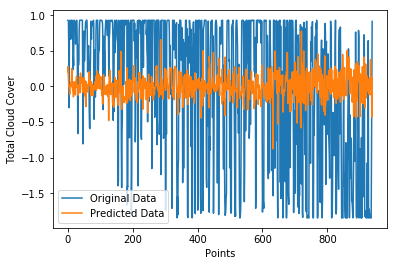

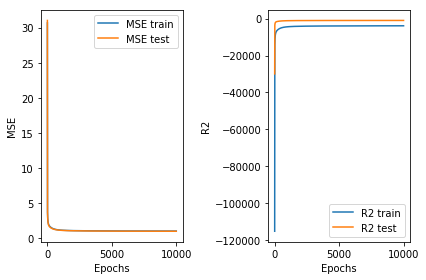

In [16]:
with tf.Session() as sess:
    # Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    #saver.restore(sess,'yahoo_dataset.ckpt')
    c_t = []
    c_test = []
    r2_t = []
    r2_test = []
    for i in range(10000):
        #for j in range(Xn_train.shape[0]):
        #    sess.run([cost,train],feed_dict=    {xs:Xn_train[j,:].reshape(1,npred), ys:yn_train[j]})
        #    # Run cost and train with each sample
        
        sess.run([cost,train],feed_dict=    {xs:Xn_train, ys:yn_train})
        
        c_t.append(sess.run(cost, feed_dict={xs:Xn_train,ys:yn_train}))
        c_test.append(sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'Cost train:',c_t[-1], 'Cost test:',c_test[-1])
        r2_t.append(sess.run(R_squared, feed_dict={xs:Xn_train,ys:yn_train}))
        r2_test.append(sess.run(R_squared, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'R2 train:',r2_t[-1], 'R2 test:',r2_test[-1])
    
    pred = sess.run(output, feed_dict={xs:Xn_test})
    # predict output of test data after training
    print('Cost :',sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
    #y_test = denormalize(df_test,y_test)
    #pred = denormalize(df_test,pred)
    #Denormalize data

    
    
    plt.plot(range(yn_test.shape[0]),yn_test,label="Original Data")
    plt.plot(range(yn_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    plt.ylabel('Total Cloud Cover')
    plt.xlabel('Points')
    #plt.title('Total Cloud Cover')
    plt.savefig('results/data_t0_2layers_10_10_split03.png')
    plt.show()
    
    
    plt.subplot(1,2,1)
    plt.plot(range(len(c_t)), c_t,label="MSE train")
    plt.plot(range(len(c_test)), c_test,label="MSE test")
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    #plt.title('Cost vs. epochs')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(r2_t)), r2_t,label="R2 train")
    plt.plot(range(len(r2_test)), r2_test,label="R2 test")
    plt.legend(loc='best')
    plt.ylabel('R2')
    plt.xlabel('Epochs')
    #plt.title('R2 vs. epochs')
    plt.tight_layout()
    plt.savefig('results/t0_2layers_10_10_split03.png')
    plt.show()
    
  

In [39]:
pred

array([[0.5912345 ],
       [0.5912345 ],
       [0.5912345 ],
       ...,
       [0.5912345 ],
       [0.5912345 ],
       [0.59123445]], dtype=float32)

-2454.9841

In [ ]:
feed_dict={xs:Xn_train[j,:], ys:yn_train[j]}

In [ ]:
Xn_test.shape

In [ ]:
tf.reshape(Xn_train[j,:], [1, npred])

In [ ]:
n_nodes

In [ ]:
output = nn_model(Xn_train, n_nodes)

In [ ]:
output.get_shape().as_list()[1]

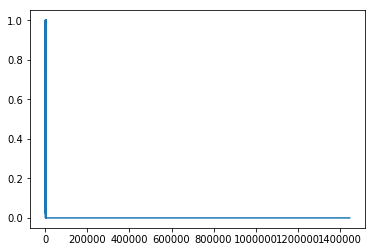

In [20]:
plt.plot(range(y.shape[0]),y,label="Original Data")